In [1]:
pname = 'stokes'
n_params = 7

# NB: order training meshes by largest first
train_mesh_names = ['reference_mesh_large.csv']#, 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
train_solution_names = ['matrix_large.mat']#, 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

test_mesh_names = ['reference_mesh_large.csv', 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
test_solution_names = ['matrix_large.mat', 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

save_name = 'best_model_l_double.pt'

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random
import matplotlib.pyplot as plt

In [3]:
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# double precision
# explanation for when this is required at https://blog.demofox.org/2017/11/21/floating-point-precision/
precision = torch.float64
torch.set_default_dtype(precision)

## THE MODEL

In [4]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    Methods:
    __init__: initialises the master mesh, and master weight & biases for the 1st and last layer of the encoder and decoder, respectively
    expand: add all new expansive nodes in the new mesh to the weight matrices
    agglomerate: agglomerate nodes to fit the new mesh
    encoder: execute the encoder part
    decoder: execute the decoder part
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        self.mesh_n = self.mesh_m
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)

    def expand(self, mesh_n, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None, **kwargs):
        """
        Expand the new weights and biases with the new expansive nodes. If during training, update the master weights, biases & mesh.
        If during inference, then just apply the new ones.
        """
        
        # During evaluation, we will have fixed mesh_m so we don't want to recompute every time => option to pass in
        if nn_n is not None:
            pass
        elif kd_tree_n is not None:
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        else:
            kd_tree_m = KDTree(self.mesh_m)
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        # During training, we will have fixed fidelities that we know and don't need to always recompute
        if nn_m is not None:
            pass
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        if not self.training:
            # ! testing mode !
            
            # could assign with .data calls here but can't do for train https://discuss.pytorch.org/t/function-tbackward-returned-an-invalid-gradient-at-index-0-got-1-3-but-expected-shape-compatible-with-1-2/125259
            
            count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
            nodes_added = 0 # how much did we increase our master mesh

            for pt_n, pt_m in enumerate(nn_n):
                if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                    nodes_added += 1
                    self.mesh_n = np.vstack([self.mesh_n, mesh_n[pt_n]])
                    count_m[pt_m]+=1

                    # Divide encoder weights by number of expansions
                    self.We_n[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                    # Store the index of the weight we want
                    # so we can update at the end without storing
                    # all the nodes to update explictly
                    new_row = torch.zeros(1, self.We_n.shape[1])
                    new_row[0][0] = pt_m
                    self.We_n = torch.cat((self.We_n, new_row), dim=0)

                    # Duplicate weights for decoder
                    self.Wd_n = torch.cat((self.Wd_n, self.Wd_n[:, pt_m:pt_m+1]), dim=1)
                    self.bd_n = torch.cat([self.bd_n, self.bd_n[pt_m:pt_m+1]])

            # Loop over the nodes we need to update using the index we stored in the first element
            for i in range(self.mesh_m.shape[0], self.mesh_m.shape[0]+nodes_added):
                index = int(self.We_n[i,0])
                self.We_n[i] = self.We_n[index]
        else:
            # ! training mode !
            
            # Expansion step is essentially creating new weights from scratch
            # => ignore gradients and therefore allow for slicing on leaf tensor as required
            # (Unless we do something smarter with the gradient tree to track what we're doing...)
            with torch.no_grad():
                count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
                nodes_added = 0 # how much did we increase our master mesh
                size=self.mesh_m.shape[0]

                for pt_n, pt_m in enumerate(nn_n):
                    if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                        nodes_added += 1
                        self.mesh_m=np.vstack([self.mesh_m, mesh_n[pt_n]])
                        count_m[pt_m]+=1
                        
                        # Divide encoder weights by number of expansions
                        self.We_m[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, self.We_m.shape[1])
                        new_row[0][0] = pt_m
                        self.We_m = nn.Parameter(torch.cat((self.We_m, new_row), dim=0))
                        
                        # Duplicate weights for decoder
                        self.Wd_m = nn.Parameter(torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1))
                        self.bd_m = nn.Parameter(torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]]))
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(self.We_m[i,0])
                    self.We_m[i] = self.We_m[index]
            
            # now we need to track gradients from our new master weights
            self.We_n = self.We_m.clone()
            self.Wd_n = self.Wd_m.clone()
            self.bd_n = self.bd_m.clone()
        return nodes_added
        
    def agglomerate(self, mesh_n, kd_tree_n=None, nn_m=None, **kwargs):
        
        # known during training
        if nn_m is not None:
            pass
        # already found in expansion or already known during training
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]

        # FIND NEW WEIGHTS (AGGLOMERATIVE ONLY NOW)
        We_n = torch.zeros((mesh_n.shape[0], self.We_n.shape[1]), device=self.We_n.device)
        Wd_n = torch.zeros((self.We_n.shape[1], mesh_n.shape[0]), device=self.We_n.device)
        bd_n = torch.zeros(mesh_n.shape[0], device=self.We_n.device)

        count_n = np.zeros(mesh_n.shape[0])

        for m, pt_m in enumerate(self.mesh_n): # agglomerate
            nn_n = nn_m[m]
            count_n[nn_n]+=1
            We_n[nn_n] += self.We_n[m]
            Wd_n[:, nn_n] = ( (count_n[nn_n]-1)*Wd_n[:, nn_n] + self.Wd_n[:, m] )/count_n[nn_n]
            bd_n[nn_n] = ( (count_n[nn_n]-1)*bd_n[nn_n] + self.bd_n[m] )/count_n[nn_n]
          
        self.We_n = We_n
        self.Wd_n = Wd_n
        self.bd_n = bd_n
        
    def reset(self):
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        if not self.training:
            self.mesh_n = self.mesh_m
        
    def encoder(self, x, mesh_n, exp_enc=True, agg_enc=True, reset_enc=False, **kwargs):
        if reset_enc:
            self.reset()
        if exp_enc:
            self.expand(mesh_n, **kwargs)
        if agg_enc:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.We_n+self.be_m
        
    def decoder(self, x, mesh_n, exp_dec=True, agg_dec=True, reset_dec=False, **kwargs):
        if reset_dec:
            self.reset()
        if exp_dec:
            self.expand(mesh_n, **kwargs)
        if agg_dec:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.Wd_n+self.bd_n
    
class GCA(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, **kwargs):
        x_enc = self.act(self.GFN.encoder(x, mesh_n, **kwargs))
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = self.GFN.decoder(x_enc, mesh_n, **kwargs)
        
        return x_recon, x_enc, x_map

## SET UP TRAINING DATA

In [5]:
from itertools import product
import scipy
from sklearn import preprocessing

def get_params(pname='stokes'):
    if pname=='stokes':
        mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
        mus = []
        n_pts = [2]*(len(mu_range)-1)+[11]
        for i in range(len(mu_range)):
            mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
        return torch.tensor(np.array(list(product(*mus))), dtype=precision)
    elif pname=='graetz':
        mus = [np.linspace(1., 3., 10), np.linspace(0.01, 0.1, 20)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)
    elif pname=='advection':
        mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp), dtype=precision)),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))), dtype=precision)
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat(fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

C:\Users\oisin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
params = get_params(pname).to(dev)

dfs_train = [pd.read_csv(i, header=None).values for i in train_mesh_names]

sols_train = [get_scaled_data(i)[1].to(dev) for i in train_solution_names]

trajs = list(range(sols_train[0].shape[0]))
random.shuffle(trajs)
train_trajs, test_trajs = np.array_split(trajs, 2)
train_trajs = np.array_split(train_trajs, len(dfs_train))

# train_trajs = random.sample(range(704), 352)
# test_trajs =list(set(range(704))-set(train_trajs))
# train_trajs=[train_trajs[176:], train_trajs[:176]]

reconstruction error tensor(9.1108e-27)


## TRAIN THE MODEL

In [7]:
# initialisation
# NB - important to start with largest mesh since this is better for initialisation purposes
# and potential savings in no expansions are done
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

added_nodes

0

In [8]:
from tqdm import tqdm

In [9]:
model.train()

# now initialise our optimiser after we have conducted ALL expansions
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [10]:
best_loss = np.inf
EPOCHS = 5000
test_losses = []
train_losses = []

def criterion(x, x_recon, x_enc, x_map):
    return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

kd_tree_m = KDTree(model.GFN.mesh_m)
# we know ahead of time the nn_n and nn_ms since we know that the master mesh is never changing and our new meshes are fixed
nn_ns = [kd_tree_m.query(df, k=1)[1] for df in dfs_train]
nn_ms = [KDTree(df).query(model.GFN.mesh_m, k=1)[1] for df in dfs_train]

for i in tqdm(range(EPOCHS)):
    opt.zero_grad()

    U_train = sols_train[0][train_trajs[0]]
    params_train = params[train_trajs[0]]
    df_train = dfs_train[0]
    if added_nodes==0:
        # because added_nodes==0, we know we don't need to expand or agglom for the medium mesh
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
    else:
        # NEED TO TEST
        # we need to agglomerate because added_nodes>0. However, we do this all in the encoder first so we can avoid in the decoder
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])

    loss = criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]

    # other fidelities
    for j in range(1, len(dfs_train)):
        U_train = sols_train[j][train_trajs[j]]
        params_train = params[train_trajs[j]]
        df_train = dfs_train[j]
        
        # only need to agglom in training since we expanded as a preprocessing step
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
        loss += criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]
    
    loss /= np.sum([k.shape[0] for k in dfs_train])
    loss.backward()
    opt.step()
    
    train_loss = loss.item()
    
    with torch.no_grad():
        params_test = params[test_trajs]
        
        U_test = sols_train[0][test_trajs]
        df_test = dfs_train[0]

        if added_nodes==0:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
        else:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])
        test_loss = criterion(U_test, x_recon, x_enc, x_map).item()*df_test.shape[0]

        for j in range(1, len(dfs_train)):
            U_test = sols_train[j][test_trajs]
            df_test = dfs_train[j]
            
            # only need to agglom in training since we expanded as a preprocessing step
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
            test_loss += criterion(U_test, x_recon, x_enc, x_map).item()*df_train.shape[0]
        
        test_loss /= np.sum([k.shape[0] for k in dfs_train])
    
    print(f'Epoch {i}: train loss: {train_loss} | test loss: {test_loss}')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss<best_loss:
        best_loss=test_loss
        best_epoch = i
        torch.save(model.state_dict(), save_name)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Epoch 0: train loss: 10.417812878144007 | test loss: 10.250080704325525


  0%|                                                                                 | 2/5000 [00:00<08:07, 10.25it/s]

Epoch 1: train loss: 10.055024280786466 | test loss: 9.975976884642916
Epoch 2: train loss: 9.790639029484531 | test loss: 9.904676472528411


  0%|                                                                                 | 4/5000 [00:00<07:30, 11.09it/s]

Epoch 3: train loss: 9.745671976424662 | test loss: 9.630459357343609


  0%|                                                                                 | 6/5000 [00:00<07:11, 11.56it/s]

Epoch 4: train loss: 9.50151478949645 | test loss: 9.525921218155283
Epoch 5: train loss: 9.421208945798952 | test loss: 9.328977251422334
Epoch 6: train loss: 9.266358110167106 | test loss: 9.156394309070608


  0%|▏                                                                                | 8/5000 [00:00<07:38, 10.89it/s]

Epoch 7: train loss: 9.10624950139846 | test loss: 9.012332985936798
Epoch 8: train loss: 8.870256193169572 | test loss: 8.81861686576563
Epoch 9: train loss: 8.580383864132898 | test loss: 8.638643144705641


  0%|▏                                                                               | 12/5000 [00:01<07:26, 11.16it/s]

Epoch 10: train loss: 8.440895517101655 | test loss: 8.441967279233664
Epoch 11: train loss: 8.273182112916835 | test loss: 8.167274483780702
Epoch 12: train loss: 8.059094908650387 | test loss: 7.911720500270771

  0%|▏                                                                               | 14/5000 [00:01<07:43, 10.76it/s]


Epoch 13: train loss: 7.800758366862954 | test loss: 7.683489967829909
Epoch 14: train loss: 7.541974597112684 | test loss: 7.569131000128831


  0%|▎                                                                               | 16/5000 [00:01<07:48, 10.63it/s]

Epoch 15: train loss: 7.340099402347063 | test loss: 7.424139544718742
Epoch 16: train loss: 7.188936015450324 | test loss: 7.2174073001194


  0%|▎                                                                               | 18/5000 [00:01<08:07, 10.21it/s]

Epoch 17: train loss: 7.035883086401442 | test loss: 6.986669900838152
Epoch 18: train loss: 6.883889794802745 | test loss: 6.86474837319556
Epoch 19: train loss: 6.755137106231335 | test loss: 6.741877670892234


  0%|▎                                                                               | 22/5000 [00:02<07:46, 10.66it/s]

Epoch 20: train loss: 6.654327632509636 | test loss: 6.63282971253808
Epoch 21: train loss: 6.528238204547563 | test loss: 6.462261999662226
Epoch 22: train loss: 6.410443142068322 | test loss: 6.382848561667482


  1%|▍                                                                               | 26/5000 [00:02<07:35, 10.92it/s]

Epoch 23: train loss: 6.333238040129369 | test loss: 6.286029225469685
Epoch 24: train loss: 6.214141831772211 | test loss: 6.176912883327778
Epoch 25: train loss: 6.101279268940545 | test loss: 6.001021993165029


  1%|▍                                                                               | 28/5000 [00:02<08:19,  9.96it/s]

Epoch 26: train loss: 6.025077841377444 | test loss: 5.914386636865284
Epoch 27: train loss: 5.9093174470940815 | test loss: 5.813986261313405


  1%|▍                                                                               | 30/5000 [00:02<08:15, 10.03it/s]

Epoch 28: train loss: 5.779373468778297 | test loss: 5.716959709306435
Epoch 29: train loss: 5.706105167627104 | test loss: 5.617767694815454
Epoch 30: train loss: 5.626085435458693 | test loss: 5.524971128922613


  1%|▌                                                                               | 32/5000 [00:03<07:55, 10.46it/s]

Epoch 31: train loss: 5.485698958007797 | test loss: 5.46400374570945
Epoch 32: train loss: 5.3967687100307815 | test loss: 5.417764871508263
Epoch 33: train loss: 5.356287760026129 | test loss: 5.354671439438631


  1%|▌                                                                               | 36/5000 [00:03<08:02, 10.30it/s]

Epoch 34: train loss: 5.292908612777552 | test loss: 5.29704203530254
Epoch 35: train loss: 5.228097193038844 | test loss: 5.2040339371012205
Epoch 36: train loss: 5.1406359470238 | test loss: 5.133206871429447


  1%|▌                                                                               | 38/5000 [00:03<07:56, 10.41it/s]

Epoch 37: train loss: 5.088795198544085 | test loss: 5.0549228074976424
Epoch 38: train loss: 5.0004160439867995 | test loss: 5.011170142136059
Epoch 39: train loss: 4.9586930217350185 | test loss: 4.957589382406179


  1%|▋                                                                               | 42/5000 [00:03<07:49, 10.56it/s]

Epoch 40: train loss: 4.933547843223261 | test loss: 4.755382286768336
Epoch 41: train loss: 4.719726823309996 | test loss: 4.714039924099984
Epoch 42: train loss: 4.685297005358619 | test loss: 4.683841397045553


  1%|▋                                                                               | 46/5000 [00:04<07:28, 11.04it/s]

Epoch 43: train loss: 4.653626221107235 | test loss: 4.579723115787684
Epoch 44: train loss: 4.577264632266438 | test loss: 4.548034528939146
Epoch 45: train loss: 4.546446999053847 | test loss: 4.421435935524862


  1%|▊                                                                               | 48/5000 [00:04<07:23, 11.18it/s]

Epoch 46: train loss: 4.4513930494303775 | test loss: 4.369179035555755
Epoch 47: train loss: 4.379171946427374 | test loss: 4.300940160129428
Epoch 48: train loss: 4.306800077021267 | test loss: 4.267058454152998


  1%|▊                                                                               | 52/5000 [00:04<07:24, 11.12it/s]

Epoch 49: train loss: 4.265570218186895 | test loss: 4.226979230845273
Epoch 50: train loss: 4.220650326040175 | test loss: 4.175138433070049
Epoch 51: train loss: 4.15154846473733 | test loss: 4.139938472720548


  1%|▊                                                                               | 54/5000 [00:05<07:28, 11.02it/s]

Epoch 52: train loss: 4.092044272210528 | test loss: 4.041214054447517
Epoch 53: train loss: 4.0318553557772745 | test loss: 4.0060135379353365
Epoch 54: train loss: 4.0646534355504915 | test loss: 4.004762786079242


  1%|▉                                                                               | 56/5000 [00:05<07:33, 10.91it/s]

Epoch 55: train loss: 3.997303040997367 | test loss: 3.963731138634738
Epoch 56: train loss: 3.9076845937935145 | test loss: 3.849742826000364


  1%|▉                                                                               | 60/5000 [00:05<07:35, 10.85it/s]

Epoch 57: train loss: 3.853317093405019 | test loss: 3.820647291101267
Epoch 58: train loss: 3.809318090176841 | test loss: 3.7592010363966173
Epoch 59: train loss: 3.7501400105569354 | test loss: 3.744656347044484


  1%|▉                                                                               | 62/5000 [00:05<07:22, 11.16it/s]

Epoch 60: train loss: 3.6907318064291887 | test loss: 3.686117131317239
Epoch 61: train loss: 3.6209476000189755 | test loss: 3.6322017798029624
Epoch 62: train loss: 3.548776032028064 | test loss: 3.573759493524614


  1%|█                                                                               | 64/5000 [00:05<07:31, 10.94it/s]

Epoch 63: train loss: 3.4770768353465233 | test loss: 3.5091658181841576
Epoch 64: train loss: 3.3980979166630667 | test loss: 3.4992173347694413


  1%|█                                                                               | 66/5000 [00:06<07:53, 10.41it/s]

Epoch 65: train loss: 3.3636526704846217 | test loss: 3.4805754722824673
Epoch 66: train loss: 3.3201897094605197 | test loss: 3.5207124754716337
Epoch 67: train loss: 3.3450425108424495 | test loss: 3.465201447417435

  1%|█                                                                               | 70/5000 [00:06<07:50, 10.47it/s]


Epoch 68: train loss: 3.287261445102718 | test loss: 3.4327522406965567
Epoch 69: train loss: 3.239542356216995 | test loss: 3.4905153205277


  1%|█▏                                                                              | 72/5000 [00:06<07:40, 10.71it/s]

Epoch 70: train loss: 3.2572023608691483 | test loss: 3.3466921422955562
Epoch 71: train loss: 3.1317131310911197 | test loss: 3.393828874378426
Epoch 72: train loss: 3.1210473512960784 | test loss: 3.3571008974927734


  2%|█▏                                                                              | 76/5000 [00:07<07:11, 11.42it/s]

Epoch 73: train loss: 3.0772323237819084 | test loss: 3.3362810524047575
Epoch 74: train loss: 3.062825287291256 | test loss: 3.383328597224657
Epoch 75: train loss: 3.078979196542517 | test loss: 3.286745432802494


  2%|█▏                                                                              | 78/5000 [00:07<07:28, 10.97it/s]

Epoch 76: train loss: 3.008005730392433 | test loss: 3.2807972150945637
Epoch 77: train loss: 2.981394726959024 | test loss: 3.2017332554574227
Epoch 78: train loss: 2.9114812972721804 | test loss: 3.1591222796341496


  2%|█▎                                                                              | 82/5000 [00:07<07:10, 11.43it/s]

Epoch 79: train loss: 2.897836175500056 | test loss: 3.1375523535598036
Epoch 80: train loss: 2.835202993091959 | test loss: 3.159786848635817
Epoch 81: train loss: 2.843604643788416 | test loss: 3.101257710324392


  2%|█▎                                                                              | 84/5000 [00:07<07:08, 11.47it/s]

Epoch 82: train loss: 2.7819997002032486 | test loss: 3.067249802000413
Epoch 83: train loss: 2.7690500480440567 | test loss: 3.0309405338197966
Epoch 84: train loss: 2.720364766537796 | test loss: 3.0085343026754825


  2%|█▍                                                                              | 88/5000 [00:08<07:05, 11.55it/s]

Epoch 85: train loss: 2.7122753708814504 | test loss: 3.009120725408714
Epoch 86: train loss: 2.7259400754353025 | test loss: 2.9950253840462606
Epoch 87: train loss: 2.70597394104614 | test loss: 2.9661800416121205


  2%|█▍                                                                              | 90/5000 [00:08<06:55, 11.81it/s]

Epoch 88: train loss: 2.666638053228604 | test loss: 2.93713607646589
Epoch 89: train loss: 2.651068655675291 | test loss: 2.9596227357178084
Epoch 90: train loss: 2.6372711671359568 | test loss: 2.9345752415808537


  2%|█▌                                                                              | 94/5000 [00:08<07:22, 11.08it/s]

Epoch 91: train loss: 2.592795209610958 | test loss: 2.9149308398487968
Epoch 92: train loss: 2.6075383903101987 | test loss: 2.869839073101039
Epoch 93: train loss: 2.5514236788063576 | test loss: 2.8758877864887067


  2%|█▌                                                                              | 96/5000 [00:08<07:26, 10.98it/s]

Epoch 94: train loss: 2.55209793650142 | test loss: 2.846898170128854
Epoch 95: train loss: 2.5384611623616213 | test loss: 2.818494276278159
Epoch 96: train loss: 2.523802299921023 | test loss: 2.770308811030273


  2%|█▌                                                                             | 100/5000 [00:09<07:29, 10.90it/s]

Epoch 97: train loss: 2.492040837920926 | test loss: 2.7653728869002325
Epoch 98: train loss: 2.479980747066448 | test loss: 2.7503359956679194
Epoch 99: train loss: 2.447021040862893 | test loss: 2.721809521731149


  2%|█▌                                                                             | 102/5000 [00:09<07:30, 10.87it/s]

Epoch 100: train loss: 2.4315149059100456 | test loss: 2.7021524963960184
Epoch 101: train loss: 2.407830648373797 | test loss: 2.7117839702314304
Epoch 102: train loss: 2.4000996190765416 | test loss: 2.6408983293338455


  2%|█▋                                                                             | 104/5000 [00:09<07:30, 10.86it/s]

Epoch 103: train loss: 2.343532459910942 | test loss: 2.741439013123809
Epoch 104: train loss: 2.3999917364688255 | test loss: 2.6857058366642037
Epoch 105: train loss: 2.353117892352731 | test loss: 2.6389578535701306


  2%|█▋                                                                             | 108/5000 [00:09<07:32, 10.81it/s]

Epoch 106: train loss: 2.3452934430102035 | test loss: 2.6160474010694017
Epoch 107: train loss: 2.3265356894956124 | test loss: 2.56017806515723


  2%|█▋                                                                             | 110/5000 [00:10<07:33, 10.78it/s]

Epoch 108: train loss: 2.262207035462247 | test loss: 2.4770261137961667
Epoch 109: train loss: 2.161569580688476 | test loss: 2.4930818665216448
Epoch 110: train loss: 2.15155287903272 | test loss: 2.5717633699292985


  2%|█▊                                                                             | 114/5000 [00:10<07:32, 10.81it/s]

Epoch 111: train loss: 2.2211769108438606 | test loss: 2.4969356312850186
Epoch 112: train loss: 2.1479480323313314 | test loss: 2.4275124660653336
Epoch 113: train loss: 2.0892303778049706 | test loss: 2.515052715195626


  2%|█▊                                                                             | 116/5000 [00:10<07:26, 10.95it/s]

Epoch 114: train loss: 2.1893284866491207 | test loss: 2.4439210675687133
Epoch 115: train loss: 2.125537585000971 | test loss: 2.4054444938043837


  2%|█▊                                                                             | 118/5000 [00:10<07:35, 10.71it/s]

Epoch 116: train loss: 2.081073030122051 | test loss: 2.4316017357430337
Epoch 117: train loss: 2.1224160303117494 | test loss: 2.3756415999634455
Epoch 118: train loss: 2.0331620734693576 | test loss: 2.271008979995986


  2%|█▉                                                                             | 122/5000 [00:11<07:23, 10.99it/s]

Epoch 119: train loss: 1.9235373265559401 | test loss: 2.3472524067326295
Epoch 120: train loss: 2.0005477520785164 | test loss: 2.2422784756759135
Epoch 121: train loss: 1.9011263763045392 | test loss: 2.2157212635114445


  2%|█▉                                                                             | 124/5000 [00:11<07:24, 10.96it/s]

Epoch 122: train loss: 1.8691647654819081 | test loss: 2.2170608854451364
Epoch 123: train loss: 1.8792627478992778 | test loss: 2.184568497321106
Epoch 124: train loss: 1.843992362930603 | test loss: 2.1701398044067473


  3%|██                                                                             | 128/5000 [00:11<07:34, 10.71it/s]

Epoch 125: train loss: 1.8156127340371984 | test loss: 2.1361366618173747
Epoch 126: train loss: 1.785506570359399 | test loss: 2.0899961740108064
Epoch 127: train loss: 1.7463782031569672 | test loss: 2.0569492745126876


  3%|██                                                                             | 130/5000 [00:12<07:29, 10.84it/s]

Epoch 128: train loss: 1.7196589728467317 | test loss: 2.034233612990473
Epoch 129: train loss: 1.687351285121406 | test loss: 2.004904537010499
Epoch 130: train loss: 1.658877665582943 | test loss: 1.9744667752735714


  3%|██                                                                             | 134/5000 [00:12<07:19, 11.08it/s]

Epoch 131: train loss: 1.6312322872982716 | test loss: 1.9063729748845282
Epoch 132: train loss: 1.5843678713306777 | test loss: 1.8673410257196903
Epoch 133: train loss: 1.5614995570173424 | test loss: 1.8380894267012056


  3%|██▏                                                                            | 136/5000 [00:12<07:27, 10.86it/s]

Epoch 134: train loss: 1.5249561885498497 | test loss: 1.81914672548661
Epoch 135: train loss: 1.491623573822709 | test loss: 1.7966360799323855


  3%|██▏                                                                            | 138/5000 [00:12<08:13,  9.85it/s]

Epoch 136: train loss: 1.4754939983246302 | test loss: 1.7795760724633176
Epoch 137: train loss: 1.451794967145087 | test loss: 1.7704299012615077


  3%|██▏                                                                            | 140/5000 [00:12<07:53, 10.25it/s]

Epoch 138: train loss: 1.4315180746190668 | test loss: 1.752270438132526
Epoch 139: train loss: 1.4107638877286053 | test loss: 1.7228750621024909
Epoch 140: train loss: 1.3893117057590518 | test loss: 1.7138110904416624


  3%|██▎                                                                            | 144/5000 [00:13<07:27, 10.85it/s]

Epoch 141: train loss: 1.3727845826592542 | test loss: 1.6783939095639906
Epoch 142: train loss: 1.3567047524780638 | test loss: 1.6770891554695724
Epoch 143: train loss: 1.3507308721558289 | test loss: 1.6393760171536833


  3%|██▎                                                                            | 146/5000 [00:13<07:19, 11.05it/s]

Epoch 144: train loss: 1.308983218147511 | test loss: 1.6442971700220061
Epoch 145: train loss: 1.3151520034792297 | test loss: 1.6136681490070295
Epoch 146: train loss: 1.280948859149399 | test loss: 1.593484820760744


  3%|██▎                                                                            | 150/5000 [00:13<07:07, 11.33it/s]

Epoch 147: train loss: 1.264271244836359 | test loss: 1.5848973810912015
Epoch 148: train loss: 1.2590519652102032 | test loss: 1.5656764413582966
Epoch 149: train loss: 1.224044846086307 | test loss: 1.5806145291852949


  3%|██▍                                                                            | 152/5000 [00:14<07:20, 11.00it/s]

Epoch 150: train loss: 1.228202285078532 | test loss: 1.5582827751301136
Epoch 151: train loss: 1.2221282157112427 | test loss: 1.535684128064359
Epoch 152: train loss: 1.196440148581709 | test loss: 1.5115345703428273


  3%|██▍                                                                            | 156/5000 [00:14<07:08, 11.31it/s]

Epoch 153: train loss: 1.1828261538240148 | test loss: 1.4697875998211227
Epoch 154: train loss: 1.1316330386385336 | test loss: 1.4598429440666807
Epoch 155: train loss: 1.125882546693476 | test loss: 1.4454476791258823


  3%|██▍                                                                            | 158/5000 [00:14<07:23, 10.91it/s]

Epoch 156: train loss: 1.1081075822989226 | test loss: 1.4311158641871864
Epoch 157: train loss: 1.0917994669663877 | test loss: 1.4164748395500146
Epoch 158: train loss: 1.0886060009606076 | test loss: 1.4035186701778641


  3%|██▌                                                                            | 162/5000 [00:14<07:18, 11.03it/s]

Epoch 159: train loss: 1.0594723458806174 | test loss: 1.4011430990828897
Epoch 160: train loss: 1.052312773725315 | test loss: 1.3810999571087987
Epoch 161: train loss: 1.0448682784101408 | test loss: 1.369315139495825


  3%|██▌                                                                            | 164/5000 [00:15<07:25, 10.86it/s]

Epoch 162: train loss: 1.0320224346233622 | test loss: 1.3509298086170993
Epoch 163: train loss: 1.0145278640337962 | test loss: 1.3614156201426448


  3%|██▌                                                                            | 166/5000 [00:15<07:31, 10.71it/s]

Epoch 164: train loss: 1.0205869803783356 | test loss: 1.338203887941806
Epoch 165: train loss: 0.9959060199388742 | test loss: 1.32160948766824
Epoch 166: train loss: 0.9862859822163207 | test loss: 1.3151736777602618


  3%|██▋                                                                            | 168/5000 [00:15<07:42, 10.45it/s]

Epoch 167: train loss: 0.9784272636513824 | test loss: 1.302208471288436
Epoch 168: train loss: 0.9665847932462919 | test loss: 1.2916206360336666
Epoch 169: train loss: 0.9543530401934286 | test loss: 1.277678018478584


  3%|██▋                                                                            | 172/5000 [00:15<07:40, 10.47it/s]

Epoch 170: train loss: 0.9417036451256946 | test loss: 1.278111099749438
Epoch 171: train loss: 0.9347647859914361 | test loss: 1.2618511770338143
Epoch 172: train loss: 0.9274006707683795 | test loss: 1.2403992482602957


  3%|██▋                                                                            | 174/5000 [00:16<07:55, 10.16it/s]

Epoch 173: train loss: 0.9210614920461301 | test loss: 1.2342394657831361
Epoch 174: train loss: 0.9102465763952435 | test loss: 1.2319204930268086
Epoch 175: train loss: 0.9021735552967116 | test loss: 1.2295870827202684


  4%|██▊                                                                            | 178/5000 [00:16<07:48, 10.29it/s]

Epoch 176: train loss: 0.8968288379745466 | test loss: 1.221175220469688
Epoch 177: train loss: 0.8897143062544355 | test loss: 1.2080212533013643
Epoch 178: train loss: 0.8871924386984482 | test loss: 1.2004637109842986


  4%|██▉                                                                            | 182/5000 [00:16<07:12, 11.15it/s]

Epoch 179: train loss: 0.8800830689161507 | test loss: 1.1955812527614922
Epoch 180: train loss: 0.8745985251234105 | test loss: 1.1853756535433677
Epoch 181: train loss: 0.8674100553296592 | test loss: 1.1873229384531305


  4%|██▉                                                                            | 184/5000 [00:17<07:26, 10.79it/s]

Epoch 182: train loss: 0.867818436925608 | test loss: 1.1781797375989815
Epoch 183: train loss: 0.8581059906461095 | test loss: 1.1686723264293393
Epoch 184: train loss: 0.8552667997127972 | test loss: 1.165060960901715


  4%|██▉                                                                            | 188/5000 [00:17<06:56, 11.56it/s]

Epoch 185: train loss: 0.8511956608376959 | test loss: 1.1646359716439796
Epoch 186: train loss: 0.8510033003675973 | test loss: 1.1684114453851313
Epoch 187: train loss: 0.8542376824793925 | test loss: 1.170313152996842


  4%|███                                                                            | 190/5000 [00:17<06:53, 11.63it/s]

Epoch 188: train loss: 0.8597599437994575 | test loss: 1.1731762243664905
Epoch 189: train loss: 0.8526337992289175 | test loss: 1.1564537665532273
Epoch 190: train loss: 0.8412793292923241 | test loss: 1.1351676203605954


  4%|███                                                                            | 194/5000 [00:17<06:42, 11.93it/s]

Epoch 191: train loss: 0.8295235371750854 | test loss: 1.1290514187376948
Epoch 192: train loss: 0.8219606523838056 | test loss: 1.1244101547800547
Epoch 193: train loss: 0.8182444061495732 | test loss: 1.1195389726201512


  4%|███                                                                            | 196/5000 [00:18<07:01, 11.41it/s]

Epoch 194: train loss: 0.8137780569408644 | test loss: 1.110208138818972
Epoch 195: train loss: 0.8128072152782686 | test loss: 1.1077484304912777
Epoch 196: train loss: 0.8110609692759935 | test loss: 1.1071950159647255


  4%|███▏                                                                           | 200/5000 [00:18<06:41, 11.94it/s]

Epoch 197: train loss: 0.8134325172616359 | test loss: 1.1154044561396246
Epoch 198: train loss: 0.8190179140435969 | test loss: 1.1166623763749504
Epoch 199: train loss: 0.8291069531110967 | test loss: 1.1286644839849385


  4%|███▏                                                                           | 202/5000 [00:18<06:55, 11.56it/s]

Epoch 200: train loss: 0.8330942176886337 | test loss: 1.1097457472190693
Epoch 201: train loss: 0.8274501954491832 | test loss: 1.0985573239958684
Epoch 202: train loss: 0.8100317133376597 | test loss: 1.07763203770983


  4%|███▏                                                                           | 204/5000 [00:18<06:50, 11.68it/s]

Epoch 203: train loss: 0.7982559006621548 | test loss: 1.0775693419353731
Epoch 204: train loss: 0.7911742622228654 | test loss: 1.0695374191985645
Epoch 205: train loss: 0.7872519742985693 | test loss: 1.0666479833066322


  4%|███▎                                                                           | 208/5000 [00:19<07:01, 11.37it/s]

Epoch 206: train loss: 0.7841167784408956 | test loss: 1.0626068516208602
Epoch 207: train loss: 0.782954103258121 | test loss: 1.062300827576975
Epoch 208: train loss: 0.7833376267504311 | test loss: 1.0686185979319487


  4%|███▎                                                                           | 212/5000 [00:19<06:55, 11.53it/s]

Epoch 209: train loss: 0.7861279696819566 | test loss: 1.0655344895725782
Epoch 210: train loss: 0.7895013384381293 | test loss: 1.0791718477481926
Epoch 211: train loss: 0.7956043130897505 | test loss: 1.0738435335509222


  4%|███▍                                                                           | 214/5000 [00:19<06:50, 11.66it/s]

Epoch 212: train loss: 0.7998229308884195 | test loss: 1.0795095594060593
Epoch 213: train loss: 0.7962934260660368 | test loss: 1.0575143599243826
Epoch 214: train loss: 0.7889701244375892 | test loss: 1.056241976872796


  4%|███▍                                                                           | 216/5000 [00:19<06:55, 11.51it/s]

Epoch 215: train loss: 0.7817700532195588 | test loss: 1.0517067475227564
Epoch 216: train loss: 0.7792962180231153 | test loss: 1.0474368146549125
Epoch 217: train loss: 0.7749136682951083 | test loss: 1.046002498797264


  4%|███▍                                                                           | 220/5000 [00:20<06:56, 11.48it/s]

Epoch 218: train loss: 0.7795521081026763 | test loss: 1.0382741025372755
Epoch 219: train loss: 0.7718288400358312 | test loss: 1.0421083320492932
Epoch 220: train loss: 0.7720385709583172 | test loss: 1.038553522824372


  4%|███▌                                                                           | 224/5000 [00:20<07:10, 11.10it/s]

Epoch 221: train loss: 0.7686342891660092 | test loss: 1.0383622472568477
Epoch 222: train loss: 0.7711202193114441 | test loss: 1.0336233627860636
Epoch 223: train loss: 0.7723581398796435 | test loss: 1.0429571941124898


  5%|███▌                                                                           | 226/5000 [00:20<07:02, 11.30it/s]

Epoch 224: train loss: 0.7725724621878155 | test loss: 1.0278316194176764
Epoch 225: train loss: 0.7689384934279642 | test loss: 1.0274901639737646
Epoch 226: train loss: 0.76140785119052 | test loss: 1.0185719095915335


  5%|███▌                                                                           | 228/5000 [00:20<07:34, 10.51it/s]

Epoch 227: train loss: 0.7570041087533195 | test loss: 1.016273544112643
Epoch 228: train loss: 0.7553885807471592 | test loss: 1.014894011399861
Epoch 229: train loss: 0.7545633252859792 | test loss: 1.0190465663424746


  5%|███▋                                                                           | 232/5000 [00:21<07:22, 10.79it/s]

Epoch 230: train loss: 0.7556204579726712 | test loss: 1.018296021202238
Epoch 231: train loss: 0.7582948324636425 | test loss: 1.0185069219010285
Epoch 232: train loss: 0.7624299881654918 | test loss: 1.027154904049545


  5%|███▋                                                                           | 236/5000 [00:21<07:21, 10.80it/s]

Epoch 233: train loss: 0.7664973923217516 | test loss: 1.018795158162007
Epoch 234: train loss: 0.7638720680486443 | test loss: 1.018142218587689
Epoch 235: train loss: 0.759033413196519 | test loss: 1.0065329922572186


  5%|███▊                                                                           | 238/5000 [00:21<07:14, 10.96it/s]

Epoch 236: train loss: 0.7569478272276922 | test loss: 1.0176881374204858
Epoch 237: train loss: 0.7564539254560144 | test loss: 1.0094613745898164
Epoch 238: train loss: 0.7617274370359478 | test loss: 1.0188097202798216


  5%|███▊                                                                           | 242/5000 [00:22<07:08, 11.11it/s]

Epoch 239: train loss: 0.7600128388998342 | test loss: 1.0056436414465657
Epoch 240: train loss: 0.7592593731324571 | test loss: 1.0106419483535132
Epoch 241: train loss: 0.7546573554097916 | test loss: 1.004527113941526


  5%|███▊                                                                           | 244/5000 [00:22<07:15, 10.92it/s]

Epoch 242: train loss: 0.7533350303704682 | test loss: 1.0010376121696218
Epoch 243: train loss: 0.7474058188128699 | test loss: 0.9936602768387327


  5%|███▉                                                                           | 246/5000 [00:22<07:17, 10.86it/s]

Epoch 244: train loss: 0.7444390712436069 | test loss: 0.9879720860838479
Epoch 245: train loss: 0.7401155584861612 | test loss: 0.9901810308624774
Epoch 246: train loss: 0.7389095794712436 | test loss: 0.9832045186956371


  5%|███▉                                                                           | 250/5000 [00:22<07:04, 11.19it/s]

Epoch 247: train loss: 0.7390563815013402 | test loss: 0.9881080480499524
Epoch 248: train loss: 0.7401271000241079 | test loss: 0.9896152719107969
Epoch 249: train loss: 0.7438853811021944 | test loss: 0.9896319509604452


  5%|███▉                                                                           | 252/5000 [00:23<07:19, 10.81it/s]

Epoch 250: train loss: 0.7448256228692729 | test loss: 0.9940408204966507
Epoch 251: train loss: 0.7501269475202877 | test loss: 0.9916669016201962
Epoch 252: train loss: 0.7442714684447533 | test loss: 0.9889180287493883


  5%|████                                                                           | 256/5000 [00:23<07:04, 11.17it/s]

Epoch 253: train loss: 0.7463184748943194 | test loss: 0.9886131370579583
Epoch 254: train loss: 0.7470563741233567 | test loss: 0.9953569096466821
Epoch 255: train loss: 0.7476277102873017 | test loss: 0.9861959060815503


  5%|████                                                                           | 258/5000 [00:23<07:05, 11.14it/s]

Epoch 256: train loss: 0.7440102736804001 | test loss: 0.9863604135770173
Epoch 257: train loss: 0.7413300246172434 | test loss: 0.977853044245246
Epoch 258: train loss: 0.7382252382110202 | test loss: 0.9824754864763078


  5%|████▏                                                                          | 262/5000 [00:23<07:12, 10.96it/s]

Epoch 259: train loss: 0.7355675944024013 | test loss: 0.9737150804843752
Epoch 260: train loss: 0.7337381532038448 | test loss: 0.9771189487886931
Epoch 261: train loss: 0.7327302766570012 | test loss: 0.9659807996242353


  5%|████▏                                                                          | 264/5000 [00:24<07:03, 11.18it/s]

Epoch 262: train loss: 0.7330802117262671 | test loss: 0.979760808440231
Epoch 263: train loss: 0.7317068404674592 | test loss: 0.9710472403069622
Epoch 264: train loss: 0.7293491344865456 | test loss: 0.9769088386389609


  5%|████▏                                                                          | 268/5000 [00:24<07:06, 11.10it/s]

Epoch 265: train loss: 0.732165357870511 | test loss: 0.9662372001353366
Epoch 266: train loss: 0.7300263863447678 | test loss: 0.9763740476619484
Epoch 267: train loss: 0.7357288402114213 | test loss: 0.9794135284695212


  5%|████▎                                                                          | 270/5000 [00:24<06:55, 11.40it/s]

Epoch 268: train loss: 0.7386450716031301 | test loss: 0.9859206252848747
Epoch 269: train loss: 0.7472498817538905 | test loss: 0.9810267740884999
Epoch 270: train loss: 0.7420878507473575 | test loss: 0.978095163285323


  5%|████▎                                                                          | 272/5000 [00:24<06:56, 11.34it/s]

Epoch 271: train loss: 0.7374947349651069 | test loss: 0.9655520671089753
Epoch 272: train loss: 0.7292772043248914 | test loss: 0.9623696541790042
Epoch 273: train loss: 0.7231746679355744 | test loss: 0.9610235123689621


  6%|████▎                                                                          | 276/5000 [00:25<06:45, 11.64it/s]

Epoch 274: train loss: 0.7212361192113178 | test loss: 0.9599574806346125
Epoch 275: train loss: 0.7207782408372296 | test loss: 0.9604120470919946
Epoch 276: train loss: 0.7217946518958187 | test loss: 0.9615052147903743


  6%|████▍                                                                          | 280/5000 [00:25<06:26, 12.21it/s]

Epoch 277: train loss: 0.7217345454516056 | test loss: 0.9607773806288894
Epoch 278: train loss: 0.7242421112826101 | test loss: 0.9665667675437795
Epoch 279: train loss: 0.7240840938855979 | test loss: 0.9556361225360445


  6%|████▍                                                                          | 282/5000 [00:25<06:45, 11.64it/s]

Epoch 280: train loss: 0.7242582761556708 | test loss: 0.9626626520965846
Epoch 281: train loss: 0.7208838146008902 | test loss: 0.9474634353386919
Epoch 282: train loss: 0.7197426800284472 | test loss: 0.9590211942461443


  6%|████▌                                                                          | 286/5000 [00:26<06:34, 11.94it/s]

Epoch 283: train loss: 0.716381222362494 | test loss: 0.9523871636769342
Epoch 284: train loss: 0.7170834102515369 | test loss: 0.9572112607236185
Epoch 285: train loss: 0.7206738391798748 | test loss: 0.9658040932467608


  6%|████▌                                                                          | 288/5000 [00:26<06:34, 11.96it/s]

Epoch 286: train loss: 0.7280003357275453 | test loss: 0.9666751690239777
Epoch 287: train loss: 0.7373269631231039 | test loss: 0.9700003570918907
Epoch 288: train loss: 0.7346223225710982 | test loss: 0.9697007516107292


  6%|████▌                                                                          | 292/5000 [00:26<06:43, 11.68it/s]

Epoch 289: train loss: 0.7352804994536039 | test loss: 0.9583634909343215
Epoch 290: train loss: 0.7230575899485279 | test loss: 0.9495542035615154
Epoch 291: train loss: 0.7159979105280736 | test loss: 0.9458029082620916


  6%|████▋                                                                          | 294/5000 [00:26<06:48, 11.52it/s]

Epoch 292: train loss: 0.7104033653168089 | test loss: 0.9412833958503515
Epoch 293: train loss: 0.7086364943067754 | test loss: 0.9460104607931297
Epoch 294: train loss: 0.7083622595729845 | test loss: 0.9425309470422294


  6%|████▋                                                                          | 298/5000 [00:27<06:34, 11.91it/s]

Epoch 295: train loss: 0.7089256953385642 | test loss: 0.9481764887595876
Epoch 296: train loss: 0.7107724480261588 | test loss: 0.9464891395402342
Epoch 297: train loss: 0.7111288964163622 | test loss: 0.9504426439399805


  6%|████▋                                                                          | 300/5000 [00:27<06:30, 12.04it/s]

Epoch 298: train loss: 0.712777315791545 | test loss: 0.945911876655785
Epoch 299: train loss: 0.7102836473886392 | test loss: 0.9446299557553552
Epoch 300: train loss: 0.7089269699287117 | test loss: 0.9413604602753065


  6%|████▊                                                                          | 304/5000 [00:27<06:41, 11.70it/s]

Epoch 301: train loss: 0.7060597950610921 | test loss: 0.9396085816940346
Epoch 302: train loss: 0.7047113624218541 | test loss: 0.9385993292678434
Epoch 303: train loss: 0.7051051001785159 | test loss: 0.9453487872865084


  6%|████▊                                                                          | 306/5000 [00:27<06:37, 11.81it/s]

Epoch 304: train loss: 0.7067345244846177 | test loss: 0.9410249172258598
Epoch 305: train loss: 0.7138565044113605 | test loss: 0.9652708553279927
Epoch 306: train loss: 0.7241446456510926 | test loss: 0.9538058812447379


  6%|████▉                                                                          | 310/5000 [00:28<06:44, 11.58it/s]

Epoch 307: train loss: 0.7359569063761914 | test loss: 0.9768241742990772
Epoch 308: train loss: 0.7341194233847452 | test loss: 0.9499621502962851
Epoch 309: train loss: 0.7273925382657694 | test loss: 0.9638231311641838


  6%|████▉                                                                          | 312/5000 [00:28<06:42, 11.64it/s]

Epoch 310: train loss: 0.7221335425914764 | test loss: 0.9443180147263741
Epoch 311: train loss: 0.7099881319229256 | test loss: 0.9356341423972403
Epoch 312: train loss: 0.7070340148316703 | test loss: 0.9487157279127425


  6%|████▉                                                                          | 316/5000 [00:28<06:31, 11.96it/s]

Epoch 313: train loss: 0.7066656177049593 | test loss: 0.9391798837318084
Epoch 314: train loss: 0.7116463803917974 | test loss: 0.9471077525492377
Epoch 315: train loss: 0.7066082086523869 | test loss: 0.9426017356979666


  6%|█████                                                                          | 318/5000 [00:28<06:24, 12.18it/s]

Epoch 316: train loss: 0.7079453982814714 | test loss: 0.9412639197343814
Epoch 317: train loss: 0.7108907708137503 | test loss: 0.9405502003497033
Epoch 318: train loss: 0.7022773446467285 | test loss: 0.932395812886773


  6%|█████                                                                          | 322/5000 [00:29<06:31, 11.94it/s]

Epoch 319: train loss: 0.7020616310423229 | test loss: 0.9346294009620068
Epoch 320: train loss: 0.6993282006183326 | test loss: 0.9315037842994508
Epoch 321: train loss: 0.6970304064418271 | test loss: 0.9315579248633239


  6%|█████                                                                          | 324/5000 [00:29<06:29, 12.02it/s]

Epoch 322: train loss: 0.7011695686740123 | test loss: 0.9372784133318673
Epoch 323: train loss: 0.70416354249333 | test loss: 0.942375285040968
Epoch 324: train loss: 0.7071292002425595 | test loss: 0.9495649697234294


  7%|█████▏                                                                         | 328/5000 [00:29<06:29, 11.98it/s]

Epoch 325: train loss: 0.7203221865933018 | test loss: 0.9562112341673488
Epoch 326: train loss: 0.7223214535055342 | test loss: 0.9552444973206857
Epoch 327: train loss: 0.718596717200773 | test loss: 0.9524848772748393


  7%|█████▏                                                                         | 330/5000 [00:29<06:30, 11.97it/s]

Epoch 328: train loss: 0.7168276272565669 | test loss: 0.9329976521575782
Epoch 329: train loss: 0.7054650841999738 | test loss: 0.9387105585811523
Epoch 330: train loss: 0.7055171973536742 | test loss: 0.9375617536582718


  7%|█████▎                                                                         | 334/5000 [00:30<06:15, 12.42it/s]

Epoch 331: train loss: 0.7024078499463642 | test loss: 0.942082998987934
Epoch 332: train loss: 0.7022084915261001 | test loss: 0.9391058761349222
Epoch 333: train loss: 0.7057403498900188 | test loss: 0.9357862886302678


  7%|█████▎                                                                         | 336/5000 [00:30<06:21, 12.21it/s]

Epoch 334: train loss: 0.7064595229661895 | test loss: 0.9345249899472028
Epoch 335: train loss: 0.7049737682982916 | test loss: 0.9403103189260622
Epoch 336: train loss: 0.7031642935890526 | test loss: 0.9331003654719554


  7%|█████▎                                                                         | 340/5000 [00:30<06:10, 12.56it/s]

Epoch 337: train loss: 0.7029474467681741 | test loss: 0.9382624058953831
Epoch 338: train loss: 0.7014729478817323 | test loss: 0.9250929496640089
Epoch 339: train loss: 0.7025378826598767 | test loss: 0.927996266742518


  7%|█████▍                                                                         | 342/5000 [00:30<06:18, 12.31it/s]

Epoch 340: train loss: 0.7017288800890186 | test loss: 0.9326251301959515
Epoch 341: train loss: 0.7008541980422999 | test loss: 0.935149894978965
Epoch 342: train loss: 0.7018451124244259 | test loss: 0.9197541717246994


  7%|█████▍                                                                         | 346/5000 [00:31<06:41, 11.60it/s]

Epoch 343: train loss: 0.6985316543413375 | test loss: 0.9292662905750557
Epoch 344: train loss: 0.6994158101708764 | test loss: 0.9176935850353909
Epoch 345: train loss: 0.6936766766780088 | test loss: 0.9280443537693055


  7%|█████▍                                                                         | 348/5000 [00:31<06:28, 11.99it/s]

Epoch 346: train loss: 0.693048053443881 | test loss: 0.9190210744725823
Epoch 347: train loss: 0.692712877380524 | test loss: 0.9268072387657895
Epoch 348: train loss: 0.6913118258478976 | test loss: 0.9149151959162168


  7%|█████▌                                                                         | 352/5000 [00:31<06:55, 11.18it/s]

Epoch 349: train loss: 0.6922665048288044 | test loss: 0.9257683575608924
Epoch 350: train loss: 0.6921364761326301 | test loss: 0.9277678054955629
Epoch 351: train loss: 0.6953769317330187 | test loss: 0.9342478054322905


  7%|█████▌                                                                         | 354/5000 [00:31<06:45, 11.45it/s]

Epoch 352: train loss: 0.699564533309651 | test loss: 0.9302756307132184
Epoch 353: train loss: 0.6993282702029102 | test loss: 0.9253380366924421
Epoch 354: train loss: 0.6979532182572926 | test loss: 0.9248901887536239


  7%|█████▋                                                                         | 358/5000 [00:32<06:38, 11.66it/s]

Epoch 355: train loss: 0.6938286828045226 | test loss: 0.9176421512387022
Epoch 356: train loss: 0.6890316740388759 | test loss: 0.9131117640460273
Epoch 357: train loss: 0.6836644717771652 | test loss: 0.9151824485791684


  7%|█████▋                                                                         | 360/5000 [00:32<06:33, 11.80it/s]

Epoch 358: train loss: 0.6841711704647524 | test loss: 0.9074078092442122
Epoch 359: train loss: 0.6820160235424075 | test loss: 0.9135228583265818
Epoch 360: train loss: 0.6801532385654766 | test loss: 0.9140713340780077


  7%|█████▊                                                                         | 364/5000 [00:32<06:25, 12.03it/s]

Epoch 361: train loss: 0.6829275596014812 | test loss: 0.9120107841910532
Epoch 362: train loss: 0.6824894769266642 | test loss: 0.9115417638585906
Epoch 363: train loss: 0.684827598109344 | test loss: 0.9231000297071001


  7%|█████▊                                                                         | 366/5000 [00:32<06:27, 11.95it/s]

Epoch 364: train loss: 0.6904894938306065 | test loss: 0.912381329288636
Epoch 365: train loss: 0.6917810436552772 | test loss: 0.9323267299771156
Epoch 366: train loss: 0.6978536914458539 | test loss: 0.9150191831095715


  7%|█████▊                                                                         | 370/5000 [00:33<06:14, 12.38it/s]

Epoch 367: train loss: 0.6967399593994537 | test loss: 0.9229206414871143
Epoch 368: train loss: 0.6916753963835387 | test loss: 0.9103867084538113
Epoch 369: train loss: 0.6876104891071844 | test loss: 0.9136465524260612


  7%|█████▉                                                                         | 372/5000 [00:33<06:22, 12.09it/s]

Epoch 370: train loss: 0.6814623420854459 | test loss: 0.9025006360407873
Epoch 371: train loss: 0.6761843005699766 | test loss: 0.9068427673591866
Epoch 372: train loss: 0.675027641257053 | test loss: 0.903497331578506


  8%|█████▉                                                                         | 376/5000 [00:33<06:44, 11.43it/s]

Epoch 373: train loss: 0.6758859741836041 | test loss: 0.9061226242848448
Epoch 374: train loss: 0.6763673194933074 | test loss: 0.9091193678245726
Epoch 375: train loss: 0.6782366154260657 | test loss: 0.9097185844038643


  8%|█████▉                                                                         | 378/5000 [00:33<06:38, 11.61it/s]

Epoch 376: train loss: 0.6820002169953655 | test loss: 0.9088321148613652
Epoch 377: train loss: 0.6791843354205649 | test loss: 0.9086300660780625
Epoch 378: train loss: 0.6773390961152975 | test loss: 0.9018501748561804


  8%|██████                                                                         | 382/5000 [00:34<06:36, 11.65it/s]

Epoch 379: train loss: 0.675875734762757 | test loss: 0.9051220605794817
Epoch 380: train loss: 0.6721580819191737 | test loss: 0.8989024469356979
Epoch 381: train loss: 0.6721271669720522 | test loss: 0.9032892250421705


  8%|██████                                                                         | 384/5000 [00:34<06:32, 11.77it/s]

Epoch 382: train loss: 0.6717998938468275 | test loss: 0.8964702327118406
Epoch 383: train loss: 0.671820428873331 | test loss: 0.9054691585758643
Epoch 384: train loss: 0.6715330054338681 | test loss: 0.8938122345386026


  8%|██████▏                                                                        | 388/5000 [00:34<06:14, 12.33it/s]

Epoch 385: train loss: 0.6727273073698362 | test loss: 0.9035729681105519
Epoch 386: train loss: 0.6707658235373327 | test loss: 0.9006918704451067
Epoch 387: train loss: 0.6717670433496298 | test loss: 0.9010325220845226


  8%|██████▏                                                                        | 390/5000 [00:34<06:24, 11.98it/s]

Epoch 388: train loss: 0.6736658298280346 | test loss: 0.905221518864779
Epoch 389: train loss: 0.6744659323715333 | test loss: 0.9080695789982283
Epoch 390: train loss: 0.6792286414899906 | test loss: 0.9105316938290985


  8%|██████▏                                                                        | 394/5000 [00:35<06:19, 12.13it/s]

Epoch 391: train loss: 0.6830603783643049 | test loss: 0.9090227181070092
Epoch 392: train loss: 0.6805097631515498 | test loss: 0.9119904853562069
Epoch 393: train loss: 0.6799086701187802 | test loss: 0.8974661057972342


  8%|██████▎                                                                        | 396/5000 [00:35<06:29, 11.81it/s]

Epoch 394: train loss: 0.679475015869355 | test loss: 0.9150421626923371
Epoch 395: train loss: 0.6823967989674039 | test loss: 0.9123481271893554
Epoch 396: train loss: 0.7022760026856192 | test loss: 0.917821101010115


  8%|██████▎                                                                        | 398/5000 [00:35<06:45, 11.36it/s]

Epoch 397: train loss: 0.6853816669450358 | test loss: 0.9034883042701536
Epoch 398: train loss: 0.6796770659091063 | test loss: 0.9045811468398798
Epoch 399: train loss: 0.6800954966828878 | test loss: 0.8934033272221438


  8%|██████▎                                                                        | 402/5000 [00:35<06:42, 11.43it/s]

Epoch 400: train loss: 0.6739865253282343 | test loss: 0.8975325031601348
Epoch 401: train loss: 0.6718549695777039 | test loss: 0.9014079559345833
Epoch 402: train loss: 0.6718064332598518 | test loss: 0.8888376976819168


  8%|██████▍                                                                        | 404/5000 [00:36<06:46, 11.32it/s]

Epoch 403: train loss: 0.6736853444800649 | test loss: 0.890965656063842
Epoch 404: train loss: 0.6690387828297975 | test loss: 0.8931253884226891
Epoch 405: train loss: 0.6668628673437231 | test loss: 0.8844252789740003


  8%|██████▍                                                                        | 408/5000 [00:36<06:53, 11.12it/s]

Epoch 406: train loss: 0.663549319448114 | test loss: 0.8828115535661913
Epoch 407: train loss: 0.663006088054699 | test loss: 0.8891039759118823


  8%|██████▍                                                                        | 410/5000 [00:36<06:41, 11.44it/s]

Epoch 408: train loss: 0.6635438120725901 | test loss: 0.886406147726946
Epoch 409: train loss: 0.663583166824023 | test loss: 0.883135452413401
Epoch 410: train loss: 0.6656092776836195 | test loss: 0.8952230985897125


  8%|██████▌                                                                        | 414/5000 [00:36<06:35, 11.60it/s]

Epoch 411: train loss: 0.6638641450735114 | test loss: 0.8810146394665344
Epoch 412: train loss: 0.659706884546596 | test loss: 0.8838052495630825
Epoch 413: train loss: 0.6581078786758873 | test loss: 0.8855036972016767


  8%|██████▌                                                                        | 416/5000 [00:37<06:34, 11.61it/s]

Epoch 414: train loss: 0.6579073157308715 | test loss: 0.8772012079297843
Epoch 415: train loss: 0.6579815290712846 | test loss: 0.8881117952337201
Epoch 416: train loss: 0.6595717429806006 | test loss: 0.8852028276746041


  8%|██████▋                                                                        | 420/5000 [00:37<06:43, 11.36it/s]

Epoch 417: train loss: 0.6594067361565746 | test loss: 0.8869171274729125
Epoch 418: train loss: 0.6613879896217955 | test loss: 0.882000051403908
Epoch 419: train loss: 0.659394522794784 | test loss: 0.8873139735425615


  8%|██████▋                                                                        | 422/5000 [00:37<06:55, 11.02it/s]

Epoch 420: train loss: 0.6581318279430066 | test loss: 0.8752778143488164
Epoch 421: train loss: 0.6576895733205247 | test loss: 0.8834568982566124
Epoch 422: train loss: 0.6542858994641456 | test loss: 0.8766538022743452


  9%|██████▋                                                                        | 426/5000 [00:38<06:35, 11.57it/s]

Epoch 423: train loss: 0.6556656871094083 | test loss: 0.8790304119313348
Epoch 424: train loss: 0.652672156294652 | test loss: 0.8762801455047526
Epoch 425: train loss: 0.6553958918133921 | test loss: 0.8889850196227578


  9%|██████▊                                                                        | 428/5000 [00:38<06:25, 11.87it/s]

Epoch 426: train loss: 0.6606526488795599 | test loss: 0.8757007198984113
Epoch 427: train loss: 0.6565767166991189 | test loss: 0.8808583116138584
Epoch 428: train loss: 0.652203405783903 | test loss: 0.8708192717278118


  9%|██████▊                                                                        | 432/5000 [00:38<06:23, 11.91it/s]

Epoch 429: train loss: 0.6488921885700908 | test loss: 0.8695983602866317
Epoch 430: train loss: 0.6444306195620321 | test loss: 0.8654843665589512
Epoch 431: train loss: 0.6435674453719606 | test loss: 0.8658563118987239


  9%|██████▊                                                                        | 434/5000 [00:38<06:20, 11.99it/s]

Epoch 432: train loss: 0.6421030985417002 | test loss: 0.8608825590769833
Epoch 433: train loss: 0.6404507246997704 | test loss: 0.8642588548549708
Epoch 434: train loss: 0.6388359936954371 | test loss: 0.8588129343832365


  9%|██████▉                                                                        | 436/5000 [00:38<06:18, 12.07it/s]

Epoch 435: train loss: 0.6380871983697295 | test loss: 0.8646115392367725
Epoch 436: train loss: 0.6394563296344294 | test loss: 0.8653515552649411


  9%|██████▉                                                                        | 440/5000 [00:39<06:42, 11.32it/s]

Epoch 437: train loss: 0.6455279235922209 | test loss: 0.8766588964510258
Epoch 438: train loss: 0.6538500861789351 | test loss: 0.8758242120694356
Epoch 439: train loss: 0.6659761915327568 | test loss: 0.8853829586548589


  9%|██████▉                                                                        | 442/5000 [00:39<06:58, 10.90it/s]

Epoch 440: train loss: 0.6578049741170511 | test loss: 0.8748871267775802
Epoch 441: train loss: 0.6616129780499329 | test loss: 0.8775902884331326
Epoch 442: train loss: 0.6527180708138922 | test loss: 0.8620822630586704


  9%|███████                                                                        | 444/5000 [00:39<06:43, 11.29it/s]

Epoch 443: train loss: 0.6460590950304764 | test loss: 0.863128579831658
Epoch 444: train loss: 0.6390961192724552 | test loss: 0.8597069433027874
Epoch 445: train loss: 0.636692286344325 | test loss: 0.8545040320878077


  9%|███████                                                                        | 448/5000 [00:39<06:52, 11.04it/s]

Epoch 446: train loss: 0.6405181562725072 | test loss: 0.8636434391836267
Epoch 447: train loss: 0.6398321092756415 | test loss: 0.857728123177717
Epoch 448: train loss: 0.642586718574339 | test loss: 0.8561386933837207


  9%|███████▏                                                                       | 452/5000 [00:40<06:26, 11.75it/s]

Epoch 449: train loss: 0.63435370068904 | test loss: 0.8476854673790114
Epoch 450: train loss: 0.6298851811530461 | test loss: 0.8509500738441879
Epoch 451: train loss: 0.6307996000812126 | test loss: 0.8510238461931926


  9%|███████▏                                                                       | 454/5000 [00:40<06:42, 11.31it/s]

Epoch 452: train loss: 0.6326911717162569 | test loss: 0.8487257115361514
Epoch 453: train loss: 0.6294117586278694 | test loss: 0.8454196796442638
Epoch 454: train loss: 0.6236717085998209 | test loss: 0.8441850641136256


  9%|███████▏                                                                       | 458/5000 [00:40<06:25, 11.77it/s]

Epoch 455: train loss: 0.6233622372739438 | test loss: 0.846850418479464
Epoch 456: train loss: 0.6252655317290917 | test loss: 0.8433628778991249
Epoch 457: train loss: 0.6233772254474432 | test loss: 0.8463801052043984


  9%|███████▎                                                                       | 460/5000 [00:40<06:16, 12.06it/s]

Epoch 458: train loss: 0.6231575301427603 | test loss: 0.8407444796464774
Epoch 459: train loss: 0.621029162167324 | test loss: 0.8445601601867616
Epoch 460: train loss: 0.6223759891845401 | test loss: 0.8496831715977385


  9%|███████▎                                                                       | 464/5000 [00:41<06:14, 12.12it/s]

Epoch 461: train loss: 0.6271179510185163 | test loss: 0.838939204494294
Epoch 462: train loss: 0.6235017893510902 | test loss: 0.8505182805449016
Epoch 463: train loss: 0.6259554297419385 | test loss: 0.8455839990483882


  9%|███████▎                                                                       | 466/5000 [00:41<06:26, 11.74it/s]

Epoch 464: train loss: 0.6349932034239595 | test loss: 0.8581841701264434
Epoch 465: train loss: 0.6334722168727881 | test loss: 0.851702432188527
Epoch 466: train loss: 0.6397095183248755 | test loss: 0.8570328618105268


  9%|███████▍                                                                       | 470/5000 [00:41<06:24, 11.77it/s]

Epoch 467: train loss: 0.6324087532714019 | test loss: 0.8327918057667285
Epoch 468: train loss: 0.6170735500685777 | test loss: 0.8331224745886945
Epoch 469: train loss: 0.6142100390624234 | test loss: 0.836615937001292


  9%|███████▍                                                                       | 472/5000 [00:41<06:27, 11.68it/s]

Epoch 470: train loss: 0.615150354212704 | test loss: 0.8187385558761453
Epoch 471: train loss: 0.6064173921877691 | test loss: 0.8337903036435078


  9%|███████▍                                                                       | 474/5000 [00:42<06:37, 11.40it/s]

Epoch 472: train loss: 0.6109895494060078 | test loss: 0.8305046801351069
Epoch 473: train loss: 0.6157782083156473 | test loss: 0.8206795864743195
Epoch 474: train loss: 0.6039232624026484 | test loss: 0.8518473885453239


 10%|███████▌                                                                       | 478/5000 [00:42<06:45, 11.15it/s]

Epoch 475: train loss: 0.6311512654991809 | test loss: 0.8799325591284644
Epoch 476: train loss: 0.6663092698786215 | test loss: 0.8896277537003271
Epoch 477: train loss: 0.6862995627883717 | test loss: 0.8508357603541317


 10%|███████▌                                                                       | 480/5000 [00:42<06:33, 11.48it/s]

Epoch 478: train loss: 0.6314681280571514 | test loss: 0.9119791268508297
Epoch 479: train loss: 0.6895319809254743 | test loss: 0.9256344078941732
Epoch 480: train loss: 0.7057145559417624 | test loss: 0.9619662831746215


 10%|███████▋                                                                       | 484/5000 [00:43<06:36, 11.40it/s]

Epoch 481: train loss: 0.746534057930504 | test loss: 0.9309957436765537
Epoch 482: train loss: 0.7003992882964016 | test loss: 0.9548179861909543
Epoch 483: train loss: 0.7322732486799084 | test loss: 0.9449275863711892


 10%|███████▋                                                                       | 486/5000 [00:43<06:29, 11.58it/s]

Epoch 484: train loss: 0.7300669674743774 | test loss: 0.9171873543785655
Epoch 485: train loss: 0.7011812539717001 | test loss: 0.9081872148052486
Epoch 486: train loss: 0.6896461871133759 | test loss: 0.923792200725761


 10%|███████▋                                                                       | 490/5000 [00:43<06:19, 11.89it/s]

Epoch 487: train loss: 0.6956391219539577 | test loss: 0.9050010477727979
Epoch 488: train loss: 0.6765060770816627 | test loss: 0.8614692312653995
Epoch 489: train loss: 0.6442072500044093 | test loss: 0.8593790710554648


 10%|███████▊                                                                       | 492/5000 [00:43<06:13, 12.06it/s]

Epoch 490: train loss: 0.6374469384414193 | test loss: 0.8233716819963506
Epoch 491: train loss: 0.6010342510246743 | test loss: 0.8431813845450293
Epoch 492: train loss: 0.6232381018054197 | test loss: 0.8530122984095438


 10%|███████▊                                                                       | 496/5000 [00:44<06:13, 12.05it/s]

Epoch 493: train loss: 0.620705593761747 | test loss: 0.8101016483118616
Epoch 494: train loss: 0.5910963820362872 | test loss: 0.8022307688651098
Epoch 495: train loss: 0.5917134506417202 | test loss: 0.821748098322407


 10%|███████▊                                                                       | 498/5000 [00:44<05:57, 12.58it/s]

Epoch 496: train loss: 0.6015581471088027 | test loss: 0.8250874661787237
Epoch 497: train loss: 0.6021392845970333 | test loss: 0.8470129492934291
Epoch 498: train loss: 0.6122972285558266 | test loss: 0.8375579347449356


 10%|███████▉                                                                       | 502/5000 [00:44<06:06, 12.28it/s]

Epoch 499: train loss: 0.6174284436500559 | test loss: 0.8692225346557662
Epoch 500: train loss: 0.6358972757779345 | test loss: 0.830234767543435
Epoch 501: train loss: 0.5998841930030694 | test loss: 0.855000333986


 10%|███████▉                                                                       | 504/5000 [00:44<06:12, 12.08it/s]

Epoch 502: train loss: 0.6327239207582322 | test loss: 0.8150423941670537
Epoch 503: train loss: 0.5898311423103337 | test loss: 0.8320624140570443
Epoch 504: train loss: 0.6081826566954969 | test loss: 0.8181150231373207


 10%|████████                                                                       | 508/5000 [00:45<06:12, 12.07it/s]

Epoch 505: train loss: 0.6032753151141506 | test loss: 0.8109134116067955
Epoch 506: train loss: 0.5958028243787507 | test loss: 0.7998329928352723
Epoch 507: train loss: 0.5812109150705146 | test loss: 0.7838878696689069


 10%|████████                                                                       | 510/5000 [00:45<06:16, 11.93it/s]

Epoch 508: train loss: 0.5669699162707279 | test loss: 0.7921570083519387
Epoch 509: train loss: 0.5700893776913244 | test loss: 0.8013887669725583
Epoch 510: train loss: 0.5966391441373015 | test loss: 0.8190891932700213


 10%|████████                                                                       | 512/5000 [00:45<06:19, 11.82it/s]

Epoch 511: train loss: 0.5981271373311463 | test loss: 0.7928490063502004
Epoch 512: train loss: 0.5887487264281077 | test loss: 0.8031220835280781
Epoch 513: train loss: 0.5859611173514608 | test loss: 0.7838258372569135


 10%|████████▏                                                                      | 516/5000 [00:45<07:00, 10.68it/s]

Epoch 514: train loss: 0.5693941553127913 | test loss: 0.7819153173593657
Epoch 515: train loss: 0.5683499745468382 | test loss: 0.7710326363635303
Epoch 516: train loss: 0.5539030818933829 | test loss: 0.7618600214276258


 10%|████████▏                                                                      | 520/5000 [00:46<06:54, 10.81it/s]

Epoch 517: train loss: 0.5587986418264106 | test loss: 0.768089554617915
Epoch 518: train loss: 0.5526308537472858 | test loss: 0.7598561133192537
Epoch 519: train loss: 0.5461958991874967 | test loss: 0.7610595850093514


 10%|████████▏                                                                      | 522/5000 [00:46<07:03, 10.57it/s]

Epoch 520: train loss: 0.5438494387718195 | test loss: 0.7579636822452325
Epoch 521: train loss: 0.5454364249660067 | test loss: 0.7685191100119367


 10%|████████▎                                                                      | 524/5000 [00:46<07:21, 10.13it/s]

Epoch 522: train loss: 0.5675664263683184 | test loss: 0.7836854450256465
Epoch 523: train loss: 0.569567150210915 | test loss: 0.7540239584590507


 11%|████████▎                                                                      | 526/5000 [00:46<07:23, 10.09it/s]

Epoch 524: train loss: 0.5480135981912391 | test loss: 0.7665475991447199
Epoch 525: train loss: 0.5512778677481016 | test loss: 0.7561426764322231
Epoch 526: train loss: 0.5390321763791832 | test loss: 0.7531563390478364


 11%|████████▎                                                                      | 528/5000 [00:46<07:24, 10.05it/s]

Epoch 527: train loss: 0.5353347455738179 | test loss: 0.7579034822803393
Epoch 528: train loss: 0.5365291904614045 | test loss: 0.7401423882449


 11%|████████▎                                                                      | 530/5000 [00:47<07:46,  9.58it/s]

Epoch 529: train loss: 0.5283820064354007 | test loss: 0.7421904897691003
Epoch 530: train loss: 0.5312323005528299 | test loss: 0.7373859559687124
Epoch 531: train loss: 0.5263748565056338 | test loss: 0.7366706482326839


 11%|████████▍                                                                      | 533/5000 [00:47<07:41,  9.68it/s]

Epoch 532: train loss: 0.517794896045089 | test loss: 0.7403912099578037
Epoch 533: train loss: 0.5225331753330331 | test loss: 0.7245146963845316
Epoch 534: train loss: 0.5146584447759375 | test loss: 0.72245904359994


 11%|████████▌                                                                      | 538/5000 [00:47<07:18, 10.17it/s]

Epoch 535: train loss: 0.5083838258997859 | test loss: 0.7248651487229196
Epoch 536: train loss: 0.5085193297239444 | test loss: 0.7267967042190151
Epoch 537: train loss: 0.5050330111095305 | test loss: 0.7253373243253014


 11%|████████▌                                                                      | 540/5000 [00:48<07:00, 10.61it/s]

Epoch 538: train loss: 0.5000537877432002 | test loss: 0.7228388131068719
Epoch 539: train loss: 0.5030129690110774 | test loss: 0.7215591787856439


 11%|████████▌                                                                      | 542/5000 [00:48<07:26,  9.99it/s]

Epoch 540: train loss: 0.49350819844146443 | test loss: 0.7130079679677555
Epoch 541: train loss: 0.49410370984164753 | test loss: 0.7102403156364178


 11%|████████▌                                                                      | 544/5000 [00:48<07:44,  9.59it/s]

Epoch 542: train loss: 0.4920609403249952 | test loss: 0.7115718820180674
Epoch 543: train loss: 0.48692640872970666 | test loss: 0.7083386207821407


 11%|████████▋                                                                      | 546/5000 [00:48<07:58,  9.32it/s]

Epoch 544: train loss: 0.48731262764423955 | test loss: 0.7097663490888383
Epoch 545: train loss: 0.48371291968327157 | test loss: 0.7087705297995099


 11%|████████▋                                                                      | 548/5000 [00:49<08:04,  9.20it/s]

Epoch 546: train loss: 0.4813930426785529 | test loss: 0.7060088159663838
Epoch 547: train loss: 0.48093960267292374 | test loss: 0.7026698073659741


 11%|████████▋                                                                      | 549/5000 [00:49<08:25,  8.80it/s]

Epoch 548: train loss: 0.4770671017899837 | test loss: 0.7046751849634618
Epoch 549: train loss: 0.4755368997111762 | test loss: 0.6974971540564956


 11%|████████▋                                                                      | 552/5000 [00:49<08:07,  9.12it/s]

Epoch 550: train loss: 0.47290612889140143 | test loss: 0.694158158171297
Epoch 551: train loss: 0.47007380420585465 | test loss: 0.6920460703253404


 11%|████████▊                                                                      | 554/5000 [00:49<08:30,  8.71it/s]

Epoch 552: train loss: 0.4687038312326019 | test loss: 0.6919178817483438
Epoch 553: train loss: 0.46693099924433074 | test loss: 0.6897681712681973


 11%|████████▊                                                                      | 556/5000 [00:49<08:40,  8.54it/s]

Epoch 554: train loss: 0.465737808095296 | test loss: 0.6865820098447206
Epoch 555: train loss: 0.4645400310145382 | test loss: 0.6910327486085145


 11%|████████▊                                                                      | 558/5000 [00:50<08:20,  8.87it/s]

Epoch 556: train loss: 0.4644589834420116 | test loss: 0.6830366559566234
Epoch 557: train loss: 0.46579451473616595 | test loss: 0.6899538957809657


 11%|████████▊                                                                      | 560/5000 [00:50<08:29,  8.72it/s]

Epoch 558: train loss: 0.46394120170154535 | test loss: 0.6854007453079128
Epoch 559: train loss: 0.4656257379619119 | test loss: 0.6835539101326061


 11%|████████▉                                                                      | 562/5000 [00:50<07:52,  9.40it/s]

Epoch 560: train loss: 0.4614794266281611 | test loss: 0.6735316663637496
Epoch 561: train loss: 0.45617011012401965 | test loss: 0.6769359799443188
Epoch 562: train loss: 0.45252496731477243 | test loss: 0.6686322601987517


 11%|████████▉                                                                      | 565/5000 [00:50<07:45,  9.54it/s]

Epoch 563: train loss: 0.45013078674214047 | test loss: 0.6680785975045099
Epoch 564: train loss: 0.4481061923216626 | test loss: 0.6725055728262805
Epoch 565: train loss: 0.449294241241939 | test loss: 0.6634762736995825


 11%|████████▉                                                                      | 569/5000 [00:51<07:17, 10.12it/s]

Epoch 566: train loss: 0.44865763705865375 | test loss: 0.6679503264190834
Epoch 567: train loss: 0.44767705552090625 | test loss: 0.6691121646317287
Epoch 568: train loss: 0.4492898036529792 | test loss: 0.6635700434763556


 11%|█████████                                                                      | 571/5000 [00:51<07:23,  9.98it/s]

Epoch 569: train loss: 0.4445530644151619 | test loss: 0.656137206583825
Epoch 570: train loss: 0.44113165794663656 | test loss: 0.6579188676456533
Epoch 571: train loss: 0.4387704228825048 | test loss: 0.6553082959598648


 11%|█████████                                                                      | 573/5000 [00:51<07:19, 10.08it/s]

Epoch 572: train loss: 0.43588886747156264 | test loss: 0.6500246753726168
Epoch 573: train loss: 0.4350702518154135 | test loss: 0.6555702482505444
Epoch 574: train loss: 0.4344777118860898 | test loss: 0.6493714463457549


 12%|█████████                                                                      | 577/5000 [00:52<07:26,  9.92it/s]

Epoch 575: train loss: 0.43378074185686005 | test loss: 0.6493241807113965
Epoch 576: train loss: 0.4343947258052907 | test loss: 0.6509618446556193


 12%|█████████▏                                                                     | 579/5000 [00:52<07:15, 10.14it/s]

Epoch 577: train loss: 0.4373726497197991 | test loss: 0.6528314260564945
Epoch 578: train loss: 0.4415727010191176 | test loss: 0.6472427969950088
Epoch 579: train loss: 0.43368352232940727 | test loss: 0.6404464510328798


 12%|█████████▏                                                                     | 583/5000 [00:52<06:59, 10.53it/s]

Epoch 580: train loss: 0.4280499288943832 | test loss: 0.6466479091355043
Epoch 581: train loss: 0.4324002334277016 | test loss: 0.641049263810835
Epoch 582: train loss: 0.42797934772645735 | test loss: 0.6417659529402165


 12%|█████████▏                                                                     | 585/5000 [00:52<06:53, 10.68it/s]

Epoch 583: train loss: 0.42948101329679017 | test loss: 0.640284823248818
Epoch 584: train loss: 0.4310459250863228 | test loss: 0.6426604170890063


 12%|█████████▎                                                                     | 587/5000 [00:53<07:09, 10.28it/s]

Epoch 585: train loss: 0.42878945247885925 | test loss: 0.6331159755918682
Epoch 586: train loss: 0.4307930031785784 | test loss: 0.6423825329809205
Epoch 587: train loss: 0.4287258073529866 | test loss: 0.631462364269238


 12%|█████████▎                                                                     | 589/5000 [00:53<07:05, 10.38it/s]

Epoch 588: train loss: 0.42676628600443856 | test loss: 0.6313924482878583


 12%|█████████▎                                                                     | 591/5000 [00:53<07:40,  9.58it/s]

Epoch 589: train loss: 0.42385240677692415 | test loss: 0.6321709929612241
Epoch 590: train loss: 0.42118000987118526 | test loss: 0.6227161020045382


 12%|█████████▎                                                                     | 593/5000 [00:53<07:41,  9.56it/s]

Epoch 591: train loss: 0.4191455503634742 | test loss: 0.6302124675503579
Epoch 592: train loss: 0.4190426405599629 | test loss: 0.626622354543088


 12%|█████████▍                                                                     | 594/5000 [00:53<07:42,  9.53it/s]

Epoch 593: train loss: 0.42165161434758647 | test loss: 0.6256776839360365
Epoch 594: train loss: 0.41770858544327616 | test loss: 0.6200519637200783
Epoch 595: train loss: 0.41397942617318917 | test loss: 0.6169628477794509


 12%|█████████▍                                                                     | 598/5000 [00:54<07:14, 10.14it/s]

Epoch 596: train loss: 0.40977413821795805 | test loss: 0.6153267921057846
Epoch 597: train loss: 0.41219248155978744 | test loss: 0.6225084548849766
Epoch 598: train loss: 0.4204496665548736 | test loss: 0.6322424275169267


 12%|█████████▍                                                                     | 600/5000 [00:54<06:45, 10.85it/s]

Epoch 599: train loss: 0.43402719184553845 | test loss: 0.6226231634005412
Epoch 600: train loss: 0.4174713233451276 | test loss: 0.6108278471954338


 12%|█████████▌                                                                     | 604/5000 [00:54<06:45, 10.83it/s]

Epoch 601: train loss: 0.4126680263471752 | test loss: 0.6146958316335713
Epoch 602: train loss: 0.4124679689659023 | test loss: 0.6168285695573963
Epoch 603: train loss: 0.4163761336792723 | test loss: 0.6125143998812065


 12%|█████████▌                                                                     | 606/5000 [00:54<06:58, 10.51it/s]

Epoch 604: train loss: 0.4119913394253194 | test loss: 0.6097219855029089
Epoch 605: train loss: 0.41054766162907774 | test loss: 0.6016109976421725
Epoch 606: train loss: 0.40235408005439915 | test loss: 0.6022234391188604


 12%|█████████▋                                                                     | 610/5000 [00:55<06:37, 11.04it/s]

Epoch 607: train loss: 0.40703121090408445 | test loss: 0.602529685111286
Epoch 608: train loss: 0.4018264136157532 | test loss: 0.6040842749960195
Epoch 609: train loss: 0.40463756452191463 | test loss: 0.5956171198031828


 12%|█████████▋                                                                     | 612/5000 [00:55<06:34, 11.12it/s]

Epoch 610: train loss: 0.39739886324060036 | test loss: 0.5988670353071177
Epoch 611: train loss: 0.39963794989693685 | test loss: 0.5958316821774072
Epoch 612: train loss: 0.39832527052733346 | test loss: 0.5914012916632979


 12%|█████████▋                                                                     | 614/5000 [00:55<06:42, 10.91it/s]

Epoch 613: train loss: 0.39441238617772534 | test loss: 0.5923425249880417
Epoch 614: train loss: 0.39649374899459394 | test loss: 0.5929799134357437
Epoch 615: train loss: 0.3935487494180364 | test loss: 0.5845520051065493


 12%|█████████▊                                                                     | 618/5000 [00:55<06:52, 10.63it/s]

Epoch 616: train loss: 0.3906165464132339 | test loss: 0.5926981528202003
Epoch 617: train loss: 0.3919776370940525 | test loss: 0.584964751004238
Epoch 618: train loss: 0.391000267298233 | test loss: 0.5874144217189562


 12%|█████████▊                                                                     | 622/5000 [00:56<06:52, 10.62it/s]

Epoch 619: train loss: 0.3912458214796873 | test loss: 0.5872341858591432
Epoch 620: train loss: 0.3921167020705213 | test loss: 0.5866952851177809
Epoch 621: train loss: 0.3896119764599174 | test loss: 0.5786635427829991


 12%|█████████▊                                                                     | 624/5000 [00:56<07:06, 10.27it/s]

Epoch 622: train loss: 0.38868953980497023 | test loss: 0.5880375256127357
Epoch 623: train loss: 0.38862812210777314 | test loss: 0.5777449052573866


 13%|█████████▉                                                                     | 626/5000 [00:56<07:17, 10.00it/s]

Epoch 624: train loss: 0.3882987825108888 | test loss: 0.5801943831002007
Epoch 625: train loss: 0.384999008267173 | test loss: 0.5806655985150763


 13%|█████████▉                                                                     | 628/5000 [00:57<07:20,  9.93it/s]

Epoch 626: train loss: 0.3859485118729621 | test loss: 0.579465485971731
Epoch 627: train loss: 0.3888948805798559 | test loss: 0.5851955677253815
Epoch 628: train loss: 0.3930491824000961 | test loss: 0.5843858974598436


 13%|█████████▉                                                                     | 630/5000 [00:57<07:06, 10.25it/s]

Epoch 629: train loss: 0.3903432823294923 | test loss: 0.5783738459925658
Epoch 630: train loss: 0.39095956148324434 | test loss: 0.5820700559883986
Epoch 631: train loss: 0.386537073532776 | test loss: 0.5706695461877627


 13%|██████████                                                                     | 634/5000 [00:57<07:04, 10.28it/s]

Epoch 632: train loss: 0.38307678594402444 | test loss: 0.5717063752612558
Epoch 633: train loss: 0.3811700813274758 | test loss: 0.5707489645776234
Epoch 634: train loss: 0.3816863466291038 | test loss: 0.5710829097985974


 13%|██████████                                                                     | 636/5000 [00:57<07:05, 10.26it/s]

Epoch 635: train loss: 0.3809733788473927 | test loss: 0.5704926590971415
Epoch 636: train loss: 0.38376357324156607 | test loss: 0.5776351659210781


 13%|██████████                                                                     | 640/5000 [00:58<06:54, 10.53it/s]

Epoch 637: train loss: 0.3861193453134228 | test loss: 0.575377705321101
Epoch 638: train loss: 0.39116214924167725 | test loss: 0.5795889162338826
Epoch 639: train loss: 0.38951352846883114 | test loss: 0.5740546560124555


 13%|██████████▏                                                                    | 642/5000 [00:58<06:50, 10.61it/s]

Epoch 640: train loss: 0.3898993450702064 | test loss: 0.5692240811453311
Epoch 641: train loss: 0.38217898516588716 | test loss: 0.5662741451783035
Epoch 642: train loss: 0.3804571752346935 | test loss: 0.5666464674175422


 13%|██████████▏                                                                    | 644/5000 [00:58<06:59, 10.39it/s]

Epoch 643: train loss: 0.37886070626384055 | test loss: 0.5628918734254713
Epoch 644: train loss: 0.3773252205934591 | test loss: 0.5634229104897883
Epoch 645: train loss: 0.3758361853839357 | test loss: 0.5618615807897701


 13%|██████████▏                                                                    | 648/5000 [00:58<06:59, 10.36it/s]

Epoch 646: train loss: 0.3795982125462259 | test loss: 0.5696768473908147
Epoch 647: train loss: 0.3838930993931652 | test loss: 0.5724093342031615
Epoch 648: train loss: 0.39421413694963114 | test loss: 0.5798484119172364


 13%|██████████▎                                                                    | 652/5000 [00:59<06:54, 10.49it/s]

Epoch 649: train loss: 0.393200832813189 | test loss: 0.5642457221333732
Epoch 650: train loss: 0.385425618603021 | test loss: 0.5572866081947095
Epoch 651: train loss: 0.3708894777798955 | test loss: 0.5476978853315412


 13%|██████████▎                                                                    | 654/5000 [00:59<06:57, 10.42it/s]

Epoch 652: train loss: 0.36363485848827737 | test loss: 0.5426516514005503
Epoch 653: train loss: 0.36122641204176 | test loss: 0.546692694138149
Epoch 654: train loss: 0.36017016730724777 | test loss: 0.5388978334335166


 13%|██████████▍                                                                    | 658/5000 [00:59<07:02, 10.29it/s]

Epoch 655: train loss: 0.3584026909848092 | test loss: 0.5404905505178565
Epoch 656: train loss: 0.357443262192283 | test loss: 0.541280358460138
Epoch 657: train loss: 0.35813090768964945 | test loss: 0.5389083830181542


 13%|██████████▍                                                                    | 660/5000 [01:00<06:45, 10.70it/s]

Epoch 658: train loss: 0.3584413635796326 | test loss: 0.5383406379046676
Epoch 659: train loss: 0.35769994936006516 | test loss: 0.5412845916398206


 13%|██████████▍                                                                    | 662/5000 [01:00<06:59, 10.34it/s]

Epoch 660: train loss: 0.3586476508735416 | test loss: 0.54042481336838
Epoch 661: train loss: 0.36344694600872296 | test loss: 0.5587447185669683
Epoch 662: train loss: 0.3732216168792045 | test loss: 0.5713393211539913


 13%|██████████▌                                                                    | 666/5000 [01:00<06:43, 10.74it/s]

Epoch 663: train loss: 0.3937058558721496 | test loss: 0.5846821148323544
Epoch 664: train loss: 0.39949951839097897 | test loss: 0.560943625961148
Epoch 665: train loss: 0.38224276073172037 | test loss: 0.5426777273944685


 13%|██████████▌                                                                    | 668/5000 [01:00<06:57, 10.37it/s]

Epoch 666: train loss: 0.3608019971829496 | test loss: 0.5417090340207129
Epoch 667: train loss: 0.36369591686401787 | test loss: 0.5784431966018828
Epoch 668: train loss: 0.3955594120375829 | test loss: 0.6015063354740009


 13%|██████████▌                                                                    | 670/5000 [01:01<06:56, 10.40it/s]

Epoch 669: train loss: 0.4176272682076087 | test loss: 0.5510439670961078
Epoch 670: train loss: 0.3717371117344247 | test loss: 0.5511104274831553


 13%|██████████▋                                                                    | 674/5000 [01:01<06:57, 10.35it/s]

Epoch 671: train loss: 0.3697153568460234 | test loss: 0.6128642121546208
Epoch 672: train loss: 0.4287615606022166 | test loss: 0.6453158820242777
Epoch 673: train loss: 0.4667389931854388 | test loss: 0.5972146061594141


 14%|██████████▋                                                                    | 676/5000 [01:01<07:11, 10.02it/s]

Epoch 674: train loss: 0.4104325009325366 | test loss: 0.6283752881784892
Epoch 675: train loss: 0.4436544659200874 | test loss: 0.6083957652931182
Epoch 676: train loss: 0.4345117593087041 | test loss: 0.5726813597657312


 14%|██████████▋                                                                    | 680/5000 [01:02<07:13,  9.98it/s]

Epoch 677: train loss: 0.38421418549970143 | test loss: 0.5786145665346483
Epoch 678: train loss: 0.40797887118806486 | test loss: 0.558010923990772
Epoch 679: train loss: 0.3821348886602603 | test loss: 0.614078415955853


 14%|██████████▊                                                                    | 682/5000 [01:02<07:17,  9.87it/s]

Epoch 680: train loss: 0.43970969170650964 | test loss: 0.5822093322666133
Epoch 681: train loss: 0.4076724045657547 | test loss: 0.57239086197206


 14%|██████████▊                                                                    | 685/5000 [01:02<07:05, 10.14it/s]

Epoch 682: train loss: 0.38776911704652556 | test loss: 0.6012269061141229
Epoch 683: train loss: 0.41813998540382724 | test loss: 0.5474177446151227
Epoch 684: train loss: 0.36842085876015085 | test loss: 0.5988028456414389


 14%|██████████▊                                                                    | 687/5000 [01:02<06:58, 10.31it/s]

Epoch 685: train loss: 0.41810335973332835 | test loss: 0.5874553684205297
Epoch 686: train loss: 0.4115502345980669 | test loss: 0.5731199077728939
Epoch 687: train loss: 0.39858390269517524 | test loss: 0.6024574918475815


 14%|██████████▉                                                                    | 689/5000 [01:02<06:54, 10.41it/s]

Epoch 688: train loss: 0.4236052775868953 | test loss: 0.5724900692570788
Epoch 689: train loss: 0.38775817418672165 | test loss: 0.5876934573375185


 14%|██████████▉                                                                    | 691/5000 [01:03<06:47, 10.57it/s]

Epoch 690: train loss: 0.40934371346754567 | test loss: 0.5754006981559956
Epoch 691: train loss: 0.39159237105575295 | test loss: 0.5588322950319887


 14%|██████████▉                                                                    | 695/5000 [01:03<06:55, 10.35it/s]

Epoch 692: train loss: 0.3787279668331708 | test loss: 0.5490524150966021
Epoch 693: train loss: 0.37612567218875453 | test loss: 0.5655485561711919
Epoch 694: train loss: 0.39113238483671825 | test loss: 0.5664697238587841


 14%|███████████                                                                    | 697/5000 [01:03<06:59, 10.27it/s]

Epoch 695: train loss: 0.3963451620323739 | test loss: 0.5386760693775156
Epoch 696: train loss: 0.3705882289126601 | test loss: 0.5474748178528588


 14%|███████████                                                                    | 699/5000 [01:03<06:54, 10.38it/s]

Epoch 697: train loss: 0.3696329287695471 | test loss: 0.5632877583852118
Epoch 698: train loss: 0.3861716861815938 | test loss: 0.5443651249376507
Epoch 699: train loss: 0.3650069962494024 | test loss: 0.5517743925069104


 14%|███████████                                                                    | 703/5000 [01:04<06:45, 10.61it/s]

Epoch 700: train loss: 0.3766981933698016 | test loss: 0.5584421130568236
Epoch 701: train loss: 0.3813269017261186 | test loss: 0.540307420685769
Epoch 702: train loss: 0.37709955443513554 | test loss: 0.5522304739890239


 14%|███████████▏                                                                   | 705/5000 [01:04<06:45, 10.58it/s]

Epoch 703: train loss: 0.3801710025510192 | test loss: 0.5427580999822321
Epoch 704: train loss: 0.3828749340092037 | test loss: 0.5372311970796395
Epoch 705: train loss: 0.35873398518160976 | test loss: 0.5287916945838934


 14%|███████████▏                                                                   | 707/5000 [01:04<07:14,  9.88it/s]

Epoch 706: train loss: 0.35119616116870284 | test loss: 0.5321835178824572
Epoch 707: train loss: 0.36349889065119456 | test loss: 0.5356964397183808


 14%|███████████▏                                                                   | 709/5000 [01:04<07:24,  9.65it/s]

Epoch 708: train loss: 0.360101544737429 | test loss: 0.5261434359513232
Epoch 709: train loss: 0.35774492647700395 | test loss: 0.5161634485396547


 14%|███████████▏                                                                   | 712/5000 [01:05<07:36,  9.38it/s]

Epoch 710: train loss: 0.34814205065811693 | test loss: 0.5209842254984637
Epoch 711: train loss: 0.3541409083290098 | test loss: 0.5257899188385726


 14%|███████████▎                                                                   | 714/5000 [01:05<07:21,  9.70it/s]

Epoch 712: train loss: 0.3534137986084043 | test loss: 0.5124037352214069
Epoch 713: train loss: 0.34063188731965566 | test loss: 0.5181690686877138
Epoch 714: train loss: 0.3485923054742665 | test loss: 0.5238326141750866


 14%|███████████▎                                                                   | 716/5000 [01:05<07:00, 10.19it/s]

Epoch 715: train loss: 0.3533584200636548 | test loss: 0.5178002609399779
Epoch 716: train loss: 0.34885354122258133 | test loss: 0.5111988263644169
Epoch 717: train loss: 0.34296629330837164 | test loss: 0.5062861588275018


 14%|███████████▍                                                                   | 720/5000 [01:05<06:58, 10.23it/s]

Epoch 718: train loss: 0.3382254615979697 | test loss: 0.5135387389560075
Epoch 719: train loss: 0.348862896786311 | test loss: 0.5249927677065485
Epoch 720: train loss: 0.3517311730695681 | test loss: 0.509528647506332


 14%|███████████▍                                                                   | 722/5000 [01:06<06:42, 10.62it/s]

Epoch 721: train loss: 0.34378084801283876 | test loss: 0.5098367012753606
Epoch 722: train loss: 0.33802691984702476 | test loss: 0.5070012620732296


 14%|███████████▍                                                                   | 724/5000 [01:06<06:52, 10.37it/s]

Epoch 723: train loss: 0.34047154897129567 | test loss: 0.5187853643070365
Epoch 724: train loss: 0.35041890543111875 | test loss: 0.5307369517329971
Epoch 725: train loss: 0.35920982000741913 | test loss: 0.5019534914856872


 15%|███████████▌                                                                   | 728/5000 [01:06<06:46, 10.52it/s]

Epoch 726: train loss: 0.33734022493683413 | test loss: 0.515821317063278
Epoch 727: train loss: 0.3450321907942423 | test loss: 0.5180737256420321


 15%|███████████▌                                                                   | 730/5000 [01:06<07:13,  9.86it/s]

Epoch 728: train loss: 0.3463674773220236 | test loss: 0.5017678481802251
Epoch 729: train loss: 0.33655880497524693 | test loss: 0.5044544004262903
Epoch 730: train loss: 0.33737821443866467 | test loss: 0.5070204099493844


 15%|███████████▌                                                                   | 734/5000 [01:07<06:52, 10.35it/s]

Epoch 731: train loss: 0.33766094111306805 | test loss: 0.5080946611449813
Epoch 732: train loss: 0.3492594250655472 | test loss: 0.5163653094407713
Epoch 733: train loss: 0.3482556703301517 | test loss: 0.4981135249065559


 15%|███████████▋                                                                   | 736/5000 [01:07<06:42, 10.58it/s]

Epoch 734: train loss: 0.3358727685364215 | test loss: 0.5104500656587398
Epoch 735: train loss: 0.34499586135017946 | test loss: 0.5179868708602522
Epoch 736: train loss: 0.34824916506463266 | test loss: 0.5221483535515533


 15%|███████████▋                                                                   | 740/5000 [01:07<06:31, 10.89it/s]

Epoch 737: train loss: 0.3509444116563087 | test loss: 0.5070007716018456
Epoch 738: train loss: 0.3391647031590688 | test loss: 0.5056391190320855
Epoch 739: train loss: 0.33835528775673257 | test loss: 0.5157632409082877


 15%|███████████▋                                                                   | 742/5000 [01:08<06:43, 10.56it/s]

Epoch 740: train loss: 0.3469050538241367 | test loss: 0.508901475464641
Epoch 741: train loss: 0.3469067532099253 | test loss: 0.49919148082406956


 15%|███████████▊                                                                   | 744/5000 [01:08<06:42, 10.58it/s]

Epoch 742: train loss: 0.33712942267639706 | test loss: 0.4919714741017087
Epoch 743: train loss: 0.3255994236558759 | test loss: 0.4949257813970468
Epoch 744: train loss: 0.3304155248919574 | test loss: 0.5034288869344833


 15%|███████████▊                                                                   | 748/5000 [01:08<06:40, 10.63it/s]

Epoch 745: train loss: 0.3420062226434414 | test loss: 0.5155165244145775
Epoch 746: train loss: 0.34529471900239356 | test loss: 0.4918028566921402
Epoch 747: train loss: 0.3259904594364701 | test loss: 0.4894645099267068


 15%|███████████▊                                                                   | 750/5000 [01:08<06:32, 10.82it/s]

Epoch 748: train loss: 0.3273234530313911 | test loss: 0.49768234126968847
Epoch 749: train loss: 0.3335668629012753 | test loss: 0.5130655037993537
Epoch 750: train loss: 0.3447194804970109 | test loss: 0.49007589958505865


 15%|███████████▉                                                                   | 754/5000 [01:09<06:27, 10.96it/s]

Epoch 751: train loss: 0.3291210972459498 | test loss: 0.48720046190561667
Epoch 752: train loss: 0.3289546394952018 | test loss: 0.501780939339719
Epoch 753: train loss: 0.33583267291071395 | test loss: 0.516291622758473


 15%|███████████▉                                                                   | 756/5000 [01:09<06:20, 11.16it/s]

Epoch 754: train loss: 0.3481668952459971 | test loss: 0.48532236383599203
Epoch 755: train loss: 0.33261363548620937 | test loss: 0.4900095765916965
Epoch 756: train loss: 0.3345832425242439 | test loss: 0.5176886132409623


 15%|████████████                                                                   | 760/5000 [01:09<06:33, 10.76it/s]

Epoch 757: train loss: 0.35039863465430376 | test loss: 0.5430910190807248
Epoch 758: train loss: 0.37061343004380076 | test loss: 0.49701255854549226
Epoch 759: train loss: 0.33943485759956876 | test loss: 0.5041266111283789


 15%|████████████                                                                   | 762/5000 [01:09<06:56, 10.18it/s]

Epoch 760: train loss: 0.34784561220766863 | test loss: 0.5324683943028325
Epoch 761: train loss: 0.3799972212850367 | test loss: 0.5151558797604767


 15%|████████████                                                                   | 764/5000 [01:10<06:50, 10.31it/s]

Epoch 762: train loss: 0.3503387379195233 | test loss: 0.4934642661121966
Epoch 763: train loss: 0.34077261767329864 | test loss: 0.5036896194558196
Epoch 764: train loss: 0.34377142448056375 | test loss: 0.5212221853743275


 15%|████████████▏                                                                  | 768/5000 [01:10<06:44, 10.48it/s]

Epoch 765: train loss: 0.3620807365593266 | test loss: 0.4912023515785087
Epoch 766: train loss: 0.3374958675071044 | test loss: 0.49436006849571723
Epoch 767: train loss: 0.3357847064533583 | test loss: 0.4913465220429136


 15%|████████████▏                                                                  | 770/5000 [01:10<06:46, 10.40it/s]

Epoch 768: train loss: 0.3307261837484151 | test loss: 0.49159942680065827
Epoch 769: train loss: 0.33896611325435494 | test loss: 0.4732075593201119


 15%|████████████▏                                                                  | 772/5000 [01:10<06:50, 10.29it/s]

Epoch 770: train loss: 0.317402814344499 | test loss: 0.4825168970868152
Epoch 771: train loss: 0.32748761921347563 | test loss: 0.4835511619056098


 15%|████████████▏                                                                  | 774/5000 [01:11<07:05,  9.94it/s]

Epoch 772: train loss: 0.3219220601550724 | test loss: 0.4789808181344918
Epoch 773: train loss: 0.32040589242467327 | test loss: 0.47147463938708795


 16%|████████████▏                                                                  | 775/5000 [01:11<07:20,  9.60it/s]

Epoch 774: train loss: 0.31614502431878727 | test loss: 0.47932269731301924
Epoch 775: train loss: 0.31782669880163555 | test loss: 0.4767916645318931
Epoch 776: train loss: 0.3166918834680297 | test loss: 0.4698391380650972


 16%|████████████▎                                                                  | 779/5000 [01:11<07:42,  9.13it/s]

Epoch 777: train loss: 0.314652484716731 | test loss: 0.4669710755594292
Epoch 778: train loss: 0.3125333784234842 | test loss: 0.47008828686728416


 16%|████████████▎                                                                  | 781/5000 [01:11<07:32,  9.33it/s]

Epoch 779: train loss: 0.3146269690200698 | test loss: 0.4699885144738359
Epoch 780: train loss: 0.3132918986356946 | test loss: 0.4677946499173966


 16%|████████████▎                                                                  | 782/5000 [01:12<07:27,  9.43it/s]

Epoch 781: train loss: 0.31130881101695357 | test loss: 0.4630487147328213
Epoch 782: train loss: 0.3110303406323988 | test loss: 0.4689141452446274


 16%|████████████▍                                                                  | 785/5000 [01:12<07:09,  9.82it/s]

Epoch 783: train loss: 0.3108149164882905 | test loss: 0.4687169246766398
Epoch 784: train loss: 0.31085183459522386 | test loss: 0.4674486340711501


 16%|████████████▍                                                                  | 787/5000 [01:12<07:02,  9.98it/s]

Epoch 785: train loss: 0.3103847035768792 | test loss: 0.4661286016419345
Epoch 786: train loss: 0.3111698065309331 | test loss: 0.46721296925289607
Epoch 787: train loss: 0.31310111469059315 | test loss: 0.46553355364692384


 16%|████████████▍                                                                  | 791/5000 [01:12<06:49, 10.27it/s]

Epoch 788: train loss: 0.31368180740804513 | test loss: 0.47200907252949553
Epoch 789: train loss: 0.31518917223892307 | test loss: 0.4622738084100311
Epoch 790: train loss: 0.31558453570764883 | test loss: 0.4705815705914162


 16%|████████████▌                                                                  | 793/5000 [01:13<07:08,  9.81it/s]

Epoch 791: train loss: 0.31415603792492486 | test loss: 0.46476845123250876
Epoch 792: train loss: 0.3125837134698257 | test loss: 0.4617237900462084


 16%|████████████▌                                                                  | 795/5000 [01:13<07:38,  9.18it/s]

Epoch 793: train loss: 0.3099518873332811 | test loss: 0.45819896665334586
Epoch 794: train loss: 0.3070806151659003 | test loss: 0.45739506582484735


 16%|████████████▌                                                                  | 798/5000 [01:13<07:17,  9.60it/s]

Epoch 795: train loss: 0.30565503229957663 | test loss: 0.4587164923641716
Epoch 796: train loss: 0.3050379783826156 | test loss: 0.4584288141952761
Epoch 797: train loss: 0.3045979133548565 | test loss: 0.45771424757535917


 16%|████████████▋                                                                  | 800/5000 [01:13<06:52, 10.19it/s]

Epoch 798: train loss: 0.30475846909593884 | test loss: 0.45786482819960794
Epoch 799: train loss: 0.3061961967814747 | test loss: 0.45952701126253737
Epoch 800: train loss: 0.30666666717597973 | test loss: 0.4543007586007064


 16%|████████████▋                                                                  | 803/5000 [01:14<06:59, 10.01it/s]

Epoch 801: train loss: 0.307860461654178 | test loss: 0.46061884509302475
Epoch 802: train loss: 0.3082842103781594 | test loss: 0.45784197622010103
Epoch 803: train loss: 0.3091664494255277 | test loss: 0.4599760155687021


 16%|████████████▊                                                                  | 807/5000 [01:14<06:46, 10.31it/s]

Epoch 804: train loss: 0.3071619781133996 | test loss: 0.4557092898787154
Epoch 805: train loss: 0.30660099847867905 | test loss: 0.45746226356626435
Epoch 806: train loss: 0.3046866214263852 | test loss: 0.454490440301602


 16%|████████████▊                                                                  | 809/5000 [01:14<07:02,  9.92it/s]

Epoch 807: train loss: 0.30334386192395835 | test loss: 0.4535576312372756
Epoch 808: train loss: 0.30179576882033293 | test loss: 0.45274200768206074
Epoch 809: train loss: 0.30129291440705464 | test loss: 0.45383873907196315


 16%|████████████▊                                                                  | 811/5000 [01:14<06:52, 10.15it/s]

Epoch 810: train loss: 0.30088931858394086 | test loss: 0.45207541595835965
Epoch 811: train loss: 0.3002513190160751 | test loss: 0.4533388964653556


 16%|████████████▉                                                                  | 815/5000 [01:15<06:41, 10.41it/s]

Epoch 812: train loss: 0.3003331825214373 | test loss: 0.45280411922021274
Epoch 813: train loss: 0.30045251973780496 | test loss: 0.4521637798935783
Epoch 814: train loss: 0.3005424044048813 | test loss: 0.4539742312740388


 16%|████████████▉                                                                  | 817/5000 [01:15<06:38, 10.49it/s]

Epoch 815: train loss: 0.3009633658212769 | test loss: 0.45268470849041065
Epoch 816: train loss: 0.30277462764392415 | test loss: 0.45691574076919916
Epoch 817: train loss: 0.3046566581607607 | test loss: 0.45601112270842553


 16%|████████████▉                                                                  | 821/5000 [01:15<06:52, 10.13it/s]

Epoch 818: train loss: 0.3085196102117388 | test loss: 0.4619503605482162
Epoch 819: train loss: 0.3116944274190433 | test loss: 0.4629384741946623
Epoch 820: train loss: 0.3178570916501994 | test loss: 0.46658368330102307


 16%|█████████████                                                                  | 823/5000 [01:16<06:51, 10.14it/s]

Epoch 821: train loss: 0.3160155567134072 | test loss: 0.4554767751353822
Epoch 822: train loss: 0.3130642163802338 | test loss: 0.45733213304288667
Epoch 823: train loss: 0.30502572520640236 | test loss: 0.4487821485402801


 17%|█████████████                                                                  | 827/5000 [01:16<07:05,  9.81it/s]

Epoch 824: train loss: 0.30155992229083145 | test loss: 0.45260497720259774
Epoch 825: train loss: 0.30274530557084983 | test loss: 0.4571159537993422
Epoch 826: train loss: 0.30471527695361855 | test loss: 0.4530259645571971


 17%|█████████████                                                                  | 830/5000 [01:16<06:48, 10.22it/s]

Epoch 827: train loss: 0.3065684534454287 | test loss: 0.45698452088364605
Epoch 828: train loss: 0.30681472300929624 | test loss: 0.45227844445649534
Epoch 829: train loss: 0.3053507528159897 | test loss: 0.44961123231868094


 17%|█████████████▏                                                                 | 832/5000 [01:16<07:00,  9.91it/s]

Epoch 830: train loss: 0.3006294578860302 | test loss: 0.44597356211185407
Epoch 831: train loss: 0.29828833595008664 | test loss: 0.44527554884399567


 17%|█████████████▏                                                                 | 834/5000 [01:17<06:51, 10.12it/s]

Epoch 832: train loss: 0.29797567988471824 | test loss: 0.4492192563128389
Epoch 833: train loss: 0.29822973128237285 | test loss: 0.4442838336030389
Epoch 834: train loss: 0.298950646116501 | test loss: 0.44967600171013256


 17%|█████████████▏                                                                 | 836/5000 [01:17<06:54, 10.05it/s]

Epoch 835: train loss: 0.3000705777829694 | test loss: 0.4472935233834822
Epoch 836: train loss: 0.3010312859622543 | test loss: 0.44699562336714144


 17%|█████████████▏                                                                 | 838/5000 [01:17<07:08,  9.70it/s]

Epoch 837: train loss: 0.29986751292150904 | test loss: 0.4459491921962055
Epoch 838: train loss: 0.29878231519029474 | test loss: 0.44488056128590125
Epoch 839: train loss: 0.29763964169205714 | test loss: 0.4442643851007867


 17%|█████████████▎                                                                 | 842/5000 [01:17<06:54, 10.03it/s]

Epoch 840: train loss: 0.2970041067246992 | test loss: 0.44628621045915806
Epoch 841: train loss: 0.29629440237709515 | test loss: 0.4444817207790783
Epoch 842: train loss: 0.2960760255358056 | test loss: 0.44551244604131324


 17%|█████████████▎                                                                 | 846/5000 [01:18<06:43, 10.28it/s]

Epoch 843: train loss: 0.2965226375356309 | test loss: 0.447510166388411
Epoch 844: train loss: 0.2974760613496998 | test loss: 0.44566634931433413
Epoch 845: train loss: 0.2991503288364226 | test loss: 0.4517362352363066


 17%|█████████████▍                                                                 | 848/5000 [01:18<06:56,  9.97it/s]

Epoch 846: train loss: 0.3005083637852603 | test loss: 0.4500547192278937
Epoch 847: train loss: 0.3028353563970901 | test loss: 0.45521054067147176


 17%|█████████████▍                                                                 | 851/5000 [01:18<07:00,  9.86it/s]

Epoch 848: train loss: 0.30471957418689116 | test loss: 0.45669575587467803
Epoch 849: train loss: 0.30818250955427445 | test loss: 0.45898932443631724
Epoch 850: train loss: 0.3103737469665756 | test loss: 0.4586109734135587


 17%|█████████████▍                                                                 | 853/5000 [01:19<07:08,  9.68it/s]

Epoch 851: train loss: 0.31533720484183103 | test loss: 0.4638955761079205
Epoch 852: train loss: 0.31525595195823675 | test loss: 0.4543871727367801
Epoch 853: train loss: 0.3168874275612854 | test loss: 0.45276676070670074


 17%|█████████████▌                                                                 | 856/5000 [01:19<07:04,  9.75it/s]

Epoch 854: train loss: 0.30518728622745206 | test loss: 0.44075886763460514
Epoch 855: train loss: 0.2981374452119242 | test loss: 0.4402914327432875


 17%|█████████████▌                                                                 | 857/5000 [01:19<07:11,  9.60it/s]

Epoch 856: train loss: 0.2956614547195914 | test loss: 0.4445377577384193
Epoch 857: train loss: 0.2978997505701858 | test loss: 0.4462816399320343
Epoch 858: train loss: 0.30321839108200854 | test loss: 0.45377935804021874


 17%|█████████████▌                                                                 | 860/5000 [01:19<07:08,  9.65it/s]

Epoch 859: train loss: 0.30592701221716 | test loss: 0.44828636890451024


 17%|█████████████▋                                                                 | 863/5000 [01:20<07:03,  9.78it/s]

Epoch 860: train loss: 0.3049426791859901 | test loss: 0.44722950256870103
Epoch 861: train loss: 0.3001408776790685 | test loss: 0.44526064109573477
Epoch 862: train loss: 0.29868898412603473 | test loss: 0.4433274116783498


 17%|█████████████▋                                                                 | 866/5000 [01:20<06:59,  9.85it/s]

Epoch 863: train loss: 0.29982248664815436 | test loss: 0.45159207940265883
Epoch 864: train loss: 0.3026127540847222 | test loss: 0.4474329004219036
Epoch 865: train loss: 0.30572017290637743 | test loss: 0.4505153071098257


 17%|█████████████▋                                                                 | 868/5000 [01:20<06:40, 10.31it/s]

Epoch 866: train loss: 0.3035944436407849 | test loss: 0.44367145493010574
Epoch 867: train loss: 0.3016583994139149 | test loss: 0.44240923229676204
Epoch 868: train loss: 0.29699004750984137 | test loss: 0.43822081293802884


 17%|█████████████▊                                                                 | 871/5000 [01:20<07:10,  9.58it/s]

Epoch 869: train loss: 0.29491173383381214 | test loss: 0.43773228847280937
Epoch 870: train loss: 0.29391286570285924 | test loss: 0.4389002877692138


 17%|█████████████▊                                                                 | 874/5000 [01:21<06:59,  9.84it/s]

Epoch 871: train loss: 0.2940138343205844 | test loss: 0.4399565794483284
Epoch 872: train loss: 0.2954782260896959 | test loss: 0.4416749200121698
Epoch 873: train loss: 0.2965030767603023 | test loss: 0.4422573349525556


 18%|█████████████▊                                                                 | 875/5000 [01:21<06:59,  9.83it/s]

Epoch 874: train loss: 0.2986748883156286 | test loss: 0.4447520031435862
Epoch 875: train loss: 0.2987211192485046 | test loss: 0.44114358033713075


 18%|█████████████▊                                                                 | 877/5000 [01:21<06:51, 10.02it/s]

Epoch 876: train loss: 0.2975696821718232 | test loss: 0.4448882145349219
Epoch 877: train loss: 0.29842613403800156 | test loss: 0.4431615179273066
Epoch 878: train loss: 0.2966745928837683 | test loss: 0.4424303995988127


 18%|█████████████▉                                                                 | 879/5000 [01:21<06:52,  9.98it/s]

Epoch 879: train loss: 0.2966562762078092 | test loss: 0.44142236623914033


 18%|█████████████▉                                                                 | 882/5000 [01:22<07:00,  9.79it/s]

Epoch 880: train loss: 0.2950326870281517 | test loss: 0.43759574295543247
Epoch 881: train loss: 0.29296395535153735 | test loss: 0.4388279708903915


 18%|█████████████▉                                                                 | 884/5000 [01:22<07:03,  9.73it/s]

Epoch 882: train loss: 0.29232417587692655 | test loss: 0.43448949553188676
Epoch 883: train loss: 0.29021503082998595 | test loss: 0.4355837761046445
Epoch 884: train loss: 0.29028875182206654 | test loss: 0.4367319166665409


 18%|██████████████                                                                 | 887/5000 [01:22<07:03,  9.71it/s]

Epoch 885: train loss: 0.290909644761984 | test loss: 0.43407963837481156
Epoch 886: train loss: 0.28946477058896386 | test loss: 0.4357472829534885


 18%|██████████████                                                                 | 890/5000 [01:22<06:58,  9.81it/s]

Epoch 887: train loss: 0.29122718382477375 | test loss: 0.43632489831173193
Epoch 888: train loss: 0.29078247666067425 | test loss: 0.4365948272797864
Epoch 889: train loss: 0.2927782041406035 | test loss: 0.4427657203415179


 18%|██████████████                                                                 | 893/5000 [01:23<06:46, 10.10it/s]

Epoch 890: train loss: 0.2969216962254784 | test loss: 0.44182846618601745
Epoch 891: train loss: 0.302239491674272 | test loss: 0.4505408722657209
Epoch 892: train loss: 0.3065375635858291 | test loss: 0.44953361185654384


 18%|██████████████▏                                                                | 896/5000 [01:23<06:43, 10.17it/s]

Epoch 893: train loss: 0.313237826778989 | test loss: 0.4528572964438834
Epoch 894: train loss: 0.30834596020263405 | test loss: 0.4400310325244572
Epoch 895: train loss: 0.30041811263425633 | test loss: 0.4368153680095408


 18%|██████████████▏                                                                | 898/5000 [01:23<06:48, 10.05it/s]

Epoch 896: train loss: 0.29349003385429273 | test loss: 0.4427917442862438
Epoch 897: train loss: 0.29737082508670565 | test loss: 0.44595074520292244
Epoch 898: train loss: 0.3056559778019334 | test loss: 0.4585553124954159


 18%|██████████████▏                                                                | 901/5000 [01:23<07:00,  9.74it/s]

Epoch 899: train loss: 0.31302667661643907 | test loss: 0.4612809796453713
Epoch 900: train loss: 0.3216604195240944 | test loss: 0.4474759480897173


 18%|██████████████▎                                                                | 903/5000 [01:24<07:36,  8.98it/s]

Epoch 901: train loss: 0.30161518407285653 | test loss: 0.43694037996185375
Epoch 902: train loss: 0.2961525697442497 | test loss: 0.43195278393569925


 18%|██████████████▎                                                                | 906/5000 [01:24<07:06,  9.61it/s]

Epoch 903: train loss: 0.29206699374472156 | test loss: 0.43626843739059185
Epoch 904: train loss: 0.2921937878434702 | test loss: 0.43645141071826127
Epoch 905: train loss: 0.29707796988072976 | test loss: 0.44101409654944107


 18%|██████████████▎                                                                | 908/5000 [01:24<07:03,  9.66it/s]

Epoch 906: train loss: 0.2969405137733643 | test loss: 0.43556328142162726
Epoch 907: train loss: 0.298306269863144 | test loss: 0.4429187351707345
Epoch 908: train loss: 0.3009037950584181 | test loss: 0.44400555322717533


 18%|██████████████▍                                                                | 911/5000 [01:25<06:58,  9.77it/s]

Epoch 909: train loss: 0.30301342231652983 | test loss: 0.4383952821441803
Epoch 910: train loss: 0.29884133342374863 | test loss: 0.4389101780134203


 18%|██████████████▍                                                                | 912/5000 [01:25<06:58,  9.77it/s]

Epoch 911: train loss: 0.2956182974816056 | test loss: 0.4333961690363208
Epoch 912: train loss: 0.29079812530850857 | test loss: 0.43341427168075825


 18%|██████████████▍                                                                | 915/5000 [01:25<07:04,  9.63it/s]

Epoch 913: train loss: 0.29073408032724657 | test loss: 0.4302158867924337
Epoch 914: train loss: 0.2896730160937856 | test loss: 0.4319914541906837
Epoch 915: train loss: 0.28974355627012743 | test loss: 0.42864703939967663


 18%|██████████████▌                                                                | 918/5000 [01:25<07:17,  9.32it/s]

Epoch 916: train loss: 0.2916458741702756 | test loss: 0.4346473397632875
Epoch 917: train loss: 0.2914090883625866 | test loss: 0.43583997775153926
Epoch 918: train loss: 0.2948065572649435 | test loss: 0.4407961884824087


 18%|██████████████▌                                                                | 921/5000 [01:26<06:52,  9.88it/s]

Epoch 919: train loss: 0.299822742075146 | test loss: 0.4472632750244391
Epoch 920: train loss: 0.30059567946281107 | test loss: 0.4392146921208674


 18%|██████████████▌                                                                | 923/5000 [01:26<06:33, 10.35it/s]

Epoch 921: train loss: 0.29601113567928555 | test loss: 0.4358119068590448
Epoch 922: train loss: 0.29274516588332106 | test loss: 0.4332406318769561


 18%|██████████████▌                                                                | 925/5000 [01:26<06:50,  9.92it/s]

Epoch 923: train loss: 0.29005726763224104 | test loss: 0.42860492372908143
Epoch 924: train loss: 0.28789591538980913 | test loss: 0.43115438986654975


 19%|██████████████▋                                                                | 928/5000 [01:26<06:43, 10.10it/s]

Epoch 925: train loss: 0.28742877385461774 | test loss: 0.42971164327156547
Epoch 926: train loss: 0.29156535759040864 | test loss: 0.43694856792133413
Epoch 927: train loss: 0.2946746278152105 | test loss: 0.4407721700297224


 19%|██████████████▋                                                                | 931/5000 [01:27<06:30, 10.43it/s]

Epoch 928: train loss: 0.30102955706172035 | test loss: 0.45604624969980573
Epoch 929: train loss: 0.311618464815115 | test loss: 0.4480109303194183
Epoch 930: train loss: 0.3076488277557386 | test loss: 0.4433075250100473


 19%|██████████████▋                                                                | 933/5000 [01:27<06:26, 10.53it/s]

Epoch 931: train loss: 0.2998751059039864 | test loss: 0.4327392993372816
Epoch 932: train loss: 0.295397882782408 | test loss: 0.44219317951608506
Epoch 933: train loss: 0.3002617461366791 | test loss: 0.448205657239961


 19%|██████████████▊                                                                | 935/5000 [01:27<06:34, 10.31it/s]

Epoch 934: train loss: 0.3107147331823017 | test loss: 0.46253312853378653
Epoch 935: train loss: 0.3178498775847674 | test loss: 0.4608492229496957


 19%|██████████████▊                                                                | 939/5000 [01:27<06:43, 10.06it/s]

Epoch 936: train loss: 0.3189505120943743 | test loss: 0.43942797538682765
Epoch 937: train loss: 0.2975293102844892 | test loss: 0.4564427096977212
Epoch 938: train loss: 0.305516820791067 | test loss: 0.44052078853920495


 19%|██████████████▊                                                                | 941/5000 [01:28<06:34, 10.30it/s]

Epoch 939: train loss: 0.3000909488659607 | test loss: 0.44915169175521247
Epoch 940: train loss: 0.30635051350814446 | test loss: 0.4317714167011757


 19%|██████████████▉                                                                | 943/5000 [01:28<06:40, 10.14it/s]

Epoch 941: train loss: 0.2935293271899371 | test loss: 0.4442638544532885
Epoch 942: train loss: 0.30459637155561875 | test loss: 0.43764156319453923
Epoch 943: train loss: 0.2963762632667849 | test loss: 0.4321852765786461


 19%|██████████████▉                                                                | 947/5000 [01:28<06:29, 10.39it/s]

Epoch 944: train loss: 0.29322322210412677 | test loss: 0.44893682339755525
Epoch 945: train loss: 0.3032159653214854 | test loss: 0.43480913512077535
Epoch 946: train loss: 0.2922420177381631 | test loss: 0.4347198815590512


 19%|██████████████▉                                                                | 949/5000 [01:28<06:52,  9.81it/s]

Epoch 947: train loss: 0.29719774373203056 | test loss: 0.43179132397860504
Epoch 948: train loss: 0.2892187164117197 | test loss: 0.4307335429844984


 19%|███████████████                                                                | 951/5000 [01:29<07:07,  9.46it/s]

Epoch 949: train loss: 0.293680209153421 | test loss: 0.43555203183743063
Epoch 950: train loss: 0.29176951506690996 | test loss: 0.4251376830593844


 19%|███████████████                                                                | 953/5000 [01:29<07:10,  9.41it/s]

Epoch 951: train loss: 0.2862240086163377 | test loss: 0.4334019731966408
Epoch 952: train loss: 0.2920458022410004 | test loss: 0.4274882297248869
Epoch 953: train loss: 0.2860556719868576 | test loss: 0.4324062582703915


 19%|███████████████                                                                | 956/5000 [01:29<07:00,  9.61it/s]

Epoch 954: train loss: 0.29419732537714693 | test loss: 0.44374060138234106
Epoch 955: train loss: 0.2989348497908388 | test loss: 0.4428479557464412


 19%|███████████████▏                                                               | 959/5000 [01:29<06:54,  9.75it/s]

Epoch 956: train loss: 0.29955916870799615 | test loss: 0.4566962681463489
Epoch 957: train loss: 0.31094731366648554 | test loss: 0.4329334968312276
Epoch 958: train loss: 0.2895434825079938 | test loss: 0.4585095906319661


 19%|███████████████▏                                                               | 962/5000 [01:30<06:34, 10.23it/s]

Epoch 959: train loss: 0.3155824653256771 | test loss: 0.4385264493853687
Epoch 960: train loss: 0.2944401337639546 | test loss: 0.4479388136554163
Epoch 961: train loss: 0.3112631657223136 | test loss: 0.43987919292127886


 19%|███████████████▏                                                               | 964/5000 [01:30<06:27, 10.42it/s]

Epoch 962: train loss: 0.30130559944495894 | test loss: 0.4589481371129917
Epoch 963: train loss: 0.3282607446491831 | test loss: 0.4614195533555975
Epoch 964: train loss: 0.3203964352645041 | test loss: 0.4490387899136616


 19%|███████████████▎                                                               | 968/5000 [01:30<06:40, 10.07it/s]

Epoch 965: train loss: 0.3186051288213238 | test loss: 0.45547243497908646
Epoch 966: train loss: 0.3098842239764118 | test loss: 0.43403072704668677
Epoch 967: train loss: 0.29488247233253356 | test loss: 0.4389648893509618


 19%|███████████████▎                                                               | 970/5000 [01:30<06:32, 10.27it/s]

Epoch 968: train loss: 0.3039498320859528 | test loss: 0.42847340439571996
Epoch 969: train loss: 0.2877569383637566 | test loss: 0.4404915544423179
Epoch 970: train loss: 0.30673751362220425 | test loss: 0.43302506787645795


 19%|███████████████▎                                                               | 972/5000 [01:31<06:37, 10.12it/s]

Epoch 971: train loss: 0.2939103946480199 | test loss: 0.42944314592529076
Epoch 972: train loss: 0.29427166001788446 | test loss: 0.42708771387068256


 20%|███████████████▍                                                               | 975/5000 [01:31<06:47,  9.87it/s]

Epoch 973: train loss: 0.2879392662186631 | test loss: 0.42476256093248055
Epoch 974: train loss: 0.28731571293218766 | test loss: 0.4281514692156279


 20%|███████████████▍                                                               | 977/5000 [01:31<06:52,  9.76it/s]

Epoch 975: train loss: 0.29544674877384525 | test loss: 0.43342259403705663
Epoch 976: train loss: 0.2906623669098881 | test loss: 0.43815903329777295


 20%|███████████████▍                                                               | 979/5000 [01:31<07:01,  9.53it/s]

Epoch 977: train loss: 0.3033471473393434 | test loss: 0.45106017223998074
Epoch 978: train loss: 0.30847816762564734 | test loss: 0.4358796904310097
Epoch 979: train loss: 0.29391113725279383 | test loss: 0.4416263519365451


 20%|███████████████▌                                                               | 982/5000 [01:32<07:13,  9.26it/s]

Epoch 980: train loss: 0.3029202937913529 | test loss: 0.42395050794570593
Epoch 981: train loss: 0.2852109148525177 | test loss: 0.43606839509590606


 20%|███████████████▌                                                               | 984/5000 [01:32<07:14,  9.25it/s]

Epoch 982: train loss: 0.2989608474397826 | test loss: 0.420119745578293
Epoch 983: train loss: 0.28376046506090813 | test loss: 0.4309835276059284


 20%|███████████████▌                                                               | 986/5000 [01:32<08:27,  7.91it/s]

Epoch 984: train loss: 0.2959864286436733 | test loss: 0.427192196178207
Epoch 985: train loss: 0.2872458157138155 | test loss: 0.41877748934481923


 20%|███████████████▌                                                               | 988/5000 [01:32<08:21,  8.00it/s]

Epoch 986: train loss: 0.2846284706880177 | test loss: 0.43218865258591094
Epoch 987: train loss: 0.29104372726771205 | test loss: 0.4207343852512624


 20%|███████████████▋                                                               | 989/5000 [01:33<08:03,  8.29it/s]

Epoch 988: train loss: 0.28168069580623784 | test loss: 0.4235675144860863
Epoch 989: train loss: 0.2891275044930731 | test loss: 0.42374696940420037


 20%|███████████████▋                                                               | 992/5000 [01:33<07:44,  8.63it/s]

Epoch 990: train loss: 0.2824764874849067 | test loss: 0.42746008005539493
Epoch 991: train loss: 0.2892867333186888 | test loss: 0.43405529614615934


 20%|███████████████▋                                                               | 993/5000 [01:33<07:44,  8.63it/s]

Epoch 992: train loss: 0.29082766664442006 | test loss: 0.42302129786396386
Epoch 993: train loss: 0.2833087687483394 | test loss: 0.4260707532172061


 20%|███████████████▋                                                               | 996/5000 [01:33<07:35,  8.80it/s]

Epoch 994: train loss: 0.28664681998675107 | test loss: 0.42494413883663407
Epoch 995: train loss: 0.28536713099242156 | test loss: 0.43706817097010986


 20%|███████████████▊                                                               | 998/5000 [01:34<07:38,  8.73it/s]

Epoch 996: train loss: 0.2992591478406435 | test loss: 0.42845900101689666
Epoch 997: train loss: 0.28953099377440006 | test loss: 0.4402007078176754


 20%|███████████████▌                                                              | 1001/5000 [01:34<07:08,  9.34it/s]

Epoch 998: train loss: 0.2991683360530374 | test loss: 0.4417664052193224
Epoch 999: train loss: 0.3044988688257083 | test loss: 0.4401869542991721
Epoch 1000: train loss: 0.30316251092462143 | test loss: 0.46456314152580563


 20%|███████████████▋                                                              | 1004/5000 [01:34<06:59,  9.52it/s]

Epoch 1001: train loss: 0.3320254691952848 | test loss: 0.44763918938245045
Epoch 1002: train loss: 0.30962409892588616 | test loss: 0.4378966892431203
Epoch 1003: train loss: 0.30846937880581193 | test loss: 0.4208326840152662


 20%|███████████████▋                                                              | 1006/5000 [01:34<06:58,  9.54it/s]

Epoch 1004: train loss: 0.28162832491815054 | test loss: 0.43056612778633885
Epoch 1005: train loss: 0.2961848234470817 | test loss: 0.4343690655576764


 20%|███████████████▋                                                              | 1009/5000 [01:35<06:48,  9.76it/s]

Epoch 1006: train loss: 0.3007476958884886 | test loss: 0.44078831923343575
Epoch 1007: train loss: 0.3019819731758643 | test loss: 0.43637518109603696
Epoch 1008: train loss: 0.3091587423677059 | test loss: 0.4336506267702196


 20%|███████████████▊                                                              | 1011/5000 [01:35<06:54,  9.62it/s]

Epoch 1009: train loss: 0.2918323230389274 | test loss: 0.43046386165838246
Epoch 1010: train loss: 0.2913397714270091 | test loss: 0.41849904067895705
Epoch 1011: train loss: 0.2931372315167561 | test loss: 0.4435832275451661


 20%|███████████████▊                                                              | 1013/5000 [01:35<06:37, 10.03it/s]

Epoch 1012: train loss: 0.306189012035126 | test loss: 0.4320836389291244
Epoch 1013: train loss: 0.295689980738761 | test loss: 0.44213396391994536
Epoch 1014: train loss: 0.30498907442699846 | test loss: 0.4242974428816936


 20%|███████████████▊                                                              | 1017/5000 [01:36<06:56,  9.56it/s]

Epoch 1015: train loss: 0.28670251533224855 | test loss: 0.4436598017000845
Epoch 1016: train loss: 0.3075474446432522 | test loss: 0.42234353848628414
Epoch 1017: train loss: 0.2882547683618373 | test loss: 0.4302325662821211


 20%|███████████████▉                                                              | 1020/5000 [01:36<06:52,  9.66it/s]

Epoch 1018: train loss: 0.2994312182277409 | test loss: 0.4116329608130186
Epoch 1019: train loss: 0.28322545713088354 | test loss: 0.4417812869891349


 20%|███████████████▉                                                              | 1022/5000 [01:36<06:45,  9.80it/s]

Epoch 1020: train loss: 0.30082161136144375 | test loss: 0.4350477591273947
Epoch 1021: train loss: 0.2962104627641336 | test loss: 0.43311079473792236


 20%|███████████████▉                                                              | 1024/5000 [01:36<06:40,  9.92it/s]

Epoch 1022: train loss: 0.298210210713215 | test loss: 0.4364044215282771
Epoch 1023: train loss: 0.2990755454939471 | test loss: 0.4162209732772412
Epoch 1024: train loss: 0.28055861782255076 | test loss: 0.4266740209498567


 21%|████████████████                                                              | 1026/5000 [01:36<06:50,  9.69it/s]

Epoch 1025: train loss: 0.29400637771258986 | test loss: 0.4130882715778448


 21%|████████████████                                                              | 1028/5000 [01:37<06:33, 10.09it/s]

Epoch 1026: train loss: 0.2807576349759601 | test loss: 0.4250910913118049
Epoch 1027: train loss: 0.28759360874243306 | test loss: 0.4181721893012001


 21%|████████████████                                                              | 1031/5000 [01:37<06:26, 10.28it/s]

Epoch 1028: train loss: 0.2857876932053103 | test loss: 0.43426179140443455
Epoch 1029: train loss: 0.2974693168854639 | test loss: 0.41774212692085244
Epoch 1030: train loss: 0.2816187462376045 | test loss: 0.4292528888038023


 21%|████████████████                                                              | 1033/5000 [01:37<06:52,  9.62it/s]

Epoch 1031: train loss: 0.2897481279637844 | test loss: 0.4114314191733859
Epoch 1032: train loss: 0.2782256404091201 | test loss: 0.41695962620201843


 21%|████████████████▏                                                             | 1034/5000 [01:37<06:49,  9.68it/s]

Epoch 1033: train loss: 0.2827817660648696 | test loss: 0.41023819651356963
Epoch 1034: train loss: 0.276068184156863 | test loss: 0.41409660085978284
Epoch 1035: train loss: 0.28090848565937054 | test loss: 0.4187945163788134


 21%|████████████████▏                                                             | 1038/5000 [01:38<06:36,  9.99it/s]

Epoch 1036: train loss: 0.2795771360848093 | test loss: 0.40995139653344453
Epoch 1037: train loss: 0.27538235046315446 | test loss: 0.4136920984372161


 21%|████████████████▏                                                             | 1040/5000 [01:38<06:33, 10.05it/s]

Epoch 1038: train loss: 0.2777275268216684 | test loss: 0.4158944698861996
Epoch 1039: train loss: 0.28027786867261073 | test loss: 0.4150851835921341
Epoch 1040: train loss: 0.2789301211489968 | test loss: 0.403605536860395


 21%|████████████████▎                                                             | 1044/5000 [01:38<06:33, 10.05it/s]

Epoch 1041: train loss: 0.2683235926258507 | test loss: 0.41250128464995683
Epoch 1042: train loss: 0.2745386456115406 | test loss: 0.41067262249583103
Epoch 1043: train loss: 0.2732387663912865 | test loss: 0.40859233900377767


 21%|████████████████▎                                                             | 1046/5000 [01:38<06:23, 10.30it/s]

Epoch 1044: train loss: 0.27295370292146115 | test loss: 0.40392601299126646
Epoch 1045: train loss: 0.2697623378547548 | test loss: 0.40974519136819365
Epoch 1046: train loss: 0.27310005698809325 | test loss: 0.4065030828935625


 21%|████████████████▎                                                             | 1049/5000 [01:39<06:55,  9.52it/s]

Epoch 1047: train loss: 0.27359989495389503 | test loss: 0.4067956934037089
Epoch 1048: train loss: 0.27103362430611294 | test loss: 0.40882576049858954


 21%|████████████████▍                                                             | 1050/5000 [01:39<06:55,  9.51it/s]

Epoch 1049: train loss: 0.2752376002685625 | test loss: 0.4118917001677076
Epoch 1050: train loss: 0.27564678651492736 | test loss: 0.4120275897725827


 21%|████████████████▍                                                             | 1053/5000 [01:39<06:49,  9.65it/s]

Epoch 1051: train loss: 0.2811410429186592 | test loss: 0.4127520088174515
Epoch 1052: train loss: 0.2765718047554273 | test loss: 0.4071151941779124
Epoch 1053: train loss: 0.27622997777542724 | test loss: 0.4080233291122448


 21%|████████████████▍                                                             | 1057/5000 [01:40<06:20, 10.37it/s]

Epoch 1054: train loss: 0.2732017577880115 | test loss: 0.4104716225355961
Epoch 1055: train loss: 0.2743283090210247 | test loss: 0.40505246440279824
Epoch 1056: train loss: 0.27043444410304407 | test loss: 0.39879848039185734


 21%|████████████████▌                                                             | 1059/5000 [01:40<06:20, 10.35it/s]

Epoch 1057: train loss: 0.2661164312318802 | test loss: 0.40054944508770446
Epoch 1058: train loss: 0.2654388114066211 | test loss: 0.39610264401032


 21%|████████████████▌                                                             | 1061/5000 [01:40<06:47,  9.67it/s]

Epoch 1059: train loss: 0.26404843010075574 | test loss: 0.3983958335971259
Epoch 1060: train loss: 0.2656113815682092 | test loss: 0.40175698162684453


 21%|████████████████▌                                                             | 1064/5000 [01:40<06:47,  9.66it/s]

Epoch 1061: train loss: 0.2651783355359823 | test loss: 0.3959755613814707
Epoch 1062: train loss: 0.2630932887027378 | test loss: 0.4001392893558292
Epoch 1063: train loss: 0.264248289074569 | test loss: 0.3989270877252945


 21%|████████████████▌                                                             | 1065/5000 [01:40<06:52,  9.55it/s]

Epoch 1064: train loss: 0.26587810942434986 | test loss: 0.4002359156415163
Epoch 1065: train loss: 0.2652219557855727 | test loss: 0.3973459420383782
Epoch 1066: train loss: 0.26526543744300457 | test loss: 0.3999755003146993


 21%|████████████████▋                                                             | 1068/5000 [01:41<06:39,  9.83it/s]

Epoch 1067: train loss: 0.26485138576342343 | test loss: 0.39625126421596285
Epoch 1068: train loss: 0.26582970418276974 | test loss: 0.39943026928679715


 21%|████████████████▋                                                             | 1072/5000 [01:41<06:34,  9.96it/s]

Epoch 1069: train loss: 0.2648334389181577 | test loss: 0.3958347298682766
Epoch 1070: train loss: 0.2650065228913084 | test loss: 0.3978122173390831
Epoch 1071: train loss: 0.2641616993571107 | test loss: 0.3959910936180553


 21%|████████████████▊                                                             | 1074/5000 [01:41<06:23, 10.23it/s]

Epoch 1072: train loss: 0.2655547524471386 | test loss: 0.39956732557635133
Epoch 1073: train loss: 0.2645602251084346 | test loss: 0.39460424551481493
Epoch 1074: train loss: 0.2639253551411836 | test loss: 0.3977961726027746


 22%|████████████████▊                                                             | 1078/5000 [01:42<06:23, 10.24it/s]

Epoch 1075: train loss: 0.26297529344710613 | test loss: 0.3990170438022267
Epoch 1076: train loss: 0.26447756476619605 | test loss: 0.39829336342960275
Epoch 1077: train loss: 0.2647802942760751 | test loss: 0.39641420731757865


 22%|████████████████▊                                                             | 1080/5000 [01:42<06:42,  9.74it/s]

Epoch 1078: train loss: 0.263749128936623 | test loss: 0.3977574735818661
Epoch 1079: train loss: 0.26292049462371586 | test loss: 0.39281618003419183


 22%|████████████████▉                                                             | 1083/5000 [01:42<06:37,  9.85it/s]

Epoch 1080: train loss: 0.26571708450110393 | test loss: 0.3957439077577662
Epoch 1081: train loss: 0.26332952899857975 | test loss: 0.3957198402951113
Epoch 1082: train loss: 0.26473742559506297 | test loss: 0.39439843544664244


 22%|████████████████▉                                                             | 1085/5000 [01:42<06:29, 10.06it/s]

Epoch 1083: train loss: 0.2615548635336791 | test loss: 0.3905628677203533
Epoch 1084: train loss: 0.2587409445193234 | test loss: 0.3938441658837054
Epoch 1085: train loss: 0.25930632160267175 | test loss: 0.38880113842220715


 22%|████████████████▉                                                             | 1087/5000 [01:43<06:23, 10.20it/s]

Epoch 1086: train loss: 0.2570681087485996 | test loss: 0.39162582749619573
Epoch 1087: train loss: 0.2575173345014687 | test loss: 0.391727775142407


 22%|████████████████▉                                                             | 1089/5000 [01:43<06:30, 10.02it/s]

Epoch 1088: train loss: 0.25746024116027233 | test loss: 0.3895407065049566
Epoch 1089: train loss: 0.25679116781439565 | test loss: 0.3907959513683012
Epoch 1090: train loss: 0.25752971571735317 | test loss: 0.3865863685977857


 22%|█████████████████                                                             | 1093/5000 [01:43<06:28, 10.06it/s]

Epoch 1091: train loss: 0.25867307892738894 | test loss: 0.397806271939956
Epoch 1092: train loss: 0.2607062747412636 | test loss: 0.38892291223970693


 22%|█████████████████                                                             | 1095/5000 [01:43<06:21, 10.24it/s]

Epoch 1093: train loss: 0.26332383861883196 | test loss: 0.3947424602860555
Epoch 1094: train loss: 0.2627425031916802 | test loss: 0.3984618323720022
Epoch 1095: train loss: 0.2669641465527179 | test loss: 0.39228160042183213


 22%|█████████████████                                                             | 1097/5000 [01:44<06:20, 10.24it/s]

Epoch 1096: train loss: 0.26125178382993675 | test loss: 0.38924668735839263
Epoch 1097: train loss: 0.25945780966576704 | test loss: 0.3893118793168033
Epoch 1098: train loss: 0.25637237643998895 | test loss: 0.38608237539470736


 22%|█████████████████▏                                                            | 1101/5000 [01:44<06:31,  9.96it/s]

Epoch 1099: train loss: 0.2545520819487865 | test loss: 0.3854865737091313
Epoch 1100: train loss: 0.2534000931686173 | test loss: 0.3834653437972271


 22%|█████████████████▏                                                            | 1103/5000 [01:44<06:28, 10.02it/s]

Epoch 1101: train loss: 0.25170648618579455 | test loss: 0.3850538389125475
Epoch 1102: train loss: 0.25187106227989703 | test loss: 0.382474263440278
Epoch 1103: train loss: 0.25100978399231166 | test loss: 0.3807454200442812


 22%|█████████████████▎                                                            | 1107/5000 [01:45<06:27, 10.04it/s]

Epoch 1104: train loss: 0.2511802935721451 | test loss: 0.3896614273301622
Epoch 1105: train loss: 0.252140038616896 | test loss: 0.38245313132662223
Epoch 1106: train loss: 0.25278789839900606 | test loss: 0.3873789171214269


 22%|█████████████████▎                                                            | 1109/5000 [01:45<06:18, 10.27it/s]

Epoch 1107: train loss: 0.25300205133966164 | test loss: 0.3865504200058615
Epoch 1108: train loss: 0.2552902804069217 | test loss: 0.3885563321762616


 22%|█████████████████▎                                                            | 1111/5000 [01:45<06:23, 10.14it/s]

Epoch 1109: train loss: 0.2559850727358892 | test loss: 0.38776502221767706
Epoch 1110: train loss: 0.25973069600454846 | test loss: 0.39596706423733885
Epoch 1111: train loss: 0.26196833000281583 | test loss: 0.3894006074705957


 22%|█████████████████▎                                                            | 1113/5000 [01:45<06:21, 10.18it/s]

Epoch 1112: train loss: 0.2654897052353858 | test loss: 0.39568893313490033
Epoch 1113: train loss: 0.26108630425036256 | test loss: 0.3847012341530194


 22%|█████████████████▍                                                            | 1115/5000 [01:45<06:22, 10.15it/s]

Epoch 1114: train loss: 0.25916377399961055 | test loss: 0.3838511306565203
Epoch 1115: train loss: 0.25208185691595225 | test loss: 0.3833853062406828


 22%|█████████████████▍                                                            | 1118/5000 [01:46<06:43,  9.62it/s]

Epoch 1116: train loss: 0.25026069337857704 | test loss: 0.37630356656637054
Epoch 1117: train loss: 0.24947360484764486 | test loss: 0.3867789752752312


 22%|█████████████████▍                                                            | 1120/5000 [01:46<07:10,  9.01it/s]

Epoch 1118: train loss: 0.24917737640705467 | test loss: 0.3798706795113316
Epoch 1119: train loss: 0.251080649299994 | test loss: 0.3811699189221984


 22%|█████████████████▌                                                            | 1122/5000 [01:46<06:38,  9.72it/s]

Epoch 1120: train loss: 0.24928025015288782 | test loss: 0.382920445454544
Epoch 1121: train loss: 0.24983801395086777 | test loss: 0.382522403944689


 22%|█████████████████▌                                                            | 1124/5000 [01:46<06:50,  9.45it/s]

Epoch 1122: train loss: 0.2495413729288278 | test loss: 0.37865155456930466
Epoch 1123: train loss: 0.2501570939746184 | test loss: 0.3860828971378155


 22%|█████████████████▌                                                            | 1125/5000 [01:47<06:51,  9.42it/s]

Epoch 1124: train loss: 0.2490071769523011 | test loss: 0.3738347194586112
Epoch 1125: train loss: 0.24720782341283237 | test loss: 0.3800899092570134
Epoch 1126: train loss: 0.24533057878457637 | test loss: 0.3804240193956243


 23%|█████████████████▌                                                            | 1129/5000 [01:47<06:51,  9.40it/s]

Epoch 1127: train loss: 0.24636496643680322 | test loss: 0.3743678350509496
Epoch 1128: train loss: 0.24409066212713088 | test loss: 0.37738511381856193


 23%|█████████████████▋                                                            | 1131/5000 [01:47<07:16,  8.87it/s]

Epoch 1129: train loss: 0.24341500187021028 | test loss: 0.37778008504742294
Epoch 1130: train loss: 0.24594528914331754 | test loss: 0.37868861942767984


 23%|█████████████████▋                                                            | 1133/5000 [01:47<07:33,  8.52it/s]

Epoch 1131: train loss: 0.24691915399648237 | test loss: 0.3786923346933558
Epoch 1132: train loss: 0.2501191351374008 | test loss: 0.38778285823834374


 23%|█████████████████▋                                                            | 1135/5000 [01:48<07:33,  8.53it/s]

Epoch 1133: train loss: 0.2528996234655582 | test loss: 0.37629234314327675
Epoch 1134: train loss: 0.24840246358910856 | test loss: 0.382863631330852


 23%|█████████████████▋                                                            | 1137/5000 [01:48<07:01,  9.15it/s]

Epoch 1135: train loss: 0.24917978950276468 | test loss: 0.3904068423760299
Epoch 1136: train loss: 0.2584413549127152 | test loss: 0.38609730125264147


 23%|█████████████████▊                                                            | 1139/5000 [01:48<07:07,  9.04it/s]

Epoch 1137: train loss: 0.2544671706668486 | test loss: 0.39055309438232644
Epoch 1138: train loss: 0.2605374286085003 | test loss: 0.3974838364487765


 23%|█████████████████▊                                                            | 1142/5000 [01:48<06:30,  9.88it/s]

Epoch 1139: train loss: 0.26182652947553187 | test loss: 0.38391259437670305
Epoch 1140: train loss: 0.2567533632264576 | test loss: 0.38193513728427597
Epoch 1141: train loss: 0.24791146113620877 | test loss: 0.3805561339868486


 23%|█████████████████▊                                                            | 1144/5000 [01:49<06:45,  9.51it/s]

Epoch 1142: train loss: 0.24893464057928905 | test loss: 0.3712544067676205
Epoch 1143: train loss: 0.2414333531281544 | test loss: 0.3775318355583248


 23%|█████████████████▉                                                            | 1146/5000 [01:49<06:44,  9.52it/s]

Epoch 1144: train loss: 0.2453091437106623 | test loss: 0.37548522288495756
Epoch 1145: train loss: 0.24922550469066018 | test loss: 0.38011158411015267


 23%|█████████████████▉                                                            | 1148/5000 [01:49<06:40,  9.61it/s]

Epoch 1146: train loss: 0.2462012606962006 | test loss: 0.38395923795989895
Epoch 1147: train loss: 0.2510914853400499 | test loss: 0.37604491999417305


 23%|█████████████████▉                                                            | 1150/5000 [01:49<07:08,  8.99it/s]

Epoch 1148: train loss: 0.245823205623086 | test loss: 0.3766294149632713
Epoch 1149: train loss: 0.24475183920939972 | test loss: 0.37697479904584874


 23%|█████████████████▉                                                            | 1152/5000 [01:49<07:16,  8.82it/s]

Epoch 1150: train loss: 0.24239024668862932 | test loss: 0.37420358069342646
Epoch 1151: train loss: 0.24546348589504552 | test loss: 0.3747626601044093
Epoch 1152: train loss: 0.24148860856798887 | test loss: 0.3710548502794545


 23%|██████████████████                                                            | 1155/5000 [01:50<07:12,  8.88it/s]

Epoch 1153: train loss: 0.23974497596469296 | test loss: 0.36923452831448333
Epoch 1154: train loss: 0.24042817724093263 | test loss: 0.36838152563573967


 23%|██████████████████                                                            | 1157/5000 [01:50<06:47,  9.43it/s]

Epoch 1155: train loss: 0.23656723917980296 | test loss: 0.37429714943320735
Epoch 1156: train loss: 0.24065685210666568 | test loss: 0.3687921968601129


 23%|██████████████████                                                            | 1159/5000 [01:50<06:47,  9.42it/s]

Epoch 1157: train loss: 0.24023029113747923 | test loss: 0.3703645946097305
Epoch 1158: train loss: 0.24051473983166333 | test loss: 0.38123878603104094


 23%|██████████████████                                                            | 1161/5000 [01:50<06:48,  9.39it/s]

Epoch 1159: train loss: 0.24579493167081784 | test loss: 0.3660370117154099
Epoch 1160: train loss: 0.23943252689176817 | test loss: 0.3713261847340394


 23%|██████████████████▏                                                           | 1163/5000 [01:51<06:54,  9.27it/s]

Epoch 1161: train loss: 0.23894423376618742 | test loss: 0.37329648622103356
Epoch 1162: train loss: 0.24113314078093231 | test loss: 0.36848709798366763


 23%|██████████████████▏                                                           | 1165/5000 [01:51<06:41,  9.55it/s]

Epoch 1163: train loss: 0.23817617869019386 | test loss: 0.3685482145751331
Epoch 1164: train loss: 0.23817818384734668 | test loss: 0.36822100064797003


 23%|██████████████████▏                                                           | 1167/5000 [01:51<06:48,  9.38it/s]

Epoch 1165: train loss: 0.23722919182630905 | test loss: 0.3698283993120072
Epoch 1166: train loss: 0.23655798234207492 | test loss: 0.3668610960409345


 23%|██████████████████▏                                                           | 1168/5000 [01:51<07:00,  9.11it/s]

Epoch 1167: train loss: 0.2374871041399437 | test loss: 0.3654763409554394
Epoch 1168: train loss: 0.23877480989781427 | test loss: 0.37894717317831955


 23%|██████████████████▎                                                           | 1171/5000 [01:51<06:38,  9.60it/s]

Epoch 1169: train loss: 0.24110964540414193 | test loss: 0.3669719117866329
Epoch 1170: train loss: 0.2410515044350291 | test loss: 0.3667904802778995
Epoch 1171: train loss: 0.23593762660411013 | test loss: 0.3722690862143735


 23%|██████████████████▎                                                           | 1173/5000 [01:52<06:42,  9.50it/s]

Epoch 1172: train loss: 0.23477749306886905 | test loss: 0.3644362759956728
Epoch 1173: train loss: 0.23537793333974427 | test loss: 0.36738639251083893
Epoch 1174: train loss: 0.23608521665958315 | test loss: 0.3707025929234473


 24%|██████████████████▎                                                           | 1177/5000 [01:52<06:38,  9.60it/s]

Epoch 1175: train loss: 0.23382889431248446 | test loss: 0.36591923110331714
Epoch 1176: train loss: 0.23082990414206705 | test loss: 0.3628386923294239


 24%|██████████████████▍                                                           | 1179/5000 [01:52<06:31,  9.75it/s]

Epoch 1177: train loss: 0.23384793210035767 | test loss: 0.3656336574333927
Epoch 1178: train loss: 0.2318996734259904 | test loss: 0.36994714701120324
Epoch 1179: train loss: 0.23342586380249952 | test loss: 0.36274668168062374


 24%|██████████████████▍                                                           | 1182/5000 [01:53<06:34,  9.67it/s]

Epoch 1180: train loss: 0.23512163761190852 | test loss: 0.36597685452053097
Epoch 1181: train loss: 0.23006399540267103 | test loss: 0.36398885836222367


 24%|██████████████████▍                                                           | 1185/5000 [01:53<06:17, 10.11it/s]

Epoch 1182: train loss: 0.22848514081955176 | test loss: 0.35959093143376936
Epoch 1183: train loss: 0.23024687612528424 | test loss: 0.3667360941915647
Epoch 1184: train loss: 0.23144622739846865 | test loss: 0.36536132938291577


 24%|██████████████████▌                                                           | 1188/5000 [01:53<06:15, 10.16it/s]

Epoch 1185: train loss: 0.23280758420954684 | test loss: 0.3651997222549525
Epoch 1186: train loss: 0.2312744790463096 | test loss: 0.3635652534310752
Epoch 1187: train loss: 0.2310394356812123 | test loss: 0.36664060297758577


 24%|██████████████████▌                                                           | 1190/5000 [01:53<06:35,  9.62it/s]

Epoch 1188: train loss: 0.2308807887745226 | test loss: 0.3688945188874285
Epoch 1189: train loss: 0.23459505495237476 | test loss: 0.3717809796784575


 24%|██████████████████▌                                                           | 1192/5000 [01:54<06:46,  9.37it/s]

Epoch 1190: train loss: 0.23874731728296536 | test loss: 0.37770863040114344
Epoch 1191: train loss: 0.2450780946475093 | test loss: 0.3805575874892287


 24%|██████████████████▋                                                           | 1194/5000 [01:54<07:05,  8.94it/s]

Epoch 1192: train loss: 0.24253124480465882 | test loss: 0.36931878253199946
Epoch 1193: train loss: 0.2426474276853043 | test loss: 0.3743601683041742


 24%|██████████████████▋                                                           | 1196/5000 [01:54<06:59,  9.07it/s]

Epoch 1194: train loss: 0.23785039625245583 | test loss: 0.3805639851188962
Epoch 1195: train loss: 0.2485192434468042 | test loss: 0.3826315832577955


 24%|██████████████████▋                                                           | 1199/5000 [01:54<06:33,  9.66it/s]

Epoch 1196: train loss: 0.25418848463012467 | test loss: 0.36535880926062325
Epoch 1197: train loss: 0.23606452009720613 | test loss: 0.37103951946561287
Epoch 1198: train loss: 0.24207378312141112 | test loss: 0.37805471374223665


 24%|██████████████████▋                                                           | 1201/5000 [01:55<06:48,  9.30it/s]

Epoch 1199: train loss: 0.2405986762042993 | test loss: 0.37551236487312867
Epoch 1200: train loss: 0.24943949962422488 | test loss: 0.38355907379850546


 24%|██████████████████▊                                                           | 1203/5000 [01:55<06:44,  9.38it/s]

Epoch 1201: train loss: 0.24675469495950197 | test loss: 0.3760502955730136
Epoch 1202: train loss: 0.24200677746822527 | test loss: 0.39245506004546254


 24%|██████████████████▊                                                           | 1205/5000 [01:55<07:35,  8.34it/s]

Epoch 1203: train loss: 0.25258601476914266 | test loss: 0.36677368056152415
Epoch 1204: train loss: 0.2374186777234621 | test loss: 0.41268282305360093


 24%|██████████████████▊                                                           | 1207/5000 [01:55<08:57,  7.06it/s]

Epoch 1205: train loss: 0.2686744723023606 | test loss: 0.36937094502459145
Epoch 1206: train loss: 0.23588224460639348 | test loss: 0.40078985355142394


 24%|██████████████████▊                                                           | 1209/5000 [01:56<08:09,  7.74it/s]

Epoch 1207: train loss: 0.2674437199064761 | test loss: 0.3766136273136884
Epoch 1208: train loss: 0.2371761247578975 | test loss: 0.3757606216814093


 24%|██████████████████▉                                                           | 1211/5000 [01:56<07:41,  8.21it/s]

Epoch 1209: train loss: 0.2425408254727453 | test loss: 0.3732734634669502
Epoch 1210: train loss: 0.2357799973769499 | test loss: 0.36993888729423313


 24%|██████████████████▉                                                           | 1213/5000 [01:56<07:08,  8.85it/s]

Epoch 1211: train loss: 0.23649796664540212 | test loss: 0.371449626273581
Epoch 1212: train loss: 0.23616688064211433 | test loss: 0.37217668433901346


 24%|██████████████████▉                                                           | 1215/5000 [01:56<06:50,  9.23it/s]

Epoch 1213: train loss: 0.23360962233377985 | test loss: 0.3777734893217472
Epoch 1214: train loss: 0.23651300316995763 | test loss: 0.39446987323998967


 24%|███████████████████                                                           | 1218/5000 [01:57<06:29,  9.70it/s]

Epoch 1215: train loss: 0.24314325525211605 | test loss: 0.37478492220213433
Epoch 1216: train loss: 0.23542193859051697 | test loss: 0.38064903991659116
Epoch 1217: train loss: 0.2390292523117037 | test loss: 0.3810588819666625


 24%|███████████████████                                                           | 1219/5000 [01:57<06:38,  9.48it/s]

Epoch 1218: train loss: 0.24816775246176953 | test loss: 0.38523228693863093
Epoch 1219: train loss: 0.2517880366230719 | test loss: 0.366058191197729


 24%|███████████████████                                                           | 1223/5000 [01:57<06:33,  9.59it/s]

Epoch 1220: train loss: 0.2396819708875676 | test loss: 0.37030549226975484
Epoch 1221: train loss: 0.23670890409811607 | test loss: 0.3723462447427618
Epoch 1222: train loss: 0.23471152474547446 | test loss: 0.3750382756984765


 24%|███████████████████                                                           | 1224/5000 [01:57<06:39,  9.45it/s]

Epoch 1223: train loss: 0.24274457198080734 | test loss: 0.369609819483448
Epoch 1224: train loss: 0.23450052572981717 | test loss: 0.36465506025689653
Epoch 1225: train loss: 0.2371785621572729 | test loss: 0.3596079270337934


 25%|███████████████████▏                                                          | 1228/5000 [01:58<06:34,  9.57it/s]

Epoch 1226: train loss: 0.2314045828476622 | test loss: 0.36611801070606076
Epoch 1227: train loss: 0.23305282809964353 | test loss: 0.3588865940982199


 25%|███████████████████▏                                                          | 1229/5000 [01:58<06:51,  9.16it/s]

Epoch 1228: train loss: 0.2312213099953182 | test loss: 0.3592942013737416
Epoch 1229: train loss: 0.2312159502193019 | test loss: 0.3610370301356658


 25%|███████████████████▏                                                          | 1232/5000 [01:58<06:50,  9.18it/s]

Epoch 1230: train loss: 0.22923489288943516 | test loss: 0.3622247697506758
Epoch 1231: train loss: 0.2291675988676308 | test loss: 0.35853875252742673


 25%|███████████████████▎                                                          | 1234/5000 [01:58<07:01,  8.94it/s]

Epoch 1232: train loss: 0.2261421558991675 | test loss: 0.3579847224187001
Epoch 1233: train loss: 0.22461910990978345 | test loss: 0.3560192848455342
Epoch 1234: train loss: 0.22580653576865894 | test loss: 0.36095757512393156


 25%|███████████████████▎                                                          | 1237/5000 [01:59<06:37,  9.47it/s]

Epoch 1235: train loss: 0.22478164669639839 | test loss: 0.36428237255362317
Epoch 1236: train loss: 0.22253240634695648 | test loss: 0.35806052438428143
Epoch 1237: train loss: 0.22386704154179085 | test loss: 0.3585977168978747


 25%|███████████████████▎                                                          | 1239/5000 [01:59<06:16,  9.98it/s]

Epoch 1238: train loss: 0.22063147579651632 | test loss: 0.3585039850592153
Epoch 1239: train loss: 0.22206305479677882 | test loss: 0.35613321099145634


 25%|███████████████████▍                                                          | 1242/5000 [01:59<06:27,  9.70it/s]

Epoch 1240: train loss: 0.22319163798130984 | test loss: 0.3592963378121227
Epoch 1241: train loss: 0.22150774723677238 | test loss: 0.3555283633933985


 25%|███████████████████▍                                                          | 1244/5000 [01:59<06:45,  9.27it/s]

Epoch 1242: train loss: 0.21951905335651642 | test loss: 0.35484588847582943
Epoch 1243: train loss: 0.21912108437922778 | test loss: 0.35794005051676325


 25%|███████████████████▍                                                          | 1246/5000 [02:00<06:47,  9.22it/s]

Epoch 1244: train loss: 0.22088250700640644 | test loss: 0.3557737894507422
Epoch 1245: train loss: 0.22049686691931247 | test loss: 0.35949998383343074


 25%|███████████████████▍                                                          | 1248/5000 [02:00<06:55,  9.03it/s]

Epoch 1246: train loss: 0.22071510923147114 | test loss: 0.35706975423209314
Epoch 1247: train loss: 0.22100736229542034 | test loss: 0.3534618297025354


 25%|███████████████████▌                                                          | 1250/5000 [02:00<06:42,  9.32it/s]

Epoch 1248: train loss: 0.21953388030529447 | test loss: 0.3542998431939726
Epoch 1249: train loss: 0.2191622885954799 | test loss: 0.3511593270470864


 25%|███████████████████▌                                                          | 1252/5000 [02:00<06:52,  9.08it/s]

Epoch 1250: train loss: 0.2188038015517378 | test loss: 0.3540969265714986
Epoch 1251: train loss: 0.21590399477873431 | test loss: 0.3541975378578882


 25%|███████████████████▌                                                          | 1254/5000 [02:00<06:53,  9.06it/s]

Epoch 1252: train loss: 0.217534177662852 | test loss: 0.35153096070757356
Epoch 1253: train loss: 0.21760152814696593 | test loss: 0.3528061225672686


 25%|███████████████████▌                                                          | 1257/5000 [02:01<06:39,  9.37it/s]

Epoch 1254: train loss: 0.21504209054951418 | test loss: 0.3521416686076474
Epoch 1255: train loss: 0.21789834021319435 | test loss: 0.3541850639919291
Epoch 1256: train loss: 0.21690833239254917 | test loss: 0.3538051854812678


 25%|███████████████████▋                                                          | 1259/5000 [02:01<06:55,  9.01it/s]

Epoch 1257: train loss: 0.21493782715852527 | test loss: 0.35237253076514813
Epoch 1258: train loss: 0.21755697210175676 | test loss: 0.35022440565370627


 25%|███████████████████▋                                                          | 1261/5000 [02:01<06:50,  9.10it/s]

Epoch 1259: train loss: 0.21463171538693349 | test loss: 0.3505558753839707
Epoch 1260: train loss: 0.21411567051362532 | test loss: 0.3516847380057179


 25%|███████████████████▋                                                          | 1262/5000 [02:01<06:59,  8.90it/s]

Epoch 1261: train loss: 0.2161862783477418 | test loss: 0.35001535403019074
Epoch 1262: train loss: 0.21330968255723276 | test loss: 0.3501605449811798
Epoch 1263: train loss: 0.21384866254244203 | test loss: 0.3494497299234523


 25%|███████████████████▋                                                          | 1266/5000 [02:02<06:36,  9.42it/s]

Epoch 1264: train loss: 0.21394461014226065 | test loss: 0.35009399810240105
Epoch 1265: train loss: 0.21247789931966274 | test loss: 0.3522610491863808
Epoch 1266: train loss: 0.21440311150253957 | test loss: 0.35586078932169996


 25%|███████████████████▊                                                          | 1268/5000 [02:02<06:30,  9.56it/s]

Epoch 1267: train loss: 0.21750206739307315 | test loss: 0.36069470632582895
Epoch 1268: train loss: 0.22200819579845593 | test loss: 0.3734463413187006
Epoch 1269: train loss: 0.23226675254733076 | test loss: 0.3577447716467757


 25%|███████████████████▊                                                          | 1273/5000 [02:02<06:18,  9.85it/s]

Epoch 1270: train loss: 0.22389316009413915 | test loss: 0.36895686474374845
Epoch 1271: train loss: 0.2321388783353399 | test loss: 0.3629288489205739
Epoch 1272: train loss: 0.23073400247967313 | test loss: 0.36519320091952656


 26%|███████████████████▉                                                          | 1275/5000 [02:03<06:31,  9.51it/s]

Epoch 1273: train loss: 0.22461484688573227 | test loss: 0.3495253510487052
Epoch 1274: train loss: 0.21657649146177538 | test loss: 0.3520472646651083


 26%|███████████████████▉                                                          | 1277/5000 [02:03<06:31,  9.51it/s]

Epoch 1275: train loss: 0.21764791454223287 | test loss: 0.3551108771306941
Epoch 1276: train loss: 0.21655461711490176 | test loss: 0.35872844145995897


 26%|███████████████████▉                                                          | 1279/5000 [02:03<06:41,  9.27it/s]

Epoch 1277: train loss: 0.2243070798314451 | test loss: 0.35701302595846063
Epoch 1278: train loss: 0.22108207879108924 | test loss: 0.35545347954301576


 26%|███████████████████▉                                                          | 1281/5000 [02:03<07:01,  8.82it/s]

Epoch 1279: train loss: 0.2220066622670943 | test loss: 0.3517772265440401
Epoch 1280: train loss: 0.21646237644757627 | test loss: 0.35136878938190697


 26%|████████████████████                                                          | 1283/5000 [02:04<06:54,  8.97it/s]

Epoch 1281: train loss: 0.21521610668094526 | test loss: 0.34807816225720334
Epoch 1282: train loss: 0.21085280043278387 | test loss: 0.34980958889234587


 26%|████████████████████                                                          | 1284/5000 [02:04<06:42,  9.22it/s]

Epoch 1283: train loss: 0.21382450558630892 | test loss: 0.3482519077629664
Epoch 1284: train loss: 0.21242913705436314 | test loss: 0.3509156891075338


 26%|████████████████████                                                          | 1287/5000 [02:04<06:43,  9.21it/s]

Epoch 1285: train loss: 0.2131704697070585 | test loss: 0.34738379971174305
Epoch 1286: train loss: 0.21184018103781074 | test loss: 0.35034355750800555


 26%|████████████████████                                                          | 1289/5000 [02:04<06:31,  9.48it/s]

Epoch 1287: train loss: 0.2129338060288853 | test loss: 0.34963626248701096
Epoch 1288: train loss: 0.2153160092028872 | test loss: 0.3563570534546797
Epoch 1289: train loss: 0.2220321783388424 | test loss: 0.3502406770940249


 26%|████████████████████▏                                                         | 1292/5000 [02:05<06:35,  9.38it/s]

Epoch 1290: train loss: 0.2169290054745168 | test loss: 0.3479279526386679
Epoch 1291: train loss: 0.2102275330528083 | test loss: 0.3516298722488945


 26%|████████████████████▏                                                         | 1293/5000 [02:05<06:41,  9.23it/s]

Epoch 1292: train loss: 0.2153474226250082 | test loss: 0.34651686395385206
Epoch 1293: train loss: 0.2122418036191155 | test loss: 0.3479454137092348
Epoch 1294: train loss: 0.21118857126942867 | test loss: 0.3453839704951587


 26%|████████████████████▏                                                         | 1297/5000 [02:05<06:50,  9.01it/s]

Epoch 1295: train loss: 0.2125667920748295 | test loss: 0.34287494744199387
Epoch 1296: train loss: 0.21037108142213842 | test loss: 0.3476968098025921


 26%|████████████████████▎                                                         | 1300/5000 [02:05<06:44,  9.14it/s]

Epoch 1297: train loss: 0.21086762314136948 | test loss: 0.34391682357141284
Epoch 1298: train loss: 0.2122405277658636 | test loss: 0.34370142593359343
Epoch 1299: train loss: 0.20869067866969088 | test loss: 0.34748203299821656


 26%|████████████████████▎                                                         | 1302/5000 [02:06<06:45,  9.12it/s]

Epoch 1300: train loss: 0.2103860978302397 | test loss: 0.34541618462593127
Epoch 1301: train loss: 0.213895152397438 | test loss: 0.34675226469922127


 26%|████████████████████▎                                                         | 1303/5000 [02:06<06:39,  9.25it/s]

Epoch 1302: train loss: 0.2111699205575793 | test loss: 0.350966562704265


 26%|████████████████████▎                                                         | 1305/5000 [02:06<07:48,  7.89it/s]

Epoch 1303: train loss: 0.21445080599864205 | test loss: 0.34687194522056614
Epoch 1304: train loss: 0.2152645658844377 | test loss: 0.3479725687942482
Epoch 1305: train loss: 0.21172510758778207 | test loss: 0.3530623802765461


 26%|████████████████████▍                                                         | 1309/5000 [02:06<06:34,  9.35it/s]

Epoch 1306: train loss: 0.21924971851961414 | test loss: 0.34832019594801444
Epoch 1307: train loss: 0.21650016356095012 | test loss: 0.34456506936309034
Epoch 1308: train loss: 0.21053692863330073 | test loss: 0.350710131026193


 26%|████████████████████▍                                                         | 1310/5000 [02:07<06:50,  8.98it/s]

Epoch 1309: train loss: 0.21460730278934406 | test loss: 0.34246242565720814
Epoch 1310: train loss: 0.21309113269438446 | test loss: 0.3501181443967515


 26%|████████████████████▍                                                         | 1313/5000 [02:07<06:37,  9.27it/s]

Epoch 1311: train loss: 0.2182118744822995 | test loss: 0.36360632440064194
Epoch 1312: train loss: 0.22994987965389047 | test loss: 0.35344936876649174


 26%|████████████████████▌                                                         | 1315/5000 [02:07<06:41,  9.17it/s]

Epoch 1313: train loss: 0.22169418758117648 | test loss: 0.34726690623753487
Epoch 1314: train loss: 0.21459056356423567 | test loss: 0.3472015566395671


 26%|████████████████████▌                                                         | 1317/5000 [02:07<06:36,  9.30it/s]

Epoch 1315: train loss: 0.21680444152208367 | test loss: 0.35017399124638027
Epoch 1316: train loss: 0.21324911045455128 | test loss: 0.3429472888933846


 26%|████████████████████▌                                                         | 1319/5000 [02:08<07:03,  8.70it/s]

Epoch 1317: train loss: 0.21198712819606796 | test loss: 0.3435579584095052
Epoch 1318: train loss: 0.2123248738389778 | test loss: 0.3490217681690038


 26%|████████████████████▌                                                         | 1321/5000 [02:08<06:49,  8.99it/s]

Epoch 1319: train loss: 0.21484306487111465 | test loss: 0.33838995862910987
Epoch 1320: train loss: 0.20842288083412233 | test loss: 0.3399246506311239


 26%|████████████████████▋                                                         | 1323/5000 [02:08<06:48,  9.00it/s]

Epoch 1321: train loss: 0.2112428957470496 | test loss: 0.350274740957745
Epoch 1322: train loss: 0.21443003929108825 | test loss: 0.3460857096409134
Epoch 1323: train loss: 0.21098957098606025 | test loss: 0.34376768271226943


 27%|████████████████████▋                                                         | 1326/5000 [02:08<06:21,  9.64it/s]

Epoch 1324: train loss: 0.21115481800765606 | test loss: 0.345462432554525
Epoch 1325: train loss: 0.20795587690538844 | test loss: 0.34980917506775877


 27%|████████████████████▋                                                         | 1328/5000 [02:09<06:29,  9.43it/s]

Epoch 1326: train loss: 0.21444111885611605 | test loss: 0.3494365613242618
Epoch 1327: train loss: 0.21669591017286932 | test loss: 0.3461680204769626


 27%|████████████████████▊                                                         | 1331/5000 [02:09<06:29,  9.41it/s]

Epoch 1328: train loss: 0.21093662801770766 | test loss: 0.3439407693092075
Epoch 1329: train loss: 0.2071925176501372 | test loss: 0.33904406776444124
Epoch 1330: train loss: 0.2077499635754574 | test loss: 0.34507865308558944


 27%|████████████████████▊                                                         | 1333/5000 [02:09<06:21,  9.62it/s]

Epoch 1331: train loss: 0.21387879352053266 | test loss: 0.34905114102185997
Epoch 1332: train loss: 0.21452880583762948 | test loss: 0.34055831951312165
Epoch 1333: train loss: 0.20819418678532875 | test loss: 0.3421260822790484


 27%|████████████████████▊                                                         | 1336/5000 [02:09<06:37,  9.22it/s]

Epoch 1334: train loss: 0.20929401427487082 | test loss: 0.34274042242901276
Epoch 1335: train loss: 0.20820402862854429 | test loss: 0.33797550210558214


 27%|████████████████████▊                                                         | 1338/5000 [02:10<06:47,  8.98it/s]

Epoch 1336: train loss: 0.20506762793298408 | test loss: 0.33953970495039526
Epoch 1337: train loss: 0.20789495380071796 | test loss: 0.34127403969637593


 27%|████████████████████▉                                                         | 1340/5000 [02:10<06:45,  9.03it/s]

Epoch 1338: train loss: 0.20829836120368722 | test loss: 0.33669003198292186
Epoch 1339: train loss: 0.2070202913791947 | test loss: 0.33858593340564863


 27%|████████████████████▉                                                         | 1342/5000 [02:10<06:44,  9.04it/s]

Epoch 1340: train loss: 0.20468979674495716 | test loss: 0.33974991984915315
Epoch 1341: train loss: 0.20557295417115926 | test loss: 0.3376367733064161
Epoch 1342: train loss: 0.2068878028085447 | test loss: 0.34215093773585026


 27%|████████████████████▉                                                         | 1345/5000 [02:10<06:41,  9.11it/s]

Epoch 1343: train loss: 0.20524358579506283 | test loss: 0.3374074101567524
Epoch 1344: train loss: 0.20400393218864651 | test loss: 0.33630032064064863


 27%|█████████████████████                                                         | 1347/5000 [02:11<06:50,  8.90it/s]

Epoch 1345: train loss: 0.20359121004817812 | test loss: 0.34233126739422676
Epoch 1346: train loss: 0.20638448400185744 | test loss: 0.34240264280223226


 27%|█████████████████████                                                         | 1350/5000 [02:11<06:25,  9.46it/s]

Epoch 1347: train loss: 0.20773880214570062 | test loss: 0.3436479920779937
Epoch 1348: train loss: 0.21021346874987037 | test loss: 0.3487344400424708
Epoch 1349: train loss: 0.21434027506565215 | test loss: 0.34564342267602954


 27%|█████████████████████                                                         | 1353/5000 [02:11<06:16,  9.69it/s]

Epoch 1350: train loss: 0.21439086118734096 | test loss: 0.3452832789735457
Epoch 1351: train loss: 0.2149443821170648 | test loss: 0.34745923692829905
Epoch 1352: train loss: 0.21566900570534037 | test loss: 0.34153684984536836


 27%|█████████████████████▏                                                        | 1355/5000 [02:11<06:39,  9.12it/s]

Epoch 1353: train loss: 0.2113166602921723 | test loss: 0.33412975041655985
Epoch 1354: train loss: 0.20124562955247796 | test loss: 0.34192634824792256


 27%|█████████████████████▏                                                        | 1357/5000 [02:12<06:47,  8.93it/s]

Epoch 1355: train loss: 0.20907470156280447 | test loss: 0.33850953883831153
Epoch 1356: train loss: 0.21360114050297116 | test loss: 0.33319228824472263


 27%|█████████████████████▏                                                        | 1359/5000 [02:12<06:50,  8.86it/s]

Epoch 1357: train loss: 0.20132433424176485 | test loss: 0.33662388532798604
Epoch 1358: train loss: 0.2032209510952558 | test loss: 0.3376443225758288


 27%|█████████████████████▏                                                        | 1361/5000 [02:12<06:43,  9.02it/s]

Epoch 1359: train loss: 0.20767700553948684 | test loss: 0.3381206600573665
Epoch 1360: train loss: 0.20691880653909875 | test loss: 0.3401751930112114


 27%|█████████████████████▎                                                        | 1363/5000 [02:12<06:43,  9.01it/s]

Epoch 1361: train loss: 0.2072070651645397 | test loss: 0.3283716067662906
Epoch 1362: train loss: 0.19900063658491535 | test loss: 0.33720203069163845


 27%|█████████████████████▎                                                        | 1365/5000 [02:13<06:32,  9.25it/s]

Epoch 1363: train loss: 0.2052731853884328 | test loss: 0.3429181392560865
Epoch 1364: train loss: 0.2110214108972481 | test loss: 0.33950515838113765
Epoch 1365: train loss: 0.20699637459433237 | test loss: 0.3599430471452344


 27%|█████████████████████▎                                                        | 1367/5000 [02:13<06:18,  9.60it/s]

Epoch 1366: train loss: 0.22582407596306794 | test loss: 0.36104554956054724
Epoch 1367: train loss: 0.23145907692932427 | test loss: 0.3614643670479605


 27%|█████████████████████▎                                                        | 1370/5000 [02:13<06:46,  8.93it/s]

Epoch 1368: train loss: 0.22608237534271317 | test loss: 0.36748166396996096
Epoch 1369: train loss: 0.23508653178488517 | test loss: 0.3508990426016439


 27%|█████████████████████▍                                                        | 1372/5000 [02:13<07:31,  8.03it/s]

Epoch 1370: train loss: 0.22063127244491768 | test loss: 0.3492399960160522
Epoch 1371: train loss: 0.22186730718641107 | test loss: 0.3441857046579127


 27%|█████████████████████▍                                                        | 1374/5000 [02:14<08:25,  7.17it/s]

Epoch 1372: train loss: 0.2189443547317321 | test loss: 0.35401815318485663
Epoch 1373: train loss: 0.22031044587350176 | test loss: 0.3558461943335673


 28%|█████████████████████▍                                                        | 1376/5000 [02:14<07:48,  7.73it/s]

Epoch 1374: train loss: 0.2189176660317781 | test loss: 0.3481743529185186
Epoch 1375: train loss: 0.2244598068800202 | test loss: 0.339009123399881


 28%|█████████████████████▍                                                        | 1378/5000 [02:14<07:33,  7.99it/s]

Epoch 1376: train loss: 0.2161168604680291 | test loss: 0.3359290180355895
Epoch 1377: train loss: 0.2163173409022937 | test loss: 0.3530131789263217


 28%|█████████████████████▌                                                        | 1379/5000 [02:14<07:14,  8.33it/s]

Epoch 1378: train loss: 0.22108178956435498 | test loss: 0.3409731562680663
Epoch 1379: train loss: 0.20649846369738628 | test loss: 0.3485113409722573


 28%|█████████████████████▌                                                        | 1382/5000 [02:15<06:56,  8.68it/s]

Epoch 1380: train loss: 0.21595745687036008 | test loss: 0.3445247190531029
Epoch 1381: train loss: 0.21269776810289265 | test loss: 0.349895937588252


 28%|█████████████████████▌                                                        | 1384/5000 [02:15<07:06,  8.48it/s]

Epoch 1382: train loss: 0.21640436381326097 | test loss: 0.33822057087067897
Epoch 1383: train loss: 0.20869141871006575 | test loss: 0.33457916181221203


 28%|█████████████████████▌                                                        | 1386/5000 [02:15<06:50,  8.80it/s]

Epoch 1384: train loss: 0.20504126627140382 | test loss: 0.343243349078865
Epoch 1385: train loss: 0.20894085491849657 | test loss: 0.3398183044709328


 28%|█████████████████████▋                                                        | 1388/5000 [02:15<07:00,  8.59it/s]

Epoch 1386: train loss: 0.20761262888607737 | test loss: 0.33071987692118215
Epoch 1387: train loss: 0.20394932112774047 | test loss: 0.3364542343962901


 28%|█████████████████████▋                                                        | 1390/5000 [02:16<07:09,  8.41it/s]

Epoch 1388: train loss: 0.20264266310889978 | test loss: 0.3387147635758425
Epoch 1389: train loss: 0.20514683046640222 | test loss: 0.3341985293522347


 28%|█████████████████████▋                                                        | 1392/5000 [02:16<07:06,  8.46it/s]

Epoch 1390: train loss: 0.20788454464015005 | test loss: 0.3408241794649919
Epoch 1391: train loss: 0.20970160021832693 | test loss: 0.3328628336676469


 28%|█████████████████████▋                                                        | 1394/5000 [02:16<06:52,  8.75it/s]

Epoch 1392: train loss: 0.20302944330005188 | test loss: 0.3287106886501246
Epoch 1393: train loss: 0.20210784002809187 | test loss: 0.33441988230860603


 28%|█████████████████████▊                                                        | 1396/5000 [02:16<07:02,  8.53it/s]

Epoch 1394: train loss: 0.20481929066024226 | test loss: 0.3278412344537223
Epoch 1395: train loss: 0.19868421797054364 | test loss: 0.33185380962413136


 28%|█████████████████████▊                                                        | 1398/5000 [02:17<07:07,  8.43it/s]

Epoch 1396: train loss: 0.20028635985806245 | test loss: 0.33119386477054247
Epoch 1397: train loss: 0.20092619015589896 | test loss: 0.32555759897230774


 28%|█████████████████████▊                                                        | 1399/5000 [02:17<07:15,  8.27it/s]

Epoch 1398: train loss: 0.19682400579167214 | test loss: 0.3333585646847266
Epoch 1399: train loss: 0.19937522388804424 | test loss: 0.3356089856660698


 28%|█████████████████████▉                                                        | 1403/5000 [02:17<06:43,  8.91it/s]

Epoch 1400: train loss: 0.20281255296646578 | test loss: 0.33114154865301854
Epoch 1401: train loss: 0.20156124190887023 | test loss: 0.33345123816621525
Epoch 1402: train loss: 0.19745797024578549 | test loss: 0.32643801987501


 28%|█████████████████████▉                                                        | 1405/5000 [02:17<06:33,  9.13it/s]

Epoch 1403: train loss: 0.19663475994875682 | test loss: 0.3278544432508587
Epoch 1404: train loss: 0.1996431475597358 | test loss: 0.3329042675211259


 28%|█████████████████████▉                                                        | 1407/5000 [02:18<06:26,  9.30it/s]

Epoch 1405: train loss: 0.19774810438524884 | test loss: 0.32828238261277015
Epoch 1406: train loss: 0.19657410242411477 | test loss: 0.33191960679593296
Epoch 1407: train loss: 0.19996810934987633 | test loss: 0.3312255994556913


 28%|█████████████████████▉                                                        | 1410/5000 [02:18<06:17,  9.51it/s]

Epoch 1408: train loss: 0.201129441785224 | test loss: 0.32828029593121694
Epoch 1409: train loss: 0.2014891862938936 | test loss: 0.33238730369949787


 28%|██████████████████████                                                        | 1412/5000 [02:18<06:07,  9.77it/s]

Epoch 1410: train loss: 0.2028183932977769 | test loss: 0.3303559679689908
Epoch 1411: train loss: 0.19829596110032366 | test loss: 0.3289369743353248


 28%|██████████████████████                                                        | 1413/5000 [02:18<06:11,  9.65it/s]

Epoch 1412: train loss: 0.1988049836787865 | test loss: 0.33037559794624055
Epoch 1413: train loss: 0.1970237462120776 | test loss: 0.3240638821051036


 28%|██████████████████████                                                        | 1417/5000 [02:19<06:00,  9.93it/s]

Epoch 1414: train loss: 0.1940576610523907 | test loss: 0.3273974040880618
Epoch 1415: train loss: 0.19650227193231454 | test loss: 0.3318545683895952
Epoch 1416: train loss: 0.20132356112325375 | test loss: 0.32866131923347286


 28%|██████████████████████▏                                                       | 1419/5000 [02:19<06:08,  9.71it/s]

Epoch 1417: train loss: 0.19929102065853496 | test loss: 0.32741494141344174
Epoch 1418: train loss: 0.19340236882387013 | test loss: 0.32367901475746924


 28%|██████████████████████▏                                                       | 1420/5000 [02:19<06:18,  9.45it/s]

Epoch 1419: train loss: 0.19328604733762322 | test loss: 0.3261903838426049
Epoch 1420: train loss: 0.19581411890438782 | test loss: 0.33198508116619807


 28%|██████████████████████▏                                                       | 1423/5000 [02:19<07:03,  8.44it/s]

Epoch 1421: train loss: 0.1964306273853064 | test loss: 0.3229386624581695
Epoch 1422: train loss: 0.19409075879955218 | test loss: 0.3292631989653347


 28%|██████████████████████▏                                                       | 1425/5000 [02:19<06:50,  8.70it/s]

Epoch 1423: train loss: 0.19668810034035905 | test loss: 0.33801934505190084
Epoch 1424: train loss: 0.20892733041982656 | test loss: 0.3534913640752291


 29%|██████████████████████▎                                                       | 1428/5000 [02:20<06:18,  9.43it/s]

Epoch 1425: train loss: 0.22511462409692345 | test loss: 0.3756049273693266
Epoch 1426: train loss: 0.24581544650567427 | test loss: 0.367673113122602
Epoch 1427: train loss: 0.23855927424231585 | test loss: 0.3453409112800843


 29%|██████████████████████▎                                                       | 1430/5000 [02:20<06:26,  9.23it/s]

Epoch 1428: train loss: 0.22289674545734772 | test loss: 0.3574436632152379
Epoch 1429: train loss: 0.22844224684444328 | test loss: 0.3405412202138377


 29%|██████████████████████▎                                                       | 1432/5000 [02:20<06:34,  9.04it/s]

Epoch 1430: train loss: 0.210478385787563 | test loss: 0.35005264368966454
Epoch 1431: train loss: 0.22224651216448976 | test loss: 0.3480490834088371


 29%|██████████████████████▎                                                       | 1434/5000 [02:20<06:53,  8.63it/s]

Epoch 1432: train loss: 0.22151478340967917 | test loss: 0.33920588913757216
Epoch 1433: train loss: 0.21221514787231754 | test loss: 0.34876701449373537


 29%|██████████████████████▍                                                       | 1436/5000 [02:21<06:49,  8.70it/s]

Epoch 1434: train loss: 0.2184223137135427 | test loss: 0.3469672440396588
Epoch 1435: train loss: 0.2185118393970595 | test loss: 0.3419028142696977


 29%|██████████████████████▍                                                       | 1438/5000 [02:21<06:52,  8.64it/s]

Epoch 1436: train loss: 0.2137700286239971 | test loss: 0.3406039521327816
Epoch 1437: train loss: 0.2176105232717808 | test loss: 0.3378775403053527


 29%|██████████████████████▍                                                       | 1440/5000 [02:21<07:17,  8.13it/s]

Epoch 1438: train loss: 0.20502836132679186 | test loss: 0.34472471353869605
Epoch 1439: train loss: 0.20799859622228484 | test loss: 0.3396966813603723


 29%|██████████████████████▍                                                       | 1442/5000 [02:21<07:17,  8.14it/s]

Epoch 1440: train loss: 0.21067642547949925 | test loss: 0.342519301130136
Epoch 1441: train loss: 0.21551150171335 | test loss: 0.35795790565039054


 29%|██████████████████████▌                                                       | 1444/5000 [02:22<06:57,  8.52it/s]

Epoch 1442: train loss: 0.2220554662805771 | test loss: 0.3440908742503722
Epoch 1443: train loss: 0.21908081998265816 | test loss: 0.3473250866693678


 29%|██████████████████████▌                                                       | 1446/5000 [02:22<06:55,  8.56it/s]

Epoch 1444: train loss: 0.21452589485893275 | test loss: 0.3653368188848153
Epoch 1445: train loss: 0.2384664166854858 | test loss: 0.3446484230191392


 29%|██████████████████████▌                                                       | 1448/5000 [02:22<06:44,  8.78it/s]

Epoch 1446: train loss: 0.22778860292150205 | test loss: 0.35268318401436194
Epoch 1447: train loss: 0.22110338739984775 | test loss: 0.3628515626174773


 29%|██████████████████████▌                                                       | 1450/5000 [02:22<06:43,  8.80it/s]

Epoch 1448: train loss: 0.2293665468912493 | test loss: 0.34791744512594236
Epoch 1449: train loss: 0.22353835335239997 | test loss: 0.3507687693366323


 29%|██████████████████████▋                                                       | 1452/5000 [02:23<06:31,  9.07it/s]

Epoch 1450: train loss: 0.21865543713093505 | test loss: 0.3467564198033653
Epoch 1451: train loss: 0.22107719638701404 | test loss: 0.34106719848424444


 29%|██████████████████████▋                                                       | 1454/5000 [02:23<06:37,  8.93it/s]

Epoch 1452: train loss: 0.2121858552096592 | test loss: 0.35075552574123037
Epoch 1453: train loss: 0.2178645680328065 | test loss: 0.3393712539563739


 29%|██████████████████████▋                                                       | 1456/5000 [02:23<06:37,  8.92it/s]

Epoch 1454: train loss: 0.2148282523652656 | test loss: 0.33663449066631645
Epoch 1455: train loss: 0.21179111664536424 | test loss: 0.34195762368583377


 29%|██████████████████████▋                                                       | 1458/5000 [02:23<06:26,  9.16it/s]

Epoch 1456: train loss: 0.21468484261345414 | test loss: 0.3319510175619006
Epoch 1457: train loss: 0.20366944844688314 | test loss: 0.33748691565725


 29%|██████████████████████▊                                                       | 1460/5000 [02:23<06:48,  8.68it/s]

Epoch 1458: train loss: 0.210860633073064 | test loss: 0.32864383091726435
Epoch 1459: train loss: 0.2014424793321956 | test loss: 0.32957952884096564


 29%|██████████████████████▊                                                       | 1462/5000 [02:24<07:10,  8.21it/s]

Epoch 1460: train loss: 0.2040115156781988 | test loss: 0.3273362653250459
Epoch 1461: train loss: 0.2005910028356378 | test loss: 0.3274857643158873


 29%|██████████████████████▊                                                       | 1464/5000 [02:24<07:01,  8.39it/s]

Epoch 1462: train loss: 0.20122791630296882 | test loss: 0.3257717958014513
Epoch 1463: train loss: 0.19687860124358433 | test loss: 0.32894826844380676


 29%|██████████████████████▉                                                       | 1467/5000 [02:24<06:18,  9.33it/s]

Epoch 1464: train loss: 0.1996387488165049 | test loss: 0.3267935378286233
Epoch 1465: train loss: 0.19770924194234302 | test loss: 0.3269223730507328
Epoch 1466: train loss: 0.19592002800156572 | test loss: 0.3256835717991464


 29%|██████████████████████▉                                                       | 1469/5000 [02:24<06:32,  8.99it/s]

Epoch 1467: train loss: 0.19513445956061343 | test loss: 0.32449621897993564
Epoch 1468: train loss: 0.19690705620282328 | test loss: 0.32324424006968666


 29%|██████████████████████▉                                                       | 1471/5000 [02:25<06:49,  8.62it/s]

Epoch 1469: train loss: 0.19644789036072413 | test loss: 0.323520081450283
Epoch 1470: train loss: 0.19456144584775678 | test loss: 0.3218563330497422


 29%|██████████████████████▉                                                       | 1473/5000 [02:25<08:22,  7.01it/s]

Epoch 1471: train loss: 0.19377992493571516 | test loss: 0.32145194408503663
Epoch 1472: train loss: 0.19491251534075668 | test loss: 0.32290313865056963


 30%|███████████████████████                                                       | 1475/5000 [02:25<08:01,  7.32it/s]

Epoch 1473: train loss: 0.19350343412213472 | test loss: 0.31615486600267245
Epoch 1474: train loss: 0.19069683226382714 | test loss: 0.31655043512057784


 30%|███████████████████████                                                       | 1477/5000 [02:26<07:29,  7.83it/s]

Epoch 1475: train loss: 0.19233942461228118 | test loss: 0.3151635373419961
Epoch 1476: train loss: 0.1908168007987243 | test loss: 0.31477372913276924


 30%|███████████████████████                                                       | 1479/5000 [02:26<07:08,  8.21it/s]

Epoch 1477: train loss: 0.19056969515514705 | test loss: 0.31469902939964733
Epoch 1478: train loss: 0.19019947732429268 | test loss: 0.31789381088337687


 30%|███████████████████████                                                       | 1481/5000 [02:26<06:44,  8.69it/s]

Epoch 1479: train loss: 0.1902432611941442 | test loss: 0.3151722354151823
Epoch 1480: train loss: 0.18899528977329522 | test loss: 0.31461777970294225


 30%|███████████████████████▏                                                      | 1483/5000 [02:26<06:32,  8.96it/s]

Epoch 1481: train loss: 0.18785984326085345 | test loss: 0.31467051782371463
Epoch 1482: train loss: 0.18809772976115277 | test loss: 0.3146698964225398


 30%|███████████████████████▏                                                      | 1485/5000 [02:26<06:26,  9.09it/s]

Epoch 1483: train loss: 0.18819600567525793 | test loss: 0.31482094307077685
Epoch 1484: train loss: 0.18733297243950056 | test loss: 0.3142980893769441


 30%|███████████████████████▏                                                      | 1488/5000 [02:27<06:04,  9.62it/s]

Epoch 1485: train loss: 0.1867930630627599 | test loss: 0.3150744439544806
Epoch 1486: train loss: 0.18645072733536538 | test loss: 0.3144921556832023
Epoch 1487: train loss: 0.18594484587981322 | test loss: 0.3138098510869066


 30%|███████████████████████▏                                                      | 1490/5000 [02:27<06:12,  9.43it/s]

Epoch 1488: train loss: 0.18562884719252282 | test loss: 0.31477516562754804
Epoch 1489: train loss: 0.18550922267715253 | test loss: 0.3134601273854038
Epoch 1490: train loss: 0.18522700253040306 | test loss: 0.31343240209202605


 30%|███████████████████████▎                                                      | 1493/5000 [02:27<06:32,  8.94it/s]

Epoch 1491: train loss: 0.18463697959240205 | test loss: 0.3139776403770012
Epoch 1492: train loss: 0.18469984762946456 | test loss: 0.31318373283592255


 30%|███████████████████████▎                                                      | 1495/5000 [02:28<06:27,  9.03it/s]

Epoch 1493: train loss: 0.18469441847791265 | test loss: 0.31342216384104854
Epoch 1494: train loss: 0.1846387815453903 | test loss: 0.3143674718344907


 30%|███████████████████████▎                                                      | 1497/5000 [02:28<06:30,  8.97it/s]

Epoch 1495: train loss: 0.1854365227097411 | test loss: 0.31541414229145653
Epoch 1496: train loss: 0.1873186337086393 | test loss: 0.32122936977805744


 30%|███████████████████████▍                                                      | 1499/5000 [02:28<06:30,  8.98it/s]

Epoch 1497: train loss: 0.19294281269457042 | test loss: 0.32974452208653665
Epoch 1498: train loss: 0.2011803821714011 | test loss: 0.34896398687991637


 30%|███████████████████████▍                                                      | 1501/5000 [02:28<06:09,  9.46it/s]

Epoch 1499: train loss: 0.22218221181725326 | test loss: 0.3400796102953056
Epoch 1500: train loss: 0.21340510943941446 | test loss: 0.3339771779826584
Epoch 1501: train loss: 0.2079228424549531 | test loss: 0.32466548452577215


 30%|███████████████████████▍                                                      | 1504/5000 [02:28<06:01,  9.66it/s]

Epoch 1502: train loss: 0.2011381287557247 | test loss: 0.32373924020312894
Epoch 1503: train loss: 0.1960988995979317 | test loss: 0.3247211769488179


 30%|███████████████████████▍                                                      | 1506/5000 [02:29<06:07,  9.52it/s]

Epoch 1504: train loss: 0.1993456748036703 | test loss: 0.3259094333658496
Epoch 1505: train loss: 0.2064600778267077 | test loss: 0.3312220211008185


 30%|███████████████████████▌                                                      | 1508/5000 [02:29<06:19,  9.21it/s]

Epoch 1506: train loss: 0.20526443448555284 | test loss: 0.32106894582076995
Epoch 1507: train loss: 0.1964650469920399 | test loss: 0.32094730400408256


 30%|███████████████████████▌                                                      | 1511/5000 [02:29<06:14,  9.31it/s]

Epoch 1508: train loss: 0.1925803324921116 | test loss: 0.32863704228936486
Epoch 1509: train loss: 0.19899703219676898 | test loss: 0.3290005910060676
Epoch 1510: train loss: 0.20822659096335078 | test loss: 0.3237146159125561


 30%|███████████████████████▌                                                      | 1514/5000 [02:30<06:09,  9.43it/s]

Epoch 1511: train loss: 0.1968907245787139 | test loss: 0.33048191847716324
Epoch 1512: train loss: 0.19853419147464507 | test loss: 0.3141768234499944
Epoch 1513: train loss: 0.19039407271835654 | test loss: 0.3282184774163138


 30%|███████████████████████▋                                                      | 1517/5000 [02:30<05:55,  9.78it/s]

Epoch 1514: train loss: 0.19578978198875324 | test loss: 0.3243765251955301
Epoch 1515: train loss: 0.1939420477961383 | test loss: 0.3204058393170556
Epoch 1516: train loss: 0.1925152324532017 | test loss: 0.32490775615176315


 30%|███████████████████████▋                                                      | 1518/5000 [02:30<06:00,  9.67it/s]

Epoch 1517: train loss: 0.19519619849549294 | test loss: 0.3265761281429387
Epoch 1518: train loss: 0.20389482024239558 | test loss: 0.32528527783349626


 30%|███████████████████████▋                                                      | 1521/5000 [02:30<06:09,  9.42it/s]

Epoch 1519: train loss: 0.19950212740959433 | test loss: 0.3270442207358625
Epoch 1520: train loss: 0.19469407286672724 | test loss: 0.3281039552681879


 30%|███████████████████████▊                                                      | 1523/5000 [02:30<06:29,  8.92it/s]

Epoch 1521: train loss: 0.20071477798194035 | test loss: 0.3230057333336886
Epoch 1522: train loss: 0.19748364402866228 | test loss: 0.31906499154746015


 30%|███████████████████████▊                                                      | 1524/5000 [02:31<06:37,  8.74it/s]

Epoch 1523: train loss: 0.19007450604865553 | test loss: 0.31607150629550707


 31%|███████████████████████▊                                                      | 1526/5000 [02:31<08:14,  7.03it/s]

Epoch 1524: train loss: 0.19063368908420336 | test loss: 0.3198969816901382
Epoch 1525: train loss: 0.19460340945223997 | test loss: 0.3142007675132252


 31%|███████████████████████▊                                                      | 1528/5000 [02:31<07:43,  7.49it/s]

Epoch 1526: train loss: 0.1883448226913019 | test loss: 0.31561478104463553
Epoch 1527: train loss: 0.1863495060395129 | test loss: 0.31509159765877676


 31%|███████████████████████▊                                                      | 1530/5000 [02:31<07:31,  7.69it/s]

Epoch 1528: train loss: 0.1882650013678878 | test loss: 0.3156714084539016
Epoch 1529: train loss: 0.18810800924388663 | test loss: 0.3141395079161242


 31%|███████████████████████▉                                                      | 1532/5000 [02:32<07:24,  7.80it/s]

Epoch 1530: train loss: 0.18480176470233056 | test loss: 0.31117315167384496
Epoch 1531: train loss: 0.18377962461942912 | test loss: 0.31444179953833507


 31%|███████████████████████▉                                                      | 1534/5000 [02:32<06:59,  8.26it/s]

Epoch 1532: train loss: 0.18502552305847197 | test loss: 0.31509702591439737
Epoch 1533: train loss: 0.18507830307988118 | test loss: 0.3152327312276558


 31%|███████████████████████▉                                                      | 1536/5000 [02:32<06:42,  8.61it/s]

Epoch 1534: train loss: 0.188817689191292 | test loss: 0.32261475879542556
Epoch 1535: train loss: 0.19715545961599715 | test loss: 0.33090272880841043


 31%|███████████████████████▉                                                      | 1538/5000 [02:32<06:37,  8.72it/s]

Epoch 1536: train loss: 0.21013284760449985 | test loss: 0.3244270724401266
Epoch 1537: train loss: 0.20010124738392066 | test loss: 0.34972110542859214


 31%|████████████████████████                                                      | 1540/5000 [02:33<06:50,  8.43it/s]

Epoch 1538: train loss: 0.22609626282061723 | test loss: 0.34315721670082777
Epoch 1539: train loss: 0.21055042238640248 | test loss: 0.3286802732399987


 31%|████████████████████████                                                      | 1542/5000 [02:33<06:32,  8.81it/s]

Epoch 1540: train loss: 0.2058511481608351 | test loss: 0.3271041522696987
Epoch 1541: train loss: 0.19805321329322645 | test loss: 0.32505501046827506


 31%|████████████████████████                                                      | 1544/5000 [02:33<06:48,  8.47it/s]

Epoch 1542: train loss: 0.2036456240826182 | test loss: 0.3238037919764384
Epoch 1543: train loss: 0.20055798228693938 | test loss: 0.3279668024777081


 31%|████████████████████████                                                      | 1546/5000 [02:33<06:46,  8.50it/s]

Epoch 1544: train loss: 0.20416909259896818 | test loss: 0.3242495196324739
Epoch 1545: train loss: 0.19785595829102473 | test loss: 0.32570554418572595


 31%|████████████████████████▏                                                     | 1548/5000 [02:34<06:45,  8.52it/s]

Epoch 1546: train loss: 0.19894391617743487 | test loss: 0.32839395080729133
Epoch 1547: train loss: 0.20010194797601302 | test loss: 0.3205555570912902


 31%|████████████████████████▏                                                     | 1550/5000 [02:34<06:48,  8.44it/s]

Epoch 1548: train loss: 0.1916875661920942 | test loss: 0.3254804449915387
Epoch 1549: train loss: 0.2003721648290927 | test loss: 0.322190215648742


 31%|████████████████████████▏                                                     | 1552/5000 [02:34<06:39,  8.64it/s]

Epoch 1550: train loss: 0.1939010635574217 | test loss: 0.33184588066124676
Epoch 1551: train loss: 0.20271596673176798 | test loss: 0.3297153254046604


 31%|████████████████████████▏                                                     | 1554/5000 [02:34<06:34,  8.73it/s]

Epoch 1552: train loss: 0.20233668872323565 | test loss: 0.3293520341464638
Epoch 1553: train loss: 0.1939527642321705 | test loss: 0.32532198354466724


 31%|████████████████████████▎                                                     | 1556/5000 [02:35<06:43,  8.53it/s]

Epoch 1554: train loss: 0.199788122366557 | test loss: 0.3419274566640814
Epoch 1555: train loss: 0.21448929529758942 | test loss: 0.32905028850718526


 31%|████████████████████████▎                                                     | 1558/5000 [02:35<06:28,  8.86it/s]

Epoch 1556: train loss: 0.2017771736202661 | test loss: 0.32679178173357426
Epoch 1557: train loss: 0.20505275047755267 | test loss: 0.3207335617153493


 31%|████████████████████████▎                                                     | 1560/5000 [02:35<06:30,  8.80it/s]

Epoch 1558: train loss: 0.19422677200802269 | test loss: 0.33117572302662035
Epoch 1559: train loss: 0.20477109307321806 | test loss: 0.3251995575785714


 31%|████████████████████████▎                                                     | 1562/5000 [02:35<06:27,  8.88it/s]

Epoch 1560: train loss: 0.19576141289865068 | test loss: 0.3286601305432082
Epoch 1561: train loss: 0.19872203310676953 | test loss: 0.31989202457857885


 31%|████████████████████████▍                                                     | 1564/5000 [02:35<06:39,  8.60it/s]

Epoch 1562: train loss: 0.1936143063789282 | test loss: 0.3154623895337426
Epoch 1563: train loss: 0.19500121272871027 | test loss: 0.3211106366063627


 31%|████████████████████████▍                                                     | 1566/5000 [02:36<06:20,  9.04it/s]

Epoch 1564: train loss: 0.19552991508378517 | test loss: 0.3212848791927291
Epoch 1565: train loss: 0.1931959130106493 | test loss: 0.3174987749350366


 31%|████████████████████████▍                                                     | 1568/5000 [02:36<06:44,  8.47it/s]

Epoch 1566: train loss: 0.19317244961735286 | test loss: 0.31521670933103535
Epoch 1567: train loss: 0.18853941280064812 | test loss: 0.31871845571979635


 31%|████████████████████████▍                                                     | 1570/5000 [02:36<06:27,  8.85it/s]

Epoch 1568: train loss: 0.1908467023557407 | test loss: 0.31841685588343677
Epoch 1569: train loss: 0.1910300752699736 | test loss: 0.3288510271178088


 31%|████████████████████████▌                                                     | 1572/5000 [02:36<06:33,  8.72it/s]

Epoch 1570: train loss: 0.20037775732573393 | test loss: 0.34788310152633684
Epoch 1571: train loss: 0.21855147109637452 | test loss: 0.35319568102793825


 31%|████████████████████████▌                                                     | 1574/5000 [02:37<06:22,  8.97it/s]

Epoch 1572: train loss: 0.22511977278687262 | test loss: 0.3426262199797042
Epoch 1573: train loss: 0.21280587328495143 | test loss: 0.33002427642418275


 32%|████████████████████████▌                                                     | 1576/5000 [02:37<06:07,  9.32it/s]

Epoch 1574: train loss: 0.2008132076915438 | test loss: 0.3294266620449442
Epoch 1575: train loss: 0.2040027043511522 | test loss: 0.3214839233480342
Epoch 1576: train loss: 0.1974954330641089 | test loss: 0.3358792047131528


 32%|████████████████████████▌                                                     | 1578/5000 [02:37<05:48,  9.83it/s]

Epoch 1577: train loss: 0.20322205935616924 | test loss: 0.33065360615771483
Epoch 1578: train loss: 0.20423627666869684 | test loss: 0.3205097542690115


 32%|████████████████████████▋                                                     | 1582/5000 [02:37<05:38, 10.10it/s]

Epoch 1579: train loss: 0.1949331533877892 | test loss: 0.3347956844704385
Epoch 1580: train loss: 0.20300997601320528 | test loss: 0.322615582532449
Epoch 1581: train loss: 0.19919566294270546 | test loss: 0.3257068138940854


 32%|████████████████████████▋                                                     | 1584/5000 [02:38<05:31, 10.31it/s]

Epoch 1582: train loss: 0.19564106520196578 | test loss: 0.3294622226224566
Epoch 1583: train loss: 0.1984573434147745 | test loss: 0.3175083323465466
Epoch 1584: train loss: 0.194983121339392 | test loss: 0.3260085738037851


 32%|████████████████████████▋                                                     | 1586/5000 [02:38<05:35, 10.16it/s]

Epoch 1585: train loss: 0.1969901905462491 | test loss: 0.3224119704587351
Epoch 1586: train loss: 0.19426888214983312 | test loss: 0.3195562980562522


 32%|████████████████████████▊                                                     | 1589/5000 [02:38<05:57,  9.53it/s]

Epoch 1587: train loss: 0.1901663912772338 | test loss: 0.3228101671114112
Epoch 1588: train loss: 0.1935216622864165 | test loss: 0.3209019771486129


 32%|████████████████████████▊                                                     | 1591/5000 [02:38<06:05,  9.32it/s]

Epoch 1589: train loss: 0.1942517515328977 | test loss: 0.3208940769968931
Epoch 1590: train loss: 0.190172193170552 | test loss: 0.31710466469271886
Epoch 1591: train loss: 0.1887304768260592 | test loss: 0.31697164527271077


 32%|████████████████████████▊                                                     | 1593/5000 [02:38<05:50,  9.71it/s]

Epoch 1592: train loss: 0.19109738316103608 | test loss: 0.3242875214146835
Epoch 1593: train loss: 0.19445162539685476 | test loss: 0.3229471429529007


 32%|████████████████████████▉                                                     | 1596/5000 [02:39<05:46,  9.83it/s]

Epoch 1594: train loss: 0.19611433970268807 | test loss: 0.31647879048734995
Epoch 1595: train loss: 0.18719283391052555 | test loss: 0.3201719857709434
Epoch 1596: train loss: 0.19023619877857956 | test loss: 0.31934145191949115


 32%|████████████████████████▉                                                     | 1599/5000 [02:39<06:10,  9.17it/s]

Epoch 1597: train loss: 0.19566309415089522 | test loss: 0.3274348345118717
Epoch 1598: train loss: 0.2020849869018145 | test loss: 0.3184262745422908


 32%|████████████████████████▉                                                     | 1602/5000 [02:39<05:50,  9.70it/s]

Epoch 1599: train loss: 0.19404043925772516 | test loss: 0.32043127404622573
Epoch 1600: train loss: 0.1998855281855542 | test loss: 0.3242701203807027
Epoch 1601: train loss: 0.1940433398829187 | test loss: 0.3149469590390845


 32%|█████████████████████████                                                     | 1605/5000 [02:40<05:42,  9.91it/s]

Epoch 1602: train loss: 0.18783714769395868 | test loss: 0.3188969858622812
Epoch 1603: train loss: 0.19435531921188143 | test loss: 0.31649945338699365
Epoch 1604: train loss: 0.19029818684217603 | test loss: 0.3126575355598375


 32%|█████████████████████████                                                     | 1608/5000 [02:40<05:39,  9.98it/s]

Epoch 1605: train loss: 0.18970840338402561 | test loss: 0.31272080647160905
Epoch 1606: train loss: 0.18971332379447575 | test loss: 0.31527653787265053
Epoch 1607: train loss: 0.18503821545080826 | test loss: 0.3127190456278108


 32%|█████████████████████████                                                     | 1610/5000 [02:40<05:55,  9.53it/s]

Epoch 1608: train loss: 0.18469622775889552 | test loss: 0.3108868599026085
Epoch 1609: train loss: 0.18488255573268916 | test loss: 0.31025957566686857


 32%|█████████████████████████▏                                                    | 1611/5000 [02:40<06:06,  9.25it/s]

Epoch 1610: train loss: 0.1821812724930698 | test loss: 0.3078083011260536
Epoch 1611: train loss: 0.1817308823553909 | test loss: 0.31211121578749107


 32%|█████████████████████████▏                                                    | 1613/5000 [02:41<05:58,  9.46it/s]

Epoch 1612: train loss: 0.1860218982909366 | test loss: 0.3183571899733682
Epoch 1613: train loss: 0.19176512579904528 | test loss: 0.313264955538462
Epoch 1614: train loss: 0.1881979401737299 | test loss: 0.3140457512642371


 32%|█████████████████████████▏                                                    | 1616/5000 [02:41<05:46,  9.76it/s]

Epoch 1615: train loss: 0.18674137135462837 | test loss: 0.32573033303564713


 32%|█████████████████████████▏                                                    | 1618/5000 [02:41<05:55,  9.52it/s]

Epoch 1616: train loss: 0.19634258448881342 | test loss: 0.32740618422664136
Epoch 1617: train loss: 0.20121657190102044 | test loss: 0.33269559748639277


 32%|█████████████████████████▎                                                    | 1619/5000 [02:41<06:16,  8.97it/s]

Epoch 1618: train loss: 0.19909197555242797 | test loss: 0.3298745976688553


 32%|█████████████████████████▎                                                    | 1621/5000 [02:42<07:56,  7.09it/s]

Epoch 1619: train loss: 0.20383538387510122 | test loss: 0.312219079763678
Epoch 1620: train loss: 0.18986687391806814 | test loss: 0.3149901433385926


 32%|█████████████████████████▎                                                    | 1623/5000 [02:42<07:24,  7.60it/s]

Epoch 1621: train loss: 0.18754587508593748 | test loss: 0.31972495411466245
Epoch 1622: train loss: 0.19548813591601016 | test loss: 0.3125640306622039


 32%|█████████████████████████▎                                                    | 1624/5000 [02:42<07:09,  7.86it/s]

Epoch 1623: train loss: 0.18652643720453532 | test loss: 0.3211020528077716


 33%|█████████████████████████▎                                                    | 1626/5000 [02:42<08:10,  6.88it/s]

Epoch 1624: train loss: 0.19166914245320785 | test loss: 0.3115658801969841
Epoch 1625: train loss: 0.19194283744330673 | test loss: 0.3121732144588043


 33%|█████████████████████████▍                                                    | 1628/5000 [02:43<07:29,  7.51it/s]

Epoch 1626: train loss: 0.18607156339585876 | test loss: 0.3149077742694077
Epoch 1627: train loss: 0.18660466279095228 | test loss: 0.30944233033818386


 33%|█████████████████████████▍                                                    | 1630/5000 [02:43<06:45,  8.31it/s]

Epoch 1628: train loss: 0.18891506959779572 | test loss: 0.3121549840611476
Epoch 1629: train loss: 0.18704322739182905 | test loss: 0.3178807853798951


 33%|█████████████████████████▍                                                    | 1632/5000 [02:43<06:55,  8.11it/s]

Epoch 1630: train loss: 0.19266034919172903 | test loss: 0.31524651914814933
Epoch 1631: train loss: 0.19560583562717454 | test loss: 0.32015525264280376


 33%|█████████████████████████▍                                                    | 1634/5000 [02:43<06:35,  8.52it/s]

Epoch 1632: train loss: 0.19705332466495695 | test loss: 0.3218194732081163
Epoch 1633: train loss: 0.19406394001780802 | test loss: 0.3240006347598478


 33%|█████████████████████████▌                                                    | 1636/5000 [02:43<06:40,  8.40it/s]

Epoch 1634: train loss: 0.20170273415754236 | test loss: 0.3233819135689849
Epoch 1635: train loss: 0.19306017241352727 | test loss: 0.313265798631558


 33%|█████████████████████████▌                                                    | 1638/5000 [02:44<06:35,  8.50it/s]

Epoch 1636: train loss: 0.18686424056206904 | test loss: 0.3201512611910628
Epoch 1637: train loss: 0.19313828046157533 | test loss: 0.31472017446724115


 33%|█████████████████████████▌                                                    | 1640/5000 [02:44<06:23,  8.76it/s]

Epoch 1638: train loss: 0.18972306085466603 | test loss: 0.3094519976025541
Epoch 1639: train loss: 0.18410160702194633 | test loss: 0.32086250881204637


 33%|█████████████████████████▌                                                    | 1642/5000 [02:44<06:24,  8.73it/s]

Epoch 1640: train loss: 0.19611781818160057 | test loss: 0.32162580454088563
Epoch 1641: train loss: 0.1991789217874649 | test loss: 0.3117739459706217


 33%|█████████████████████████▋                                                    | 1644/5000 [02:44<06:29,  8.61it/s]

Epoch 1642: train loss: 0.18899246028087202 | test loss: 0.3169299770033158
Epoch 1643: train loss: 0.19729717121918278 | test loss: 0.31919834236639344


 33%|█████████████████████████▋                                                    | 1646/5000 [02:45<06:41,  8.36it/s]

Epoch 1644: train loss: 0.18996731229998393 | test loss: 0.317004997496161
Epoch 1645: train loss: 0.19295037570245727 | test loss: 0.31703054527348434


 33%|█████████████████████████▋                                                    | 1648/5000 [02:45<06:27,  8.66it/s]

Epoch 1646: train loss: 0.19158693029561372 | test loss: 0.3200015456922066
Epoch 1647: train loss: 0.19101266397554806 | test loss: 0.3151579172579395


 33%|█████████████████████████▋                                                    | 1650/5000 [02:45<06:39,  8.39it/s]

Epoch 1648: train loss: 0.19265407310046678 | test loss: 0.31323557957717535
Epoch 1649: train loss: 0.18777825172757265 | test loss: 0.3163550407144225


 33%|█████████████████████████▊                                                    | 1652/5000 [02:45<06:29,  8.59it/s]

Epoch 1650: train loss: 0.18803067620961822 | test loss: 0.3151869469871042
Epoch 1651: train loss: 0.19293763796841437 | test loss: 0.314960439197548


 33%|█████████████████████████▊                                                    | 1654/5000 [02:46<06:27,  8.62it/s]

Epoch 1652: train loss: 0.1867364959071212 | test loss: 0.3170152848570501
Epoch 1653: train loss: 0.18401980291236433 | test loss: 0.3128065975579716


 33%|█████████████████████████▊                                                    | 1657/5000 [02:46<06:15,  8.91it/s]

Epoch 1654: train loss: 0.18854877582514581 | test loss: 0.31436530980482974
Epoch 1655: train loss: 0.18512572661748428 | test loss: 0.3103112789129645
Epoch 1656: train loss: 0.18206098645399557 | test loss: 0.31177949454788456


 33%|█████████████████████████▉                                                    | 1659/5000 [02:46<06:11,  9.00it/s]

Epoch 1657: train loss: 0.18337755661611074 | test loss: 0.3118918886814044
Epoch 1658: train loss: 0.18307317333913728 | test loss: 0.3088840336770051


 33%|█████████████████████████▉                                                    | 1660/5000 [02:46<06:16,  8.87it/s]

Epoch 1659: train loss: 0.17960081789785534 | test loss: 0.3137713074905184
Epoch 1660: train loss: 0.18477582407976648 | test loss: 0.3171583497053925


 33%|█████████████████████████▉                                                    | 1663/5000 [02:47<05:54,  9.42it/s]

Epoch 1661: train loss: 0.18585743580372768 | test loss: 0.3121402550477046
Epoch 1662: train loss: 0.18681160521487675 | test loss: 0.31146669674950617


 33%|█████████████████████████▉                                                    | 1665/5000 [02:47<06:06,  9.10it/s]

Epoch 1663: train loss: 0.18167546432138598 | test loss: 0.309520181142953
Epoch 1664: train loss: 0.18191570811891616 | test loss: 0.3119234854394063


 33%|██████████████████████████                                                    | 1667/5000 [02:47<06:05,  9.13it/s]

Epoch 1665: train loss: 0.18533045179720087 | test loss: 0.3106555138628114
Epoch 1666: train loss: 0.18344317235125052 | test loss: 0.3089862680463242


 33%|██████████████████████████                                                    | 1669/5000 [02:47<06:15,  8.88it/s]

Epoch 1667: train loss: 0.18010018552632756 | test loss: 0.3092737020323745
Epoch 1668: train loss: 0.18398060069288066 | test loss: 0.31505618628942555


 33%|██████████████████████████                                                    | 1671/5000 [02:47<05:59,  9.26it/s]

Epoch 1669: train loss: 0.1837959103278977 | test loss: 0.31083143233053384
Epoch 1670: train loss: 0.18234127406551554 | test loss: 0.3073083752205465


 33%|██████████████████████████                                                    | 1673/5000 [02:48<06:33,  8.46it/s]

Epoch 1671: train loss: 0.18102424998660907 | test loss: 0.30583103129470035
Epoch 1672: train loss: 0.1785994148063723 | test loss: 0.30906997704849115


 33%|██████████████████████████                                                    | 1674/5000 [02:48<06:25,  8.62it/s]

Epoch 1673: train loss: 0.18444935309063262 | test loss: 0.3202911537139779
Epoch 1674: train loss: 0.19585815184450886 | test loss: 0.31925892458038607


 34%|██████████████████████████▏                                                   | 1677/5000 [02:48<06:16,  8.82it/s]

Epoch 1675: train loss: 0.19143839257957554 | test loss: 0.31655715123126993
Epoch 1676: train loss: 0.19306566321091737 | test loss: 0.33981612302222197


 34%|██████████████████████████▏                                                   | 1679/5000 [02:48<06:16,  8.83it/s]

Epoch 1677: train loss: 0.2084681906885035 | test loss: 0.4030718037756611
Epoch 1678: train loss: 0.27355534774058 | test loss: 0.3328298148399482


 34%|██████████████████████████▏                                                   | 1681/5000 [02:49<06:27,  8.55it/s]

Epoch 1679: train loss: 0.21162260959850696 | test loss: 0.3690336534163131
Epoch 1680: train loss: 0.2438768982454878 | test loss: 0.34302019836453473


 34%|██████████████████████████▎                                                   | 1683/5000 [02:49<06:08,  9.01it/s]

Epoch 1681: train loss: 0.22649549893510845 | test loss: 0.33083613235000875
Epoch 1682: train loss: 0.20701767824430375 | test loss: 0.341099681380356


 34%|██████████████████████████▎                                                   | 1685/5000 [02:49<06:30,  8.50it/s]

Epoch 1683: train loss: 0.20911107673127344 | test loss: 0.34815123561005024
Epoch 1684: train loss: 0.22576993550925337 | test loss: 0.33344588394180263


 34%|██████████████████████████▎                                                   | 1687/5000 [02:49<06:30,  8.49it/s]

Epoch 1685: train loss: 0.2068674904762846 | test loss: 0.3496724012498863
Epoch 1686: train loss: 0.21809880185064517 | test loss: 0.32619952860638807


 34%|██████████████████████████▎                                                   | 1689/5000 [02:50<06:36,  8.36it/s]

Epoch 1687: train loss: 0.2033276545142176 | test loss: 0.33324809420569124
Epoch 1688: train loss: 0.21132342027616569 | test loss: 0.33572260549778377


 34%|██████████████████████████▍                                                   | 1691/5000 [02:50<06:22,  8.64it/s]

Epoch 1689: train loss: 0.21007139741939956 | test loss: 0.328597026505884
Epoch 1690: train loss: 0.2030252233207966 | test loss: 0.3287813965112183


 34%|██████████████████████████▍                                                   | 1693/5000 [02:50<06:34,  8.38it/s]

Epoch 1691: train loss: 0.20061126204722252 | test loss: 0.32806137427012266
Epoch 1692: train loss: 0.19594563831075837 | test loss: 0.3426476540224347


 34%|██████████████████████████▍                                                   | 1695/5000 [02:50<06:19,  8.71it/s]

Epoch 1693: train loss: 0.21122446666110922 | test loss: 0.3380212003630564
Epoch 1694: train loss: 0.21614265112364545 | test loss: 0.3373249887191133


 34%|██████████████████████████▍                                                   | 1696/5000 [02:50<06:21,  8.66it/s]

Epoch 1695: train loss: 0.21262140534191104 | test loss: 0.32975911174964506
Epoch 1696: train loss: 0.20190151512201474 | test loss: 0.32632892570162586


 34%|██████████████████████████▌                                                   | 1699/5000 [02:51<06:16,  8.77it/s]

Epoch 1697: train loss: 0.20437696573037284 | test loss: 0.32706315979516687
Epoch 1698: train loss: 0.20147522491433095 | test loss: 0.32635067892749436


 34%|██████████████████████████▌                                                   | 1700/5000 [02:51<06:30,  8.46it/s]

Epoch 1699: train loss: 0.20384248963309587 | test loss: 0.3242029453329241
Epoch 1700: train loss: 0.19426171534817294 | test loss: 0.32363597590910165


 34%|██████████████████████████▌                                                   | 1703/5000 [02:51<06:05,  9.03it/s]

Epoch 1701: train loss: 0.19807244497184906 | test loss: 0.3215544141002574
Epoch 1702: train loss: 0.19815621214789708 | test loss: 0.3223295425618403


 34%|██████████████████████████▌                                                   | 1706/5000 [02:51<05:46,  9.50it/s]

Epoch 1703: train loss: 0.19089050406332342 | test loss: 0.3237785730586902
Epoch 1704: train loss: 0.19629369700460636 | test loss: 0.3185762513351996
Epoch 1705: train loss: 0.1971236504105891 | test loss: 0.31795071034869193


 34%|██████████████████████████▋                                                   | 1708/5000 [02:52<06:02,  9.08it/s]

Epoch 1706: train loss: 0.19188179034367117 | test loss: 0.32021800932967903
Epoch 1707: train loss: 0.1965796750596776 | test loss: 0.322623341182517


 34%|██████████████████████████▋                                                   | 1710/5000 [02:52<06:05,  9.01it/s]

Epoch 1708: train loss: 0.19349070712690397 | test loss: 0.3258006638204368
Epoch 1709: train loss: 0.19792155406120868 | test loss: 0.33738672467435


 34%|██████████████████████████▋                                                   | 1711/5000 [02:52<06:16,  8.74it/s]

Epoch 1710: train loss: 0.20711650830561332 | test loss: 0.3388306660092918
Epoch 1711: train loss: 0.2182288930449148 | test loss: 0.3230843885922639


 34%|██████████████████████████▋                                                   | 1714/5000 [02:52<06:16,  8.73it/s]

Epoch 1712: train loss: 0.19931726712086498 | test loss: 0.3245664523187685
Epoch 1713: train loss: 0.20190406106661388 | test loss: 0.3323628878360826


 34%|██████████████████████████▊                                                   | 1716/5000 [02:53<06:09,  8.88it/s]

Epoch 1714: train loss: 0.20545121499265895 | test loss: 0.330515097904538
Epoch 1715: train loss: 0.20090832291826838 | test loss: 0.32630267183171


 34%|██████████████████████████▊                                                   | 1718/5000 [02:53<06:20,  8.62it/s]

Epoch 1716: train loss: 0.1995457229471113 | test loss: 0.324224059369662
Epoch 1717: train loss: 0.19826237443536288 | test loss: 0.3232105380471196


 34%|██████████████████████████▊                                                   | 1719/5000 [02:53<06:14,  8.76it/s]

Epoch 1718: train loss: 0.19687118021112737 | test loss: 0.32604016613190406
Epoch 1719: train loss: 0.1972855222406924 | test loss: 0.3205490166407911


 34%|██████████████████████████▊                                                   | 1722/5000 [02:53<06:06,  8.95it/s]

Epoch 1720: train loss: 0.19267765728984007 | test loss: 0.3227986183658177
Epoch 1721: train loss: 0.19294199761659922 | test loss: 0.3224941009910802
Epoch 1722: train loss: 0.19232947337110526 | test loss: 0.31985501252160575


 35%|██████████████████████████▉                                                   | 1726/5000 [02:54<05:41,  9.60it/s]

Epoch 1723: train loss: 0.19042170498840316 | test loss: 0.31969958712341495
Epoch 1724: train loss: 0.19100873606261362 | test loss: 0.31747441059265624
Epoch 1725: train loss: 0.1877036167890389 | test loss: 0.32085014151367086


 35%|██████████████████████████▉                                                   | 1728/5000 [02:54<05:54,  9.22it/s]

Epoch 1726: train loss: 0.18806736225887516 | test loss: 0.3192863927995205
Epoch 1727: train loss: 0.1879740160120652 | test loss: 0.31870688415896226


 35%|██████████████████████████▉                                                   | 1730/5000 [02:54<06:20,  8.59it/s]

Epoch 1728: train loss: 0.18648523876401757 | test loss: 0.3230719935004766
Epoch 1729: train loss: 0.1878266384442103 | test loss: 0.3249974386626399


 35%|███████████████████████████                                                   | 1731/5000 [02:54<06:23,  8.53it/s]

Epoch 1730: train loss: 0.1913935324751377 | test loss: 0.31919793527749285
Epoch 1731: train loss: 0.18571998114054405 | test loss: 0.3212980949244362
Epoch 1732: train loss: 0.18745112590395047 | test loss: 0.3171983564345254


 35%|███████████████████████████                                                   | 1734/5000 [02:55<05:57,  9.14it/s]

Epoch 1733: train loss: 0.18716774300250288 | test loss: 0.3136219558077065


 35%|███████████████████████████                                                   | 1736/5000 [02:55<06:03,  8.98it/s]

Epoch 1734: train loss: 0.18315700698504533 | test loss: 0.3195490718627909
Epoch 1735: train loss: 0.1885754987477418 | test loss: 0.31609493714919734


 35%|███████████████████████████                                                   | 1738/5000 [02:55<06:00,  9.06it/s]

Epoch 1736: train loss: 0.18922594895045336 | test loss: 0.31113734928173287
Epoch 1737: train loss: 0.18242960748009318 | test loss: 0.3166121336600907


 35%|███████████████████████████▏                                                  | 1740/5000 [02:55<06:08,  8.84it/s]

Epoch 1738: train loss: 0.18591690417071974 | test loss: 0.3103240628323601
Epoch 1739: train loss: 0.18487745250565743 | test loss: 0.31102178067226677


 35%|███████████████████████████▏                                                  | 1742/5000 [02:55<06:10,  8.79it/s]

Epoch 1740: train loss: 0.18206888106904295 | test loss: 0.314650323810485
Epoch 1741: train loss: 0.18591124797271108 | test loss: 0.3136253358651716


 35%|███████████████████████████▏                                                  | 1744/5000 [02:56<06:05,  8.90it/s]

Epoch 1742: train loss: 0.18398154663282804 | test loss: 0.314260523600965
Epoch 1743: train loss: 0.18489667106741725 | test loss: 0.31828728743843393


 35%|███████████████████████████▏                                                  | 1746/5000 [02:56<06:08,  8.83it/s]

Epoch 1744: train loss: 0.19336936587618647 | test loss: 0.31205311310270956
Epoch 1745: train loss: 0.18595850737283903 | test loss: 0.31344248535860775


 35%|███████████████████████████▎                                                  | 1748/5000 [02:56<05:59,  9.04it/s]

Epoch 1746: train loss: 0.18364286479448277 | test loss: 0.3164476581909062
Epoch 1747: train loss: 0.1867418375789566 | test loss: 0.314419831222837


 35%|███████████████████████████▎                                                  | 1750/5000 [02:56<06:15,  8.66it/s]

Epoch 1748: train loss: 0.18670310057145753 | test loss: 0.322311013631381
Epoch 1749: train loss: 0.19570442102603347 | test loss: 0.3153073716623962


 35%|███████████████████████████▎                                                  | 1752/5000 [02:57<06:08,  8.82it/s]

Epoch 1750: train loss: 0.18848459163904463 | test loss: 0.3136112648862103
Epoch 1751: train loss: 0.18400727923095506 | test loss: 0.3165898194430213


 35%|███████████████████████████▎                                                  | 1754/5000 [02:57<05:55,  9.13it/s]

Epoch 1752: train loss: 0.18826882494786334 | test loss: 0.32031052971687235
Epoch 1753: train loss: 0.1919034724804815 | test loss: 0.31761587093808014


 35%|███████████████████████████▍                                                  | 1756/5000 [02:57<06:12,  8.71it/s]

Epoch 1754: train loss: 0.18947939240109946 | test loss: 0.3110490487869813
Epoch 1755: train loss: 0.1823086259974139 | test loss: 0.32365893271952373


 35%|███████████████████████████▍                                                  | 1758/5000 [02:57<06:00,  9.01it/s]

Epoch 1756: train loss: 0.19685408244410288 | test loss: 0.34349285492671755
Epoch 1757: train loss: 0.22454006632278461 | test loss: 0.3300374755289422


 35%|███████████████████████████▍                                                  | 1760/5000 [02:58<06:21,  8.49it/s]

Epoch 1758: train loss: 0.20153480759566345 | test loss: 0.33464079813781156
Epoch 1759: train loss: 0.2151926764982783 | test loss: 0.3290836214645328


 35%|███████████████████████████▍                                                  | 1762/5000 [02:58<06:07,  8.81it/s]

Epoch 1760: train loss: 0.2036220298696685 | test loss: 0.33182882059400115
Epoch 1761: train loss: 0.20259160941885176 | test loss: 0.32945807709157565


 35%|███████████████████████████▌                                                  | 1764/5000 [02:58<06:27,  8.35it/s]

Epoch 1762: train loss: 0.2036488151342597 | test loss: 0.3291477672483213
Epoch 1763: train loss: 0.19788434060570506 | test loss: 0.33141166404701916


 35%|███████████████████████████▌                                                  | 1766/5000 [02:58<06:03,  8.89it/s]

Epoch 1764: train loss: 0.20163542432289233 | test loss: 0.3239923003959091
Epoch 1765: train loss: 0.19647522521103167 | test loss: 0.3238415616477546


 35%|███████████████████████████▌                                                  | 1768/5000 [02:58<06:16,  8.59it/s]

Epoch 1766: train loss: 0.1976357432412547 | test loss: 0.32316031690510794
Epoch 1767: train loss: 0.19652991895493738 | test loss: 0.3170651969235477


 35%|███████████████████████████▌                                                  | 1770/5000 [02:59<06:13,  8.64it/s]

Epoch 1768: train loss: 0.1949056267619359 | test loss: 0.3235323045528203
Epoch 1769: train loss: 0.19512015064974542 | test loss: 0.32480921047421774


 35%|███████████████████████████▋                                                  | 1772/5000 [02:59<06:26,  8.36it/s]

Epoch 1770: train loss: 0.19058916861033592 | test loss: 0.3258748357434173
Epoch 1771: train loss: 0.19239172580657188 | test loss: 0.3213975178981343


 35%|███████████████████████████▋                                                  | 1774/5000 [02:59<06:15,  8.60it/s]

Epoch 1772: train loss: 0.18717758669155246 | test loss: 0.31794490634343875
Epoch 1773: train loss: 0.18877330590546645 | test loss: 0.31786364291340974


 36%|███████████████████████████▋                                                  | 1776/5000 [02:59<06:14,  8.61it/s]

Epoch 1774: train loss: 0.18846659355426423 | test loss: 0.3180077201003226
Epoch 1775: train loss: 0.18971047966097343 | test loss: 0.3124015400350831


 36%|███████████████████████████▋                                                  | 1778/5000 [03:00<06:02,  8.88it/s]

Epoch 1776: train loss: 0.1825474363626271 | test loss: 0.3176187909236137
Epoch 1777: train loss: 0.1891109048679347 | test loss: 0.33066825122689664


 36%|███████████████████████████▊                                                  | 1780/5000 [03:00<06:09,  8.70it/s]

Epoch 1778: train loss: 0.20135145299006516 | test loss: 0.3196849672779644
Epoch 1779: train loss: 0.19183114583973485 | test loss: 0.32217766761721967


 36%|███████████████████████████▊                                                  | 1782/5000 [03:00<05:58,  8.97it/s]

Epoch 1780: train loss: 0.19604704675594825 | test loss: 0.3197207319249009
Epoch 1781: train loss: 0.18770139911004502 | test loss: 0.32071095919738324


 36%|███████████████████████████▊                                                  | 1784/5000 [03:00<06:13,  8.60it/s]

Epoch 1782: train loss: 0.1959932858097253 | test loss: 0.31902376774112384
Epoch 1783: train loss: 0.18637032034706147 | test loss: 0.32132225753819105


 36%|███████████████████████████▊                                                  | 1786/5000 [03:01<06:05,  8.78it/s]

Epoch 1784: train loss: 0.19326488418465546 | test loss: 0.3121006084197075
Epoch 1785: train loss: 0.18431424070038852 | test loss: 0.31668554450044306


 36%|███████████████████████████▉                                                  | 1788/5000 [03:01<06:18,  8.48it/s]

Epoch 1786: train loss: 0.19163370294096874 | test loss: 0.31488148587391546
Epoch 1787: train loss: 0.18610850949540894 | test loss: 0.3185592274647442


 36%|███████████████████████████▉                                                  | 1791/5000 [03:01<05:58,  8.94it/s]

Epoch 1788: train loss: 0.19190246071684913 | test loss: 0.3168371070983236
Epoch 1789: train loss: 0.1871392107943859 | test loss: 0.31726544938604756
Epoch 1790: train loss: 0.1850954256348669 | test loss: 0.3159214350126545


 36%|███████████████████████████▉                                                  | 1794/5000 [03:01<05:31,  9.68it/s]

Epoch 1791: train loss: 0.187341734930528 | test loss: 0.31488526401186245
Epoch 1792: train loss: 0.18469986952812603 | test loss: 0.3237609153521713
Epoch 1793: train loss: 0.19265446563730587 | test loss: 0.3361098967016927


 36%|████████████████████████████                                                  | 1796/5000 [03:02<05:43,  9.34it/s]

Epoch 1794: train loss: 0.21112080435752206 | test loss: 0.32461088772419966
Epoch 1795: train loss: 0.1969631319868711 | test loss: 0.3446293720952611
Epoch 1796: train loss: 0.21900836071160196 | test loss: 0.32451642134217135


 36%|████████████████████████████                                                  | 1800/5000 [03:02<05:17, 10.08it/s]

Epoch 1797: train loss: 0.20321879285256114 | test loss: 0.3309721620540245
Epoch 1798: train loss: 0.19701284728405125 | test loss: 0.33696066317298967
Epoch 1799: train loss: 0.1997674868190341 | test loss: 0.3232446263464809


 36%|████████████████████████████                                                  | 1801/5000 [03:02<05:30,  9.68it/s]

Epoch 1800: train loss: 0.19781366042782494 | test loss: 0.3302676162732261
Epoch 1801: train loss: 0.1998582788454031 | test loss: 0.32146741416665214


 36%|████████████████████████████▏                                                 | 1803/5000 [03:02<05:33,  9.59it/s]

Epoch 1802: train loss: 0.19064198722254347 | test loss: 0.3159000675114516
Epoch 1803: train loss: 0.19589799377347128 | test loss: 0.31811046691893785


 36%|████████████████████████████▏                                                 | 1806/5000 [03:03<05:33,  9.58it/s]

Epoch 1804: train loss: 0.19183253931435718 | test loss: 0.31959378804444033
Epoch 1805: train loss: 0.19382324810821927 | test loss: 0.32758550969711986


 36%|████████████████████████████▏                                                 | 1808/5000 [03:03<05:35,  9.52it/s]

Epoch 1806: train loss: 0.19818640082433134 | test loss: 0.32001276333325374
Epoch 1807: train loss: 0.1909612591256485 | test loss: 0.31737289382780665
Epoch 1808: train loss: 0.19017547642009627 | test loss: 0.31513575783952896


 36%|████████████████████████████▎                                                 | 1811/5000 [03:03<05:27,  9.75it/s]

Epoch 1809: train loss: 0.18800261420153783 | test loss: 0.31070523319972204
Epoch 1810: train loss: 0.18827396861407958 | test loss: 0.3182703132707669


 36%|████████████████████████████▎                                                 | 1814/5000 [03:03<05:22,  9.89it/s]

Epoch 1811: train loss: 0.19203893526864774 | test loss: 0.3188095513886852
Epoch 1812: train loss: 0.1898641112874944 | test loss: 0.3162414246815789
Epoch 1813: train loss: 0.1869465263371448 | test loss: 0.3147014611646997


 36%|████████████████████████████▎                                                 | 1816/5000 [03:04<05:43,  9.27it/s]

Epoch 1814: train loss: 0.18882040946156584 | test loss: 0.32622484471746627
Epoch 1815: train loss: 0.20003382648116713 | test loss: 0.3174166909224178


 36%|████████████████████████████▍                                                 | 1819/5000 [03:04<05:16, 10.06it/s]

Epoch 1816: train loss: 0.19170266248555679 | test loss: 0.3145983771478689
Epoch 1817: train loss: 0.18867393817160955 | test loss: 0.32040751363745135
Epoch 1818: train loss: 0.19242396398676342 | test loss: 0.31228844750033535


 36%|████████████████████████████▍                                                 | 1821/5000 [03:04<05:36,  9.44it/s]

Epoch 1819: train loss: 0.18716246347434476 | test loss: 0.3183052574869072
Epoch 1820: train loss: 0.19319559289577382 | test loss: 0.3123981550088868


 36%|████████████████████████████▍                                                 | 1824/5000 [03:04<05:26,  9.74it/s]

Epoch 1821: train loss: 0.1838159600928666 | test loss: 0.31237522028831727
Epoch 1822: train loss: 0.18642985446037683 | test loss: 0.30951420799184143
Epoch 1823: train loss: 0.18456806520678073 | test loss: 0.3078395146643792


 36%|████████████████████████████▍                                                 | 1825/5000 [03:05<05:26,  9.74it/s]

Epoch 1824: train loss: 0.18060467494243404 | test loss: 0.3098125206056207
Epoch 1825: train loss: 0.1828905596682832 | test loss: 0.3111609725119983


 37%|████████████████████████████▌                                                 | 1828/5000 [03:05<05:21,  9.87it/s]

Epoch 1826: train loss: 0.1846973285526005 | test loss: 0.31030673738389236
Epoch 1827: train loss: 0.1806581663195062 | test loss: 0.305853404896095
Epoch 1828: train loss: 0.1800637763542941 | test loss: 0.30774618668023124


 37%|████████████████████████████▌                                                 | 1831/5000 [03:05<05:18,  9.95it/s]

Epoch 1829: train loss: 0.18091574324481177 | test loss: 0.30650651827376374
Epoch 1830: train loss: 0.17691012372725715 | test loss: 0.30651250626815113


 37%|████████████████████████████▌                                                 | 1834/5000 [03:05<05:11, 10.16it/s]

Epoch 1831: train loss: 0.17708767527068908 | test loss: 0.3106265682745054
Epoch 1832: train loss: 0.18079163820639232 | test loss: 0.3081072629916302
Epoch 1833: train loss: 0.18170978191884565 | test loss: 0.3129610211748682


 37%|████████████████████████████▋                                                 | 1836/5000 [03:06<05:05, 10.37it/s]

Epoch 1834: train loss: 0.1841862241378863 | test loss: 0.31496797004160726
Epoch 1835: train loss: 0.19040953849773315 | test loss: 0.3152265558264351
Epoch 1836: train loss: 0.18538547524097831 | test loss: 0.31973008908328815


 37%|████████████████████████████▋                                                 | 1839/5000 [03:06<05:26,  9.68it/s]

Epoch 1837: train loss: 0.19205008475519394 | test loss: 0.3157202994639404
Epoch 1838: train loss: 0.18784478775847663 | test loss: 0.3179574411177467


 37%|████████████████████████████▋                                                 | 1841/5000 [03:06<05:42,  9.21it/s]

Epoch 1839: train loss: 0.18542723826527815 | test loss: 0.3109159885719708
Epoch 1840: train loss: 0.18627967343822024 | test loss: 0.3073397200562056


 37%|████████████████████████████▊                                                 | 1843/5000 [03:06<05:47,  9.07it/s]

Epoch 1841: train loss: 0.1821582211865092 | test loss: 0.3117433094071129
Epoch 1842: train loss: 0.18570822030053527 | test loss: 0.3090181944364311


 37%|████████████████████████████▊                                                 | 1846/5000 [03:07<05:29,  9.58it/s]

Epoch 1843: train loss: 0.18512458770401763 | test loss: 0.3127035178790137
Epoch 1844: train loss: 0.18415619966119837 | test loss: 0.312293616898306
Epoch 1845: train loss: 0.18606850674780834 | test loss: 0.3092448191434771


 37%|████████████████████████████▊                                                 | 1847/5000 [03:07<05:35,  9.39it/s]

Epoch 1846: train loss: 0.18236669663268515 | test loss: 0.3154664448152207
Epoch 1847: train loss: 0.18685403919143312 | test loss: 0.3121723646799358


 37%|████████████████████████████▉                                                 | 1851/5000 [03:07<05:22,  9.75it/s]

Epoch 1848: train loss: 0.18614654346183382 | test loss: 0.31704562141468096
Epoch 1849: train loss: 0.19196679380884538 | test loss: 0.31422009611749036
Epoch 1850: train loss: 0.18212356865985346 | test loss: 0.30585376484525856


 37%|████████████████████████████▉                                                 | 1854/5000 [03:08<05:14, 10.00it/s]

Epoch 1851: train loss: 0.18175736286552496 | test loss: 0.31245880274522586
Epoch 1852: train loss: 0.19213889388474406 | test loss: 0.32408608476832773
Epoch 1853: train loss: 0.19350828213036614 | test loss: 0.3107930000758942


 37%|████████████████████████████▉                                                 | 1855/5000 [03:08<05:25,  9.67it/s]

Epoch 1854: train loss: 0.18499970420342432 | test loss: 0.31069606385332244
Epoch 1855: train loss: 0.18704367377708525 | test loss: 0.3063153963063505
Epoch 1856: train loss: 0.17815202539196223 | test loss: 0.31369128378393174


 37%|█████████████████████████████                                                 | 1860/5000 [03:08<05:13, 10.02it/s]

Epoch 1857: train loss: 0.18746593864707056 | test loss: 0.31788941581716107
Epoch 1858: train loss: 0.1931750864041588 | test loss: 0.3063531729068566
Epoch 1859: train loss: 0.18096023835627467 | test loss: 0.31555293003051965


 37%|█████████████████████████████                                                 | 1863/5000 [03:08<05:21,  9.75it/s]

Epoch 1860: train loss: 0.19111338565030794 | test loss: 0.3082487472254801
Epoch 1861: train loss: 0.18178596733823366 | test loss: 0.3098440541626972
Epoch 1862: train loss: 0.18071070121582417 | test loss: 0.31886863175685876


 37%|█████████████████████████████                                                 | 1865/5000 [03:09<05:18,  9.84it/s]

Epoch 1863: train loss: 0.19021800178386217 | test loss: 0.31499684996717675
Epoch 1864: train loss: 0.18350822337570696 | test loss: 0.30777575095933957


 37%|█████████████████████████████                                                 | 1866/5000 [03:09<05:47,  9.02it/s]

Epoch 1865: train loss: 0.18333421221633284 | test loss: 0.3069754254456413
Epoch 1866: train loss: 0.17918433943024697 | test loss: 0.3124675525633359


 37%|█████████████████████████████▏                                                | 1869/5000 [03:09<05:25,  9.61it/s]

Epoch 1867: train loss: 0.18428429178159395 | test loss: 0.31430695275301335
Epoch 1868: train loss: 0.1869845361076236 | test loss: 0.3153306463439304
Epoch 1869: train loss: 0.18596133233901124 | test loss: 0.314848137574316


 37%|█████████████████████████████▏                                                | 1872/5000 [03:09<05:25,  9.61it/s]

Epoch 1870: train loss: 0.185531408009392 | test loss: 0.3045586041305451
Epoch 1871: train loss: 0.1775906639230797 | test loss: 0.3141357674587262
Epoch 1872: train loss: 0.18449796726870285 | test loss: 0.3150639802869004


 38%|█████████████████████████████▎                                                | 1876/5000 [03:10<05:05, 10.24it/s]

Epoch 1873: train loss: 0.18627808017879044 | test loss: 0.3075233469620161
Epoch 1874: train loss: 0.17899438978909862 | test loss: 0.31420635703937405
Epoch 1875: train loss: 0.18418446540672467 | test loss: 0.30537948191623454


 38%|█████████████████████████████▎                                                | 1878/5000 [03:10<05:14,  9.92it/s]

Epoch 1876: train loss: 0.17757280057711647 | test loss: 0.31556192246427844
Epoch 1877: train loss: 0.18632501176777022 | test loss: 0.31084345826311915
Epoch 1878: train loss: 0.1820864669942663 | test loss: 0.31107962375065923


 38%|█████████████████████████████▎                                                | 1880/5000 [03:10<05:09, 10.07it/s]

Epoch 1879: train loss: 0.18324443337940005 | test loss: 0.308101842662882
Epoch 1880: train loss: 0.18004659187288857 | test loss: 0.30784223610592576


 38%|█████████████████████████████▎                                                | 1883/5000 [03:11<05:27,  9.53it/s]

Epoch 1881: train loss: 0.18262436753970773 | test loss: 0.3073795632797309
Epoch 1882: train loss: 0.17777887210665555 | test loss: 0.3054302112339622


 38%|█████████████████████████████▍                                                | 1886/5000 [03:11<05:10, 10.01it/s]

Epoch 1883: train loss: 0.17465839423672289 | test loss: 0.30730235249513643
Epoch 1884: train loss: 0.17841827240573685 | test loss: 0.31039256824002415
Epoch 1885: train loss: 0.1862769628318703 | test loss: 0.3186506008565876


 38%|█████████████████████████████▍                                                | 1887/5000 [03:11<05:15,  9.88it/s]

Epoch 1886: train loss: 0.19383432876741494 | test loss: 0.31581770518061547
Epoch 1887: train loss: 0.1925872773084055 | test loss: 0.3122633460294012


 38%|█████████████████████████████▍                                                | 1890/5000 [03:11<05:29,  9.43it/s]

Epoch 1888: train loss: 0.18739457841972096 | test loss: 0.31376818297017106
Epoch 1889: train loss: 0.1860966727812626 | test loss: 0.3187909366633889


 38%|█████████████████████████████▌                                                | 1893/5000 [03:12<05:15,  9.85it/s]

Epoch 1890: train loss: 0.1931424382203255 | test loss: 0.3141978523681864
Epoch 1891: train loss: 0.18503008433164952 | test loss: 0.3180934046992406
Epoch 1892: train loss: 0.1897173489347593 | test loss: 0.30851695795672074


 38%|█████████████████████████████▌                                                | 1894/5000 [03:12<05:26,  9.50it/s]

Epoch 1893: train loss: 0.17999052014450745 | test loss: 0.3123182755624296
Epoch 1894: train loss: 0.18825981783847473 | test loss: 0.3061633223853475
Epoch 1895: train loss: 0.1758761197745298 | test loss: 0.31126010255786507


 38%|█████████████████████████████▌                                                | 1898/5000 [03:12<05:21,  9.66it/s]

Epoch 1896: train loss: 0.1827451852359887 | test loss: 0.3103211225760375
Epoch 1897: train loss: 0.17710881263415945 | test loss: 0.30709782388911055


 38%|█████████████████████████████▋                                                | 1901/5000 [03:12<05:10,  9.99it/s]

Epoch 1898: train loss: 0.17622760986841673 | test loss: 0.31620163370751303
Epoch 1899: train loss: 0.18019047891666665 | test loss: 0.3115002271165951
Epoch 1900: train loss: 0.18152489302331123 | test loss: 0.32178080816919086


 38%|█████████████████████████████▋                                                | 1904/5000 [03:13<05:02, 10.23it/s]

Epoch 1901: train loss: 0.19051315548197245 | test loss: 0.32951204436053305
Epoch 1902: train loss: 0.2064235214683501 | test loss: 0.3327109895488778
Epoch 1903: train loss: 0.207227657744451 | test loss: 0.3180847930662612


 38%|█████████████████████████████▋                                                | 1906/5000 [03:13<05:18,  9.72it/s]

Epoch 1904: train loss: 0.19017539821090676 | test loss: 0.3208770659333553
Epoch 1905: train loss: 0.19050605140185675 | test loss: 0.32229474979150463
Epoch 1906: train loss: 0.19303441003644536 | test loss: 0.3183859278194776


 38%|█████████████████████████████▊                                                | 1908/5000 [03:13<05:21,  9.63it/s]

Epoch 1907: train loss: 0.18354924856637536 | test loss: 0.317504223325046
Epoch 1908: train loss: 0.19149024239073112 | test loss: 0.3084785092211151


 38%|█████████████████████████████▊                                                | 1911/5000 [03:13<05:14,  9.83it/s]

Epoch 1909: train loss: 0.18023141009618646 | test loss: 0.31316425702789213
Epoch 1910: train loss: 0.1825720253845522 | test loss: 0.3148663626086191
Epoch 1911: train loss: 0.1950412205359927 | test loss: 0.32170225567909827


 38%|█████████████████████████████▊                                                | 1914/5000 [03:14<05:14,  9.80it/s]

Epoch 1912: train loss: 0.19704381098808207 | test loss: 0.31355553780952516
Epoch 1913: train loss: 0.18450835075062 | test loss: 0.3178496270012166
Epoch 1914: train loss: 0.19003538956368934 | test loss: 0.3117221042947306


 38%|█████████████████████████████▉                                                | 1916/5000 [03:14<05:08,  9.99it/s]

Epoch 1915: train loss: 0.18775280612467143 | test loss: 0.3155067034433968
Epoch 1916: train loss: 0.18696498129953026 | test loss: 0.31126617157068603


 38%|█████████████████████████████▉                                                | 1919/5000 [03:14<05:18,  9.68it/s]

Epoch 1917: train loss: 0.18250639719725803 | test loss: 0.31010202288888816
Epoch 1918: train loss: 0.18631969147499783 | test loss: 0.3073223080636724


 38%|█████████████████████████████▉                                                | 1920/5000 [03:14<05:19,  9.63it/s]

Epoch 1919: train loss: 0.18148455988009565 | test loss: 0.31211532542333037
Epoch 1920: train loss: 0.1828688279779552 | test loss: 0.31985784435584425


 38%|█████████████████████████████▉                                                | 1923/5000 [03:15<05:18,  9.67it/s]

Epoch 1921: train loss: 0.19144155795686632 | test loss: 0.31880637066922735
Epoch 1922: train loss: 0.18877234605853196 | test loss: 0.3096371014572479
Epoch 1923: train loss: 0.17558015111603034 | test loss: 0.3160621266697833


 39%|██████████████████████████████                                                | 1926/5000 [03:15<05:06, 10.03it/s]

Epoch 1924: train loss: 0.18856234751150058 | test loss: 0.3161957857388956
Epoch 1925: train loss: 0.18632331242650477 | test loss: 0.3261056974660011


 39%|██████████████████████████████                                                | 1928/5000 [03:15<05:15,  9.74it/s]

Epoch 1926: train loss: 0.1887046176090619 | test loss: 0.31283406308694595
Epoch 1927: train loss: 0.18722573361494724 | test loss: 0.30772094331309247
Epoch 1928: train loss: 0.17657418744305686 | test loss: 0.31065876671828074


 39%|██████████████████████████████                                                | 1930/5000 [03:15<05:12,  9.82it/s]

Epoch 1929: train loss: 0.1838521161172641 | test loss: 0.328439196722744
Epoch 1930: train loss: 0.2021197201718699 | test loss: 0.3305679081733824


 39%|██████████████████████████████▏                                               | 1933/5000 [03:16<05:09,  9.90it/s]

Epoch 1931: train loss: 0.19529211568622734 | test loss: 0.32402386947128026
Epoch 1932: train loss: 0.19672418051034804 | test loss: 0.3242447665478774


 39%|██████████████████████████████▏                                               | 1935/5000 [03:16<05:24,  9.46it/s]

Epoch 1933: train loss: 0.197673714259841 | test loss: 0.32097793118562956
Epoch 1934: train loss: 0.19078616205441762 | test loss: 0.31352862991619
Epoch 1935: train loss: 0.18366908663010384 | test loss: 0.3179058154184318


 39%|██████████████████████████████▏                                               | 1938/5000 [03:16<05:10,  9.86it/s]

Epoch 1936: train loss: 0.18563337445854192 | test loss: 0.3245388142680122
Epoch 1937: train loss: 0.1860147629348023 | test loss: 0.3093713053382551
Epoch 1938: train loss: 0.1786352540588248 | test loss: 0.30716790053515586


 39%|██████████████████████████████▎                                               | 1940/5000 [03:16<05:19,  9.57it/s]

Epoch 1939: train loss: 0.18364196422453558 | test loss: 0.32500818738001114
Epoch 1940: train loss: 0.1925072940594233 | test loss: 0.3197268729039594


 39%|██████████████████████████████▎                                               | 1944/5000 [03:17<05:06,  9.99it/s]

Epoch 1941: train loss: 0.1923071922997642 | test loss: 0.31917964733334214
Epoch 1942: train loss: 0.1935744498155923 | test loss: 0.3245199245849534
Epoch 1943: train loss: 0.18712107923050517 | test loss: 0.31473077425304213


 39%|██████████████████████████████▎                                               | 1946/5000 [03:17<05:12,  9.79it/s]

Epoch 1944: train loss: 0.18645855712910384 | test loss: 0.32751091217449513
Epoch 1945: train loss: 0.19822134515631348 | test loss: 0.3135106052246375


 39%|██████████████████████████████▎                                               | 1947/5000 [03:17<05:20,  9.52it/s]

Epoch 1946: train loss: 0.1837191848005124 | test loss: 0.3224196417463143
Epoch 1947: train loss: 0.18976675250570796 | test loss: 0.3129869814552842


 39%|██████████████████████████████▍                                               | 1950/5000 [03:17<05:41,  8.92it/s]

Epoch 1948: train loss: 0.18063367745194076 | test loss: 0.31256485073060725
Epoch 1949: train loss: 0.18451201493745947 | test loss: 0.33580807803533985


 39%|██████████████████████████████▍                                               | 1952/5000 [03:18<05:37,  9.03it/s]

Epoch 1950: train loss: 0.20392472491350644 | test loss: 0.31552098764188596
Epoch 1951: train loss: 0.1863220895554964 | test loss: 0.3178118494106677
Epoch 1952: train loss: 0.19448229472614972 | test loss: 0.31192442740857695


 39%|██████████████████████████████▍                                               | 1955/5000 [03:18<05:38,  8.99it/s]

Epoch 1953: train loss: 0.18142007836962068 | test loss: 0.32716051841546456
Epoch 1954: train loss: 0.19746183596170386 | test loss: 0.31562034373368275


 39%|██████████████████████████████▌                                               | 1957/5000 [03:18<06:23,  7.93it/s]

Epoch 1955: train loss: 0.18250627789676405 | test loss: 0.3164806394401712
Epoch 1956: train loss: 0.1871564005461805 | test loss: 0.3178172426183759


 39%|██████████████████████████████▌                                               | 1959/5000 [03:19<07:25,  6.83it/s]

Epoch 1957: train loss: 0.1820309075673999 | test loss: 0.3091636271830271
Epoch 1958: train loss: 0.1830076469927449 | test loss: 0.30409990569775947


 39%|██████████████████████████████▌                                               | 1961/5000 [03:19<06:39,  7.61it/s]

Epoch 1959: train loss: 0.17778497685896594 | test loss: 0.31432775136603613
Epoch 1960: train loss: 0.1833271452349221 | test loss: 0.3194537637870781


 39%|██████████████████████████████▌                                               | 1962/5000 [03:19<06:31,  7.76it/s]

Epoch 1961: train loss: 0.18418373680700245 | test loss: 0.3164419355032205


 39%|██████████████████████████████▌                                               | 1963/5000 [03:19<09:03,  5.59it/s]

Epoch 1962: train loss: 0.17972556709531656 | test loss: 0.31476135881149925
Epoch 1963: train loss: 0.18454135429085228 | test loss: 0.31746131182151166

 39%|██████████████████████████████▋                                               | 1965/5000 [03:20<09:42,  5.21it/s]


Epoch 1964: train loss: 0.17882787806513187 | test loss: 0.309074479536217


 39%|██████████████████████████████▋                                               | 1967/5000 [03:20<09:29,  5.33it/s]

Epoch 1965: train loss: 0.17637383930349296 | test loss: 0.3111069631519837
Epoch 1966: train loss: 0.17727752553886045 | test loss: 0.31610959349263973


 39%|██████████████████████████████▋                                               | 1969/5000 [03:20<07:51,  6.43it/s]

Epoch 1967: train loss: 0.17894172233572495 | test loss: 0.3084397559689462
Epoch 1968: train loss: 0.17601584782822816 | test loss: 0.3146448183463818


 39%|██████████████████████████████▋                                               | 1971/5000 [03:21<07:25,  6.80it/s]

Epoch 1969: train loss: 0.18282489029484814 | test loss: 0.31448791656937747
Epoch 1970: train loss: 0.18414710709384496 | test loss: 0.3204607659786636


 39%|██████████████████████████████▊                                               | 1973/5000 [03:21<06:49,  7.39it/s]

Epoch 1971: train loss: 0.18327587707480775 | test loss: 0.3176051237732584
Epoch 1972: train loss: 0.1870893080011467 | test loss: 0.3123593870379314


 40%|██████████████████████████████▊                                               | 1975/5000 [03:21<06:21,  7.94it/s]

Epoch 1973: train loss: 0.17806971421355267 | test loss: 0.3093584226522293
Epoch 1974: train loss: 0.17593647943896915 | test loss: 0.31388585064421415


 40%|██████████████████████████████▊                                               | 1977/5000 [03:21<06:03,  8.32it/s]

Epoch 1975: train loss: 0.18293698824554538 | test loss: 0.3085266478694235
Epoch 1976: train loss: 0.1731025705739096 | test loss: 0.31154941139238246


 40%|██████████████████████████████▊                                               | 1979/5000 [03:22<06:06,  8.25it/s]

Epoch 1977: train loss: 0.17715338781709683 | test loss: 0.3096293527967187
Epoch 1978: train loss: 0.18289980931984698 | test loss: 0.30596064999864053


 40%|██████████████████████████████▉                                               | 1981/5000 [03:22<06:09,  8.16it/s]

Epoch 1979: train loss: 0.17202336260644743 | test loss: 0.30951526352220776
Epoch 1980: train loss: 0.17304667472997928 | test loss: 0.31476082847202874


 40%|██████████████████████████████▉                                               | 1983/5000 [03:22<06:00,  8.38it/s]

Epoch 1981: train loss: 0.18227961813879334 | test loss: 0.31171336835293373
Epoch 1982: train loss: 0.17131462948449042 | test loss: 0.30516905999412647


 40%|██████████████████████████████▉                                               | 1985/5000 [03:22<05:53,  8.53it/s]

Epoch 1983: train loss: 0.17228378765062163 | test loss: 0.31139262836123255
Epoch 1984: train loss: 0.17942732903229366 | test loss: 0.30967098999999587


 40%|██████████████████████████████▉                                               | 1987/5000 [03:23<05:51,  8.58it/s]

Epoch 1985: train loss: 0.17480769916764735 | test loss: 0.3121923733650208
Epoch 1986: train loss: 0.17724206185233815 | test loss: 0.31381946310936276


 40%|███████████████████████████████                                               | 1989/5000 [03:23<06:10,  8.12it/s]

Epoch 1987: train loss: 0.18414246503670692 | test loss: 0.3199593546791498
Epoch 1988: train loss: 0.18176747316617026 | test loss: 0.32874441283367306


 40%|███████████████████████████████                                               | 1991/5000 [03:23<06:03,  8.27it/s]

Epoch 1989: train loss: 0.20102879969333848 | test loss: 0.3103729883854917
Epoch 1990: train loss: 0.1807495204666312 | test loss: 0.3136191666144258


 40%|███████████████████████████████                                               | 1993/5000 [03:23<06:21,  7.88it/s]

Epoch 1991: train loss: 0.1831521237218878 | test loss: 0.3192188331892113
Epoch 1992: train loss: 0.19582416979511755 | test loss: 0.3037655138317098


 40%|███████████████████████████████                                               | 1995/5000 [03:24<06:41,  7.48it/s]

Epoch 1993: train loss: 0.17190884399008072 | test loss: 0.31646775375772196
Epoch 1994: train loss: 0.18610698940024215 | test loss: 0.3079650261095084


 40%|███████████████████████████████▏                                              | 1997/5000 [03:24<06:43,  7.44it/s]

Epoch 1995: train loss: 0.18479669502618662 | test loss: 0.3072014311223694
Epoch 1996: train loss: 0.177303792709327 | test loss: 0.3241487267678459


 40%|███████████████████████████████▏                                              | 1999/5000 [03:24<07:07,  7.02it/s]

Epoch 1997: train loss: 0.19365360369534343 | test loss: 0.31252062379953216
Epoch 1998: train loss: 0.18532893224104532 | test loss: 0.3226502033086124


 40%|███████████████████████████████▏                                              | 2001/5000 [03:24<06:55,  7.22it/s]

Epoch 1999: train loss: 0.19140829380053176 | test loss: 0.31628750639038056
Epoch 2000: train loss: 0.18801526579333136 | test loss: 0.3139202858131533


 40%|███████████████████████████████▏                                              | 2003/5000 [03:25<06:17,  7.93it/s]

Epoch 2001: train loss: 0.1821179766125848 | test loss: 0.3221748950113401
Epoch 2002: train loss: 0.1917032201845919 | test loss: 0.3223259807221487


 40%|███████████████████████████████▎                                              | 2006/5000 [03:25<05:26,  9.18it/s]

Epoch 2003: train loss: 0.1893510049295814 | test loss: 0.31531649086385827
Epoch 2004: train loss: 0.1806088843687247 | test loss: 0.32426600995967303
Epoch 2005: train loss: 0.1863109127841515 | test loss: 0.3160752610268644


 40%|███████████████████████████████▎                                              | 2008/5000 [03:25<05:34,  8.93it/s]

Epoch 2006: train loss: 0.19136995317727495 | test loss: 0.32670968785792087
Epoch 2007: train loss: 0.19815331120100266 | test loss: 0.3341235021808566
Epoch 2008: train loss: 0.1997155838232656 | test loss: 0.3243829543432337


 40%|███████████████████████████████▍                                              | 2012/5000 [03:26<04:59,  9.99it/s]

Epoch 2009: train loss: 0.19278492137818198 | test loss: 0.31092234779952954
Epoch 2010: train loss: 0.1830539273954582 | test loss: 0.3219023819413277
Epoch 2011: train loss: 0.19246033251904815 | test loss: 0.3290223564616793


 40%|███████████████████████████████▍                                              | 2013/5000 [03:26<05:12,  9.55it/s]

Epoch 2012: train loss: 0.19073445022262953 | test loss: 0.31372002574752306
Epoch 2013: train loss: 0.18114408306858507 | test loss: 0.32321532366324573


 40%|███████████████████████████████▍                                              | 2016/5000 [03:26<05:23,  9.23it/s]

Epoch 2014: train loss: 0.18985827433393554 | test loss: 0.3238140236353489
Epoch 2015: train loss: 0.1919250173764693 | test loss: 0.31144751248811225


 40%|███████████████████████████████▍                                              | 2017/5000 [03:26<05:25,  9.16it/s]

Epoch 2016: train loss: 0.17979300545359692 | test loss: 0.32613428001850114
Epoch 2017: train loss: 0.1917137138651892 | test loss: 0.3174685110288326


 40%|███████████████████████████████▌                                              | 2020/5000 [03:26<05:37,  8.84it/s]

Epoch 2018: train loss: 0.18496313177119195 | test loss: 0.31651059066842324
Epoch 2019: train loss: 0.18190894017192533 | test loss: 0.3263929752710345


 40%|███████████████████████████████▌                                              | 2022/5000 [03:27<05:41,  8.71it/s]

Epoch 2020: train loss: 0.1933180817660835 | test loss: 0.3061175021718607
Epoch 2021: train loss: 0.17476439516658065 | test loss: 0.31397216662079275


 40%|███████████████████████████████▌                                              | 2024/5000 [03:27<06:05,  8.15it/s]

Epoch 2022: train loss: 0.18176569553846306 | test loss: 0.31206000437980547
Epoch 2023: train loss: 0.17780362322489895 | test loss: 0.31155994380080193


 41%|███████████████████████████████▌                                              | 2026/5000 [03:27<06:19,  7.84it/s]

Epoch 2024: train loss: 0.1749203085821077 | test loss: 0.30642844474375663
Epoch 2025: train loss: 0.174797172070658 | test loss: 0.32028848197312704


 41%|███████████████████████████████▋                                              | 2029/5000 [03:28<05:29,  9.03it/s]

Epoch 2026: train loss: 0.1881372828426986 | test loss: 0.32278017814253823
Epoch 2027: train loss: 0.18982112769153586 | test loss: 0.31897645339458525
Epoch 2028: train loss: 0.18420501872859002 | test loss: 0.3209755800610238


 41%|███████████████████████████████▋                                              | 2031/5000 [03:28<06:16,  7.89it/s]

Epoch 2029: train loss: 0.18583505130901468 | test loss: 0.3110240212524209
Epoch 2030: train loss: 0.17670217834334387 | test loss: 0.3090633383154951


 41%|███████████████████████████████▋                                              | 2033/5000 [03:28<06:19,  7.82it/s]

Epoch 2031: train loss: 0.1733663151639116 | test loss: 0.3105892085337004
Epoch 2032: train loss: 0.17592703668277018 | test loss: 0.3032634718519893


 41%|███████████████████████████████▋                                              | 2035/5000 [03:28<05:52,  8.40it/s]

Epoch 2033: train loss: 0.17073957876551688 | test loss: 0.3093206941217422
Epoch 2034: train loss: 0.17932749857255542 | test loss: 0.32917038074094546


 41%|███████████████████████████████▊                                              | 2037/5000 [03:29<06:20,  7.80it/s]

Epoch 2035: train loss: 0.19341204290186204 | test loss: 0.3212209362427403
Epoch 2036: train loss: 0.19091668309776766 | test loss: 0.3186229917938651


 41%|███████████████████████████████▊                                              | 2039/5000 [03:29<06:03,  8.15it/s]

Epoch 2037: train loss: 0.19117220278172592 | test loss: 0.31234676771134984
Epoch 2038: train loss: 0.17968227224436495 | test loss: 0.328424113131781


 41%|███████████████████████████████▊                                              | 2041/5000 [03:29<05:50,  8.43it/s]

Epoch 2039: train loss: 0.19770617047946554 | test loss: 0.32565298119870534
Epoch 2040: train loss: 0.19442159653923802 | test loss: 0.3318232551775164


 41%|███████████████████████████████▉                                              | 2044/5000 [03:29<05:18,  9.29it/s]

Epoch 2041: train loss: 0.1929244953972146 | test loss: 0.32389458792569886
Epoch 2042: train loss: 0.18953939301282713 | test loss: 0.3171264069185521
Epoch 2043: train loss: 0.19078780159529138 | test loss: 0.3190761950417696


 41%|███████████████████████████████▉                                              | 2046/5000 [03:30<05:12,  9.45it/s]

Epoch 2044: train loss: 0.18935710119724425 | test loss: 0.3180237790435057
Epoch 2045: train loss: 0.1835998121645253 | test loss: 0.3212663549927714


 41%|███████████████████████████████▉                                              | 2048/5000 [03:30<05:12,  9.44it/s]

Epoch 2046: train loss: 0.18746887994561567 | test loss: 0.3251314474426763
Epoch 2047: train loss: 0.18381644662504007 | test loss: 0.31797861764227164


 41%|███████████████████████████████▉                                              | 2050/5000 [03:30<05:04,  9.69it/s]

Epoch 2048: train loss: 0.1774592573944114 | test loss: 0.31940092399189257
Epoch 2049: train loss: 0.1815047952101857 | test loss: 0.3093779390499036
Epoch 2050: train loss: 0.17255865033980317 | test loss: 0.31534508222669966


 41%|████████████████████████████████                                              | 2054/5000 [03:30<05:00,  9.82it/s]

Epoch 2051: train loss: 0.17692813671596958 | test loss: 0.3240060108788795
Epoch 2052: train loss: 0.18930708112490374 | test loss: 0.3286840112451297
Epoch 2053: train loss: 0.19187115702109622 | test loss: 0.31948265832105416


 41%|████████████████████████████████                                              | 2057/5000 [03:31<04:42, 10.40it/s]

Epoch 2054: train loss: 0.18427194586756243 | test loss: 0.32304682499244264
Epoch 2055: train loss: 0.19169659780306042 | test loss: 0.31422364649960255
Epoch 2056: train loss: 0.18124702728465122 | test loss: 0.31596210584612205


 41%|████████████████████████████████                                              | 2059/5000 [03:31<04:47, 10.23it/s]

Epoch 2057: train loss: 0.18356602131727118 | test loss: 0.3191398325870185
Epoch 2058: train loss: 0.18442143818395518 | test loss: 0.31343626445144207
Epoch 2059: train loss: 0.17770701774509332 | test loss: 0.3196555974536067


 41%|████████████████████████████████▏                                             | 2061/5000 [03:31<05:10,  9.48it/s]

Epoch 2060: train loss: 0.1855703074024207 | test loss: 0.29981607302661945
Epoch 2061: train loss: 0.17244706555794814 | test loss: 0.31614155093404217


 41%|████████████████████████████████▏                                             | 2064/5000 [03:31<05:18,  9.22it/s]

Epoch 2062: train loss: 0.1878419306490835 | test loss: 0.34096070127168676
Epoch 2063: train loss: 0.21000473193222285 | test loss: 0.32218882807352794


 41%|████████████████████████████████▏                                             | 2065/5000 [03:32<05:24,  9.04it/s]

Epoch 2064: train loss: 0.18970421188628842 | test loss: 0.32162587875838206
Epoch 2065: train loss: 0.19896151763183614 | test loss: 0.31977897651277426
Epoch 2066: train loss: 0.18680117335813265 | test loss: 0.3187441474028943


 41%|████████████████████████████████▎                                             | 2070/5000 [03:32<05:03,  9.66it/s]

Epoch 2067: train loss: 0.1857811099850597 | test loss: 0.32954383467387705
Epoch 2068: train loss: 0.20536566393401506 | test loss: 0.3460136920452834
Epoch 2069: train loss: 0.20203867454638896 | test loss: 0.3400510447792394


 41%|████████████████████████████████▎                                             | 2071/5000 [03:32<05:12,  9.37it/s]

Epoch 2070: train loss: 0.20074457991613967 | test loss: 0.3261246678479475
Epoch 2071: train loss: 0.19358275676625492 | test loss: 0.3303053421598208


 41%|████████████████████████████████▎                                             | 2074/5000 [03:32<05:09,  9.44it/s]

Epoch 2072: train loss: 0.1972457563704912 | test loss: 0.33115069892751897
Epoch 2073: train loss: 0.19704331108283218 | test loss: 0.32348272797924826
Epoch 2074: train loss: 0.1905676261742331 | test loss: 0.3208060857233001


 42%|████████████████████████████████▍                                             | 2077/5000 [03:33<05:10,  9.42it/s]

Epoch 2075: train loss: 0.1821071197994518 | test loss: 0.3374724269414
Epoch 2076: train loss: 0.19472011655784852 | test loss: 0.32464074857278813


 42%|████████████████████████████████▍                                             | 2080/5000 [03:33<05:10,  9.42it/s]

Epoch 2077: train loss: 0.18759177513376527 | test loss: 0.3275902372160754
Epoch 2078: train loss: 0.18392697699455918 | test loss: 0.32338100135956815
Epoch 2079: train loss: 0.17966378251995568 | test loss: 0.31763351062096745


 42%|████████████████████████████████▍                                             | 2083/5000 [03:33<04:52,  9.96it/s]

Epoch 2080: train loss: 0.18401410113811353 | test loss: 0.3379211036117127
Epoch 2081: train loss: 0.19361297303927508 | test loss: 0.31888448783526224
Epoch 2082: train loss: 0.1797394755884658 | test loss: 0.3261339779433813


 42%|████████████████████████████████▌                                             | 2086/5000 [03:34<04:50, 10.04it/s]

Epoch 2083: train loss: 0.18743587240577436 | test loss: 0.3640194205202753
Epoch 2084: train loss: 0.20751636263239068 | test loss: 0.3487398814142284
Epoch 2085: train loss: 0.1997185558425453 | test loss: 0.34195937100846785


 42%|████████████████████████████████▌                                             | 2089/5000 [03:34<04:54,  9.88it/s]

Epoch 2086: train loss: 0.19819184260346764 | test loss: 0.3457338751736957
Epoch 2087: train loss: 0.19879266645879085 | test loss: 0.3364031001968639
Epoch 2088: train loss: 0.19541637263750733 | test loss: 0.3261100135668026


 42%|████████████████████████████████▌                                             | 2090/5000 [03:34<04:56,  9.81it/s]

Epoch 2089: train loss: 0.18502929551047706 | test loss: 0.3309509227229972
Epoch 2090: train loss: 0.1885171639043787 | test loss: 0.3270050357895024
Epoch 2091: train loss: 0.19224123493209863 | test loss: 0.33067843989172097


 42%|████████████████████████████████▋                                             | 2093/5000 [03:34<04:54,  9.88it/s]

Epoch 2092: train loss: 0.19488798633107202 | test loss: 0.33264188220869884
Epoch 2093: train loss: 0.194371912579538 | test loss: 0.34242281355956006
Epoch 2094: train loss: 0.2077298722924577 | test loss: 0.3174340626519633


 42%|████████████████████████████████▋                                             | 2098/5000 [03:35<04:51,  9.95it/s]

Epoch 2095: train loss: 0.18493260514342857 | test loss: 0.35267970132181475
Epoch 2096: train loss: 0.2100414886679752 | test loss: 0.3380600335223968
Epoch 2097: train loss: 0.1974010487703381 | test loss: 0.3301780846982766


 42%|████████████████████████████████▊                                             | 2101/5000 [03:35<04:49, 10.02it/s]

Epoch 2098: train loss: 0.18984390800448964 | test loss: 0.3359998415118648
Epoch 2099: train loss: 0.1975104367477249 | test loss: 0.34400612304466643
Epoch 2100: train loss: 0.20966196623494776 | test loss: 0.3305003090388626


 42%|████████████████████████████████▊                                             | 2104/5000 [03:36<04:51,  9.93it/s]

Epoch 2101: train loss: 0.18749829644288185 | test loss: 0.36253147816759285
Epoch 2102: train loss: 0.2188290251310712 | test loss: 0.32922224842538017
Epoch 2103: train loss: 0.19090598552914126 | test loss: 0.3475860756724377


 42%|████████████████████████████████▊                                             | 2105/5000 [03:36<05:01,  9.59it/s]

Epoch 2104: train loss: 0.20085258620787125 | test loss: 0.3419779893266564
Epoch 2105: train loss: 0.20179677948077135 | test loss: 0.34800537407415866


 42%|████████████████████████████████▉                                             | 2108/5000 [03:36<05:03,  9.52it/s]

Epoch 2106: train loss: 0.2135078540738798 | test loss: 0.34399772918779353
Epoch 2107: train loss: 0.20823350775829177 | test loss: 0.36650805204539694
Epoch 2108: train loss: 0.2193022984857031 | test loss: 0.33068131313230376


 42%|████████████████████████████████▉                                             | 2111/5000 [03:36<05:02,  9.55it/s]

Epoch 2109: train loss: 0.19596459947884043 | test loss: 0.32995583174265514
Epoch 2110: train loss: 0.19877121494536765 | test loss: 0.32939182364956154
Epoch 2111: train loss: 0.1891550914601503 | test loss: 0.3378386831693822


 42%|████████████████████████████████▉                                             | 2114/5000 [03:37<04:55,  9.76it/s]

Epoch 2112: train loss: 0.19428261971689664 | test loss: 0.32996612588186963
Epoch 2113: train loss: 0.19290096928362566 | test loss: 0.32198483413282036


 42%|████████████████████████████████▉                                             | 2115/5000 [03:37<05:07,  9.40it/s]

Epoch 2114: train loss: 0.18415442608200158 | test loss: 0.32829342459486277
Epoch 2115: train loss: 0.18978310654390665 | test loss: 0.32725995227872257


 42%|█████████████████████████████████                                             | 2118/5000 [03:37<04:56,  9.70it/s]

Epoch 2116: train loss: 0.1891633800567154 | test loss: 0.32261903075942233
Epoch 2117: train loss: 0.18084548174538198 | test loss: 0.3276665095139505
Epoch 2118: train loss: 0.1810933351521043 | test loss: 0.3314042619065009


 42%|█████████████████████████████████                                             | 2121/5000 [03:37<05:00,  9.57it/s]

Epoch 2119: train loss: 0.18233818294177903 | test loss: 0.33214508600275583
Epoch 2120: train loss: 0.18990420473397257 | test loss: 0.3096753431973537


 42%|█████████████████████████████████▏                                            | 2124/5000 [03:38<04:43, 10.14it/s]

Epoch 2121: train loss: 0.17540511162637715 | test loss: 0.3373243798180981
Epoch 2122: train loss: 0.18643741167543917 | test loss: 0.3228084217471313
Epoch 2123: train loss: 0.17801378447781338 | test loss: 0.32421859186747043


 42%|█████████████████████████████████▏                                            | 2125/5000 [03:38<04:56,  9.70it/s]

Epoch 2124: train loss: 0.18044666238729537 | test loss: 0.3303929521594865
Epoch 2125: train loss: 0.18589636388377162 | test loss: 0.32629497953656916


 43%|█████████████████████████████████▏                                            | 2128/5000 [03:38<04:52,  9.82it/s]

Epoch 2126: train loss: 0.1928404328800134 | test loss: 0.3185202587694467
Epoch 2127: train loss: 0.19007232370378369 | test loss: 0.3141596174990297


 43%|█████████████████████████████████▏                                            | 2130/5000 [03:38<04:57,  9.63it/s]

Epoch 2128: train loss: 0.17706739527724197 | test loss: 0.33280568160696816
Epoch 2129: train loss: 0.1939320975688528 | test loss: 0.32228524037508804
Epoch 2130: train loss: 0.19325378066648785 | test loss: 0.3290341121906034


 43%|█████████████████████████████████▎                                            | 2133/5000 [03:39<04:51,  9.83it/s]

Epoch 2131: train loss: 0.19037688112529919 | test loss: 0.3487845122970841
Epoch 2132: train loss: 0.20942834574185049 | test loss: 0.3145500353653183


 43%|█████████████████████████████████▎                                            | 2135/5000 [03:39<05:09,  9.26it/s]

Epoch 2133: train loss: 0.1816351349342809 | test loss: 0.33113485018604394
Epoch 2134: train loss: 0.19671088358648964 | test loss: 0.33168792855838597


 43%|█████████████████████████████████▎                                            | 2138/5000 [03:39<04:51,  9.82it/s]

Epoch 2135: train loss: 0.19468418336266907 | test loss: 0.3274376835734378
Epoch 2136: train loss: 0.18929109921608903 | test loss: 0.3374638560591524
Epoch 2137: train loss: 0.19863159768405966 | test loss: 0.3536241510940759


 43%|█████████████████████████████████▍                                            | 2141/5000 [03:39<04:51,  9.80it/s]

Epoch 2138: train loss: 0.20929822142486113 | test loss: 0.32392914890757174
Epoch 2139: train loss: 0.1922178718706274 | test loss: 0.33761260728704323
Epoch 2140: train loss: 0.20171996053249058 | test loss: 0.34754182265276723


 43%|█████████████████████████████████▍                                            | 2142/5000 [03:39<04:56,  9.65it/s]

Epoch 2141: train loss: 0.20402677801178926 | test loss: 0.3383784397618015
Epoch 2142: train loss: 0.19671335515205293 | test loss: 0.3236071733479613


 43%|█████████████████████████████████▍                                            | 2145/5000 [03:40<04:51,  9.78it/s]

Epoch 2143: train loss: 0.18638138142038163 | test loss: 0.34917543933235523
Epoch 2144: train loss: 0.20669558788832962 | test loss: 0.3390989368837227


 43%|█████████████████████████████████▌                                            | 2148/5000 [03:40<04:48,  9.90it/s]

Epoch 2145: train loss: 0.20653130347879756 | test loss: 0.3388586587086082
Epoch 2146: train loss: 0.20157753140566415 | test loss: 0.3302406855941264
Epoch 2147: train loss: 0.19868283872283654 | test loss: 0.32768918260342483


 43%|█████████████████████████████████▌                                            | 2150/5000 [03:40<04:46,  9.94it/s]

Epoch 2148: train loss: 0.1909055212193302 | test loss: 0.33358655107766466
Epoch 2149: train loss: 0.2007925799183233 | test loss: 0.337932081763135
Epoch 2150: train loss: 0.19120003502979857 | test loss: 0.32537341375393797


 43%|█████████████████████████████████▌                                            | 2153/5000 [03:41<04:53,  9.71it/s]

Epoch 2151: train loss: 0.1870065474481034 | test loss: 0.3216217279890478
Epoch 2152: train loss: 0.18626740150482213 | test loss: 0.321996432158212


 43%|█████████████████████████████████▌                                            | 2154/5000 [03:41<04:52,  9.73it/s]

Epoch 2153: train loss: 0.19133856813432593 | test loss: 0.31266577489156605
Epoch 2154: train loss: 0.1754534448565355 | test loss: 0.3289995396948368


 43%|█████████████████████████████████▋                                            | 2157/5000 [03:41<04:47,  9.88it/s]

Epoch 2155: train loss: 0.1911391434510421 | test loss: 0.32706719886483165
Epoch 2156: train loss: 0.18680586620202352 | test loss: 0.3246194395252238
Epoch 2157: train loss: 0.17808718865326512 | test loss: 0.3212380566585067


 43%|█████████████████████████████████▋                                            | 2160/5000 [03:41<04:47,  9.89it/s]

Epoch 2158: train loss: 0.1804173159884911 | test loss: 0.31006180497917457
Epoch 2159: train loss: 0.17388710994331463 | test loss: 0.3134309575186244


 43%|█████████████████████████████████▋                                            | 2162/5000 [03:42<04:54,  9.63it/s]

Epoch 2160: train loss: 0.17532314222721526 | test loss: 0.31863640179563246
Epoch 2161: train loss: 0.18010875655896383 | test loss: 0.3307155527398561


 43%|█████████████████████████████████▊                                            | 2165/5000 [03:42<04:47,  9.85it/s]

Epoch 2162: train loss: 0.1894043992366855 | test loss: 0.312758285857592
Epoch 2163: train loss: 0.1781524125101982 | test loss: 0.31142312721972387
Epoch 2164: train loss: 0.1769714478125504 | test loss: 0.311467003025803


 43%|█████████████████████████████████▊                                            | 2168/5000 [03:42<04:41, 10.05it/s]

Epoch 2165: train loss: 0.17497187405891282 | test loss: 0.31743349261673226
Epoch 2166: train loss: 0.17573413332597956 | test loss: 0.31437374973604915
Epoch 2167: train loss: 0.1734803772953843 | test loss: 0.3124010368945092


 43%|█████████████████████████████████▊                                            | 2171/5000 [03:42<04:34, 10.32it/s]

Epoch 2168: train loss: 0.17309703740524832 | test loss: 0.29982083179401453
Epoch 2169: train loss: 0.1654459720744079 | test loss: 0.311076778733429
Epoch 2170: train loss: 0.17591446947257 | test loss: 0.30661513398395795


 43%|█████████████████████████████████▉                                            | 2173/5000 [03:43<04:35, 10.27it/s]

Epoch 2171: train loss: 0.17085806237253556 | test loss: 0.3194213911504826
Epoch 2172: train loss: 0.17617192819029096 | test loss: 0.3141631582373365
Epoch 2173: train loss: 0.17222851673600054 | test loss: 0.3070309852282733


 44%|█████████████████████████████████▉                                            | 2175/5000 [03:43<04:40, 10.09it/s]

Epoch 2174: train loss: 0.17153253048297826 | test loss: 0.3104489789740457
Epoch 2175: train loss: 0.17362847523510458 | test loss: 0.30869898440989485


 44%|█████████████████████████████████▉                                            | 2177/5000 [03:43<04:43,  9.95it/s]

Epoch 2176: train loss: 0.17518737685942495 | test loss: 0.3255015339309037
Epoch 2177: train loss: 0.1841342708768278 | test loss: 0.32661236360531387


 44%|██████████████████████████████████                                            | 2181/5000 [03:43<04:45,  9.88it/s]

Epoch 2178: train loss: 0.18446642767086951 | test loss: 0.3097783192629446
Epoch 2179: train loss: 0.17085974013794566 | test loss: 0.3289257507815795
Epoch 2180: train loss: 0.19235445045028804 | test loss: 0.33710966699548767


 44%|██████████████████████████████████                                            | 2183/5000 [03:44<04:40, 10.03it/s]

Epoch 2181: train loss: 0.21023146955553826 | test loss: 0.3222957253577146
Epoch 2182: train loss: 0.18996689975494863 | test loss: 0.33667458390520194
Epoch 2183: train loss: 0.19730112849798848 | test loss: 0.3219417896133382


 44%|██████████████████████████████████                                            | 2186/5000 [03:44<04:45,  9.86it/s]

Epoch 2184: train loss: 0.18980714721135425 | test loss: 0.32958283267463195
Epoch 2185: train loss: 0.19083070763134363 | test loss: 0.32703332838849153
Epoch 2186: train loss: 0.18505146668006867 | test loss: 0.3238865143611981


 44%|██████████████████████████████████▏                                           | 2189/5000 [03:44<04:42,  9.96it/s]

Epoch 2187: train loss: 0.18025514088473218 | test loss: 0.32140297763552134
Epoch 2188: train loss: 0.18718986299379733 | test loss: 0.3132037640247872


 44%|██████████████████████████████████▏                                           | 2192/5000 [03:45<04:45,  9.82it/s]

Epoch 2189: train loss: 0.179480529754128 | test loss: 0.3165508577903246
Epoch 2190: train loss: 0.18045219871417345 | test loss: 0.3160452060436608
Epoch 2191: train loss: 0.17651112490401932 | test loss: 0.32002173088031294


 44%|██████████████████████████████████▏                                           | 2194/5000 [03:45<04:51,  9.62it/s]

Epoch 2192: train loss: 0.17337513531206603 | test loss: 0.32319448692804925
Epoch 2193: train loss: 0.17530269658745032 | test loss: 0.31279604403867733
Epoch 2194: train loss: 0.1696862847955255 | test loss: 0.31183989716836186


 44%|██████████████████████████████████▎                                           | 2198/5000 [03:45<04:47,  9.75it/s]

Epoch 2195: train loss: 0.16928472756631052 | test loss: 0.3136017476575656
Epoch 2196: train loss: 0.17042608531319062 | test loss: 0.3065595311370304
Epoch 2197: train loss: 0.16389890041786945 | test loss: 0.3122151364545894


 44%|██████████████████████████████████▎                                           | 2199/5000 [03:45<04:50,  9.65it/s]

Epoch 2198: train loss: 0.16887953446310694 | test loss: 0.31690569627690535
Epoch 2199: train loss: 0.17080422583436822 | test loss: 0.3170873946899968


 44%|██████████████████████████████████▎                                           | 2203/5000 [03:46<04:42,  9.92it/s]

Epoch 2200: train loss: 0.17562332993864208 | test loss: 0.30581952364126036
Epoch 2201: train loss: 0.16881691478485047 | test loss: 0.3188743874178376
Epoch 2202: train loss: 0.17490261161883763 | test loss: 0.3373141709505454


 44%|██████████████████████████████████▍                                           | 2204/5000 [03:46<04:45,  9.80it/s]

Epoch 2203: train loss: 0.19667032277356017 | test loss: 0.3118313709747375
Epoch 2204: train loss: 0.17240972616113087 | test loss: 0.32139219987828477


 44%|██████████████████████████████████▍                                           | 2207/5000 [03:46<04:44,  9.81it/s]

Epoch 2205: train loss: 0.18192339969774857 | test loss: 0.308658422484681
Epoch 2206: train loss: 0.17307747432122433 | test loss: 0.3205441156626011
Epoch 2207: train loss: 0.18598081320519855 | test loss: 0.31484132685178334


 44%|██████████████████████████████████▍                                           | 2209/5000 [03:46<04:38, 10.01it/s]

Epoch 2208: train loss: 0.17735272320365394 | test loss: 0.3230977626261229
Epoch 2209: train loss: 0.18864246783721195 | test loss: 0.325821356115252


 44%|██████████████████████████████████▌                                           | 2213/5000 [03:47<04:30, 10.29it/s]

Epoch 2210: train loss: 0.185625628475725 | test loss: 0.32053410149744394
Epoch 2211: train loss: 0.18072966131863094 | test loss: 0.3173437985548616
Epoch 2212: train loss: 0.17944588632325717 | test loss: 0.31845806500152907


 44%|██████████████████████████████████▌                                           | 2215/5000 [03:47<04:38,  9.99it/s]

Epoch 2213: train loss: 0.1815282719488697 | test loss: 0.31847435798861035
Epoch 2214: train loss: 0.17879977760999846 | test loss: 0.3198717966964124
Epoch 2215: train loss: 0.1773169605915264 | test loss: 0.3177308586871375


 44%|██████████████████████████████████▌                                           | 2218/5000 [03:47<04:40,  9.92it/s]

Epoch 2216: train loss: 0.17774487761799143 | test loss: 0.3269906079414406
Epoch 2217: train loss: 0.1916714588015499 | test loss: 0.3714460193487494


 44%|██████████████████████████████████▋                                           | 2221/5000 [03:47<04:47,  9.67it/s]

Epoch 2218: train loss: 0.23797562091805652 | test loss: 0.35274007098116594
Epoch 2219: train loss: 0.2197735610589248 | test loss: 0.36028833524161147
Epoch 2220: train loss: 0.23088516579557652 | test loss: 0.3449965315728222


 44%|██████████████████████████████████▋                                           | 2223/5000 [03:48<04:56,  9.38it/s]

Epoch 2221: train loss: 0.20813035196026014 | test loss: 0.3345870673832907
Epoch 2222: train loss: 0.20392498071345655 | test loss: 0.35728784018290294


 44%|██████████████████████████████████▋                                           | 2225/5000 [03:48<05:04,  9.11it/s]

Epoch 2223: train loss: 0.2303605181147584 | test loss: 0.342319583491527
Epoch 2224: train loss: 0.21268991755825695 | test loss: 0.3568089675295765


 45%|██████████████████████████████████▋                                           | 2227/5000 [03:48<04:56,  9.35it/s]

Epoch 2225: train loss: 0.20854035835344092 | test loss: 0.34635268094059846
Epoch 2226: train loss: 0.2124670825036582 | test loss: 0.3398743255392288


 45%|██████████████████████████████████▊                                           | 2229/5000 [03:48<05:07,  9.01it/s]

Epoch 2227: train loss: 0.2098752247958729 | test loss: 0.33967616713588783
Epoch 2228: train loss: 0.20983267485294602 | test loss: 0.3360042703260305


 45%|██████████████████████████████████▊                                           | 2231/5000 [03:49<05:09,  8.96it/s]

Epoch 2229: train loss: 0.20810267158394047 | test loss: 0.3385608012756642
Epoch 2230: train loss: 0.2089572437039746 | test loss: 0.3407026305585306


 45%|██████████████████████████████████▊                                           | 2233/5000 [03:49<05:06,  9.03it/s]

Epoch 2231: train loss: 0.20456647386593615 | test loss: 0.3430992619987533
Epoch 2232: train loss: 0.20255073367845738 | test loss: 0.3379009914121215


 45%|██████████████████████████████████▊                                           | 2235/5000 [03:49<05:01,  9.16it/s]

Epoch 2233: train loss: 0.19804722276202033 | test loss: 0.3463018564838667
Epoch 2234: train loss: 0.19427010371612302 | test loss: 0.3487328731133219
Epoch 2235: train loss: 0.19686122693818411 | test loss: 0.3433600020033441


 45%|██████████████████████████████████▉                                           | 2237/5000 [03:49<04:58,  9.27it/s]

Epoch 2236: train loss: 0.1959712812111989 | test loss: 0.34095208967812457
Epoch 2237: train loss: 0.19211613919656653 | test loss: 0.3439262035702462


 45%|██████████████████████████████████▉                                           | 2240/5000 [03:50<05:49,  7.90it/s]

Epoch 2238: train loss: 0.19574633504591593 | test loss: 0.33670093240862753
Epoch 2239: train loss: 0.1903193338562058 | test loss: 0.3318308673827739


 45%|██████████████████████████████████▉                                           | 2242/5000 [03:50<05:53,  7.80it/s]

Epoch 2240: train loss: 0.1868620242912961 | test loss: 0.3416191214080922
Epoch 2241: train loss: 0.18836810877451707 | test loss: 0.33263240832628505


 45%|███████████████████████████████████                                           | 2245/5000 [03:50<05:14,  8.77it/s]

Epoch 2242: train loss: 0.18473344116300824 | test loss: 0.330353958612841
Epoch 2243: train loss: 0.1847037681273299 | test loss: 0.3288184244083994
Epoch 2244: train loss: 0.18249002896137373 | test loss: 0.32747071927584537


 45%|███████████████████████████████████                                           | 2247/5000 [03:50<05:19,  8.61it/s]

Epoch 2245: train loss: 0.18263164791179612 | test loss: 0.3276874980192178
Epoch 2246: train loss: 0.18029521277490482 | test loss: 0.3255152982326347


 45%|███████████████████████████████████                                           | 2249/5000 [03:51<05:27,  8.41it/s]

Epoch 2247: train loss: 0.1794637271440952 | test loss: 0.32837997437046906
Epoch 2248: train loss: 0.17653968616088486 | test loss: 0.3206360859901869


 45%|███████████████████████████████████                                           | 2251/5000 [03:51<05:19,  8.60it/s]

Epoch 2249: train loss: 0.1758607725316142 | test loss: 0.3165815803107835
Epoch 2250: train loss: 0.1739045917351566 | test loss: 0.3207808807577352


 45%|███████████████████████████████████▏                                          | 2253/5000 [03:51<05:08,  8.91it/s]

Epoch 2251: train loss: 0.1748688161768007 | test loss: 0.31732531650945145
Epoch 2252: train loss: 0.17328403651556257 | test loss: 0.31945045512110165


 45%|███████████████████████████████████▏                                          | 2254/5000 [03:51<05:13,  8.75it/s]

Epoch 2253: train loss: 0.17199657189334858 | test loss: 0.31576052831107404
Epoch 2254: train loss: 0.1685976636344218 | test loss: 0.31579077599952976


 45%|███████████████████████████████████▏                                          | 2257/5000 [03:52<05:02,  9.08it/s]

Epoch 2255: train loss: 0.16748452296583993 | test loss: 0.3123578917997216
Epoch 2256: train loss: 0.16715283929598815 | test loss: 0.3156389358966313


 45%|███████████████████████████████████▏                                          | 2259/5000 [03:52<05:01,  9.10it/s]

Epoch 2257: train loss: 0.16742414896655716 | test loss: 0.3176862260349791
Epoch 2258: train loss: 0.1663490766451051 | test loss: 0.31382162985760864


 45%|███████████████████████████████████▎                                          | 2261/5000 [03:52<05:05,  8.97it/s]

Epoch 2259: train loss: 0.16655796451685195 | test loss: 0.31616238255431595
Epoch 2260: train loss: 0.166162494399936 | test loss: 0.3119209866860435


 45%|███████████████████████████████████▎                                          | 2263/5000 [03:52<05:01,  9.08it/s]

Epoch 2261: train loss: 0.16383286761665822 | test loss: 0.31057145384474727
Epoch 2262: train loss: 0.1621252871860041 | test loss: 0.3121867617543104


 45%|███████████████████████████████████▎                                          | 2265/5000 [03:52<05:00,  9.09it/s]

Epoch 2263: train loss: 0.16246985455522928 | test loss: 0.31172183105820583
Epoch 2264: train loss: 0.16250841822047102 | test loss: 0.3128650796551369


 45%|███████████████████████████████████▎                                          | 2267/5000 [03:53<04:54,  9.27it/s]

Epoch 2265: train loss: 0.16203663414283992 | test loss: 0.31002324828997657
Epoch 2266: train loss: 0.1639501738655688 | test loss: 0.3121155941152331
Epoch 2267: train loss: 0.16355641702222967 | test loss: 0.3063052797974801


 45%|███████████████████████████████████▍                                          | 2270/5000 [03:53<04:45,  9.56it/s]

Epoch 2268: train loss: 0.16298679956989193 | test loss: 0.3108386937567936
Epoch 2269: train loss: 0.1630379484899345 | test loss: 0.3111191269022053
Epoch 2270: train loss: 0.16679698421852232 | test loss: 0.3159088646689481


 45%|███████████████████████████████████▍                                          | 2273/5000 [03:53<05:05,  8.93it/s]

Epoch 2271: train loss: 0.16713320412076188 | test loss: 0.3055058711342226
Epoch 2272: train loss: 0.163656901120107 | test loss: 0.3160065587135246


 46%|███████████████████████████████████▍                                          | 2275/5000 [03:54<05:18,  8.54it/s]

Epoch 2273: train loss: 0.1668389209378908 | test loss: 0.3339873462392449
Epoch 2274: train loss: 0.18624045018782132 | test loss: 0.319042425191038


 46%|███████████████████████████████████▌                                          | 2277/5000 [03:54<05:10,  8.78it/s]

Epoch 2275: train loss: 0.17367122309610655 | test loss: 0.3093017966717472
Epoch 2276: train loss: 0.16645774406541522 | test loss: 0.31253781246480783


 46%|███████████████████████████████████▌                                          | 2279/5000 [03:54<05:00,  9.06it/s]

Epoch 2277: train loss: 0.17054216830530683 | test loss: 0.3269181466796337
Epoch 2278: train loss: 0.187536270178876 | test loss: 0.3373281172721208


 46%|███████████████████████████████████▌                                          | 2281/5000 [03:54<04:56,  9.18it/s]

Epoch 2279: train loss: 0.20402246011729763 | test loss: 0.32938936378210715
Epoch 2280: train loss: 0.19266360345335787 | test loss: 0.3369720830411345


 46%|███████████████████████████████████▌                                          | 2283/5000 [03:55<05:25,  8.34it/s]

Epoch 2281: train loss: 0.19928190623234734 | test loss: 0.3296400022609398
Epoch 2282: train loss: 0.18946286664451323 | test loss: 0.3507672628228372


 46%|███████████████████████████████████▋                                          | 2285/5000 [03:55<05:22,  8.42it/s]

Epoch 2283: train loss: 0.20782181337358593 | test loss: 0.3333877736856309
Epoch 2284: train loss: 0.18530402149343006 | test loss: 0.3268363896262235


 46%|███████████████████████████████████▋                                          | 2287/5000 [03:55<05:11,  8.70it/s]

Epoch 2285: train loss: 0.18648492923734825 | test loss: 0.3306263845287284
Epoch 2286: train loss: 0.19192764409840815 | test loss: 0.3242941669906494


 46%|███████████████████████████████████▋                                          | 2289/5000 [03:55<05:09,  8.75it/s]

Epoch 2287: train loss: 0.18602973383556035 | test loss: 0.3172344716819093
Epoch 2288: train loss: 0.18072005165357952 | test loss: 0.32609034087265837


 46%|███████████████████████████████████▋                                          | 2291/5000 [03:55<05:08,  8.77it/s]

Epoch 2289: train loss: 0.18679461229029645 | test loss: 0.327276750722736
Epoch 2290: train loss: 0.182671106092081 | test loss: 0.32845182413757706
Epoch 2291: train loss: 0.17658657951939127 | test loss: 0.3248025409299998


 46%|███████████████████████████████████▊                                          | 2293/5000 [03:56<04:53,  9.23it/s]

Epoch 2292: train loss: 0.18151205629517772 | test loss: 0.32680303587664716
Epoch 2293: train loss: 0.18106674340828183 | test loss: 0.3216830763945104


 46%|███████████████████████████████████▊                                          | 2296/5000 [03:56<04:54,  9.17it/s]

Epoch 2294: train loss: 0.17402509296367102 | test loss: 0.328049378249766
Epoch 2295: train loss: 0.17921846841791186 | test loss: 0.3259442187381778


 46%|███████████████████████████████████▊                                          | 2299/5000 [03:56<04:37,  9.72it/s]

Epoch 2296: train loss: 0.17884218383811884 | test loss: 0.3229482166091512
Epoch 2297: train loss: 0.17896064822718738 | test loss: 0.3276934297289589
Epoch 2298: train loss: 0.18052489349785036 | test loss: 0.3329558395834805


 46%|███████████████████████████████████▉                                          | 2302/5000 [03:57<04:32,  9.92it/s]

Epoch 2299: train loss: 0.19134892640982762 | test loss: 0.3267681833839806
Epoch 2300: train loss: 0.18111594222561006 | test loss: 0.32993040467415125
Epoch 2301: train loss: 0.18463921261961708 | test loss: 0.32778134640316114


 46%|███████████████████████████████████▉                                          | 2304/5000 [03:57<04:44,  9.47it/s]

Epoch 2302: train loss: 0.17774042251974653 | test loss: 0.3299403058483694
Epoch 2303: train loss: 0.18385686691330394 | test loss: 0.3176225592666526
Epoch 2304: train loss: 0.17193937958531652 | test loss: 0.3281763825578665


 46%|███████████████████████████████████▉                                          | 2306/5000 [03:57<04:43,  9.50it/s]

Epoch 2305: train loss: 0.18730618179490124 | test loss: 0.32643123223917836
Epoch 2306: train loss: 0.1844145616739241 | test loss: 0.3191140541838535
Epoch 2307: train loss: 0.1716945042210519 | test loss: 0.33386678286801375


 46%|████████████████████████████████████                                          | 2309/5000 [03:57<04:40,  9.59it/s]

Epoch 2308: train loss: 0.18485752614155004 | test loss: 0.31721639458311074


 46%|████████████████████████████████████                                          | 2311/5000 [03:58<04:54,  9.12it/s]

Epoch 2309: train loss: 0.17595010141707199 | test loss: 0.3274734290523307
Epoch 2310: train loss: 0.1801418033508812 | test loss: 0.32481170217320354


 46%|████████████████████████████████████                                          | 2313/5000 [03:58<04:53,  9.17it/s]

Epoch 2311: train loss: 0.18187385965736427 | test loss: 0.3165773346530911
Epoch 2312: train loss: 0.1699614802436914 | test loss: 0.31474829130626
Epoch 2313: train loss: 0.17167709160395164 | test loss: 0.3181929845493091


 46%|████████████████████████████████████▏                                         | 2316/5000 [03:58<04:44,  9.43it/s]

Epoch 2314: train loss: 0.1760658271734756 | test loss: 0.3182697258085819
Epoch 2315: train loss: 0.1703440799121204 | test loss: 0.3398968822624735


 46%|████████████████████████████████████▏                                         | 2319/5000 [03:58<04:41,  9.51it/s]

Epoch 2316: train loss: 0.18889251365158577 | test loss: 0.32893479613515714
Epoch 2317: train loss: 0.1780000887203037 | test loss: 0.30943436345563285
Epoch 2318: train loss: 0.16732463504416153 | test loss: 0.32102154138311045


 46%|████████████████████████████████████▏                                         | 2321/5000 [03:59<04:50,  9.22it/s]

Epoch 2319: train loss: 0.1748339433207443 | test loss: 0.310610855149726
Epoch 2320: train loss: 0.1690996016243383 | test loss: 0.31824965299508656
Epoch 2321: train loss: 0.17011297774450884 | test loss: 0.3141685197091253


 46%|████████████████████████████████████▎                                         | 2325/5000 [03:59<04:44,  9.39it/s]

Epoch 2322: train loss: 0.16722714367493083 | test loss: 0.31693380913309355
Epoch 2323: train loss: 0.16666233462056743 | test loss: 0.3106915100708184
Epoch 2324: train loss: 0.1678950823717049 | test loss: 0.310133967193553


 47%|████████████████████████████████████▎                                         | 2327/5000 [03:59<04:57,  8.98it/s]

Epoch 2325: train loss: 0.1669943446115439 | test loss: 0.319791064364226
Epoch 2326: train loss: 0.16893429181224626 | test loss: 0.31091215776633


 47%|████████████████████████████████████▎                                         | 2329/5000 [03:59<05:03,  8.80it/s]

Epoch 2327: train loss: 0.16668072175622708 | test loss: 0.32259456535821807
Epoch 2328: train loss: 0.17401994255454645 | test loss: 0.32258716602035825


 47%|████████████████████████████████████▎                                         | 2331/5000 [04:00<05:18,  8.39it/s]

Epoch 2329: train loss: 0.17380727846499855 | test loss: 0.3267261494503657
Epoch 2330: train loss: 0.18075269491005508 | test loss: 0.3188976882483361


 47%|████████████████████████████████████▍                                         | 2333/5000 [04:00<05:10,  8.58it/s]

Epoch 2331: train loss: 0.17374515881306504 | test loss: 0.3225532107724065
Epoch 2332: train loss: 0.1808677923660863 | test loss: 0.32252509587992345


 47%|████████████████████████████████████▍                                         | 2335/5000 [04:00<05:01,  8.85it/s]

Epoch 2333: train loss: 0.1718074976692719 | test loss: 0.3158969771896917
Epoch 2334: train loss: 0.16785887621447765 | test loss: 0.312273639689839


 47%|████████████████████████████████████▍                                         | 2337/5000 [04:00<04:59,  8.88it/s]

Epoch 2335: train loss: 0.16822785391189995 | test loss: 0.3126137879707318
Epoch 2336: train loss: 0.16388780797774538 | test loss: 0.3093457043268733


 47%|████████████████████████████████████▍                                         | 2339/5000 [04:01<05:04,  8.73it/s]

Epoch 2337: train loss: 0.1673783830285874 | test loss: 0.3110774873332045
Epoch 2338: train loss: 0.16282158573032887 | test loss: 0.3135263150675536
Epoch 2339: train loss: 0.16489047084514455 | test loss: 0.311102174334671


 47%|████████████████████████████████████▌                                         | 2342/5000 [04:01<04:44,  9.34it/s]

Epoch 2340: train loss: 0.1643178950954842 | test loss: 0.3087401892328295
Epoch 2341: train loss: 0.1633402140786532 | test loss: 0.3116951728079915


 47%|████████████████████████████████████▌                                         | 2344/5000 [04:01<04:54,  9.03it/s]

Epoch 2342: train loss: 0.16059324712237227 | test loss: 0.30969228407740745
Epoch 2343: train loss: 0.16364977451333718 | test loss: 0.3044139268392395


 47%|████████████████████████████████████▌                                         | 2346/5000 [04:01<04:43,  9.35it/s]

Epoch 2344: train loss: 0.1607298373328147 | test loss: 0.31117605811955606
Epoch 2345: train loss: 0.1666968755459771 | test loss: 0.3236879956919052
Epoch 2346: train loss: 0.1877652613637303 | test loss: 0.3539396264099086


 47%|████████████████████████████████████▋                                         | 2348/5000 [04:02<04:45,  9.29it/s]

Epoch 2347: train loss: 0.220321523861839 | test loss: 0.3866598562870248


 47%|████████████████████████████████████▋                                         | 2350/5000 [04:02<04:53,  9.03it/s]

Epoch 2348: train loss: 0.2443702949510982 | test loss: 0.3549686840997798
Epoch 2349: train loss: 0.21287334434936492 | test loss: 0.3609311702584461


 47%|████████████████████████████████████▋                                         | 2352/5000 [04:02<05:03,  8.71it/s]

Epoch 2350: train loss: 0.22455146963156708 | test loss: 0.3366562674461621
Epoch 2351: train loss: 0.19572952571585256 | test loss: 0.3466075369825219


 47%|████████████████████████████████████▋                                         | 2354/5000 [04:02<05:10,  8.52it/s]

Epoch 2352: train loss: 0.2046919750612856 | test loss: 0.3446533475397232
Epoch 2353: train loss: 0.21089872725768327 | test loss: 0.3478052336453775


 47%|████████████████████████████████████▊                                         | 2356/5000 [04:03<05:10,  8.52it/s]

Epoch 2354: train loss: 0.20303151687622062 | test loss: 0.3454537763756691
Epoch 2355: train loss: 0.19953098302469957 | test loss: 0.3367692634448247


 47%|████████████████████████████████████▊                                         | 2358/5000 [04:03<05:07,  8.59it/s]

Epoch 2356: train loss: 0.18643473332858224 | test loss: 0.3462379703096752
Epoch 2357: train loss: 0.19219883316820208 | test loss: 0.34470134311029704


 47%|████████████████████████████████████▊                                         | 2360/5000 [04:03<05:19,  8.26it/s]

Epoch 2358: train loss: 0.19598242052729836 | test loss: 0.34240837864819296
Epoch 2359: train loss: 0.1924441662971023 | test loss: 0.3342331592941289


 47%|████████████████████████████████████▊                                         | 2362/5000 [04:03<05:06,  8.61it/s]

Epoch 2360: train loss: 0.18829736527400515 | test loss: 0.3374846781328047
Epoch 2361: train loss: 0.18918923865736417 | test loss: 0.3468519243088392


 47%|████████████████████████████████████▉                                         | 2364/5000 [04:03<05:02,  8.72it/s]

Epoch 2362: train loss: 0.19029161496191127 | test loss: 0.3402851431607639
Epoch 2363: train loss: 0.19861650228429284 | test loss: 0.36004413774316124


 47%|████████████████████████████████████▉                                         | 2365/5000 [04:04<04:54,  8.93it/s]

Epoch 2364: train loss: 0.21996561507790363 | test loss: 0.32777811178235283
Epoch 2365: train loss: 0.18850302114051615 | test loss: 0.36059251202297826


 47%|████████████████████████████████████▉                                         | 2368/5000 [04:04<05:03,  8.68it/s]

Epoch 2366: train loss: 0.21266929883675578 | test loss: 0.34581573993033443
Epoch 2367: train loss: 0.2114684784300241 | test loss: 0.3631347696755843


 47%|████████████████████████████████████▉                                         | 2370/5000 [04:04<05:00,  8.76it/s]

Epoch 2368: train loss: 0.21826636714391456 | test loss: 0.34167254959517857
Epoch 2369: train loss: 0.19673037537026627 | test loss: 0.37112265795603594


 47%|█████████████████████████████████████                                         | 2373/5000 [04:04<04:46,  9.18it/s]

Epoch 2370: train loss: 0.23695418332435025 | test loss: 0.33668418900643227
Epoch 2371: train loss: 0.20047670342237942 | test loss: 0.344521832441131
Epoch 2372: train loss: 0.20537483539873472 | test loss: 0.3658601731564253


 48%|█████████████████████████████████████                                         | 2375/5000 [04:05<04:53,  8.94it/s]

Epoch 2373: train loss: 0.21574690052689272 | test loss: 0.35301059643212584
Epoch 2374: train loss: 0.2061876342823801 | test loss: 0.35144267598941237


 48%|█████████████████████████████████████                                         | 2376/5000 [04:05<04:46,  9.15it/s]

Epoch 2375: train loss: 0.20477480662597677 | test loss: 0.35727842771958485
Epoch 2376: train loss: 0.1967953919480807 | test loss: 0.35336806772900314


 48%|█████████████████████████████████████                                         | 2379/5000 [04:05<04:39,  9.39it/s]

Epoch 2377: train loss: 0.20803832166818537 | test loss: 0.3537296419282606
Epoch 2378: train loss: 0.20539463218062082 | test loss: 0.34068089536910406
Epoch 2379: train loss: 0.1954269640634337 | test loss: 0.3317866373847035


 48%|█████████████████████████████████████▏                                        | 2382/5000 [04:05<04:29,  9.70it/s]

Epoch 2380: train loss: 0.18720022089016045 | test loss: 0.3452485330876478
Epoch 2381: train loss: 0.19893063840975062 | test loss: 0.3587506956160871


 48%|█████████████████████████████████████▏                                        | 2384/5000 [04:06<04:34,  9.53it/s]

Epoch 2382: train loss: 0.1981910256057554 | test loss: 0.34042720971652213
Epoch 2383: train loss: 0.18537637420371583 | test loss: 0.33924313959499974


 48%|█████████████████████████████████████▏                                        | 2386/5000 [04:06<04:46,  9.14it/s]

Epoch 2384: train loss: 0.18239836924564892 | test loss: 0.33262311022871427
Epoch 2385: train loss: 0.18473703808659694 | test loss: 0.32798807063757923


 48%|█████████████████████████████████████▎                                        | 2388/5000 [04:06<04:44,  9.17it/s]

Epoch 2386: train loss: 0.18298161871299826 | test loss: 0.33509369378199827
Epoch 2387: train loss: 0.1927698072816753 | test loss: 0.3391546049317372
Epoch 2388: train loss: 0.19744103027127669 | test loss: 0.33284403701071863


 48%|█████████████████████████████████████▎                                        | 2390/5000 [04:06<04:32,  9.59it/s]

Epoch 2389: train loss: 0.1822405691882206 | test loss: 0.3320344934378593
Epoch 2390: train loss: 0.18518527467847087 | test loss: 0.3417885512179781
Epoch 2391: train loss: 0.19535274721296328 | test loss: 0.3245631144978069


 48%|█████████████████████████████████████▎                                        | 2393/5000 [04:07<04:27,  9.74it/s]

Epoch 2392: train loss: 0.17620525314166444 | test loss: 0.33445681859800613


 48%|█████████████████████████████████████▍                                        | 2396/5000 [04:07<04:20, 10.02it/s]

Epoch 2393: train loss: 0.18946789377205123 | test loss: 0.35056711192125883
Epoch 2394: train loss: 0.20017300357030268 | test loss: 0.32570719569593415
Epoch 2395: train loss: 0.1764174736135216 | test loss: 0.35428888744818293


 48%|█████████████████████████████████████▍                                        | 2397/5000 [04:07<04:32,  9.56it/s]

Epoch 2396: train loss: 0.21013516130761567 | test loss: 0.35887086907509114
Epoch 2397: train loss: 0.21415305757654823 | test loss: 0.36652472098617755


 48%|█████████████████████████████████████▍                                        | 2399/5000 [04:07<04:38,  9.34it/s]

Epoch 2398: train loss: 0.2166759898658698 | test loss: 0.3397424384661349
Epoch 2399: train loss: 0.19162425864655447 | test loss: 0.35561760200033626


 48%|█████████████████████████████████████▍                                        | 2402/5000 [04:08<04:32,  9.55it/s]

Epoch 2400: train loss: 0.2153112865917482 | test loss: 0.3361832944679243
Epoch 2401: train loss: 0.18853112254163734 | test loss: 0.3546167775433148


 48%|█████████████████████████████████████▌                                        | 2404/5000 [04:08<04:46,  9.07it/s]

Epoch 2402: train loss: 0.19825960558790118 | test loss: 0.35086286094787855
Epoch 2403: train loss: 0.19677645112708547 | test loss: 0.3306551405349408


 48%|█████████████████████████████████████▌                                        | 2406/5000 [04:08<04:57,  8.72it/s]

Epoch 2404: train loss: 0.1866443166254125 | test loss: 0.3406098860329587
Epoch 2405: train loss: 0.1968171102327818 | test loss: 0.33271847817464206


 48%|█████████████████████████████████████▌                                        | 2408/5000 [04:08<04:46,  9.04it/s]

Epoch 2406: train loss: 0.1830182352171241 | test loss: 0.33918614932950975
Epoch 2407: train loss: 0.18479362635242336 | test loss: 0.33122506949532093


 48%|█████████████████████████████████████▌                                        | 2410/5000 [04:08<04:52,  8.85it/s]

Epoch 2408: train loss: 0.17671433931853936 | test loss: 0.3411204629049709
Epoch 2409: train loss: 0.18346701180928945 | test loss: 0.3359440218008739


 48%|█████████████████████████████████████▋                                        | 2412/5000 [04:09<05:04,  8.51it/s]

Epoch 2410: train loss: 0.17855056635644465 | test loss: 0.3328055211925529
Epoch 2411: train loss: 0.17680598158604646 | test loss: 0.3301994422402398


 48%|█████████████████████████████████████▋                                        | 2414/5000 [04:09<04:59,  8.65it/s]

Epoch 2412: train loss: 0.17956137807509712 | test loss: 0.3311061277461743
Epoch 2413: train loss: 0.17410287912757597 | test loss: 0.3366479413362346


 48%|█████████████████████████████████████▋                                        | 2416/5000 [04:09<05:05,  8.46it/s]

Epoch 2414: train loss: 0.17892805594265457 | test loss: 0.325131927738343
Epoch 2415: train loss: 0.17325693478707282 | test loss: 0.3274781731349665


 48%|█████████████████████████████████████▋                                        | 2418/5000 [04:09<04:55,  8.74it/s]

Epoch 2416: train loss: 0.17751981357173274 | test loss: 0.3344834056136228
Epoch 2417: train loss: 0.17979700609030747 | test loss: 0.31567328174165726


 48%|█████████████████████████████████████▊                                        | 2420/5000 [04:10<04:48,  8.94it/s]

Epoch 2418: train loss: 0.1665135649194474 | test loss: 0.3312800003258838
Epoch 2419: train loss: 0.17979530491417695 | test loss: 0.3465229561547376


 48%|█████████████████████████████████████▊                                        | 2422/5000 [04:10<04:38,  9.26it/s]

Epoch 2420: train loss: 0.19131516161605783 | test loss: 0.347209549351485
Epoch 2421: train loss: 0.19650568789650377 | test loss: 0.33847635441233886
Epoch 2422: train loss: 0.18991009434499445 | test loss: 0.3334012220163315


 48%|█████████████████████████████████████▊                                        | 2425/5000 [04:10<04:28,  9.60it/s]

Epoch 2423: train loss: 0.18213378326648835 | test loss: 0.34456229482739786
Epoch 2424: train loss: 0.2006870522468535 | test loss: 0.3649831999456553


 49%|█████████████████████████████████████▊                                        | 2427/5000 [04:10<04:32,  9.43it/s]

Epoch 2425: train loss: 0.21901604071483352 | test loss: 0.36490780005316953
Epoch 2426: train loss: 0.2107169517871081 | test loss: 0.3434610898379541


 49%|█████████████████████████████████████▉                                        | 2429/5000 [04:11<04:40,  9.17it/s]

Epoch 2427: train loss: 0.20265461719459374 | test loss: 0.35650160105593653
Epoch 2428: train loss: 0.21292687055884124 | test loss: 0.3699536241456983


 49%|█████████████████████████████████████▉                                        | 2431/5000 [04:11<05:19,  8.04it/s]

Epoch 2429: train loss: 0.21047763241662376 | test loss: 0.3728293792559707
Epoch 2430: train loss: 0.21261362035961678 | test loss: 0.37196346502476013


 49%|█████████████████████████████████████▉                                        | 2433/5000 [04:11<04:53,  8.75it/s]

Epoch 2431: train loss: 0.2085880786035715 | test loss: 0.3720794114034538
Epoch 2432: train loss: 0.2087611938030247 | test loss: 0.357066647552901


 49%|█████████████████████████████████████▉                                        | 2435/5000 [04:11<04:55,  8.68it/s]

Epoch 2433: train loss: 0.19747075496998429 | test loss: 0.3527835063301994
Epoch 2434: train loss: 0.1953099823837179 | test loss: 0.3518313403259845


 49%|██████████████████████████████████████                                        | 2436/5000 [04:11<04:45,  8.97it/s]

Epoch 2435: train loss: 0.20129076730519266 | test loss: 0.34225149144461314
Epoch 2436: train loss: 0.1841782695064221 | test loss: 0.3638334796737626
Epoch 2437: train loss: 0.20084317298278942 | test loss: 0.35266393921377037


 49%|██████████████████████████████████████                                        | 2440/5000 [04:12<04:35,  9.28it/s]

Epoch 2438: train loss: 0.18374814545093363 | test loss: 0.3505172785563013
Epoch 2439: train loss: 0.1843337156533599 | test loss: 0.33673081650709524


 49%|██████████████████████████████████████                                        | 2442/5000 [04:12<04:57,  8.61it/s]

Epoch 2440: train loss: 0.18354651524611026 | test loss: 0.32837738251913273
Epoch 2441: train loss: 0.1771946612061439 | test loss: 0.33811036179613685


 49%|██████████████████████████████████████▏                                       | 2444/5000 [04:12<04:43,  9.01it/s]

Epoch 2442: train loss: 0.18734739544362466 | test loss: 0.34964389723968037
Epoch 2443: train loss: 0.1883363083450497 | test loss: 0.35114400649207167


 49%|██████████████████████████████████████▏                                       | 2446/5000 [04:12<04:41,  9.09it/s]

Epoch 2444: train loss: 0.18479030316605666 | test loss: 0.3370108472536598
Epoch 2445: train loss: 0.17756663116863544 | test loss: 0.34316910410913115


 49%|██████████████████████████████████████▏                                       | 2448/5000 [04:13<04:41,  9.08it/s]

Epoch 2446: train loss: 0.18956723073343654 | test loss: 0.32835404037529714
Epoch 2447: train loss: 0.17595910062345282 | test loss: 0.3304058920590861


 49%|██████████████████████████████████████▏                                       | 2450/5000 [04:13<04:42,  9.04it/s]

Epoch 2448: train loss: 0.17437607143284173 | test loss: 0.33220074628816393
Epoch 2449: train loss: 0.17656340261274558 | test loss: 0.3248416588888367


 49%|██████████████████████████████████████▎                                       | 2452/5000 [04:13<04:51,  8.73it/s]

Epoch 2450: train loss: 0.16727130834845205 | test loss: 0.3290793042175828
Epoch 2451: train loss: 0.174372702573111 | test loss: 0.33450867624180525


 49%|██████████████████████████████████████▎                                       | 2454/5000 [04:13<04:52,  8.71it/s]

Epoch 2452: train loss: 0.18421960565837173 | test loss: 0.3419943539298853
Epoch 2453: train loss: 0.1924957417913677 | test loss: 0.3280630431650621


 49%|██████████████████████████████████████▎                                       | 2456/5000 [04:14<04:47,  8.84it/s]

Epoch 2454: train loss: 0.17826395698109046 | test loss: 0.33259522066726277
Epoch 2455: train loss: 0.18635912503118923 | test loss: 0.3299864753969026


 49%|██████████████████████████████████████▎                                       | 2458/5000 [04:14<04:54,  8.62it/s]

Epoch 2456: train loss: 0.17631243353636591 | test loss: 0.32860867277631234
Epoch 2457: train loss: 0.17239234375893292 | test loss: 0.33514694876545104


 49%|██████████████████████████████████████▍                                       | 2460/5000 [04:14<04:43,  8.95it/s]

Epoch 2458: train loss: 0.17795210260460198 | test loss: 0.3228095138604766
Epoch 2459: train loss: 0.17091333385040558 | test loss: 0.32088779492945896


 49%|██████████████████████████████████████▍                                       | 2462/5000 [04:14<05:05,  8.30it/s]

Epoch 2460: train loss: 0.17209068838419692 | test loss: 0.32815141112312546
Epoch 2461: train loss: 0.17382881354946453 | test loss: 0.3195177292613361


 49%|██████████████████████████████████████▍                                       | 2464/5000 [04:15<04:51,  8.71it/s]

Epoch 2462: train loss: 0.16308358095950384 | test loss: 0.3349515064847136
Epoch 2463: train loss: 0.17375760748575772 | test loss: 0.34279433942366716


 49%|██████████████████████████████████████▍                                       | 2466/5000 [04:15<04:56,  8.55it/s]

Epoch 2464: train loss: 0.17990753780587387 | test loss: 0.3295622191298846
Epoch 2465: train loss: 0.16671537761280814 | test loss: 0.33795802427623406


 49%|██████████████████████████████████████▍                                       | 2467/5000 [04:15<04:51,  8.69it/s]

Epoch 2466: train loss: 0.17998079090530086 | test loss: 0.3358947554277776
Epoch 2467: train loss: 0.1744661927497367 | test loss: 0.34149623520126227


 49%|██████████████████████████████████████▌                                       | 2469/5000 [04:15<04:35,  9.19it/s]

Epoch 2468: train loss: 0.1749291472757382 | test loss: 0.3314994380260853
Epoch 2469: train loss: 0.1709072060554687 | test loss: 0.3414059344319068


 49%|██████████████████████████████████████▌                                       | 2472/5000 [04:15<04:35,  9.18it/s]

Epoch 2470: train loss: 0.17678197458116562 | test loss: 0.34354491225221484
Epoch 2471: train loss: 0.1801811250407502 | test loss: 0.3501751365623455


 49%|██████████████████████████████████████▌                                       | 2474/5000 [04:16<04:53,  8.61it/s]

Epoch 2472: train loss: 0.1876828991960506 | test loss: 0.3290207225416193
Epoch 2473: train loss: 0.177788930507848 | test loss: 0.33462195399048866


 50%|██████████████████████████████████████▋                                       | 2476/5000 [04:16<04:54,  8.58it/s]

Epoch 2474: train loss: 0.17179513866256751 | test loss: 0.3472210413547046
Epoch 2475: train loss: 0.18313378896460464 | test loss: 0.3421326112471806


 50%|██████████████████████████████████████▋                                       | 2478/5000 [04:16<04:49,  8.70it/s]

Epoch 2476: train loss: 0.18397696297555807 | test loss: 0.3320868893595311
Epoch 2477: train loss: 0.17448717185776028 | test loss: 0.3316807446617854


 50%|██████████████████████████████████████▋                                       | 2480/5000 [04:16<04:39,  9.00it/s]

Epoch 2478: train loss: 0.17389607247546882 | test loss: 0.33773808604613903
Epoch 2479: train loss: 0.18535427770386112 | test loss: 0.36577879777653977


 50%|██████████████████████████████████████▋                                       | 2482/5000 [04:17<04:37,  9.07it/s]

Epoch 2480: train loss: 0.21171432849058563 | test loss: 0.34534926782544284
Epoch 2481: train loss: 0.19352177276285668 | test loss: 0.35527937224285533


 50%|██████████████████████████████████████▋                                       | 2483/5000 [04:17<04:54,  8.53it/s]

Epoch 2482: train loss: 0.20459957964883746 | test loss: 0.3404785965820394
Epoch 2483: train loss: 0.1837871301661701 | test loss: 0.35557944487962156


 50%|██████████████████████████████████████▊                                       | 2486/5000 [04:17<05:09,  8.13it/s]

Epoch 2484: train loss: 0.19672278707938565 | test loss: 0.34828707926526314
Epoch 2485: train loss: 0.18618861388386848 | test loss: 0.36112522239506284


 50%|██████████████████████████████████████▊                                       | 2488/5000 [04:17<05:12,  8.04it/s]

Epoch 2486: train loss: 0.19339727125620676 | test loss: 0.346230045456029
Epoch 2487: train loss: 0.19163443147299275 | test loss: 0.33892469709282746


 50%|██████████████████████████████████████▊                                       | 2490/5000 [04:18<04:55,  8.49it/s]

Epoch 2488: train loss: 0.18113064607337515 | test loss: 0.33884277079423175
Epoch 2489: train loss: 0.18741360219131883 | test loss: 0.33606702481604644


 50%|██████████████████████████████████████▉                                       | 2492/5000 [04:18<04:57,  8.43it/s]

Epoch 2490: train loss: 0.18570787427881127 | test loss: 0.33597333107345784
Epoch 2491: train loss: 0.1761325215405209 | test loss: 0.34471392133431966


 50%|██████████████████████████████████████▉                                       | 2494/5000 [04:18<04:51,  8.60it/s]

Epoch 2492: train loss: 0.18321343872215398 | test loss: 0.3366517748989575
Epoch 2493: train loss: 0.1765445522582891 | test loss: 0.33797725647877874


 50%|██████████████████████████████████████▉                                       | 2496/5000 [04:18<05:01,  8.32it/s]

Epoch 2494: train loss: 0.17632047797614175 | test loss: 0.33442310757799154
Epoch 2495: train loss: 0.17192358010190517 | test loss: 0.3318494768732957


 50%|██████████████████████████████████████▉                                       | 2498/5000 [04:19<04:56,  8.44it/s]

Epoch 2496: train loss: 0.17460097655608298 | test loss: 0.32329505851453666
Epoch 2497: train loss: 0.16807652201030782 | test loss: 0.32935761490334725


 50%|███████████████████████████████████████                                       | 2500/5000 [04:19<05:04,  8.20it/s]

Epoch 2498: train loss: 0.16839174903156848 | test loss: 0.33753459930766294
Epoch 2499: train loss: 0.17564393372183384 | test loss: 0.35250399280189026


 50%|███████████████████████████████████████                                       | 2502/5000 [04:19<05:04,  8.21it/s]

Epoch 2500: train loss: 0.192487223468503 | test loss: 0.3323874622349409
Epoch 2501: train loss: 0.17375478087480387 | test loss: 0.33184625676511764


 50%|███████████████████████████████████████                                       | 2504/5000 [04:19<04:57,  8.40it/s]

Epoch 2502: train loss: 0.1826525410911264 | test loss: 0.33601422325668895
Epoch 2503: train loss: 0.18387904073710765 | test loss: 0.3329328725993465


 50%|███████████████████████████████████████                                       | 2506/5000 [04:19<05:00,  8.30it/s]

Epoch 2504: train loss: 0.17401513264364288 | test loss: 0.333986313697495
Epoch 2505: train loss: 0.17389415637949016 | test loss: 0.33688066785534965


 50%|███████████████████████████████████████                                       | 2508/5000 [04:20<04:39,  8.90it/s]

Epoch 2506: train loss: 0.17776422319266277 | test loss: 0.3298707951862671
Epoch 2507: train loss: 0.17809363595862465 | test loss: 0.3296579309858755


 50%|███████████████████████████████████████▏                                      | 2510/5000 [04:20<04:50,  8.58it/s]

Epoch 2508: train loss: 0.17653649532173782 | test loss: 0.32145017981678725
Epoch 2509: train loss: 0.17162742609815085 | test loss: 0.3388492807154604


 50%|███████████████████████████████████████▏                                      | 2511/5000 [04:20<04:54,  8.44it/s]

Epoch 2510: train loss: 0.18327970053963644 | test loss: 0.3300141598478087
Epoch 2511: train loss: 0.17149906792900124 | test loss: 0.33802671083331365


 50%|███████████████████████████████████████▏                                      | 2514/5000 [04:20<04:43,  8.76it/s]

Epoch 2512: train loss: 0.17518848971778347 | test loss: 0.32734512082827444
Epoch 2513: train loss: 0.1740438209705719 | test loss: 0.33280920607313214


 50%|███████████████████████████████████████▏                                      | 2516/5000 [04:21<04:45,  8.69it/s]

Epoch 2514: train loss: 0.18380329831287254 | test loss: 0.34181554392597785
Epoch 2515: train loss: 0.18547385099444108 | test loss: 0.33318734407762096


 50%|███████████████████████████████████████▎                                      | 2518/5000 [04:21<04:50,  8.55it/s]

Epoch 2516: train loss: 0.1726324520321366 | test loss: 0.3430510162375332
Epoch 2517: train loss: 0.1866117275473464 | test loss: 0.3432218010793799


 50%|███████████████████████████████████████▎                                      | 2520/5000 [04:21<04:50,  8.54it/s]

Epoch 2518: train loss: 0.18633433144529532 | test loss: 0.3266697240361589
Epoch 2519: train loss: 0.17084226436971775 | test loss: 0.3352982849797577


 50%|███████████████████████████████████████▎                                      | 2522/5000 [04:21<04:39,  8.87it/s]

Epoch 2520: train loss: 0.18173086746035438 | test loss: 0.3306911670890439
Epoch 2521: train loss: 0.17110295513860826 | test loss: 0.3292886042928205


 50%|███████████████████████████████████████▎                                      | 2524/5000 [04:22<04:48,  8.58it/s]

Epoch 2522: train loss: 0.1743103331251434 | test loss: 0.33576202195745763
Epoch 2523: train loss: 0.17892911409162626 | test loss: 0.32901114554152977


 51%|███████████████████████████████████████▍                                      | 2527/5000 [04:22<04:27,  9.26it/s]

Epoch 2524: train loss: 0.1684685214553044 | test loss: 0.32610089030574174
Epoch 2525: train loss: 0.17138171340608466 | test loss: 0.32183440219058407
Epoch 2526: train loss: 0.16754714683167235 | test loss: 0.32410975836089667


 51%|███████████████████████████████████████▍                                      | 2529/5000 [04:22<04:36,  8.94it/s]

Epoch 2527: train loss: 0.1663034796693063 | test loss: 0.32831314432852965
Epoch 2528: train loss: 0.17173735747206872 | test loss: 0.33043752802940946


 51%|███████████████████████████████████████▍                                      | 2532/5000 [04:22<04:24,  9.33it/s]

Epoch 2529: train loss: 0.16953924545889898 | test loss: 0.326240600319313
Epoch 2530: train loss: 0.16612217100947488 | test loss: 0.32153550655924684
Epoch 2531: train loss: 0.16649366458189058 | test loss: 0.32040548808095426


 51%|███████████████████████████████████████▌                                      | 2534/5000 [04:23<04:44,  8.66it/s]

Epoch 2532: train loss: 0.16873876153573616 | test loss: 0.32513283476155685
Epoch 2533: train loss: 0.16375461671972452 | test loss: 0.32030519430646104


 51%|███████████████████████████████████████▌                                      | 2537/5000 [04:23<04:30,  9.12it/s]

Epoch 2534: train loss: 0.16133323492201757 | test loss: 0.3199359073945369
Epoch 2535: train loss: 0.16035565245421504 | test loss: 0.32396911335929646
Epoch 2536: train loss: 0.16591577359103327 | test loss: 0.3300679670590533


 51%|███████████████████████████████████████▌                                      | 2539/5000 [04:23<04:43,  8.67it/s]

Epoch 2537: train loss: 0.18013819991083263 | test loss: 0.34114336391899963
Epoch 2538: train loss: 0.19171670356823364 | test loss: 0.3237869046653836


 51%|███████████████████████████████████████▋                                      | 2541/5000 [04:23<04:55,  8.33it/s]

Epoch 2539: train loss: 0.1654522817011473 | test loss: 0.33267441440314033
Epoch 2540: train loss: 0.18517716442288673 | test loss: 0.3348991301051435


 51%|███████████████████████████████████████▋                                      | 2543/5000 [04:24<05:08,  7.96it/s]

Epoch 2541: train loss: 0.1752898851018575 | test loss: 0.32582837044476537
Epoch 2542: train loss: 0.16439328347417292 | test loss: 0.3224316647452167


 51%|███████████████████████████████████████▋                                      | 2545/5000 [04:24<05:02,  8.12it/s]

Epoch 2543: train loss: 0.1699561800673059 | test loss: 0.32032595259092755
Epoch 2544: train loss: 0.1674182398178654 | test loss: 0.3204116832470575


 51%|███████████████████████████████████████▋                                      | 2547/5000 [04:24<05:06,  8.01it/s]

Epoch 2545: train loss: 0.165540399349162 | test loss: 0.32036782770638156
Epoch 2546: train loss: 0.16247149958393944 | test loss: 0.3304373331064732


 51%|███████████████████████████████████████▊                                      | 2549/5000 [04:24<04:58,  8.21it/s]

Epoch 2547: train loss: 0.1677042237826237 | test loss: 0.3261073099491929
Epoch 2548: train loss: 0.16418262548988163 | test loss: 0.31725322169471204


 51%|███████████████████████████████████████▊                                      | 2551/5000 [04:25<04:49,  8.47it/s]

Epoch 2549: train loss: 0.15968918573632046 | test loss: 0.31809880130012824
Epoch 2550: train loss: 0.1631880318695359 | test loss: 0.3233437907852821


 51%|███████████████████████████████████████▊                                      | 2553/5000 [04:25<04:54,  8.31it/s]

Epoch 2551: train loss: 0.16401127921581066 | test loss: 0.32400872735416486
Epoch 2552: train loss: 0.16379675944109706 | test loss: 0.3270745273956738


 51%|███████████████████████████████████████▊                                      | 2555/5000 [04:25<04:38,  8.77it/s]

Epoch 2553: train loss: 0.15960383451460441 | test loss: 0.31567098251188863
Epoch 2554: train loss: 0.15590855239322832 | test loss: 0.3200760999443686


 51%|███████████████████████████████████████▊                                      | 2556/5000 [04:25<04:43,  8.63it/s]

Epoch 2555: train loss: 0.16378265455578994 | test loss: 0.3376751961060739
Epoch 2556: train loss: 0.17809592400889784 | test loss: 0.32998201628421564


 51%|███████████████████████████████████████▉                                      | 2559/5000 [04:26<04:35,  8.88it/s]

Epoch 2557: train loss: 0.1749550978929068 | test loss: 0.32545154214193117
Epoch 2558: train loss: 0.1667358328177847 | test loss: 0.3298804546050888


 51%|███████████████████████████████████████▉                                      | 2561/5000 [04:26<04:35,  8.84it/s]

Epoch 2559: train loss: 0.16911639361284467 | test loss: 0.32035366645595237
Epoch 2560: train loss: 0.1634316272194075 | test loss: 0.3219730134635253


 51%|███████████████████████████████████████▉                                      | 2563/5000 [04:26<04:32,  8.95it/s]

Epoch 2561: train loss: 0.16218655585540523 | test loss: 0.32851795959937574
Epoch 2562: train loss: 0.16561775622904817 | test loss: 0.3216474870186147


 51%|████████████████████████████████████████                                      | 2565/5000 [04:26<04:36,  8.81it/s]

Epoch 2563: train loss: 0.16374322974142774 | test loss: 0.32408802055799363
Epoch 2564: train loss: 0.16236718993333682 | test loss: 0.32828058227561496


 51%|████████████████████████████████████████                                      | 2567/5000 [04:27<04:32,  8.94it/s]

Epoch 2565: train loss: 0.1714782467133766 | test loss: 0.3349904284813491
Epoch 2566: train loss: 0.1814953319332716 | test loss: 0.34198204313891106


 51%|████████████████████████████████████████                                      | 2569/5000 [04:27<04:36,  8.80it/s]

Epoch 2567: train loss: 0.17251665771571742 | test loss: 0.3322462835805158
Epoch 2568: train loss: 0.17139244930901013 | test loss: 0.3299401990018397


 51%|████████████████████████████████████████                                      | 2571/5000 [04:27<04:36,  8.79it/s]

Epoch 2569: train loss: 0.175016666550559 | test loss: 0.330603039039854
Epoch 2570: train loss: 0.16665427123214258 | test loss: 0.33152704354935925


 51%|████████████████████████████████████████▏                                     | 2573/5000 [04:27<04:51,  8.33it/s]

Epoch 2571: train loss: 0.1674997109109229 | test loss: 0.32421551123391223
Epoch 2572: train loss: 0.16157605487141197 | test loss: 0.33275713721863587


 51%|████████████████████████████████████████▏                                     | 2574/5000 [04:27<05:00,  8.06it/s]

Epoch 2573: train loss: 0.1696508449025515 | test loss: 0.3259597308956993
Epoch 2574: train loss: 0.17072371051005125 | test loss: 0.32797810326764365


 52%|████████████████████████████████████████▏                                     | 2577/5000 [04:28<04:44,  8.52it/s]

Epoch 2575: train loss: 0.1688308780198624 | test loss: 0.3380985708836731
Epoch 2576: train loss: 0.1731672712844328 | test loss: 0.32580660844891685


 52%|████████████████████████████████████████▏                                     | 2579/5000 [04:28<04:43,  8.55it/s]

Epoch 2577: train loss: 0.16351867508260814 | test loss: 0.3294908048934056
Epoch 2578: train loss: 0.16774664697199484 | test loss: 0.33018761399002794


 52%|████████████████████████████████████████▎                                     | 2581/5000 [04:28<04:32,  8.87it/s]

Epoch 2579: train loss: 0.1705642116453206 | test loss: 0.34121800670015007
Epoch 2580: train loss: 0.17864209323571728 | test loss: 0.32408457743544394


 52%|████████████████████████████████████████▎                                     | 2583/5000 [04:28<04:44,  8.50it/s]

Epoch 2581: train loss: 0.1612288137989812 | test loss: 0.3330132754898007
Epoch 2582: train loss: 0.1688617802406032 | test loss: 0.32727885486857866


 52%|████████████████████████████████████████▎                                     | 2585/5000 [04:29<04:40,  8.60it/s]

Epoch 2583: train loss: 0.16955123438817712 | test loss: 0.33406865578934175
Epoch 2584: train loss: 0.17155759706623802 | test loss: 0.33277055896434893


 52%|████████████████████████████████████████▎                                     | 2587/5000 [04:29<04:38,  8.67it/s]

Epoch 2585: train loss: 0.16775892166740167 | test loss: 0.3213176199060416
Epoch 2586: train loss: 0.16641877333987018 | test loss: 0.33476718056143356


 52%|████████████████████████████████████████▍                                     | 2589/5000 [04:29<04:43,  8.50it/s]

Epoch 2587: train loss: 0.17764885467717112 | test loss: 0.3275884585014066
Epoch 2588: train loss: 0.17031629624530928 | test loss: 0.329678053192155


 52%|████████████████████████████████████████▍                                     | 2591/5000 [04:29<04:21,  9.23it/s]

Epoch 2589: train loss: 0.16786441591518914 | test loss: 0.3253677685903753
Epoch 2590: train loss: 0.17071509446339778 | test loss: 0.32893293891634545
Epoch 2591: train loss: 0.16879921725584845 | test loss: 0.3201856580191428


 52%|████████████████████████████████████████▍                                     | 2594/5000 [04:30<04:14,  9.47it/s]

Epoch 2592: train loss: 0.15951198279853485 | test loss: 0.32672066685056794
Epoch 2593: train loss: 0.1597705649851005 | test loss: 0.3213829688270169


 52%|████████████████████████████████████████▍                                     | 2596/5000 [04:30<04:17,  9.35it/s]

Epoch 2594: train loss: 0.15956703643052933 | test loss: 0.31832780046628484
Epoch 2595: train loss: 0.15749624345612326 | test loss: 0.3205376446487229
Epoch 2596: train loss: 0.15683924501011842 | test loss: 0.3123673910958322


 52%|████████████████████████████████████████▌                                     | 2600/5000 [04:30<03:56, 10.16it/s]

Epoch 2597: train loss: 0.15654816487103632 | test loss: 0.3192450397132765
Epoch 2598: train loss: 0.15817396031846725 | test loss: 0.325105806470199
Epoch 2599: train loss: 0.1627072901939365 | test loss: 0.32548446267395814


 52%|████████████████████████████████████████▌                                     | 2602/5000 [04:30<04:06,  9.72it/s]

Epoch 2600: train loss: 0.1635006029032563 | test loss: 0.31677152118096435
Epoch 2601: train loss: 0.16428603811747058 | test loss: 0.3187666547092502


 52%|████████████████████████████████████████▌                                     | 2604/5000 [04:31<04:16,  9.34it/s]

Epoch 2602: train loss: 0.156336976942705 | test loss: 0.3191280796709014
Epoch 2603: train loss: 0.15516627640420222 | test loss: 0.3205231433754987


 52%|████████████████████████████████████████▋                                     | 2606/5000 [04:31<04:22,  9.11it/s]

Epoch 2604: train loss: 0.16468091836849028 | test loss: 0.3324706923463251
Epoch 2605: train loss: 0.1687800608335191 | test loss: 0.31382968287907465


 52%|████████████████████████████████████████▋                                     | 2608/5000 [04:31<04:14,  9.38it/s]

Epoch 2606: train loss: 0.16111547354791855 | test loss: 0.3119567142904288
Epoch 2607: train loss: 0.15311775574739336 | test loss: 0.3179570318430734


 52%|████████████████████████████████████████▋                                     | 2610/5000 [04:31<04:30,  8.83it/s]

Epoch 2608: train loss: 0.1569014334294798 | test loss: 0.3255048410242816
Epoch 2609: train loss: 0.16759014640178288 | test loss: 0.33692121361725497


 52%|████████████████████████████████████████▋                                     | 2612/5000 [04:32<04:20,  9.18it/s]

Epoch 2610: train loss: 0.17342219027215877 | test loss: 0.31675812930554453
Epoch 2611: train loss: 0.15817268347687094 | test loss: 0.31965425761106586


 52%|████████████████████████████████████████▊                                     | 2614/5000 [04:32<04:32,  8.74it/s]

Epoch 2612: train loss: 0.162366262057866 | test loss: 0.33810739831761305
Epoch 2613: train loss: 0.18633264534777483 | test loss: 0.363133562320422


 52%|████████████████████████████████████████▊                                     | 2617/5000 [04:32<04:19,  9.18it/s]

Epoch 2614: train loss: 0.20386855076297616 | test loss: 0.34482460576247465
Epoch 2615: train loss: 0.1867884842882926 | test loss: 0.3391180320524477
Epoch 2616: train loss: 0.18321808740051887 | test loss: 0.3396311154184006


 52%|████████████████████████████████████████▊                                     | 2619/5000 [04:32<04:22,  9.07it/s]

Epoch 2617: train loss: 0.17772389400726257 | test loss: 0.355774980794007
Epoch 2618: train loss: 0.1963379993436317 | test loss: 0.3481484581147213


 52%|████████████████████████████████████████▉                                     | 2621/5000 [04:33<04:28,  8.87it/s]

Epoch 2619: train loss: 0.17825462240701448 | test loss: 0.3541274947710007
Epoch 2620: train loss: 0.18477862147510865 | test loss: 0.3426804742627742


 52%|████████████████████████████████████████▉                                     | 2622/5000 [04:33<04:25,  8.95it/s]

Epoch 2621: train loss: 0.18300302916364908 | test loss: 0.33349054519843346
Epoch 2622: train loss: 0.18139968146482185 | test loss: 0.33249302069906267


 52%|████████████████████████████████████████▉                                     | 2625/5000 [04:33<04:21,  9.07it/s]

Epoch 2623: train loss: 0.17349195078092283 | test loss: 0.3405366660155828
Epoch 2624: train loss: 0.17568977761292684 | test loss: 0.3526410619429271


 53%|████████████████████████████████████████▉                                     | 2627/5000 [04:33<04:38,  8.52it/s]

Epoch 2625: train loss: 0.18205540221664032 | test loss: 0.3368620835457875
Epoch 2626: train loss: 0.184351565332987 | test loss: 0.33119132538793367


 53%|█████████████████████████████████████████                                     | 2629/5000 [04:33<04:28,  8.84it/s]

Epoch 2627: train loss: 0.17472121905950191 | test loss: 0.3419407044086292
Epoch 2628: train loss: 0.19430399159882855 | test loss: 0.3795502920390895


 53%|█████████████████████████████████████████                                     | 2631/5000 [04:34<04:32,  8.70it/s]

Epoch 2629: train loss: 0.2145045898016501 | test loss: 0.384250773833068
Epoch 2630: train loss: 0.20542472220082492 | test loss: 0.37312636701201884


 53%|█████████████████████████████████████████                                     | 2633/5000 [04:34<04:24,  8.96it/s]

Epoch 2631: train loss: 0.2060613979757539 | test loss: 0.3382230306307041
Epoch 2632: train loss: 0.18819600597675354 | test loss: 0.35705823772835005


 53%|█████████████████████████████████████████                                     | 2635/5000 [04:34<04:46,  8.25it/s]

Epoch 2633: train loss: 0.20994804427010208 | test loss: 0.3462737770349518
Epoch 2634: train loss: 0.19007200579540937 | test loss: 0.3675771295574741


 53%|█████████████████████████████████████████▏                                    | 2637/5000 [04:34<04:33,  8.63it/s]

Epoch 2635: train loss: 0.20189727728588763 | test loss: 0.3593266414421227
Epoch 2636: train loss: 0.19693349790286316 | test loss: 0.3469717230942835


 53%|█████████████████████████████████████████▏                                    | 2639/5000 [04:35<04:40,  8.43it/s]

Epoch 2637: train loss: 0.1944766018695109 | test loss: 0.3382206486640641
Epoch 2638: train loss: 0.18472907310809294 | test loss: 0.33833724274003274


 53%|█████████████████████████████████████████▏                                    | 2640/5000 [04:35<04:30,  8.71it/s]

Epoch 2639: train loss: 0.18828988767260577 | test loss: 0.3287970533589521
Epoch 2640: train loss: 0.17594131435894889 | test loss: 0.36766877549597643


 53%|█████████████████████████████████████████▏                                    | 2643/5000 [04:35<04:26,  8.84it/s]

Epoch 2641: train loss: 0.1984639038688512 | test loss: 0.35417479652381867
Epoch 2642: train loss: 0.19008307750223463 | test loss: 0.337642919642615


 53%|█████████████████████████████████████████▎                                    | 2646/5000 [04:35<04:15,  9.20it/s]

Epoch 2643: train loss: 0.1797572533504579 | test loss: 0.3500637781848637
Epoch 2644: train loss: 0.1867788097107381 | test loss: 0.3439621042290659
Epoch 2645: train loss: 0.19246960155778645 | test loss: 0.37199033482488375


 53%|█████████████████████████████████████████▎                                    | 2648/5000 [04:36<04:32,  8.64it/s]

Epoch 2646: train loss: 0.21583310944744485 | test loss: 0.3706767783762823
Epoch 2647: train loss: 0.2011660784390552 | test loss: 0.35163900627991


 53%|█████████████████████████████████████████▎                                    | 2650/5000 [04:36<04:23,  8.91it/s]

Epoch 2648: train loss: 0.19973043785985609 | test loss: 0.3568147717379874
Epoch 2649: train loss: 0.20191414446510436 | test loss: 0.3534094118129407


 53%|█████████████████████████████████████████▎                                    | 2652/5000 [04:36<04:38,  8.42it/s]

Epoch 2650: train loss: 0.19594450480192316 | test loss: 0.3643629242687487
Epoch 2651: train loss: 0.20132375439648015 | test loss: 0.3459198563147768


 53%|█████████████████████████████████████████▍                                    | 2654/5000 [04:36<04:21,  8.97it/s]

Epoch 2652: train loss: 0.18351392754941712 | test loss: 0.35342543161307804
Epoch 2653: train loss: 0.1973616918686916 | test loss: 0.32846301778146403


 53%|█████████████████████████████████████████▍                                    | 2656/5000 [04:37<04:32,  8.61it/s]

Epoch 2654: train loss: 0.17494799667538258 | test loss: 0.3547507265364556
Epoch 2655: train loss: 0.19317968592945056 | test loss: 0.3310188379326194


 53%|█████████████████████████████████████████▍                                    | 2658/5000 [04:37<04:27,  8.75it/s]

Epoch 2656: train loss: 0.1674867293545747 | test loss: 0.34713201546824274
Epoch 2657: train loss: 0.19092612953293564 | test loss: 0.3252336415241555


 53%|█████████████████████████████████████████▍                                    | 2660/5000 [04:37<04:22,  8.92it/s]

Epoch 2658: train loss: 0.16307341175643564 | test loss: 0.33431280676581343
Epoch 2659: train loss: 0.1730580091903086 | test loss: 0.3294567969495865


 53%|█████████████████████████████████████████▌                                    | 2662/5000 [04:37<04:34,  8.53it/s]

Epoch 2660: train loss: 0.1706412985438633 | test loss: 0.32341783824008447
Epoch 2661: train loss: 0.16317306219923589 | test loss: 0.33131549042458686


 53%|█████████████████████████████████████████▌                                    | 2664/5000 [04:37<04:25,  8.79it/s]

Epoch 2662: train loss: 0.16499724244868022 | test loss: 0.34085603138742154
Epoch 2663: train loss: 0.17745567542756532 | test loss: 0.3231903160053089


 53%|█████████████████████████████████████████▌                                    | 2666/5000 [04:38<04:16,  9.10it/s]

Epoch 2664: train loss: 0.16559550659166994 | test loss: 0.32290179898528143
Epoch 2665: train loss: 0.16086292625571189 | test loss: 0.31986520487009606


 53%|█████████████████████████████████████████▌                                    | 2668/5000 [04:38<04:23,  8.85it/s]

Epoch 2666: train loss: 0.1599002951756402 | test loss: 0.316534840392407
Epoch 2667: train loss: 0.1622972545080299 | test loss: 0.33395815317167293


 53%|█████████████████████████████████████████▋                                    | 2670/5000 [04:38<04:16,  9.07it/s]

Epoch 2668: train loss: 0.16785048506991798 | test loss: 0.3207801016037815
Epoch 2669: train loss: 0.1636266967802264 | test loss: 0.31265199024072865


 53%|█████████████████████████████████████████▋                                    | 2672/5000 [04:38<04:28,  8.68it/s]

Epoch 2670: train loss: 0.16339057207182744 | test loss: 0.3199893380884963
Epoch 2671: train loss: 0.15950244828358345 | test loss: 0.32731529726356395


 53%|█████████████████████████████████████████▋                                    | 2674/5000 [04:39<04:38,  8.35it/s]

Epoch 2672: train loss: 0.16089950156247135 | test loss: 0.3197840814704427
Epoch 2673: train loss: 0.15843663987097484 | test loss: 0.32780497519567053


 54%|█████████████████████████████████████████▊                                    | 2677/5000 [04:39<04:07,  9.38it/s]

Epoch 2674: train loss: 0.16870273765615915 | test loss: 0.3141026752528015
Epoch 2675: train loss: 0.15452716100284075 | test loss: 0.31567929038576453
Epoch 2676: train loss: 0.15754016322808168 | test loss: 0.3151466654094979


 54%|█████████████████████████████████████████▊                                    | 2679/5000 [04:39<04:12,  9.20it/s]

Epoch 2677: train loss: 0.15520577018063444 | test loss: 0.3126587796333826
Epoch 2678: train loss: 0.15092348115093515 | test loss: 0.3245952379364536


 54%|█████████████████████████████████████████▊                                    | 2681/5000 [04:39<04:18,  8.96it/s]

Epoch 2679: train loss: 0.16312836505869785 | test loss: 0.33454149961640023
Epoch 2680: train loss: 0.1704762335344008 | test loss: 0.33068458356083663


 54%|█████████████████████████████████████████▊                                    | 2683/5000 [04:40<04:14,  9.11it/s]

Epoch 2681: train loss: 0.17335283539167579 | test loss: 0.35997378686141246
Epoch 2682: train loss: 0.2036467655766495 | test loss: 0.334995011841363


 54%|█████████████████████████████████████████▉                                    | 2685/5000 [04:40<04:16,  9.03it/s]

Epoch 2683: train loss: 0.17699287489303783 | test loss: 0.3469144805080171
Epoch 2684: train loss: 0.1805466075013031 | test loss: 0.34211403561895515


 54%|█████████████████████████████████████████▉                                    | 2686/5000 [04:40<04:23,  8.77it/s]

Epoch 2685: train loss: 0.18621272139875772 | test loss: 0.3351336294802463
Epoch 2686: train loss: 0.18466514791348015 | test loss: 0.3422384018017375


 54%|█████████████████████████████████████████▉                                    | 2689/5000 [04:40<04:10,  9.23it/s]

Epoch 2687: train loss: 0.17737876865745772 | test loss: 0.3378591146314217
Epoch 2688: train loss: 0.1799902831213891 | test loss: 0.31677430925091393


 54%|█████████████████████████████████████████▉                                    | 2691/5000 [04:40<04:27,  8.65it/s]

Epoch 2689: train loss: 0.1638688551592413 | test loss: 0.3447552175386924
Epoch 2690: train loss: 0.1791471397155489 | test loss: 0.33755172994488836


 54%|██████████████████████████████████████████                                    | 2693/5000 [04:41<04:21,  8.82it/s]

Epoch 2691: train loss: 0.1724288894504707 | test loss: 0.3272700231594438
Epoch 2692: train loss: 0.1688601253352145 | test loss: 0.3204746547005068


 54%|██████████████████████████████████████████                                    | 2695/5000 [04:41<04:46,  8.06it/s]

Epoch 2693: train loss: 0.1661183048274278 | test loss: 0.32422589382680245
Epoch 2694: train loss: 0.17280296552548008 | test loss: 0.34042268553263294


 54%|██████████████████████████████████████████                                    | 2697/5000 [04:41<04:36,  8.33it/s]

Epoch 2695: train loss: 0.18810608563017123 | test loss: 0.3468412868498598
Epoch 2696: train loss: 0.1843249644264885 | test loss: 0.32443287436515766


 54%|██████████████████████████████████████████                                    | 2699/5000 [04:41<04:36,  8.33it/s]

Epoch 2697: train loss: 0.16985658581641883 | test loss: 0.32369668804626467
Epoch 2698: train loss: 0.17312674880175213 | test loss: 0.33380565261633466


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [04:42<04:32,  8.43it/s]

Epoch 2699: train loss: 0.17517512586477438 | test loss: 0.3354964759644736
Epoch 2700: train loss: 0.17423358860250004 | test loss: 0.31731127481247345


 54%|██████████████████████████████████████████▏                                   | 2703/5000 [04:42<04:24,  8.67it/s]

Epoch 2701: train loss: 0.16481188895959528 | test loss: 0.3206025433552596
Epoch 2702: train loss: 0.16447228319191795 | test loss: 0.3133392482769586


 54%|██████████████████████████████████████████▏                                   | 2705/5000 [04:42<04:20,  8.82it/s]

Epoch 2703: train loss: 0.16333423818280052 | test loss: 0.31233265182373254
Epoch 2704: train loss: 0.1616355691144113 | test loss: 0.32209374459542345


 54%|██████████████████████████████████████████▏                                   | 2708/5000 [04:42<03:57,  9.66it/s]

Epoch 2705: train loss: 0.16881407841091584 | test loss: 0.3179374287398936
Epoch 2706: train loss: 0.16228263275805427 | test loss: 0.3170172449700645
Epoch 2707: train loss: 0.15903844766060238 | test loss: 0.32793820458474476


 54%|██████████████████████████████████████████▎                                   | 2710/5000 [04:43<04:44,  8.04it/s]

Epoch 2708: train loss: 0.1806641447795696 | test loss: 0.33990259628230035
Epoch 2709: train loss: 0.19667158729507367 | test loss: 0.3392962485755627


 54%|██████████████████████████████████████████▎                                   | 2712/5000 [04:43<04:47,  7.95it/s]

Epoch 2710: train loss: 0.18729663334716 | test loss: 0.337018546928019
Epoch 2711: train loss: 0.1841340980874072 | test loss: 0.3223227185507237


 54%|██████████████████████████████████████████▎                                   | 2714/5000 [04:43<05:24,  7.05it/s]

Epoch 2712: train loss: 0.16651115169585223 | test loss: 0.3357995017734666
Epoch 2713: train loss: 0.1851344383461742 | test loss: 0.3344292296703867


 54%|██████████████████████████████████████████▎                                   | 2716/5000 [04:44<05:03,  7.54it/s]

Epoch 2714: train loss: 0.17325584423791088 | test loss: 0.3355600960681949
Epoch 2715: train loss: 0.16791718231573144 | test loss: 0.32553418684454527


 54%|██████████████████████████████████████████▍                                   | 2718/5000 [04:44<05:09,  7.37it/s]

Epoch 2716: train loss: 0.16616705191353529 | test loss: 0.3177122827923703
Epoch 2717: train loss: 0.16983436682991054 | test loss: 0.30976872526439947


 54%|██████████████████████████████████████████▍                                   | 2720/5000 [04:44<05:15,  7.22it/s]

Epoch 2718: train loss: 0.16567224335593544 | test loss: 0.3186816122578992
Epoch 2719: train loss: 0.1654595409796654 | test loss: 0.3240106335692273


 54%|██████████████████████████████████████████▍                                   | 2722/5000 [04:44<05:42,  6.64it/s]

Epoch 2720: train loss: 0.16080842093813222 | test loss: 0.31968128373494487
Epoch 2721: train loss: 0.157541656393004 | test loss: 0.3128184857036163


 54%|██████████████████████████████████████████▍                                   | 2724/5000 [04:45<05:04,  7.48it/s]

Epoch 2722: train loss: 0.15680434233311605 | test loss: 0.30708255194717216
Epoch 2723: train loss: 0.15521059207310753 | test loss: 0.3047147918169011


 55%|██████████████████████████████████████████▌                                   | 2726/5000 [04:45<04:39,  8.13it/s]

Epoch 2724: train loss: 0.1522809413453373 | test loss: 0.3113945167926761
Epoch 2725: train loss: 0.15273631047756991 | test loss: 0.3281948219651362


 55%|██████████████████████████████████████████▌                                   | 2728/5000 [04:45<04:22,  8.65it/s]

Epoch 2726: train loss: 0.16539386373678155 | test loss: 0.32011168447388727
Epoch 2727: train loss: 0.16009744409218965 | test loss: 0.31306156825861164


 55%|██████████████████████████████████████████▌                                   | 2730/5000 [04:45<03:59,  9.49it/s]

Epoch 2728: train loss: 0.16292301259505754 | test loss: 0.3087449169654639
Epoch 2729: train loss: 0.15957410209727288 | test loss: 0.31195777173188477


 55%|██████████████████████████████████████████▋                                   | 2733/5000 [04:46<04:00,  9.42it/s]

Epoch 2730: train loss: 0.16056362068144825 | test loss: 0.3098799307829632
Epoch 2731: train loss: 0.15225769325680696 | test loss: 0.3195602588174938
Epoch 2732: train loss: 0.16218374455186385 | test loss: 0.33818154523352956


 55%|██████████████████████████████████████████▋                                   | 2734/5000 [04:46<04:07,  9.14it/s]

Epoch 2733: train loss: 0.18885993839447468 | test loss: 0.34219806115544305
Epoch 2734: train loss: 0.1952606920833125 | test loss: 0.3319716126170652


 55%|██████████████████████████████████████████▋                                   | 2737/5000 [04:46<03:56,  9.57it/s]

Epoch 2735: train loss: 0.17991272430002717 | test loss: 0.32131126122872883
Epoch 2736: train loss: 0.17082331882889237 | test loss: 0.338283336704553


 55%|██████████████████████████████████████████▋                                   | 2740/5000 [04:46<03:51,  9.75it/s]

Epoch 2737: train loss: 0.17989910367089212 | test loss: 0.36924995156959173
Epoch 2738: train loss: 0.2100718959183303 | test loss: 0.34340915271526395
Epoch 2739: train loss: 0.17313096452525023 | test loss: 0.33451470205089967


 55%|██████████████████████████████████████████▊                                   | 2743/5000 [04:47<03:46,  9.96it/s]

Epoch 2740: train loss: 0.18189787736890026 | test loss: 0.3406024986673927
Epoch 2741: train loss: 0.187948865432293 | test loss: 0.3208117081260746
Epoch 2742: train loss: 0.16501943536357694 | test loss: 0.3471475167020077


 55%|██████████████████████████████████████████▊                                   | 2744/5000 [04:47<03:49,  9.82it/s]

Epoch 2743: train loss: 0.17611063034493013 | test loss: 0.3687686013115864
Epoch 2744: train loss: 0.18848982162255656 | test loss: 0.3273190283063305


 55%|██████████████████████████████████████████▊                                   | 2747/5000 [04:47<03:52,  9.67it/s]

Epoch 2745: train loss: 0.16769404454745188 | test loss: 0.3215721083642846
Epoch 2746: train loss: 0.16804208279933014 | test loss: 0.32720239117558925


 55%|██████████████████████████████████████████▊                                   | 2748/5000 [04:47<04:02,  9.29it/s]

Epoch 2747: train loss: 0.17336025933197008 | test loss: 0.3262343529552829
Epoch 2748: train loss: 0.16446620839033654 | test loss: 0.32467249553398214


 55%|██████████████████████████████████████████▉                                   | 2750/5000 [04:47<03:56,  9.53it/s]

Epoch 2749: train loss: 0.160767017143948 | test loss: 0.3347839437874212
Epoch 2750: train loss: 0.16622057775349203 | test loss: 0.3444655822145582


 55%|██████████████████████████████████████████▉                                   | 2753/5000 [04:48<04:00,  9.34it/s]

Epoch 2751: train loss: 0.18082243365262785 | test loss: 0.31236990033527456
Epoch 2752: train loss: 0.1615853907064994 | test loss: 0.31772059876545855


 55%|██████████████████████████████████████████▉                                   | 2755/5000 [04:48<04:01,  9.28it/s]

Epoch 2753: train loss: 0.1698271412298914 | test loss: 0.31762424206640927
Epoch 2754: train loss: 0.16077529154906964 | test loss: 0.3287408099380781


 55%|███████████████████████████████████████████                                   | 2758/5000 [04:48<03:53,  9.61it/s]

Epoch 2755: train loss: 0.16459051128438748 | test loss: 0.3221283258415498
Epoch 2756: train loss: 0.1632266197473755 | test loss: 0.31292338976948636
Epoch 2757: train loss: 0.1623931221212094 | test loss: 0.3176875079221397


 55%|███████████████████████████████████████████                                   | 2761/5000 [04:49<03:47,  9.83it/s]

Epoch 2758: train loss: 0.17056060053762465 | test loss: 0.3143237992003918
Epoch 2759: train loss: 0.16254664699336238 | test loss: 0.3237493835144753
Epoch 2760: train loss: 0.16206480101186727 | test loss: 0.31871648260618385


 55%|███████████████████████████████████████████                                   | 2764/5000 [04:49<03:53,  9.56it/s]

Epoch 2761: train loss: 0.16044595843250842 | test loss: 0.31142809191951776
Epoch 2762: train loss: 0.15547109865367403 | test loss: 0.31783142404891473
Epoch 2763: train loss: 0.1615564617558914 | test loss: 0.32456077654966925


 55%|███████████████████████████████████████████▏                                  | 2766/5000 [04:49<03:58,  9.37it/s]

Epoch 2764: train loss: 0.1685320276529056 | test loss: 0.3584413748449161
Epoch 2765: train loss: 0.2056628058020425 | test loss: 0.38595279150522926


 55%|███████████████████████████████████████████▏                                  | 2768/5000 [04:49<04:07,  9.01it/s]

Epoch 2766: train loss: 0.23684703580381844 | test loss: 0.35024710255855146
Epoch 2767: train loss: 0.19605635463015753 | test loss: 0.3640048607586713


 55%|███████████████████████████████████████████▏                                  | 2770/5000 [04:50<03:58,  9.36it/s]

Epoch 2768: train loss: 0.20245957816286222 | test loss: 0.3560907822330634
Epoch 2769: train loss: 0.19642053556716135 | test loss: 0.34395809170233543


 55%|███████████████████████████████████████████▏                                  | 2772/5000 [04:50<04:06,  9.05it/s]

Epoch 2770: train loss: 0.18659629659213303 | test loss: 0.36275101845260926
Epoch 2771: train loss: 0.2039709099244584 | test loss: 0.3511852175312843


 55%|███████████████████████████████████████████▎                                  | 2774/5000 [04:50<04:04,  9.10it/s]

Epoch 2772: train loss: 0.1810866569048647 | test loss: 0.35417540456120405
Epoch 2773: train loss: 0.18656989930290638 | test loss: 0.33960939554590375
Epoch 2774: train loss: 0.18194203461961542 | test loss: 0.333932236845806


 56%|███████████████████████████████████████████▎                                  | 2778/5000 [04:50<03:48,  9.72it/s]

Epoch 2775: train loss: 0.1823543655929884 | test loss: 0.3324349747600277
Epoch 2776: train loss: 0.18159717836147304 | test loss: 0.3279167651114949
Epoch 2777: train loss: 0.17299794680880368 | test loss: 0.33286084786642756


 56%|███████████████████████████████████████████▎                                  | 2780/5000 [04:51<03:52,  9.55it/s]

Epoch 2778: train loss: 0.17248891361321578 | test loss: 0.3322817600950369
Epoch 2779: train loss: 0.16832116268766195 | test loss: 0.33619063966972335


 56%|███████████████████████████████████████████▍                                  | 2783/5000 [04:51<03:46,  9.80it/s]

Epoch 2780: train loss: 0.17139338259935424 | test loss: 0.32828589011022574
Epoch 2781: train loss: 0.1740926811703297 | test loss: 0.32311814135568145
Epoch 2782: train loss: 0.16355978487430328 | test loss: 0.32110480741129144


 56%|███████████████████████████████████████████▍                                  | 2785/5000 [04:51<04:00,  9.20it/s]

Epoch 2783: train loss: 0.15911956224854656 | test loss: 0.3287246696411227
Epoch 2784: train loss: 0.17239982636164447 | test loss: 0.3477089645473415


 56%|███████████████████████████████████████████▍                                  | 2787/5000 [04:51<03:44,  9.86it/s]

Epoch 2785: train loss: 0.18227319447816293 | test loss: 0.33772270997101794
Epoch 2786: train loss: 0.17528941180221524 | test loss: 0.3169447859853238


 56%|███████████████████████████████████████████▌                                  | 2790/5000 [04:52<03:45,  9.81it/s]

Epoch 2787: train loss: 0.1624387700845996 | test loss: 0.31720666559811245
Epoch 2788: train loss: 0.1665119049674052 | test loss: 0.3143611858895272
Epoch 2789: train loss: 0.15726530799181868 | test loss: 0.3310624749522154


 56%|███████████████████████████████████████████▌                                  | 2791/5000 [04:52<03:47,  9.71it/s]

Epoch 2790: train loss: 0.1715189036833749 | test loss: 0.32131886135286236
Epoch 2791: train loss: 0.15578721759426628 | test loss: 0.3259429022976379


 56%|███████████████████████████████████████████▌                                  | 2793/5000 [04:52<03:52,  9.50it/s]

Epoch 2792: train loss: 0.16334904324092892 | test loss: 0.3029939027089039
Epoch 2793: train loss: 0.1563841721343977 | test loss: 0.3005430197293482


 56%|███████████████████████████████████████████▋                                  | 2797/5000 [04:52<03:45,  9.76it/s]

Epoch 2794: train loss: 0.15498277140132893 | test loss: 0.3194409669255856
Epoch 2795: train loss: 0.17029626241119727 | test loss: 0.32641022068493275
Epoch 2796: train loss: 0.1700922531405753 | test loss: 0.32776377532779893


 56%|███████████████████████████████████████████▋                                  | 2799/5000 [04:53<03:52,  9.45it/s]

Epoch 2797: train loss: 0.1649631282833493 | test loss: 0.3209605929880418
Epoch 2798: train loss: 0.16349517274672107 | test loss: 0.3118124027234864


 56%|███████████████████████████████████████████▋                                  | 2801/5000 [04:53<03:56,  9.29it/s]

Epoch 2799: train loss: 0.15664875632002886 | test loss: 0.3244723856702697
Epoch 2800: train loss: 0.16901562786750327 | test loss: 0.3314838822489413


 56%|███████████████████████████████████████████▋                                  | 2803/5000 [04:53<04:06,  8.90it/s]

Epoch 2801: train loss: 0.17054213986114528 | test loss: 0.3221165955210539
Epoch 2802: train loss: 0.16326806830738 | test loss: 0.3239210103905261


 56%|███████████████████████████████████████████▊                                  | 2805/5000 [04:53<04:10,  8.75it/s]

Epoch 2803: train loss: 0.17095284594803276 | test loss: 0.319488236869461
Epoch 2804: train loss: 0.16432600471399905 | test loss: 0.3232053513834551
Epoch 2805: train loss: 0.1770383838124388 | test loss: 0.33392334983258753


 56%|███████████████████████████████████████████▊                                  | 2808/5000 [04:54<03:58,  9.17it/s]

Epoch 2806: train loss: 0.17895714956374656 | test loss: 0.3273648585372927
Epoch 2807: train loss: 0.1701228311863325 | test loss: 0.3318858186182919


 56%|███████████████████████████████████████████▊                                  | 2810/5000 [04:54<03:57,  9.24it/s]

Epoch 2808: train loss: 0.17341444934680664 | test loss: 0.3168697273047527
Epoch 2809: train loss: 0.1599213574541622 | test loss: 0.3346260946035914
Epoch 2810: train loss: 0.17961076702194584 | test loss: 0.3223198942847891


 56%|███████████████████████████████████████████▉                                  | 2813/5000 [04:54<03:47,  9.62it/s]

Epoch 2811: train loss: 0.15980772424339298 | test loss: 0.327226560306657
Epoch 2812: train loss: 0.16221127526689608 | test loss: 0.3242390928530036


 56%|███████████████████████████████████████████▉                                  | 2815/5000 [04:54<03:42,  9.80it/s]

Epoch 2813: train loss: 0.1621518582128714 | test loss: 0.31790283789460777
Epoch 2814: train loss: 0.15682118146859714 | test loss: 0.3127662219422223
Epoch 2815: train loss: 0.15956845927459098 | test loss: 0.30475606890175444


 56%|███████████████████████████████████████████▉                                  | 2817/5000 [04:55<03:41,  9.85it/s]

Epoch 2816: train loss: 0.1488087656054815 | test loss: 0.3183977136411094
Epoch 2817: train loss: 0.15328902542172368 | test loss: 0.31541448979658193


 56%|███████████████████████████████████████████▉                                  | 2820/5000 [04:55<03:42,  9.81it/s]

Epoch 2818: train loss: 0.15356249904863822 | test loss: 0.30454197389838733
Epoch 2819: train loss: 0.14776519157772508 | test loss: 0.3070797469640119


 56%|████████████████████████████████████████████                                  | 2822/5000 [04:55<03:39,  9.93it/s]

Epoch 2820: train loss: 0.15322134892463282 | test loss: 0.32248176987216637
Epoch 2821: train loss: 0.16860958441749543 | test loss: 0.3238790458220312
Epoch 2822: train loss: 0.16606276473768153 | test loss: 0.3010311628546596


 57%|████████████████████████████████████████████                                  | 2826/5000 [04:55<03:35, 10.09it/s]

Epoch 2823: train loss: 0.15050352914056628 | test loss: 0.31807405593914917
Epoch 2824: train loss: 0.1652000873816416 | test loss: 0.3211687949142955
Epoch 2825: train loss: 0.1682046036983377 | test loss: 0.32358593742730957


 57%|████████████████████████████████████████████                                  | 2828/5000 [04:56<03:34, 10.12it/s]

Epoch 2826: train loss: 0.16363159149218637 | test loss: 0.3175841369216086
Epoch 2827: train loss: 0.16194896806808717 | test loss: 0.30938660550489994
Epoch 2828: train loss: 0.15875322264075684 | test loss: 0.31710878326937963


 57%|████████████████████████████████████████████▏                                 | 2832/5000 [04:56<03:34, 10.12it/s]

Epoch 2829: train loss: 0.15885590330835878 | test loss: 0.31610738918485026
Epoch 2830: train loss: 0.16029184894939935 | test loss: 0.30339532629970684
Epoch 2831: train loss: 0.14889149910031158 | test loss: 0.3213172855038107


 57%|████████████████████████████████████████████▏                                 | 2834/5000 [04:56<03:35, 10.04it/s]

Epoch 2832: train loss: 0.15734063833970802 | test loss: 0.31874399615332377
Epoch 2833: train loss: 0.15754971926295205 | test loss: 0.3052673896625306
Epoch 2834: train loss: 0.148556871147355 | test loss: 0.3418081133612193


 57%|████████████████████████████████████████████▎                                 | 2838/5000 [04:57<03:43,  9.68it/s]

Epoch 2835: train loss: 0.17510703262879448 | test loss: 0.34856508438475786
Epoch 2836: train loss: 0.19548294167834984 | test loss: 0.32010966337035585
Epoch 2837: train loss: 0.16270701684239536 | test loss: 0.32897167529452065


 57%|████████████████████████████████████████████▎                                 | 2841/5000 [04:57<03:29, 10.30it/s]

Epoch 2838: train loss: 0.1699800933537418 | test loss: 0.30993880905361654
Epoch 2839: train loss: 0.15275056598766246 | test loss: 0.33224748788062336
Epoch 2840: train loss: 0.16566297844422315 | test loss: 0.3259269096884437


 57%|████████████████████████████████████████████▎                                 | 2843/5000 [04:57<03:35, 10.02it/s]

Epoch 2841: train loss: 0.16547448017463 | test loss: 0.3164170362371488
Epoch 2842: train loss: 0.1592300999786095 | test loss: 0.3135752895724904


 57%|████████████████████████████████████████████▍                                 | 2845/5000 [04:57<03:47,  9.49it/s]

Epoch 2843: train loss: 0.1582739981379548 | test loss: 0.31481258817791236
Epoch 2844: train loss: 0.15916710873343784 | test loss: 0.33866594612137846


 57%|████████████████████████████████████████████▍                                 | 2847/5000 [04:58<03:45,  9.53it/s]

Epoch 2845: train loss: 0.17767063860008528 | test loss: 0.3368899533288576
Epoch 2846: train loss: 0.1812437642233479 | test loss: 0.32620923075670183
Epoch 2847: train loss: 0.16624264987826778 | test loss: 0.32629820776869123


 57%|████████████████████████████████████████████▍                                 | 2851/5000 [04:58<03:32, 10.11it/s]

Epoch 2848: train loss: 0.17119328514723436 | test loss: 0.3158664944541978
Epoch 2849: train loss: 0.16201831356758742 | test loss: 0.31704103970504177
Epoch 2850: train loss: 0.15388460304684567 | test loss: 0.34721714047873037


 57%|████████████████████████████████████████████▌                                 | 2853/5000 [04:58<03:44,  9.58it/s]

Epoch 2851: train loss: 0.1770927937838943 | test loss: 0.3298546654172522
Epoch 2852: train loss: 0.16777685219039068 | test loss: 0.31768299799712185


 57%|████████████████████████████████████████████▌                                 | 2855/5000 [04:58<03:41,  9.68it/s]

Epoch 2853: train loss: 0.15994862020984485 | test loss: 0.33927820375899576
Epoch 2854: train loss: 0.18885949055055212 | test loss: 0.35291181408116745


 57%|████████████████████████████████████████████▌                                 | 2857/5000 [04:59<03:45,  9.50it/s]

Epoch 2855: train loss: 0.20087432341919256 | test loss: 0.34206166194155213
Epoch 2856: train loss: 0.18949973076760981 | test loss: 0.334334036936765


 57%|████████████████████████████████████████████▌                                 | 2858/5000 [04:59<03:46,  9.44it/s]

Epoch 2857: train loss: 0.1849987191300915 | test loss: 0.3270607353057703
Epoch 2858: train loss: 0.1704529396006002 | test loss: 0.3573933319443846


 57%|████████████████████████████████████████████▋                                 | 2861/5000 [04:59<03:51,  9.22it/s]

Epoch 2859: train loss: 0.19928550079865018 | test loss: 0.34138751408690143
Epoch 2860: train loss: 0.18275835891514625 | test loss: 0.34023284208597504


 57%|████████████████████████████████████████████▋                                 | 2863/5000 [04:59<03:53,  9.14it/s]

Epoch 2861: train loss: 0.17906353351659066 | test loss: 0.33826640862365404
Epoch 2862: train loss: 0.1809933893437229 | test loss: 0.3316752450977345


 57%|████████████████████████████████████████████▋                                 | 2865/5000 [04:59<03:54,  9.09it/s]

Epoch 2863: train loss: 0.1801230906209721 | test loss: 0.3318209989084611
Epoch 2864: train loss: 0.1710623982478748 | test loss: 0.3456751024534067


 57%|████████████████████████████████████████████▋                                 | 2866/5000 [05:00<03:54,  9.10it/s]

Epoch 2865: train loss: 0.18820425876293118 | test loss: 0.33479432239443224
Epoch 2866: train loss: 0.164551152558273 | test loss: 0.341483370584446
Epoch 2867: train loss: 0.17627248306738807 | test loss: 0.3404175039892228


 57%|████████████████████████████████████████████▊                                 | 2870/5000 [05:00<03:53,  9.12it/s]

Epoch 2868: train loss: 0.1798043268170017 | test loss: 0.32371063796675414
Epoch 2869: train loss: 0.16810209778267377 | test loss: 0.3353799285619338


 57%|████████████████████████████████████████████▊                                 | 2872/5000 [05:00<03:57,  8.94it/s]

Epoch 2870: train loss: 0.18058695610907338 | test loss: 0.34835136070775363
Epoch 2871: train loss: 0.1828886220316549 | test loss: 0.3320498968526044


 57%|████████████████████████████████████████████▊                                 | 2874/5000 [05:00<04:01,  8.82it/s]

Epoch 2872: train loss: 0.16698506215346604 | test loss: 0.3215797613510966
Epoch 2873: train loss: 0.16674129733437248 | test loss: 0.34516763862819566


 58%|████████████████████████████████████████████▊                                 | 2876/5000 [05:01<04:04,  8.70it/s]

Epoch 2874: train loss: 0.1815553224044083 | test loss: 0.3146694094147915
Epoch 2875: train loss: 0.1582762696640313 | test loss: 0.33873948315903235


 58%|████████████████████████████████████████████▉                                 | 2878/5000 [05:01<04:01,  8.79it/s]

Epoch 2876: train loss: 0.18252002836915582 | test loss: 0.3276143003875433
Epoch 2877: train loss: 0.17057095294001734 | test loss: 0.31709407596957884
Epoch 2878: train loss: 0.16034931878066705 | test loss: 0.3413402972928765


 58%|████████████████████████████████████████████▉                                 | 2881/5000 [05:01<04:25,  7.99it/s]

Epoch 2879: train loss: 0.18551481426724992 | test loss: 0.3650387640271354
Epoch 2880: train loss: 0.20479670074606912 | test loss: 0.36760620945652756


 58%|████████████████████████████████████████████▉                                 | 2882/5000 [05:01<04:31,  7.79it/s]

Epoch 2881: train loss: 0.21052073230666168 | test loss: 0.33112972944473007
Epoch 2882: train loss: 0.17271051239351778 | test loss: 0.35114894395590224

 58%|████████████████████████████████████████████▉                                 | 2883/5000 [05:02<05:08,  6.87it/s]

 58%|████████████████████████████████████████████▉                                 | 2884/5000 [05:02<06:33,  5.38it/s]

Epoch 2883: train loss: 0.20010766271764355 | test loss: 0.3405947130710115


 58%|█████████████████████████████████████████████                                 | 2885/5000 [05:02<07:56,  4.44it/s]

Epoch 2884: train loss: 0.1907922094134751 | test loss: 0.33181852702451653


 58%|█████████████████████████████████████████████                                 | 2887/5000 [05:03<07:33,  4.66it/s]

Epoch 2885: train loss: 0.16460389830535765 | test loss: 0.3565723426922829
Epoch 2886: train loss: 0.1852091134068935 | test loss: 0.3395824820687459


 58%|█████████████████████████████████████████████                                 | 2889/5000 [05:03<05:55,  5.93it/s]

Epoch 2887: train loss: 0.17183262571879485 | test loss: 0.32655682695949106
Epoch 2888: train loss: 0.15900686286679094 | test loss: 0.3338180486110026


 58%|█████████████████████████████████████████████                                 | 2891/5000 [05:03<05:17,  6.64it/s]

Epoch 2889: train loss: 0.17650978737489462 | test loss: 0.3385194171548105
Epoch 2890: train loss: 0.1830332121069263 | test loss: 0.3515240287462992


 58%|█████████████████████████████████████████████▏                                | 2893/5000 [05:04<05:58,  5.88it/s]

Epoch 2891: train loss: 0.1854225834903478 | test loss: 0.33535885120363984
Epoch 2892: train loss: 0.16686214603047644 | test loss: 0.3476016091842075


 58%|█████████████████████████████████████████████▏                                | 2894/5000 [05:04<11:53,  2.95it/s]

Epoch 2893: train loss: 0.1897862486164582 | test loss: 0.3609264361199011


 58%|█████████████████████████████████████████████▏                                | 2895/5000 [05:05<16:17,  2.15it/s]

Epoch 2894: train loss: 0.2031873140358854 | test loss: 0.3567786144331138


 58%|█████████████████████████████████████████████▏                                | 2896/5000 [05:05<13:53,  2.52it/s]

Epoch 2895: train loss: 0.1961502587595417 | test loss: 0.3455899171499272


 58%|█████████████████████████████████████████████▏                                | 2897/5000 [05:06<11:58,  2.93it/s]

Epoch 2896: train loss: 0.19115064485645308 | test loss: 0.34068844136462945


 58%|█████████████████████████████████████████████▏                                | 2899/5000 [05:06<09:23,  3.73it/s]

Epoch 2897: train loss: 0.18905852114217833 | test loss: 0.33751854022379124
Epoch 2898: train loss: 0.18153834808113953 | test loss: 0.34889192847446127


 58%|█████████████████████████████████████████████▎                                | 2901/5000 [05:06<08:03,  4.34it/s]

Epoch 2899: train loss: 0.18917357394358578 | test loss: 0.34689225825434866
Epoch 2900: train loss: 0.17964629736261145 | test loss: 0.3471290389166951


 58%|█████████████████████████████████████████████▎                                | 2903/5000 [05:07<07:08,  4.90it/s]

Epoch 2901: train loss: 0.18551450630721625 | test loss: 0.35537537773619954
Epoch 2902: train loss: 0.18753734010712303 | test loss: 0.33117460919311553


 58%|█████████████████████████████████████████████▎                                | 2904/5000 [05:07<07:15,  4.81it/s]

Epoch 2903: train loss: 0.17916386902179068 | test loss: 0.34514061923820316


 58%|█████████████████████████████████████████████▎                                | 2905/5000 [05:07<07:30,  4.65it/s]

Epoch 2904: train loss: 0.18106561638133659 | test loss: 0.340179986201136


 58%|█████████████████████████████████████████████▎                                | 2907/5000 [05:08<07:12,  4.84it/s]

Epoch 2905: train loss: 0.17966717433231424 | test loss: 0.3539886928839824
Epoch 2906: train loss: 0.19407948879224332 | test loss: 0.3255024367825333


 58%|█████████████████████████████████████████████▎                                | 2908/5000 [05:08<07:07,  4.89it/s]

Epoch 2907: train loss: 0.16120124993893642 | test loss: 0.34440940417407373


 58%|█████████████████████████████████████████████▍                                | 2910/5000 [05:08<07:15,  4.79it/s]

Epoch 2908: train loss: 0.1808048411846151 | test loss: 0.31691344150679907
Epoch 2909: train loss: 0.15727694229707212 | test loss: 0.32634469111360076


 58%|█████████████████████████████████████████████▍                                | 2912/5000 [05:09<06:15,  5.56it/s]

Epoch 2910: train loss: 0.17251406944029085 | test loss: 0.35150755111112475
Epoch 2911: train loss: 0.1891309513745167 | test loss: 0.35797212354300745


 58%|█████████████████████████████████████████████▍                                | 2914/5000 [05:09<05:41,  6.10it/s]

Epoch 2912: train loss: 0.18091223394840472 | test loss: 0.34062779482632266
Epoch 2913: train loss: 0.1727835063861013 | test loss: 0.3205267622446628


 58%|█████████████████████████████████████████████▍                                | 2916/5000 [05:09<05:13,  6.65it/s]

Epoch 2914: train loss: 0.1652274988848485 | test loss: 0.3131040151087631
Epoch 2915: train loss: 0.1630447861707254 | test loss: 0.3252069240825091


 58%|█████████████████████████████████████████████▌                                | 2918/5000 [05:09<04:46,  7.27it/s]

Epoch 2916: train loss: 0.17387993621652376 | test loss: 0.3211967495747435
Epoch 2917: train loss: 0.166224748239333 | test loss: 0.31469634345175734


 58%|█████████████████████████████████████████████▌                                | 2919/5000 [05:09<04:36,  7.53it/s]

Epoch 2918: train loss: 0.1652976943788214 | test loss: 0.30794710779793866
Epoch 2919: train loss: 0.16355168520867597 | test loss: 0.31663557489459065


 58%|█████████████████████████████████████████████▌                                | 2922/5000 [05:10<04:09,  8.32it/s]

Epoch 2920: train loss: 0.1708294150308587 | test loss: 0.31282449385075506
Epoch 2921: train loss: 0.16289890362415888 | test loss: 0.3127368071482348


 58%|█████████████████████████████████████████████▌                                | 2924/5000 [05:10<04:04,  8.48it/s]

Epoch 2922: train loss: 0.15602933266519423 | test loss: 0.31753064310739476
Epoch 2923: train loss: 0.16773603766562534 | test loss: 0.3060151523654763


 59%|█████████████████████████████████████████████▋                                | 2926/5000 [05:10<04:02,  8.56it/s]

Epoch 2924: train loss: 0.1536009638400097 | test loss: 0.3226417201463042
Epoch 2925: train loss: 0.1645399463670312 | test loss: 0.30785896894745013


 59%|█████████████████████████████████████████████▋                                | 2928/5000 [05:11<04:03,  8.50it/s]

Epoch 2926: train loss: 0.1561619772631527 | test loss: 0.33764707787900133
Epoch 2927: train loss: 0.18368408785622697 | test loss: 0.35255289376709864


 59%|█████████████████████████████████████████████▋                                | 2930/5000 [05:11<03:52,  8.89it/s]

Epoch 2928: train loss: 0.18895251807231797 | test loss: 0.3286775372621606
Epoch 2929: train loss: 0.17012292828003445 | test loss: 0.35645114247158866


 59%|█████████████████████████████████████████████▋                                | 2931/5000 [05:11<03:59,  8.64it/s]

Epoch 2930: train loss: 0.20128863606384362 | test loss: 0.3549133474204015
Epoch 2931: train loss: 0.19304578081976126 | test loss: 0.32122717103562437


 59%|█████████████████████████████████████████████▊                                | 2934/5000 [05:11<03:50,  8.97it/s]

Epoch 2932: train loss: 0.16301795840741629 | test loss: 0.34679912675776187
Epoch 2933: train loss: 0.20093767162118745 | test loss: 0.35316639977642983


 59%|█████████████████████████████████████████████▊                                | 2936/5000 [05:11<03:45,  9.14it/s]

Epoch 2934: train loss: 0.21944323457780834 | test loss: 0.3257724688204661
Epoch 2935: train loss: 0.18382375047664698 | test loss: 0.355139858486859
Epoch 2936: train loss: 0.21141884168131259 | test loss: 0.3410306263660697


 59%|█████████████████████████████████████████████▊                                | 2939/5000 [05:12<03:40,  9.36it/s]

Epoch 2937: train loss: 0.1918803370439378 | test loss: 0.3470279198535126
Epoch 2938: train loss: 0.18517514509194072 | test loss: 0.34695536895185675
Epoch 2939: train loss: 0.1896768569621765 | test loss: 0.34576746955757764


 59%|█████████████████████████████████████████████▉                                | 2942/5000 [05:12<03:38,  9.44it/s]

Epoch 2940: train loss: 0.18799466983636592 | test loss: 0.3359781751372298
Epoch 2941: train loss: 0.18032620069566424 | test loss: 0.33050165306514334


 59%|█████████████████████████████████████████████▉                                | 2944/5000 [05:12<03:43,  9.22it/s]

Epoch 2942: train loss: 0.1741044220477424 | test loss: 0.33109557685333246
Epoch 2943: train loss: 0.18029429264923877 | test loss: 0.3192921059715792


 59%|█████████████████████████████████████████████▉                                | 2946/5000 [05:13<04:11,  8.16it/s]

Epoch 2944: train loss: 0.1704689717905543 | test loss: 0.3218760183582852
Epoch 2945: train loss: 0.1698366891636582 | test loss: 0.33662318656253376


 59%|█████████████████████████████████████████████▉                                | 2948/5000 [05:13<04:42,  7.26it/s]

Epoch 2946: train loss: 0.18586122899989907 | test loss: 0.3212437154726776
Epoch 2947: train loss: 0.16743179915680356 | test loss: 0.3198978750903721


 59%|██████████████████████████████████████████████                                | 2950/5000 [05:13<05:24,  6.33it/s]

Epoch 2948: train loss: 0.17012294333576036 | test loss: 0.3155049731979727
Epoch 2949: train loss: 0.16576636951429435 | test loss: 0.3075070415297828


 59%|██████████████████████████████████████████████                                | 2952/5000 [05:13<05:00,  6.82it/s]

Epoch 2950: train loss: 0.16134657597121954 | test loss: 0.3241069318011731
Epoch 2951: train loss: 0.17798227692806456 | test loss: 0.32266822816943413


 59%|██████████████████████████████████████████████                                | 2954/5000 [05:14<04:28,  7.61it/s]

Epoch 2952: train loss: 0.17132437971674702 | test loss: 0.3157314364333331
Epoch 2953: train loss: 0.1652700450142194 | test loss: 0.31739475290063546


 59%|██████████████████████████████████████████████                                | 2956/5000 [05:14<04:28,  7.62it/s]

Epoch 2954: train loss: 0.16740822762567195 | test loss: 0.30804815348561543
Epoch 2955: train loss: 0.15348010383239913 | test loss: 0.32180540223512594


 59%|██████████████████████████████████████████████▏                               | 2958/5000 [05:14<04:19,  7.86it/s]

Epoch 2956: train loss: 0.169546912253413 | test loss: 0.31721252076351336
Epoch 2957: train loss: 0.1652854771757411 | test loss: 0.3177158645291561


 59%|██████████████████████████████████████████████▏                               | 2960/5000 [05:14<04:15,  7.99it/s]

Epoch 2958: train loss: 0.16078920908020294 | test loss: 0.32435036911337023
Epoch 2959: train loss: 0.16038916990514393 | test loss: 0.3093349018638287


 59%|██████████████████████████████████████████████▏                               | 2962/5000 [05:15<04:05,  8.30it/s]

Epoch 2960: train loss: 0.1510132631057148 | test loss: 0.32246810245447904
Epoch 2961: train loss: 0.16797275045660992 | test loss: 0.3261972102342738


 59%|██████████████████████████████████████████████▏                               | 2964/5000 [05:15<03:53,  8.72it/s]

Epoch 2962: train loss: 0.1632635269068428 | test loss: 0.32249217729103996
Epoch 2963: train loss: 0.15525706279685897 | test loss: 0.31857082049624225


 59%|██████████████████████████████████████████████▎                               | 2966/5000 [05:15<04:01,  8.41it/s]

Epoch 2964: train loss: 0.16099224795262793 | test loss: 0.3041641099154744
Epoch 2965: train loss: 0.14551547733471298 | test loss: 0.3162107398883843


 59%|██████████████████████████████████████████████▎                               | 2969/5000 [05:16<03:47,  8.94it/s]

Epoch 2966: train loss: 0.1564012404138919 | test loss: 0.32969950713079377
Epoch 2967: train loss: 0.1693255651173861 | test loss: 0.32343897744698036
Epoch 2968: train loss: 0.1573871683205533 | test loss: 0.3276122255793059


 59%|██████████████████████████████████████████████▎                               | 2972/5000 [05:16<03:29,  9.70it/s]

Epoch 2969: train loss: 0.1622603681507937 | test loss: 0.3075955573839022
Epoch 2970: train loss: 0.1487450109653345 | test loss: 0.31306988002847025
Epoch 2971: train loss: 0.15464783356271722 | test loss: 0.31905735985087935


 59%|██████████████████████████████████████████████▍                               | 2974/5000 [05:16<03:34,  9.46it/s]

Epoch 2972: train loss: 0.16044960173001557 | test loss: 0.3141709658232381
Epoch 2973: train loss: 0.15303969007021082 | test loss: 0.31218308811435636


 60%|██████████████████████████████████████████████▍                               | 2976/5000 [05:16<03:41,  9.14it/s]

Epoch 2974: train loss: 0.1556632703852522 | test loss: 0.3023559354237306
Epoch 2975: train loss: 0.14626021767995723 | test loss: 0.3029970616695782


 60%|██████████████████████████████████████████████▍                               | 2978/5000 [05:16<03:44,  9.00it/s]

Epoch 2976: train loss: 0.14557010289233996 | test loss: 0.308955240777372
Epoch 2977: train loss: 0.15307956122378527 | test loss: 0.3062469150678948


 60%|██████████████████████████████████████████████▍                               | 2979/5000 [05:17<03:47,  8.89it/s]

Epoch 2978: train loss: 0.15130281653199176 | test loss: 0.3033329655318208
Epoch 2979: train loss: 0.1462252531659719 | test loss: 0.3117086965644248


 60%|██████████████████████████████████████████████▌                               | 2982/5000 [05:17<03:39,  9.18it/s]

Epoch 2980: train loss: 0.15448470090288466 | test loss: 0.3163826687320205
Epoch 2981: train loss: 0.1542634861208375 | test loss: 0.30963182320988675


 60%|██████████████████████████████████████████████▌                               | 2984/5000 [05:17<03:36,  9.31it/s]

Epoch 2982: train loss: 0.14546699936983967 | test loss: 0.30570613764599996
Epoch 2983: train loss: 0.1493004808840229 | test loss: 0.3026313749612959


 60%|██████████████████████████████████████████████▌                               | 2986/5000 [05:17<03:37,  9.25it/s]

Epoch 2984: train loss: 0.1443547571902397 | test loss: 0.3032311188366252
Epoch 2985: train loss: 0.14159832044087223 | test loss: 0.30693737032066837


 60%|██████████████████████████████████████████████▌                               | 2988/5000 [05:18<03:40,  9.12it/s]

Epoch 2986: train loss: 0.14543481947672343 | test loss: 0.3200930936786993
Epoch 2987: train loss: 0.15711843467836564 | test loss: 0.3057968271456877


 60%|██████████████████████████████████████████████▋                               | 2990/5000 [05:18<03:44,  8.95it/s]

Epoch 2988: train loss: 0.14917455877143704 | test loss: 0.2955136647887348
Epoch 2989: train loss: 0.1388934713418224 | test loss: 0.31636550001037833


 60%|██████████████████████████████████████████████▋                               | 2992/5000 [05:18<03:39,  9.13it/s]

Epoch 2990: train loss: 0.162465598630258 | test loss: 0.3329249270097952
Epoch 2991: train loss: 0.17941476501769216 | test loss: 0.3264883081216151


 60%|██████████████████████████████████████████████▋                               | 2994/5000 [05:18<03:56,  8.47it/s]

Epoch 2992: train loss: 0.17077513663288296 | test loss: 0.3738472925636668
Epoch 2993: train loss: 0.20658571833617098 | test loss: 0.3227238316889121


 60%|██████████████████████████████████████████████▋                               | 2996/5000 [05:19<04:18,  7.75it/s]

Epoch 2994: train loss: 0.1652305455726491 | test loss: 0.353385751485263
Epoch 2995: train loss: 0.19218543137047667 | test loss: 0.36285272002455055


 60%|██████████████████████████████████████████████▊                               | 2997/5000 [05:19<04:10,  8.00it/s]

Epoch 2996: train loss: 0.1860790238163624 | test loss: 0.3396464449986131
Epoch 2997: train loss: 0.17715119122548204 | test loss: 0.33431101462628104


 60%|██████████████████████████████████████████████▊                               | 2999/5000 [05:19<03:54,  8.52it/s]

Epoch 2998: train loss: 0.19215073333592594 | test loss: 0.31311383807716253
Epoch 2999: train loss: 0.16817552453672963 | test loss: 0.33414128178767666


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [05:19<04:14,  7.86it/s]

Epoch 3000: train loss: 0.19422285203280518 | test loss: 0.3202437551157186
Epoch 3001: train loss: 0.17688905444043135 | test loss: 0.32434915929150604


 60%|██████████████████████████████████████████████▊                               | 3004/5000 [05:20<04:01,  8.26it/s]

Epoch 3002: train loss: 0.1735804989629097 | test loss: 0.32427166641148286
Epoch 3003: train loss: 0.17447173033918423 | test loss: 0.30462367385858047


 60%|██████████████████████████████████████████████▉                               | 3006/5000 [05:20<04:28,  7.44it/s]

Epoch 3004: train loss: 0.16067692452945317 | test loss: 0.32683031279329655
Epoch 3005: train loss: 0.1849137009707178 | test loss: 0.3216568716383616


 60%|██████████████████████████████████████████████▉                               | 3008/5000 [05:20<05:32,  5.99it/s]

Epoch 3006: train loss: 0.17861939451136108 | test loss: 0.3087617987240887
Epoch 3007: train loss: 0.1692159918959592 | test loss: 0.31791585192138705


 60%|██████████████████████████████████████████████▉                               | 3009/5000 [05:20<06:00,  5.52it/s]

Epoch 3008: train loss: 0.18048125470185034 | test loss: 0.3008255769946768


 60%|██████████████████████████████████████████████▉                               | 3010/5000 [05:21<11:18,  2.93it/s]

Epoch 3009: train loss: 0.15550035711248653 | test loss: 0.32519378355446077


 60%|██████████████████████████████████████████████▉                               | 3011/5000 [05:22<12:12,  2.72it/s]

Epoch 3010: train loss: 0.18459393986213682 | test loss: 0.3192792499659715
Epoch 3011: train loss: 0.17745138224876023 | test loss: 0.3149724642641901


 60%|███████████████████████████████████████████████                               | 3014/5000 [05:22<08:19,  3.98it/s]

Epoch 3012: train loss: 0.16560838406149142 | test loss: 0.32687465494955914
Epoch 3013: train loss: 0.175273838662423 | test loss: 0.3100554448176064


 60%|███████████████████████████████████████████████                               | 3016/5000 [05:22<06:19,  5.23it/s]

Epoch 3014: train loss: 0.16027342263873467 | test loss: 0.31479595610557065
Epoch 3015: train loss: 0.16810223200541288 | test loss: 0.3092856427030277


 60%|███████████████████████████████████████████████                               | 3018/5000 [05:23<05:16,  6.26it/s]

Epoch 3016: train loss: 0.15876545576228376 | test loss: 0.3096650302767987
Epoch 3017: train loss: 0.1559378575439741 | test loss: 0.3096785065197606


 60%|███████████████████████████████████████████████                               | 3020/5000 [05:23<04:50,  6.82it/s]

Epoch 3018: train loss: 0.15884801286739075 | test loss: 0.3045079494862508
Epoch 3019: train loss: 0.15548621327396853 | test loss: 0.30019451166056943


 60%|███████████████████████████████████████████████▏                              | 3022/5000 [05:23<05:19,  6.19it/s]

Epoch 3020: train loss: 0.15308478929005084 | test loss: 0.29327814219415893
Epoch 3021: train loss: 0.15058573140768095 | test loss: 0.28674421383358517


 60%|███████████████████████████████████████████████▏                              | 3023/5000 [05:23<05:23,  6.12it/s]

Epoch 3022: train loss: 0.14534560592674362 | test loss: 0.29275004801795346


 60%|███████████████████████████████████████████████▏                              | 3024/5000 [05:24<08:34,  3.84it/s]

Epoch 3023: train loss: 0.14884506395142244 | test loss: 0.28916266028154125


 61%|███████████████████████████████████████████████▏                              | 3026/5000 [05:24<07:16,  4.52it/s]

Epoch 3024: train loss: 0.14560051943661717 | test loss: 0.28735892375282235
Epoch 3025: train loss: 0.14501396479217063 | test loss: 0.2890471212787672


 61%|███████████████████████████████████████████████▏                              | 3028/5000 [05:25<05:34,  5.90it/s]

Epoch 3026: train loss: 0.14297340373151482 | test loss: 0.2922674643836196
Epoch 3027: train loss: 0.1436824378678444 | test loss: 0.29361217580772314


 61%|███████████████████████████████████████████████▎                              | 3030/5000 [05:25<04:59,  6.58it/s]

Epoch 3028: train loss: 0.14075436410261674 | test loss: 0.296169130311301
Epoch 3029: train loss: 0.14250255739360435 | test loss: 0.29319883375329403


 61%|███████████████████████████████████████████████▎                              | 3031/5000 [05:25<04:47,  6.85it/s]

Epoch 3030: train loss: 0.1391001359556507 | test loss: 0.29382321998990657


 61%|███████████████████████████████████████████████▎                              | 3032/5000 [05:25<05:26,  6.02it/s]

Epoch 3031: train loss: 0.13950110758707415 | test loss: 0.2948918212920272


 61%|███████████████████████████████████████████████▎                              | 3033/5000 [05:25<06:26,  5.09it/s]

Epoch 3032: train loss: 0.13817570940240193 | test loss: 0.29547209231259125


 61%|███████████████████████████████████████████████▎                              | 3034/5000 [05:26<07:04,  4.63it/s]

Epoch 3033: train loss: 0.13777598172473782 | test loss: 0.297560781175559


 61%|███████████████████████████████████████████████▎                              | 3035/5000 [05:26<10:36,  3.09it/s]

Epoch 3034: train loss: 0.1373634951921811 | test loss: 0.3008740047916848


 61%|███████████████████████████████████████████████▍                              | 3037/5000 [05:27<09:02,  3.62it/s]

Epoch 3035: train loss: 0.13651714583871788 | test loss: 0.3033532080231341
Epoch 3036: train loss: 0.13567565565234002 | test loss: 0.30249243189766173


 61%|███████████████████████████████████████████████▍                              | 3039/5000 [05:27<06:41,  4.89it/s]

Epoch 3037: train loss: 0.13570719804045517 | test loss: 0.30009899743612767
Epoch 3038: train loss: 0.13778871220123126 | test loss: 0.3022492353340849


 61%|███████████████████████████████████████████████▍                              | 3041/5000 [05:27<05:27,  5.98it/s]

Epoch 3039: train loss: 0.13868044037634314 | test loss: 0.30192972039850996
Epoch 3040: train loss: 0.14286633985007932 | test loss: 0.31317147815438356


 61%|███████████████████████████████████████████████▍                              | 3042/5000 [05:27<05:07,  6.36it/s]

Epoch 3041: train loss: 0.15105721168232014 | test loss: 0.31956433564563436


 61%|███████████████████████████████████████████████▍                              | 3043/5000 [05:28<06:48,  4.80it/s]

Epoch 3042: train loss: 0.16339329413935463 | test loss: 0.30543100761322434


 61%|███████████████████████████████████████████████▍                              | 3044/5000 [05:29<20:06,  1.62it/s]

Epoch 3043: train loss: 0.1442816018786817 | test loss: 0.29766647965980125


 61%|███████████████████████████████████████████████▌                              | 3045/5000 [05:31<33:08,  1.02s/it]

Epoch 3044: train loss: 0.1392339362996169 | test loss: 0.32205646808116695


 61%|███████████████████████████████████████████████▌                              | 3046/5000 [05:32<32:18,  1.01it/s]

Epoch 3045: train loss: 0.16973231475980793 | test loss: 0.3453608694853547


 61%|███████████████████████████████████████████████▌                              | 3047/5000 [05:33<34:07,  1.05s/it]

Epoch 3046: train loss: 0.19636067800282947 | test loss: 0.33350587831554346


 61%|███████████████████████████████████████████████▌                              | 3048/5000 [05:35<34:22,  1.06s/it]

Epoch 3047: train loss: 0.17754954172276205 | test loss: 0.33537376887721665


 61%|███████████████████████████████████████████████▌                              | 3049/5000 [05:35<29:08,  1.12it/s]

Epoch 3048: train loss: 0.19254692101489065 | test loss: 0.335333311494876


 61%|███████████████████████████████████████████████▌                              | 3050/5000 [05:36<25:39,  1.27it/s]

Epoch 3049: train loss: 0.18111039458417016 | test loss: 0.33393113178773826


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [05:36<21:00,  1.55it/s]

Epoch 3050: train loss: 0.1862820541482031 | test loss: 0.33770554994483826


 61%|███████████████████████████████████████████████▋                              | 3053/5000 [05:36<14:11,  2.29it/s]

Epoch 3051: train loss: 0.1734868091065236 | test loss: 0.33478025631526365
Epoch 3052: train loss: 0.17414705710378744 | test loss: 0.33101917219770155


 61%|███████████████████████████████████████████████▋                              | 3055/5000 [05:37<09:38,  3.36it/s]

Epoch 3053: train loss: 0.18099512531000167 | test loss: 0.32204639098249993
Epoch 3054: train loss: 0.16823268697319146 | test loss: 0.3396300765141417


 61%|███████████████████████████████████████████████▋                              | 3057/5000 [05:37<07:27,  4.34it/s]

Epoch 3055: train loss: 0.18331525494838533 | test loss: 0.3138033672499776
Epoch 3056: train loss: 0.16667892865370992 | test loss: 0.31200343794661334


 61%|███████████████████████████████████████████████▋                              | 3059/5000 [05:37<06:12,  5.22it/s]

Epoch 3057: train loss: 0.16496382452926622 | test loss: 0.3130071982572621
Epoch 3058: train loss: 0.16268853051869223 | test loss: 0.3087396300966766


 61%|███████████████████████████████████████████████▊                              | 3061/5000 [05:38<05:57,  5.42it/s]

Epoch 3059: train loss: 0.15839900724883016 | test loss: 0.30665574365821413
Epoch 3060: train loss: 0.1506446676588252 | test loss: 0.3135345929513446


 61%|███████████████████████████████████████████████▊                              | 3063/5000 [05:38<05:16,  6.12it/s]

Epoch 3061: train loss: 0.15498103112630293 | test loss: 0.31423299163312657
Epoch 3062: train loss: 0.16069880877089054 | test loss: 0.3099189066867025


 61%|███████████████████████████████████████████████▊                              | 3065/5000 [05:38<05:11,  6.21it/s]

Epoch 3063: train loss: 0.16214359431982595 | test loss: 0.2961228383013935
Epoch 3064: train loss: 0.15074590522363795 | test loss: 0.30126507610267406


 61%|███████████████████████████████████████████████▊                              | 3067/5000 [05:39<05:19,  6.05it/s]

Epoch 3065: train loss: 0.15422030271235013 | test loss: 0.3135053819968452
Epoch 3066: train loss: 0.16337714165752795 | test loss: 0.3069559221086424


 61%|███████████████████████████████████████████████▉                              | 3069/5000 [05:39<05:18,  6.07it/s]

Epoch 3067: train loss: 0.1595669851747357 | test loss: 0.30347693533658227
Epoch 3068: train loss: 0.15348614257272877 | test loss: 0.30546118846096926


 61%|███████████████████████████████████████████████▉                              | 3071/5000 [05:39<05:17,  6.08it/s]

Epoch 3069: train loss: 0.16238475510149442 | test loss: 0.2965302295521716
Epoch 3070: train loss: 0.16321920765997394 | test loss: 0.28854039184544855


 61%|███████████████████████████████████████████████▉                              | 3072/5000 [05:39<04:57,  6.49it/s]

Epoch 3071: train loss: 0.1485072599412189 | test loss: 0.2922600427537383
Epoch 3072: train loss: 0.15032068202553248 | test loss: 0.29625636824782076


 61%|███████████████████████████████████████████████▉                              | 3074/5000 [05:40<05:15,  6.10it/s]

Epoch 3073: train loss: 0.15191751518015767 | test loss: 0.29393785768244973


 62%|███████████████████████████████████████████████▉                              | 3076/5000 [05:40<04:51,  6.60it/s]

Epoch 3074: train loss: 0.14798472240427057 | test loss: 0.29292083284194126
Epoch 3075: train loss: 0.1415420728033371 | test loss: 0.28877929985910555


 62%|████████████████████████████████████████████████                              | 3078/5000 [05:40<05:03,  6.34it/s]

Epoch 3076: train loss: 0.13910386251103943 | test loss: 0.2923761271585216
Epoch 3077: train loss: 0.1439471897252938 | test loss: 0.29638245852483536


 62%|████████████████████████████████████████████████                              | 3080/5000 [05:41<05:12,  6.15it/s]

Epoch 3078: train loss: 0.1554986587853407 | test loss: 0.3011015089926392
Epoch 3079: train loss: 0.16020606338481852 | test loss: 0.2968571041905862


 62%|████████████████████████████████████████████████                              | 3082/5000 [05:41<05:30,  5.80it/s]

Epoch 3080: train loss: 0.16048907602823903 | test loss: 0.28550098749259906
Epoch 3081: train loss: 0.14192281260239087 | test loss: 0.2987473218952895


 62%|████████████████████████████████████████████████                              | 3084/5000 [05:41<05:09,  6.18it/s]

Epoch 3082: train loss: 0.14862966834938438 | test loss: 0.3148944356498631
Epoch 3083: train loss: 0.17414107335126616 | test loss: 0.315557065412843


 62%|████████████████████████████████████████████████▏                             | 3086/5000 [05:42<05:03,  6.32it/s]

Epoch 3084: train loss: 0.1701480083179781 | test loss: 0.3007246270964649
Epoch 3085: train loss: 0.15759614779160033 | test loss: 0.3046056725530526


 62%|████████████████████████████████████████████████▏                             | 3088/5000 [05:42<05:06,  6.24it/s]

Epoch 3086: train loss: 0.16385173516897275 | test loss: 0.2909167957091916
Epoch 3087: train loss: 0.14634490873553146 | test loss: 0.30512326209746576


 62%|████████████████████████████████████████████████▏                             | 3090/5000 [05:42<05:10,  6.16it/s]

Epoch 3088: train loss: 0.1596257171125155 | test loss: 0.2994918315970486
Epoch 3089: train loss: 0.15014381718558928 | test loss: 0.3040091817667506


 62%|████████████████████████████████████████████████▏                             | 3092/5000 [05:43<04:59,  6.37it/s]

Epoch 3090: train loss: 0.1555314768525916 | test loss: 0.30081050332575143
Epoch 3091: train loss: 0.15005390092359697 | test loss: 0.2914752324805231


 62%|████████████████████████████████████████████████▎                             | 3094/5000 [05:43<04:59,  6.37it/s]

Epoch 3092: train loss: 0.14488400996489548 | test loss: 0.30747111692786727
Epoch 3093: train loss: 0.16604205354223442 | test loss: 0.30857556026652794


 62%|████████████████████████████████████████████████▎                             | 3096/5000 [05:43<04:46,  6.65it/s]

Epoch 3094: train loss: 0.16470495794389986 | test loss: 0.2987876110746295
Epoch 3095: train loss: 0.15205030436053804 | test loss: 0.3076846522060032


 62%|████████████████████████████████████████████████▎                             | 3098/5000 [05:44<04:43,  6.70it/s]

Epoch 3096: train loss: 0.1609865803833657 | test loss: 0.29792155853690094
Epoch 3097: train loss: 0.15284281790551707 | test loss: 0.3713036625204865


 62%|████████████████████████████████████████████████▎                             | 3100/5000 [05:44<04:58,  6.37it/s]

Epoch 3098: train loss: 0.21298880051629152 | test loss: 0.33182311125408215
Epoch 3099: train loss: 0.19451338341672167 | test loss: 0.3365913843529684


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [05:44<05:05,  6.22it/s]

Epoch 3100: train loss: 0.19450968937126686 | test loss: 0.3355100939489963
Epoch 3101: train loss: 0.17611802278797145 | test loss: 0.31073880573454393


 62%|████████████████████████████████████████████████▍                             | 3104/5000 [05:45<04:27,  7.09it/s]

Epoch 3102: train loss: 0.16774929377479314 | test loss: 0.33276044519009496
Epoch 3103: train loss: 0.19185797806963953 | test loss: 0.3377989798039809


 62%|████████████████████████████████████████████████▍                             | 3106/5000 [05:45<04:14,  7.44it/s]

Epoch 3104: train loss: 0.2036522384073272 | test loss: 0.30944941972454426
Epoch 3105: train loss: 0.1775245290106752 | test loss: 0.3265586366139553


 62%|████████████████████████████████████████████████▍                             | 3108/5000 [05:45<04:00,  7.86it/s]

Epoch 3106: train loss: 0.1918002057457588 | test loss: 0.3302917796341489
Epoch 3107: train loss: 0.18753552172330545 | test loss: 0.3335796012861667


 62%|████████████████████████████████████████████████▌                             | 3110/5000 [05:45<03:47,  8.30it/s]

Epoch 3108: train loss: 0.18000764019445314 | test loss: 0.3366692200349408
Epoch 3109: train loss: 0.17733500972636615 | test loss: 0.32840389474730236


 62%|████████████████████████████████████████████████▌                             | 3112/5000 [05:46<04:06,  7.66it/s]

Epoch 3110: train loss: 0.17158086353841537 | test loss: 0.3175829251958435
Epoch 3111: train loss: 0.16526102797006256 | test loss: 0.318512309228173


 62%|████████████████████████████████████████████████▌                             | 3114/5000 [05:46<03:56,  7.97it/s]

Epoch 3112: train loss: 0.17610839326048702 | test loss: 0.31321979058796334
Epoch 3113: train loss: 0.18602218291181433 | test loss: 0.31160094764210794


 62%|████████████████████████████████████████████████▌                             | 3116/5000 [05:46<03:43,  8.41it/s]

Epoch 3114: train loss: 0.1901066480235776 | test loss: 0.29434181985847396
Epoch 3115: train loss: 0.17327083125871562 | test loss: 0.323416604774086


 62%|████████████████████████████████████████████████▋                             | 3118/5000 [05:46<03:48,  8.24it/s]

Epoch 3116: train loss: 0.19606020993676326 | test loss: 0.30178953853278234
Epoch 3117: train loss: 0.16981417539780413 | test loss: 0.31212539809720086


 62%|████████████████████████████████████████████████▋                             | 3120/5000 [05:46<03:43,  8.40it/s]

Epoch 3118: train loss: 0.17457455530413668 | test loss: 0.3374516583728743
Epoch 3119: train loss: 0.18355229053808253 | test loss: 0.3262281455970002


 62%|████████████████████████████████████████████████▋                             | 3122/5000 [05:47<03:40,  8.50it/s]

Epoch 3120: train loss: 0.1668082641082504 | test loss: 0.34063962630300115
Epoch 3121: train loss: 0.1871875000235437 | test loss: 0.34134444758015114


 62%|████████████████████████████████████████████████▋                             | 3124/5000 [05:47<03:32,  8.83it/s]

Epoch 3122: train loss: 0.18213840262408262 | test loss: 0.31883946976603017
Epoch 3123: train loss: 0.16573680535735277 | test loss: 0.32623549693275694


 63%|████████████████████████████████████████████████▊                             | 3126/5000 [05:47<03:30,  8.90it/s]

Epoch 3124: train loss: 0.18080222264992546 | test loss: 0.3114548049887322
Epoch 3125: train loss: 0.17071021517362198 | test loss: 0.30949844439130497


 63%|████████████████████████████████████████████████▊                             | 3128/5000 [05:47<03:32,  8.79it/s]

Epoch 3126: train loss: 0.16819173046778424 | test loss: 0.30314936328141745
Epoch 3127: train loss: 0.16238937048832852 | test loss: 0.31617089557966055


 63%|████████████████████████████████████████████████▊                             | 3130/5000 [05:48<03:40,  8.49it/s]

Epoch 3128: train loss: 0.16606915803053923 | test loss: 0.3183642635906535
Epoch 3129: train loss: 0.16841657958863154 | test loss: 0.30634019081993386


 63%|████████████████████████████████████████████████▊                             | 3132/5000 [05:48<03:57,  7.88it/s]

Epoch 3130: train loss: 0.16052818027262977 | test loss: 0.31345640172671246
Epoch 3131: train loss: 0.1630746515155221 | test loss: 0.2997751720878282


 63%|████████████████████████████████████████████████▉                             | 3134/5000 [05:48<03:51,  8.08it/s]

Epoch 3132: train loss: 0.151528177945064 | test loss: 0.32294784146282235
Epoch 3133: train loss: 0.17544478781730455 | test loss: 0.3380534174551559


 63%|████████████████████████████████████████████████▉                             | 3136/5000 [05:48<03:41,  8.41it/s]

Epoch 3134: train loss: 0.19283839529128805 | test loss: 0.32718402201720653
Epoch 3135: train loss: 0.17601568519005834 | test loss: 0.3319673048456414


 63%|████████████████████████████████████████████████▉                             | 3138/5000 [05:49<03:42,  8.37it/s]

Epoch 3136: train loss: 0.17764857182696714 | test loss: 0.3503190824866037
Epoch 3137: train loss: 0.19050352048440133 | test loss: 0.3459862815178975


 63%|████████████████████████████████████████████████▉                             | 3140/5000 [05:49<03:32,  8.77it/s]

Epoch 3138: train loss: 0.17929676297105984 | test loss: 0.33003238917048083
Epoch 3139: train loss: 0.16907694331438117 | test loss: 0.33480972225466543


 63%|█████████████████████████████████████████████████                             | 3142/5000 [05:49<03:38,  8.50it/s]

Epoch 3140: train loss: 0.1761598827395749 | test loss: 0.31652893865426646
Epoch 3141: train loss: 0.15818208476767198 | test loss: 0.32939070017392746


 63%|█████████████████████████████████████████████████                             | 3144/5000 [05:49<03:45,  8.21it/s]

Epoch 3142: train loss: 0.1647568646404279 | test loss: 0.3182103589150005
Epoch 3143: train loss: 0.15895690475463345 | test loss: 0.3266121995140591


 63%|█████████████████████████████████████████████████                             | 3146/5000 [05:50<03:48,  8.13it/s]

Epoch 3144: train loss: 0.16169314776836183 | test loss: 0.32086272284832473
Epoch 3145: train loss: 0.15491003407591214 | test loss: 0.33228337174290584


 63%|█████████████████████████████████████████████████                             | 3148/5000 [05:50<03:44,  8.24it/s]

Epoch 3146: train loss: 0.1685022456991188 | test loss: 0.3415968229824007
Epoch 3147: train loss: 0.18314660680688372 | test loss: 0.3160798185703269


 63%|█████████████████████████████████████████████████▏                            | 3150/5000 [05:50<03:44,  8.25it/s]

Epoch 3148: train loss: 0.16196088404125739 | test loss: 0.32150007660239416
Epoch 3149: train loss: 0.16711645500503203 | test loss: 0.3295947714721241


 63%|█████████████████████████████████████████████████▏                            | 3152/5000 [05:50<03:44,  8.23it/s]

Epoch 3150: train loss: 0.17411065170545095 | test loss: 0.317402664768145
Epoch 3151: train loss: 0.15322064625569476 | test loss: 0.3195614009706798


 63%|█████████████████████████████████████████████████▏                            | 3154/5000 [05:51<03:38,  8.44it/s]

Epoch 3152: train loss: 0.1564812284046708 | test loss: 0.32051135936637265
Epoch 3153: train loss: 0.1570197011298328 | test loss: 0.3118429568370623


 63%|█████████████████████████████████████████████████▏                            | 3156/5000 [05:51<03:54,  7.86it/s]

Epoch 3154: train loss: 0.14790428995835972 | test loss: 0.3196267570906904
Epoch 3155: train loss: 0.15864451686855224 | test loss: 0.316178855689341


 63%|█████████████████████████████████████████████████▎                            | 3158/5000 [05:51<03:42,  8.29it/s]

Epoch 3156: train loss: 0.1623598541715169 | test loss: 0.3069951091249208
Epoch 3157: train loss: 0.15278311495223373 | test loss: 0.3052759866711067


 63%|█████████████████████████████████████████████████▎                            | 3160/5000 [05:51<03:40,  8.36it/s]

Epoch 3158: train loss: 0.14938945502721993 | test loss: 0.3213752476613381
Epoch 3159: train loss: 0.16551886220457768 | test loss: 0.325178366837473


 63%|█████████████████████████████████████████████████▎                            | 3162/5000 [05:51<03:42,  8.24it/s]

Epoch 3160: train loss: 0.1653106574262632 | test loss: 0.31174646128194705
Epoch 3161: train loss: 0.15028349035720037 | test loss: 0.3197274431620627


 63%|█████████████████████████████████████████████████▎                            | 3164/5000 [05:52<03:33,  8.58it/s]

Epoch 3162: train loss: 0.16073105178243668 | test loss: 0.3185834744428731
Epoch 3163: train loss: 0.15727996143878525 | test loss: 0.3072935928814079


 63%|█████████████████████████████████████████████████▍                            | 3166/5000 [05:52<03:26,  8.89it/s]

Epoch 3164: train loss: 0.1449456908396875 | test loss: 0.3132713527020943
Epoch 3165: train loss: 0.15266309854460317 | test loss: 0.3212524122886963


 63%|█████████████████████████████████████████████████▍                            | 3169/5000 [05:52<03:17,  9.26it/s]

Epoch 3166: train loss: 0.1585034813240649 | test loss: 0.3036666102872631
Epoch 3167: train loss: 0.14205454648585733 | test loss: 0.31534640803751346
Epoch 3168: train loss: 0.15623193817829967 | test loss: 0.33702797787456296


 63%|█████████████████████████████████████████████████▍                            | 3171/5000 [05:52<03:18,  9.20it/s]

Epoch 3169: train loss: 0.17631774729892757 | test loss: 0.3197654704679548
Epoch 3170: train loss: 0.1590210600258265 | test loss: 0.32222426950548755


 63%|█████████████████████████████████████████████████▍                            | 3173/5000 [05:53<03:36,  8.43it/s]

Epoch 3171: train loss: 0.16439839268484963 | test loss: 0.34389119925646766
Epoch 3172: train loss: 0.18567718388039445 | test loss: 0.34170973010392425


 64%|█████████████████████████████████████████████████▌                            | 3175/5000 [05:53<03:32,  8.58it/s]

Epoch 3173: train loss: 0.179679380897868 | test loss: 0.33067800714824425
Epoch 3174: train loss: 0.16656728665366405 | test loss: 0.3236293417158441


 64%|█████████████████████████████████████████████████▌                            | 3177/5000 [05:53<03:31,  8.63it/s]

Epoch 3175: train loss: 0.1677797983806146 | test loss: 0.3251474449242194
Epoch 3176: train loss: 0.16168219834089673 | test loss: 0.33269989549440193


 64%|█████████████████████████████████████████████████▌                            | 3179/5000 [05:53<03:29,  8.71it/s]

Epoch 3177: train loss: 0.16686227864103534 | test loss: 0.3350389127866923
Epoch 3178: train loss: 0.17210197950530198 | test loss: 0.32956456838228154


 64%|█████████████████████████████████████████████████▌                            | 3181/5000 [05:54<03:26,  8.80it/s]

Epoch 3179: train loss: 0.16898561586420321 | test loss: 0.33296687123613344
Epoch 3180: train loss: 0.1674271170936876 | test loss: 0.33762651194614157


 64%|█████████████████████████████████████████████████▋                            | 3183/5000 [05:54<03:26,  8.82it/s]

Epoch 3181: train loss: 0.17244931482230313 | test loss: 0.32150503605754943
Epoch 3182: train loss: 0.16152438338868755 | test loss: 0.3291406349832532


 64%|█████████████████████████████████████████████████▋                            | 3185/5000 [05:54<03:29,  8.66it/s]

Epoch 3183: train loss: 0.17087928366364283 | test loss: 0.3176513893342624
Epoch 3184: train loss: 0.1609962939184896 | test loss: 0.3207413218180736


 64%|█████████████████████████████████████████████████▋                            | 3187/5000 [05:54<03:34,  8.45it/s]

Epoch 3185: train loss: 0.15480201414262523 | test loss: 0.3300249542022207
Epoch 3186: train loss: 0.16277666818655548 | test loss: 0.3092143414870188


 64%|█████████████████████████████████████████████████▋                            | 3189/5000 [05:55<03:43,  8.11it/s]

Epoch 3187: train loss: 0.14912965903461814 | test loss: 0.3067777740155877
Epoch 3188: train loss: 0.1500990610620774 | test loss: 0.3124205714259869


 64%|█████████████████████████████████████████████████▊                            | 3191/5000 [05:55<03:31,  8.56it/s]

Epoch 3189: train loss: 0.15212277794375909 | test loss: 0.30900050906204346
Epoch 3190: train loss: 0.14751600615817154 | test loss: 0.3096248211345582


 64%|█████████████████████████████████████████████████▊                            | 3193/5000 [05:55<03:36,  8.34it/s]

Epoch 3191: train loss: 0.14573568355775832 | test loss: 0.30969512674977756
Epoch 3192: train loss: 0.14710835776532383 | test loss: 0.30464890843405534


 64%|█████████████████████████████████████████████████▊                            | 3195/5000 [05:55<03:44,  8.04it/s]

Epoch 3193: train loss: 0.1455838202922227 | test loss: 0.30091331642102914
Epoch 3194: train loss: 0.14463480224605182 | test loss: 0.3008325402391426


 64%|█████████████████████████████████████████████████▊                            | 3197/5000 [05:56<03:34,  8.41it/s]

Epoch 3195: train loss: 0.14337063948224973 | test loss: 0.3061366114873806
Epoch 3196: train loss: 0.14536234374501256 | test loss: 0.3038520703178982


 64%|█████████████████████████████████████████████████▉                            | 3199/5000 [05:56<03:33,  8.43it/s]

Epoch 3197: train loss: 0.141124307117797 | test loss: 0.3005127628006568
Epoch 3198: train loss: 0.1429930162226833 | test loss: 0.29662331770772127


 64%|█████████████████████████████████████████████████▉                            | 3201/5000 [05:56<03:43,  8.05it/s]

Epoch 3199: train loss: 0.14139176180884713 | test loss: 0.29851625979578195
Epoch 3200: train loss: 0.1417326289304145 | test loss: 0.29716714433844504


 64%|█████████████████████████████████████████████████▉                            | 3203/5000 [05:56<03:41,  8.10it/s]

Epoch 3201: train loss: 0.13991117203566422 | test loss: 0.2985572397205522
Epoch 3202: train loss: 0.14087536358939537 | test loss: 0.2959759177375346


 64%|█████████████████████████████████████████████████▉                            | 3205/5000 [05:57<03:36,  8.31it/s]

Epoch 3203: train loss: 0.14018220020051908 | test loss: 0.29502739343213924
Epoch 3204: train loss: 0.13963383732534318 | test loss: 0.29347009412809055


 64%|██████████████████████████████████████████████████                            | 3207/5000 [05:57<03:25,  8.72it/s]

Epoch 3205: train loss: 0.1395149775237691 | test loss: 0.2956154307194893
Epoch 3206: train loss: 0.13987544299985083 | test loss: 0.29721524579937353


 64%|██████████████████████████████████████████████████                            | 3209/5000 [05:57<03:19,  9.00it/s]

Epoch 3207: train loss: 0.14306582409522076 | test loss: 0.2982044198464214
Epoch 3208: train loss: 0.14390165632262675 | test loss: 0.29840427326241215


 64%|██████████████████████████████████████████████████                            | 3211/5000 [05:57<03:33,  8.38it/s]

Epoch 3209: train loss: 0.14671520239489785 | test loss: 0.30685268497849216
Epoch 3210: train loss: 0.15105416769463462 | test loss: 0.30769801368051586


 64%|██████████████████████████████████████████████████                            | 3213/5000 [05:57<03:28,  8.58it/s]

Epoch 3211: train loss: 0.15365959100252385 | test loss: 0.29506127147346634
Epoch 3212: train loss: 0.13804892709200273 | test loss: 0.2971070295419654


 64%|██████████████████████████████████████████████████▏                           | 3215/5000 [05:58<03:27,  8.59it/s]

Epoch 3213: train loss: 0.14260724756794935 | test loss: 0.31707274558180726
Epoch 3214: train loss: 0.1665183366242266 | test loss: 0.32821419708431915


 64%|██████████████████████████████████████████████████▏                           | 3217/5000 [05:58<03:32,  8.41it/s]

Epoch 3215: train loss: 0.17310601443777202 | test loss: 0.30316938019241874
Epoch 3216: train loss: 0.14595310356184257 | test loss: 0.3241579179597681


 64%|██████████████████████████████████████████████████▏                           | 3219/5000 [05:58<03:25,  8.66it/s]

Epoch 3217: train loss: 0.1703184176299152 | test loss: 0.3264248722266045
Epoch 3218: train loss: 0.17514266280574253 | test loss: 0.30874314798370955


 64%|██████████████████████████████████████████████████▏                           | 3221/5000 [05:58<03:25,  8.66it/s]

Epoch 3219: train loss: 0.14974372680318868 | test loss: 0.3199639584307482
Epoch 3220: train loss: 0.16594747736702864 | test loss: 0.3035287747122043


 64%|██████████████████████████████████████████████████▎                           | 3223/5000 [05:59<03:45,  7.88it/s]

Epoch 3221: train loss: 0.1462113342398048 | test loss: 0.30891058072413147
Epoch 3222: train loss: 0.15870529082265544 | test loss: 0.3130830550221247


 64%|██████████████████████████████████████████████████▎                           | 3225/5000 [05:59<03:31,  8.39it/s]

Epoch 3223: train loss: 0.15689990364416867 | test loss: 0.29927976017682256
Epoch 3224: train loss: 0.13882485347800957 | test loss: 0.31177989166677134


 65%|██████████████████████████████████████████████████▎                           | 3227/5000 [05:59<03:37,  8.15it/s]

Epoch 3225: train loss: 0.15150302391998205 | test loss: 0.2995165705728885
Epoch 3226: train loss: 0.14238224989263867 | test loss: 0.29180702010750914


 65%|██████████████████████████████████████████████████▎                           | 3229/5000 [05:59<03:23,  8.71it/s]

Epoch 3227: train loss: 0.13818456149553743 | test loss: 0.30623143941118164
Epoch 3228: train loss: 0.15477789102551012 | test loss: 0.3150047487432216


 65%|██████████████████████████████████████████████████▍                           | 3231/5000 [06:00<03:17,  8.96it/s]

Epoch 3229: train loss: 0.1669042443326686 | test loss: 0.30327502974872494
Epoch 3230: train loss: 0.15252796205834698 | test loss: 0.3111991818465991


 65%|██████████████████████████████████████████████████▍                           | 3233/5000 [06:00<03:12,  9.16it/s]

Epoch 3231: train loss: 0.15674304435017766 | test loss: 0.3007642102672672
Epoch 3232: train loss: 0.14549614025448085 | test loss: 0.2998626519864054


 65%|██████████████████████████████████████████████████▍                           | 3235/5000 [06:00<03:08,  9.35it/s]

Epoch 3233: train loss: 0.1411394934469298 | test loss: 0.3056003515593798
Epoch 3234: train loss: 0.1480370600448483 | test loss: 0.29604286565595495


 65%|██████████████████████████████████████████████████▍                           | 3237/5000 [06:00<03:20,  8.81it/s]

Epoch 3235: train loss: 0.1434349116176363 | test loss: 0.292678608205182
Epoch 3236: train loss: 0.14370500126603963 | test loss: 0.2904330089438193


 65%|██████████████████████████████████████████████████▌                           | 3239/5000 [06:00<03:24,  8.61it/s]

Epoch 3237: train loss: 0.14242564564442273 | test loss: 0.28361989846254976
Epoch 3238: train loss: 0.13527813207834397 | test loss: 0.2836529041296547


 65%|██████████████████████████████████████████████████▌                           | 3241/5000 [06:01<03:24,  8.59it/s]

Epoch 3239: train loss: 0.13274959899668337 | test loss: 0.28785589027823766
Epoch 3240: train loss: 0.13664415320323903 | test loss: 0.2825661998499695


 65%|██████████████████████████████████████████████████▌                           | 3243/5000 [06:01<03:33,  8.24it/s]

Epoch 3241: train loss: 0.13142003852508188 | test loss: 0.28475188317565114
Epoch 3242: train loss: 0.13143937063821573 | test loss: 0.27999162836606595


 65%|██████████████████████████████████████████████████▌                           | 3245/5000 [06:01<03:27,  8.46it/s]

Epoch 3243: train loss: 0.12965456514638984 | test loss: 0.2773454553238657
Epoch 3244: train loss: 0.13042766106083406 | test loss: 0.27512787444066367


 65%|██████████████████████████████████████████████████▋                           | 3247/5000 [06:01<03:19,  8.78it/s]

Epoch 3245: train loss: 0.12809914890779106 | test loss: 0.2751594029401234
Epoch 3246: train loss: 0.12891495500150302 | test loss: 0.2760978712998921


 65%|██████████████████████████████████████████████████▋                           | 3249/5000 [06:02<03:09,  9.24it/s]

Epoch 3247: train loss: 0.12865265076331575 | test loss: 0.27808306123310533
Epoch 3248: train loss: 0.13101963768598437 | test loss: 0.2792620413823697


 65%|██████████████████████████████████████████████████▋                           | 3251/5000 [06:02<03:07,  9.31it/s]

Epoch 3249: train loss: 0.1305129694233889 | test loss: 0.27855698848664434
Epoch 3250: train loss: 0.1314401410942086 | test loss: 0.2789318122913314


 65%|██████████████████████████████████████████████████▋                           | 3253/5000 [06:02<03:11,  9.13it/s]

Epoch 3251: train loss: 0.13309211342143473 | test loss: 0.27470752027601664
Epoch 3252: train loss: 0.13369781250568236 | test loss: 0.27448126545031915


 65%|██████████████████████████████████████████████████▊                           | 3255/5000 [06:02<03:06,  9.35it/s]

Epoch 3253: train loss: 0.1308416351927816 | test loss: 0.27526077171922736
Epoch 3254: train loss: 0.13146613991803946 | test loss: 0.27633492202071513


 65%|██████████████████████████████████████████████████▊                           | 3257/5000 [06:02<03:10,  9.16it/s]

Epoch 3255: train loss: 0.13103750913145504 | test loss: 0.2731509007537178
Epoch 3256: train loss: 0.12916212694047355 | test loss: 0.27253433757391243


 65%|██████████████████████████████████████████████████▊                           | 3259/5000 [06:03<03:11,  9.09it/s]

Epoch 3257: train loss: 0.12673178941459515 | test loss: 0.27124441923951637
Epoch 3258: train loss: 0.12588140470163625 | test loss: 0.27165592772439695


 65%|██████████████████████████████████████████████████▊                           | 3261/5000 [06:03<03:08,  9.22it/s]

Epoch 3259: train loss: 0.1259667030217398 | test loss: 0.27228428772783975
Epoch 3260: train loss: 0.12826206239101495 | test loss: 0.27911145296277845


 65%|██████████████████████████████████████████████████▉                           | 3263/5000 [06:03<03:09,  9.17it/s]

Epoch 3261: train loss: 0.13328866210126628 | test loss: 0.29057922564277694
Epoch 3262: train loss: 0.14850621267176872 | test loss: 0.30214752530094807


 65%|██████████████████████████████████████████████████▉                           | 3265/5000 [06:03<03:07,  9.26it/s]

Epoch 3263: train loss: 0.15850297447572398 | test loss: 0.3041893847594821
Epoch 3264: train loss: 0.16273866299824027 | test loss: 0.2780533120735851


 65%|██████████████████████████████████████████████████▉                           | 3267/5000 [06:04<03:13,  8.95it/s]

Epoch 3265: train loss: 0.13148991729532888 | test loss: 0.2872752849573415
Epoch 3266: train loss: 0.14295496056949691 | test loss: 0.3086677193448072


 65%|██████████████████████████████████████████████████▉                           | 3269/5000 [06:04<03:12,  8.99it/s]

Epoch 3267: train loss: 0.16565170500173387 | test loss: 0.32253539516841245
Epoch 3268: train loss: 0.1754259357093217 | test loss: 0.2837291277652493


 65%|███████████████████████████████████████████████████                           | 3271/5000 [06:04<03:13,  8.93it/s]

Epoch 3269: train loss: 0.1410638228236957 | test loss: 0.300472732839963
Epoch 3270: train loss: 0.1582319489975308 | test loss: 0.3265056265260895


 65%|███████████████████████████████████████████████████                           | 3273/5000 [06:04<03:08,  9.14it/s]

Epoch 3271: train loss: 0.18863095916744022 | test loss: 0.3233745096366153
Epoch 3272: train loss: 0.1782849896317856 | test loss: 0.3181774088004865


 66%|███████████████████████████████████████████████████                           | 3275/5000 [06:04<03:11,  9.00it/s]

Epoch 3273: train loss: 0.17433176863654215 | test loss: 0.316047950416616
Epoch 3274: train loss: 0.16535461797278966 | test loss: 0.31326270287844404


 66%|███████████████████████████████████████████████████                           | 3277/5000 [06:05<03:17,  8.71it/s]

Epoch 3275: train loss: 0.16994038865279487 | test loss: 0.32100541720682435
Epoch 3276: train loss: 0.18041979168224417 | test loss: 0.3063131431350704


 66%|███████████████████████████████████████████████████▏                          | 3279/5000 [06:05<03:13,  8.90it/s]

Epoch 3277: train loss: 0.1551598327786389 | test loss: 0.3242404564225385
Epoch 3278: train loss: 0.17243790549074353 | test loss: 0.30108697668935325


 66%|███████████████████████████████████████████████████▏                          | 3281/5000 [06:05<03:08,  9.10it/s]

Epoch 3279: train loss: 0.15008857382641883 | test loss: 0.3129793893898075
Epoch 3280: train loss: 0.16414168442557442 | test loss: 0.29780955194502046


 66%|███████████████████████████████████████████████████▏                          | 3284/5000 [06:05<03:03,  9.33it/s]

Epoch 3281: train loss: 0.157650915636482 | test loss: 0.2872553038765055
Epoch 3282: train loss: 0.14530047739626345 | test loss: 0.29391074615573676
Epoch 3283: train loss: 0.15114549871803168 | test loss: 0.281561466155001


 66%|███████████████████████████████████████████████████▎                          | 3286/5000 [06:06<03:02,  9.39it/s]

Epoch 3284: train loss: 0.13643707209503964 | test loss: 0.29240614092127143
Epoch 3285: train loss: 0.1488103853734353 | test loss: 0.2995406898980462


 66%|███████████████████████████████████████████████████▎                          | 3288/5000 [06:06<03:10,  8.98it/s]

Epoch 3286: train loss: 0.15902293916503718 | test loss: 0.3036656950106995
Epoch 3287: train loss: 0.16220993378022613 | test loss: 0.29417551394284386


 66%|███████████████████████████████████████████████████▎                          | 3290/5000 [06:06<03:12,  8.88it/s]

Epoch 3288: train loss: 0.15145866080142067 | test loss: 0.29227841490935724
Epoch 3289: train loss: 0.15098785538983073 | test loss: 0.2892656943321037


 66%|███████████████████████████████████████████████████▎                          | 3292/5000 [06:06<03:05,  9.23it/s]

Epoch 3290: train loss: 0.14974311268278168 | test loss: 0.2947482727570433
Epoch 3291: train loss: 0.14627333458445954 | test loss: 0.28784297633257827
Epoch 3292: train loss: 0.14287935501788235 | test loss: 0.2855161466941676


 66%|███████████████████████████████████████████████████▍                          | 3294/5000 [06:07<03:04,  9.26it/s]

Epoch 3293: train loss: 0.14369810035652478 | test loss: 0.29345496752071487


 66%|███████████████████████████████████████████████████▍                          | 3296/5000 [06:07<03:02,  9.35it/s]

Epoch 3294: train loss: 0.14895246117490324 | test loss: 0.2918672388508917
Epoch 3295: train loss: 0.15235828449751698 | test loss: 0.2847533340665538


 66%|███████████████████████████████████████████████████▍                          | 3298/5000 [06:07<03:07,  9.08it/s]

Epoch 3296: train loss: 0.15003838976957767 | test loss: 0.2912860515895313
Epoch 3297: train loss: 0.15410472694739105 | test loss: 0.27538377969057726


 66%|███████████████████████████████████████████████████▍                          | 3300/5000 [06:07<03:14,  8.73it/s]

Epoch 3298: train loss: 0.1394170587267276 | test loss: 0.31496959115301976
Epoch 3299: train loss: 0.17775073492746551 | test loss: 0.35318403252827457


 66%|███████████████████████████████████████████████████▌                          | 3302/5000 [06:07<03:13,  8.77it/s]

Epoch 3300: train loss: 0.20480966934024758 | test loss: 0.32768816491189495
Epoch 3301: train loss: 0.17947254016316708 | test loss: 0.3165345362212642


 66%|███████████████████████████████████████████████████▌                          | 3304/5000 [06:08<03:14,  8.70it/s]

Epoch 3302: train loss: 0.16595061550248258 | test loss: 0.33056863079542476
Epoch 3303: train loss: 0.1864724604429625 | test loss: 0.30125822266004326


 66%|███████████████████████████████████████████████████▌                          | 3306/5000 [06:08<03:10,  8.91it/s]

Epoch 3304: train loss: 0.1547172299633384 | test loss: 0.3058537070724385
Epoch 3305: train loss: 0.16095935943556536 | test loss: 0.29744633735302306


 66%|███████████████████████████████████████████████████▌                          | 3308/5000 [06:08<03:04,  9.19it/s]

Epoch 3306: train loss: 0.1586467080305128 | test loss: 0.2824548372758793
Epoch 3307: train loss: 0.14687981358843744 | test loss: 0.28163654150030704
Epoch 3308: train loss: 0.14580739913181998 | test loss: 0.2936083526626434


 66%|███████████████████████████████████████████████████▋                          | 3311/5000 [06:08<02:55,  9.63it/s]

Epoch 3309: train loss: 0.1518338481273367 | test loss: 0.29153622289340936
Epoch 3310: train loss: 0.14666204745784628 | test loss: 0.29001036195734664


 66%|███████████████████████████████████████████████████▋                          | 3313/5000 [06:09<02:56,  9.54it/s]

Epoch 3311: train loss: 0.1455632741565197 | test loss: 0.2752177758125403
Epoch 3312: train loss: 0.13306610278194397 | test loss: 0.30482826154147613


 66%|███████████████████████████████████████████████████▋                          | 3315/5000 [06:09<02:56,  9.57it/s]

Epoch 3313: train loss: 0.1583940442731987 | test loss: 0.30127270822754226
Epoch 3314: train loss: 0.1651551275769429 | test loss: 0.31815141834524263


 66%|███████████████████████████████████████████████████▋                          | 3317/5000 [06:09<03:00,  9.31it/s]

Epoch 3315: train loss: 0.16742237853598257 | test loss: 0.29821940491171756
Epoch 3316: train loss: 0.14845528820347464 | test loss: 0.3038571846278129


 66%|███████████████████████████████████████████████████▊                          | 3319/5000 [06:09<03:00,  9.32it/s]

Epoch 3317: train loss: 0.16591195417845414 | test loss: 0.3219404584443993
Epoch 3318: train loss: 0.183804313778913 | test loss: 0.313054376914334


 66%|███████████████████████████████████████████████████▊                          | 3321/5000 [06:09<03:00,  9.30it/s]

Epoch 3319: train loss: 0.1705949132101916 | test loss: 0.30989428839374467
Epoch 3320: train loss: 0.17124579548694016 | test loss: 0.30975222493658844
Epoch 3321: train loss: 0.17110719304962438 | test loss: 0.3068452870676363


 66%|███████████████████████████████████████████████████▊                          | 3323/5000 [06:10<03:00,  9.27it/s]

Epoch 3322: train loss: 0.1601940338010162 | test loss: 0.3107310635147804


 66%|███████████████████████████████████████████████████▊                          | 3325/5000 [06:10<03:09,  8.85it/s]

Epoch 3323: train loss: 0.16022071196969498 | test loss: 0.3073818469859848
Epoch 3324: train loss: 0.15967766955443521 | test loss: 0.2846663400769759


 67%|███████████████████████████████████████████████████▉                          | 3328/5000 [06:10<02:59,  9.31it/s]

Epoch 3325: train loss: 0.14398889057705355 | test loss: 0.29530554828080086
Epoch 3326: train loss: 0.15581348657458396 | test loss: 0.30362563603252646
Epoch 3327: train loss: 0.16858651279308715 | test loss: 0.29724969351484987


 67%|███████████████████████████████████████████████████▉                          | 3330/5000 [06:10<02:59,  9.28it/s]

Epoch 3328: train loss: 0.16319965857259267 | test loss: 0.29691695398611334
Epoch 3329: train loss: 0.15430685266441851 | test loss: 0.30356527023578517
Epoch 3330: train loss: 0.16211134323501217 | test loss: 0.3114883627679687


 67%|████████████████████████████████████████████████████                          | 3334/5000 [06:11<02:50,  9.76it/s]

Epoch 3331: train loss: 0.17388319017928275 | test loss: 0.29233102647624726
Epoch 3332: train loss: 0.14436265791957553 | test loss: 0.3120620700800275
Epoch 3333: train loss: 0.16158040538376783 | test loss: 0.2983834035422329


 67%|████████████████████████████████████████████████████                          | 3336/5000 [06:11<02:55,  9.46it/s]

Epoch 3334: train loss: 0.1456071721237448 | test loss: 0.3078421582506669
Epoch 3335: train loss: 0.1537769063648621 | test loss: 0.310261032756457


 67%|████████████████████████████████████████████████████                          | 3338/5000 [06:11<03:05,  8.96it/s]

Epoch 3336: train loss: 0.16465851697493045 | test loss: 0.2966566116818563
Epoch 3337: train loss: 0.15061132298677776 | test loss: 0.2994648361088871


 67%|████████████████████████████████████████████████████                          | 3340/5000 [06:12<03:01,  9.16it/s]

Epoch 3338: train loss: 0.15738270344440813 | test loss: 0.2876970193728763
Epoch 3339: train loss: 0.1424267476491024 | test loss: 0.29186784409529587
Epoch 3340: train loss: 0.15511546158180936 | test loss: 0.31925957259540183


 67%|████████████████████████████████████████████████████▏                         | 3344/5000 [06:12<02:54,  9.49it/s]

Epoch 3341: train loss: 0.1726598433231246 | test loss: 0.30923749276702556
Epoch 3342: train loss: 0.1583985926466944 | test loss: 0.30404232605861004
Epoch 3343: train loss: 0.15966333704907792 | test loss: 0.2949887638295184


 67%|████████████████████████████████████████████████████▏                         | 3346/5000 [06:12<02:58,  9.28it/s]

Epoch 3344: train loss: 0.15414123987600384 | test loss: 0.28802582577843383
Epoch 3345: train loss: 0.14722415687986512 | test loss: 0.30484565494393556


 67%|████████████████████████████████████████████████████▏                         | 3348/5000 [06:12<02:56,  9.33it/s]

Epoch 3346: train loss: 0.17027492694452862 | test loss: 0.2915874026858899
Epoch 3347: train loss: 0.1604740022062935 | test loss: 0.29748279336954586


 67%|████████████████████████████████████████████████████▎                         | 3350/5000 [06:13<02:54,  9.45it/s]

Epoch 3348: train loss: 0.16779572135975576 | test loss: 0.28914362469934485
Epoch 3349: train loss: 0.14754029438809474 | test loss: 0.28846321443145084


 67%|████████████████████████████████████████████████████▎                         | 3352/5000 [06:13<03:01,  9.10it/s]

Epoch 3350: train loss: 0.15332723983714003 | test loss: 0.2880037970918268
Epoch 3351: train loss: 0.150239036789935 | test loss: 0.2801398919617796
Epoch 3352: train loss: 0.13699963962224543 | test loss: 0.28846069007471914


 67%|████████████████████████████████████████████████████▎                         | 3355/5000 [06:13<02:52,  9.54it/s]

Epoch 3353: train loss: 0.14119493894353952 | test loss: 0.2830728976586757
Epoch 3354: train loss: 0.13818374723129542 | test loss: 0.27435612606173754


 67%|████████████████████████████████████████████████████▎                         | 3357/5000 [06:13<03:06,  8.83it/s]

Epoch 3355: train loss: 0.1380781041595583 | test loss: 0.270840994395818
Epoch 3356: train loss: 0.1397807408887155 | test loss: 0.2886150378195643


 67%|████████████████████████████████████████████████████▍                         | 3359/5000 [06:14<03:11,  8.57it/s]

Epoch 3357: train loss: 0.1494557320300956 | test loss: 0.30419639538308774
Epoch 3358: train loss: 0.17927813749458738 | test loss: 0.3323347650643398


 67%|████████████████████████████████████████████████████▍                         | 3361/5000 [06:14<03:09,  8.63it/s]

Epoch 3359: train loss: 0.18749814993116184 | test loss: 0.2949375669825705
Epoch 3360: train loss: 0.16588922678862267 | test loss: 0.29683011549919813


 67%|████████████████████████████████████████████████████▍                         | 3363/5000 [06:14<03:08,  8.67it/s]

Epoch 3361: train loss: 0.15952219138777526 | test loss: 0.31210681347068014
Epoch 3362: train loss: 0.17749703013521265 | test loss: 0.28811174006822937


 67%|████████████████████████████████████████████████████▍                         | 3365/5000 [06:14<03:11,  8.54it/s]

Epoch 3363: train loss: 0.1530956547838562 | test loss: 0.2984067406633102
Epoch 3364: train loss: 0.16810935488937784 | test loss: 0.3129129163732359


 67%|████████████████████████████████████████████████████▌                         | 3367/5000 [06:15<03:11,  8.52it/s]

Epoch 3365: train loss: 0.176923789033472 | test loss: 0.3017379647030577
Epoch 3366: train loss: 0.17925049503862117 | test loss: 0.2870168905590489


 67%|████████████████████████████████████████████████████▌                         | 3369/5000 [06:15<03:12,  8.47it/s]

Epoch 3367: train loss: 0.16296695393178479 | test loss: 0.2993338550831014
Epoch 3368: train loss: 0.16954245009182833 | test loss: 0.31787207873486284


 67%|████████████████████████████████████████████████████▌                         | 3372/5000 [06:15<02:59,  9.08it/s]

Epoch 3369: train loss: 0.18701469671572862 | test loss: 0.3308013605923526
Epoch 3370: train loss: 0.18368787576749074 | test loss: 0.3149372133203696
Epoch 3371: train loss: 0.1671243849168845 | test loss: 0.3086524686124723


 68%|████████████████████████████████████████████████████▋                         | 3375/5000 [06:15<02:52,  9.41it/s]

Epoch 3372: train loss: 0.16346907842058211 | test loss: 0.3270981106100086
Epoch 3373: train loss: 0.18570165949460124 | test loss: 0.3241391010167132
Epoch 3374: train loss: 0.19795178577829287 | test loss: 0.3114374168037205


 68%|████████████████████████████████████████████████████▋                         | 3377/5000 [06:16<02:53,  9.33it/s]

Epoch 3375: train loss: 0.18962238171705637 | test loss: 0.3133262890081524
Epoch 3376: train loss: 0.18931289822030106 | test loss: 0.29459937829421967


 68%|████████████████████████████████████████████████████▋                         | 3380/5000 [06:16<02:53,  9.34it/s]

Epoch 3377: train loss: 0.16249719152745656 | test loss: 0.31208308690993863
Epoch 3378: train loss: 0.17105468697174875 | test loss: 0.32572471114316603
Epoch 3379: train loss: 0.17684559288539003 | test loss: 0.3229361233431822


 68%|████████████████████████████████████████████████████▊                         | 3382/5000 [06:16<02:54,  9.27it/s]

Epoch 3380: train loss: 0.16947434632004307 | test loss: 0.3279349998386524
Epoch 3381: train loss: 0.1794787825922559 | test loss: 0.30429377038152156


 68%|████████████████████████████████████████████████████▊                         | 3384/5000 [06:16<02:55,  9.22it/s]

Epoch 3382: train loss: 0.152768894674637 | test loss: 0.3174784347637076
Epoch 3383: train loss: 0.17919932573517594 | test loss: 0.3125195038647402


 68%|████████████████████████████████████████████████████▊                         | 3386/5000 [06:17<02:54,  9.23it/s]

Epoch 3384: train loss: 0.18216157476121494 | test loss: 0.29385999590023165
Epoch 3385: train loss: 0.16335378947452603 | test loss: 0.31598702173510756


 68%|████████████████████████████████████████████████████▊                         | 3388/5000 [06:17<03:03,  8.80it/s]

Epoch 3386: train loss: 0.17926404177037056 | test loss: 0.2925593995480351
Epoch 3387: train loss: 0.14911715257835362 | test loss: 0.32762014519238747


 68%|████████████████████████████████████████████████████▉                         | 3390/5000 [06:17<02:56,  9.10it/s]

Epoch 3388: train loss: 0.1821609454519728 | test loss: 0.31603014183371403
Epoch 3389: train loss: 0.1718011308922921 | test loss: 0.3073426915018581


 68%|████████████████████████████████████████████████████▉                         | 3392/5000 [06:17<03:01,  8.84it/s]

Epoch 3390: train loss: 0.16103365095680208 | test loss: 0.31184069882397736
Epoch 3391: train loss: 0.17233516724239928 | test loss: 0.29554005708608344


 68%|████████████████████████████████████████████████████▉                         | 3394/5000 [06:18<03:06,  8.63it/s]

Epoch 3392: train loss: 0.15394675250523965 | test loss: 0.30607674704445575
Epoch 3393: train loss: 0.1667119171081964 | test loss: 0.288384757311321


 68%|████████████████████████████████████████████████████▉                         | 3396/5000 [06:18<03:09,  8.48it/s]

Epoch 3394: train loss: 0.15053486531010093 | test loss: 0.28971335798206777
Epoch 3395: train loss: 0.15452525114842916 | test loss: 0.28617678115795286


 68%|█████████████████████████████████████████████████████                         | 3398/5000 [06:18<03:10,  8.42it/s]

Epoch 3396: train loss: 0.15305102299553408 | test loss: 0.2895478680331821
Epoch 3397: train loss: 0.15252537061700006 | test loss: 0.2918999235396114


 68%|█████████████████████████████████████████████████████                         | 3400/5000 [06:18<03:08,  8.47it/s]

Epoch 3398: train loss: 0.15193231305191465 | test loss: 0.28427738562124116
Epoch 3399: train loss: 0.14629318047160048 | test loss: 0.2892204747236498


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [06:18<03:12,  8.29it/s]

Epoch 3400: train loss: 0.14891337452736242 | test loss: 0.2869068065781729
Epoch 3401: train loss: 0.14729748744555698 | test loss: 0.28473069295333076


 68%|█████████████████████████████████████████████████████                         | 3404/5000 [06:19<03:08,  8.49it/s]

Epoch 3402: train loss: 0.14343918829442076 | test loss: 0.299846039450632
Epoch 3403: train loss: 0.15350388251722658 | test loss: 0.2903733167407295


 68%|█████████████████████████████████████████████████████▏                        | 3406/5000 [06:19<03:12,  8.26it/s]

Epoch 3404: train loss: 0.14984691434213454 | test loss: 0.2921324959427546
Epoch 3405: train loss: 0.15414792346304548 | test loss: 0.28613883383101235


 68%|█████████████████████████████████████████████████████▏                        | 3408/5000 [06:19<03:08,  8.45it/s]

Epoch 3406: train loss: 0.14827886420128236 | test loss: 0.28949006829056
Epoch 3407: train loss: 0.15107033697784808 | test loss: 0.30051389601268674


 68%|█████████████████████████████████████████████████████▏                        | 3410/5000 [06:19<03:09,  8.40it/s]

Epoch 3408: train loss: 0.15692150668681643 | test loss: 0.2891759275040694
Epoch 3409: train loss: 0.14096547542407487 | test loss: 0.29329460957320597


 68%|█████████████████████████████████████████████████████▏                        | 3413/5000 [06:20<02:55,  9.03it/s]

Epoch 3410: train loss: 0.14523713446462988 | test loss: 0.2886176061506144
Epoch 3411: train loss: 0.1425766176344341 | test loss: 0.27953993859564047
Epoch 3412: train loss: 0.1350565047073592 | test loss: 0.284134639355046


 68%|█████████████████████████████████████████████████████▎                        | 3415/5000 [06:20<03:01,  8.74it/s]

Epoch 3413: train loss: 0.13592044363275546 | test loss: 0.2810826573573566
Epoch 3414: train loss: 0.1336944091901162 | test loss: 0.27800821170147794


 68%|█████████████████████████████████████████████████████▎                        | 3418/5000 [06:20<02:55,  9.01it/s]

Epoch 3415: train loss: 0.13362784118392187 | test loss: 0.2820049585578635
Epoch 3416: train loss: 0.1363455698209215 | test loss: 0.27200290224604073
Epoch 3417: train loss: 0.12749993961590667 | test loss: 0.2812564025807606


 68%|█████████████████████████████████████████████████████▎                        | 3420/5000 [06:21<02:50,  9.25it/s]

Epoch 3418: train loss: 0.13556322390212416 | test loss: 0.282751597048309
Epoch 3419: train loss: 0.13533681809619852 | test loss: 0.27257778403550426


 68%|█████████████████████████████████████████████████████▍                        | 3422/5000 [06:21<02:51,  9.21it/s]

Epoch 3420: train loss: 0.12832354521270065 | test loss: 0.2867494136394928
Epoch 3421: train loss: 0.14079238085410523 | test loss: 0.285272545443749


 68%|█████████████████████████████████████████████████████▍                        | 3424/5000 [06:21<02:49,  9.30it/s]

Epoch 3422: train loss: 0.13857090834598002 | test loss: 0.28057232361852735
Epoch 3423: train loss: 0.1338613967912146 | test loss: 0.27865905201602426


 69%|█████████████████████████████████████████████████████▍                        | 3426/5000 [06:21<02:55,  8.95it/s]

Epoch 3424: train loss: 0.1330990690014181 | test loss: 0.27635546261597865
Epoch 3425: train loss: 0.1323487160212086 | test loss: 0.2736789647797945


 69%|█████████████████████████████████████████████████████▍                        | 3428/5000 [06:21<03:04,  8.51it/s]

Epoch 3426: train loss: 0.12870744696830638 | test loss: 0.2770273666946992
Epoch 3427: train loss: 0.1314189940613919 | test loss: 0.2675116182650172


 69%|█████████████████████████████████████████████████████▌                        | 3430/5000 [06:22<03:01,  8.66it/s]

Epoch 3428: train loss: 0.12597816625162195 | test loss: 0.2681671368028569
Epoch 3429: train loss: 0.1289595881130128 | test loss: 0.26858044328490094


 69%|█████████████████████████████████████████████████████▌                        | 3432/5000 [06:22<03:01,  8.64it/s]

Epoch 3430: train loss: 0.12699309210917567 | test loss: 0.26724064969333705
Epoch 3431: train loss: 0.12658845267088611 | test loss: 0.2609585903471284


 69%|█████████████████████████████████████████████████████▌                        | 3434/5000 [06:22<03:13,  8.09it/s]

Epoch 3432: train loss: 0.12544485956863075 | test loss: 0.2613512562969822
Epoch 3433: train loss: 0.12568588247795875 | test loss: 0.25992959071237964


 69%|█████████████████████████████████████████████████████▌                        | 3436/5000 [06:22<03:09,  8.27it/s]

Epoch 3434: train loss: 0.123427847341424 | test loss: 0.2595187303989932
Epoch 3435: train loss: 0.12429276270594837 | test loss: 0.2558163194620957


 69%|█████████████████████████████████████████████████████▋                        | 3438/5000 [06:23<03:07,  8.31it/s]

Epoch 3436: train loss: 0.12421174989058179 | test loss: 0.25729570279140973
Epoch 3437: train loss: 0.124352979291973 | test loss: 0.2623893899484564


 69%|█████████████████████████████████████████████████████▋                        | 3440/5000 [06:23<03:03,  8.50it/s]

Epoch 3438: train loss: 0.12761034565014967 | test loss: 0.26961787706104035
Epoch 3439: train loss: 0.13299220358055158 | test loss: 0.28026082688782644


 69%|█████████████████████████████████████████████████████▋                        | 3442/5000 [06:23<02:54,  8.95it/s]

Epoch 3440: train loss: 0.14763310252087855 | test loss: 0.2773826579861782
Epoch 3441: train loss: 0.1463346703221732 | test loss: 0.27077682404633135


 69%|█████████████████████████████████████████████████████▋                        | 3444/5000 [06:23<02:54,  8.92it/s]

Epoch 3442: train loss: 0.1343918052745514 | test loss: 0.2641853730046431
Epoch 3443: train loss: 0.12749895910665413 | test loss: 0.2681974653541007


 69%|█████████████████████████████████████████████████████▊                        | 3446/5000 [06:24<02:52,  9.02it/s]

Epoch 3444: train loss: 0.13611046729609452 | test loss: 0.2601145640462671
Epoch 3445: train loss: 0.12574486906072463 | test loss: 0.26523871015564077


 69%|█████████████████████████████████████████████████████▊                        | 3448/5000 [06:24<02:52,  8.99it/s]

Epoch 3446: train loss: 0.1360658996175828 | test loss: 0.26294844611894563
Epoch 3447: train loss: 0.132304507917273 | test loss: 0.2712236205633447


 69%|█████████████████████████████████████████████████████▊                        | 3450/5000 [06:24<02:54,  8.87it/s]

Epoch 3448: train loss: 0.14023399090935065 | test loss: 0.2665248070333308
Epoch 3449: train loss: 0.13642191116600255 | test loss: 0.25716979765491826


 69%|█████████████████████████████████████████████████████▊                        | 3452/5000 [06:24<02:54,  8.86it/s]

Epoch 3450: train loss: 0.12598751353825174 | test loss: 0.26183975978461727
Epoch 3451: train loss: 0.13036577642404334 | test loss: 0.2679046798585546


 69%|█████████████████████████████████████████████████████▉                        | 3454/5000 [06:24<02:59,  8.61it/s]

Epoch 3452: train loss: 0.1274376850421947 | test loss: 0.26002736635637225
Epoch 3453: train loss: 0.12281681095202679 | test loss: 0.2681543606824222


 69%|█████████████████████████████████████████████████████▉                        | 3456/5000 [06:25<02:54,  8.84it/s]

Epoch 3454: train loss: 0.13181493883448356 | test loss: 0.276128989949591
Epoch 3455: train loss: 0.14317107416512176 | test loss: 0.27852894700297215


 69%|█████████████████████████████████████████████████████▉                        | 3458/5000 [06:25<02:54,  8.82it/s]

Epoch 3456: train loss: 0.1457960060364276 | test loss: 0.2658118672972689
Epoch 3457: train loss: 0.1314087547382689 | test loss: 0.25620265262760444


 69%|█████████████████████████████████████████████████████▉                        | 3460/5000 [06:25<02:51,  8.98it/s]

Epoch 3458: train loss: 0.12467690370638237 | test loss: 0.2672320154094997
Epoch 3459: train loss: 0.13529925451836713 | test loss: 0.2840791025659307


 69%|██████████████████████████████████████████████████████                        | 3462/5000 [06:25<02:56,  8.71it/s]

Epoch 3460: train loss: 0.15211033898882492 | test loss: 0.27732447799503057
Epoch 3461: train loss: 0.1497042766142104 | test loss: 0.26940228301326496


 69%|██████████████████████████████████████████████████████                        | 3464/5000 [06:26<02:51,  8.93it/s]

Epoch 3462: train loss: 0.138237438035818 | test loss: 0.28606322726101185
Epoch 3463: train loss: 0.16020104418703146 | test loss: 0.2781528829638864


 69%|██████████████████████████████████████████████████████                        | 3466/5000 [06:26<02:56,  8.68it/s]

Epoch 3464: train loss: 0.1489148820550338 | test loss: 0.26178633326491013
Epoch 3465: train loss: 0.12941940436357566 | test loss: 0.2792840761839017


 69%|██████████████████████████████████████████████████████                        | 3468/5000 [06:26<02:56,  8.67it/s]

Epoch 3466: train loss: 0.14705783077447407 | test loss: 0.25967051040344113
Epoch 3467: train loss: 0.12481844707571488 | test loss: 0.2690162360021823


 69%|██████████████████████████████████████████████████████▏                       | 3470/5000 [06:26<02:55,  8.73it/s]

Epoch 3468: train loss: 0.13547134607715133 | test loss: 0.2890287439793794
Epoch 3469: train loss: 0.15650340119975598 | test loss: 0.2742645758436979


 69%|██████████████████████████████████████████████████████▏                       | 3472/5000 [06:26<02:54,  8.75it/s]

Epoch 3470: train loss: 0.14315461012443112 | test loss: 0.2745542280254624
Epoch 3471: train loss: 0.1479242834045255 | test loss: 0.26155605207411237


 69%|██████████████████████████████████████████████████████▏                       | 3474/5000 [06:27<02:49,  9.00it/s]

Epoch 3472: train loss: 0.13145557861050852 | test loss: 0.25766986436617356
Epoch 3473: train loss: 0.12802131513241888 | test loss: 0.27946168127206417


 70%|██████████████████████████████████████████████████████▏                       | 3476/5000 [06:27<02:52,  8.85it/s]

Epoch 3474: train loss: 0.15103803148957384 | test loss: 0.27547924340972885
Epoch 3475: train loss: 0.1446600100711702 | test loss: 0.27596178521075065


 70%|██████████████████████████████████████████████████████▎                       | 3478/5000 [06:27<02:58,  8.55it/s]

Epoch 3476: train loss: 0.14461586621102157 | test loss: 0.27456619291152073
Epoch 3477: train loss: 0.14239808174230853 | test loss: 0.27510825916949727


 70%|██████████████████████████████████████████████████████▎                       | 3480/5000 [06:27<03:01,  8.37it/s]

Epoch 3478: train loss: 0.14292760464408466 | test loss: 0.3039716949024315
Epoch 3479: train loss: 0.17211646244105855 | test loss: 0.2811105577905406


 70%|██████████████████████████████████████████████████████▎                       | 3482/5000 [06:28<03:00,  8.39it/s]

Epoch 3480: train loss: 0.15074540351579993 | test loss: 0.29092626610322814
Epoch 3481: train loss: 0.1633797568163335 | test loss: 0.2756865115720448


 70%|██████████████████████████████████████████████████████▎                       | 3485/5000 [06:28<02:46,  9.09it/s]

Epoch 3482: train loss: 0.14272162494903717 | test loss: 0.270708458833822
Epoch 3483: train loss: 0.14621376356220758 | test loss: 0.3039135076864225
Epoch 3484: train loss: 0.18054579859349973 | test loss: 0.26596103515731134


 70%|██████████████████████████████████████████████████████▍                       | 3487/5000 [06:28<02:43,  9.27it/s]

Epoch 3485: train loss: 0.1415661861338694 | test loss: 0.29108095930993055
Epoch 3486: train loss: 0.16836846351324766 | test loss: 0.2642572480821428


 70%|██████████████████████████████████████████████████████▍                       | 3489/5000 [06:28<02:52,  8.75it/s]

Epoch 3487: train loss: 0.14083417542722387 | test loss: 0.27453108816242466
Epoch 3488: train loss: 0.15088734540423623 | test loss: 0.2756912284021278


 70%|██████████████████████████████████████████████████████▍                       | 3491/5000 [06:29<02:58,  8.47it/s]

Epoch 3489: train loss: 0.15092935920762163 | test loss: 0.26161526380123235
Epoch 3490: train loss: 0.1305679613567048 | test loss: 0.2678537524589922


 70%|██████████████████████████████████████████████████████▍                       | 3493/5000 [06:29<03:00,  8.33it/s]

Epoch 3491: train loss: 0.13728654625074269 | test loss: 0.26570237079611947
Epoch 3492: train loss: 0.13152213702840893 | test loss: 0.26148695755673296


 70%|██████████████████████████████████████████████████████▌                       | 3495/5000 [06:29<03:03,  8.22it/s]

Epoch 3493: train loss: 0.12852414160357942 | test loss: 0.26492129481847604
Epoch 3494: train loss: 0.13336942824137402 | test loss: 0.2558352049239685


 70%|██████████████████████████████████████████████████████▌                       | 3497/5000 [06:29<03:03,  8.20it/s]

Epoch 3495: train loss: 0.12296701644627364 | test loss: 0.2555452590219079
Epoch 3496: train loss: 0.12420981239572344 | test loss: 0.25463182936706763


 70%|██████████████████████████████████████████████████████▌                       | 3499/5000 [06:30<03:03,  8.16it/s]

Epoch 3497: train loss: 0.12269331467261799 | test loss: 0.2556761145737358
Epoch 3498: train loss: 0.12152024296134387 | test loss: 0.26592338267100707


 70%|██████████████████████████████████████████████████████▌                       | 3501/5000 [06:30<02:54,  8.59it/s]

Epoch 3499: train loss: 0.12781898463895744 | test loss: 0.2730030612635384
Epoch 3500: train loss: 0.13942543561026283 | test loss: 0.2997672445259645


 70%|██████████████████████████████████████████████████████▋                       | 3503/5000 [06:30<03:01,  8.25it/s]

Epoch 3501: train loss: 0.15510509624159005 | test loss: 0.2713215836203115
Epoch 3502: train loss: 0.13419708398549865 | test loss: 0.27920381805441985


 70%|██████████████████████████████████████████████████████▋                       | 3505/5000 [06:30<03:02,  8.21it/s]

Epoch 3503: train loss: 0.14794048258285436 | test loss: 0.2640052104601721
Epoch 3504: train loss: 0.13191696938739134 | test loss: 0.2796427208875253


 70%|██████████████████████████████████████████████████████▋                       | 3507/5000 [06:31<03:06,  7.99it/s]

Epoch 3505: train loss: 0.15054555871308065 | test loss: 0.2534272607272623
Epoch 3506: train loss: 0.1310283251637048 | test loss: 0.2637358971940433


 70%|██████████████████████████████████████████████████████▋                       | 3509/5000 [06:31<03:02,  8.18it/s]

Epoch 3507: train loss: 0.1425441748396279 | test loss: 0.26588671176534795
Epoch 3508: train loss: 0.14382011231435388 | test loss: 0.2613875577511304


 70%|██████████████████████████████████████████████████████▊                       | 3511/5000 [06:31<02:58,  8.35it/s]

Epoch 3509: train loss: 0.13888155261464669 | test loss: 0.2604378062033978
Epoch 3510: train loss: 0.13615169650348696 | test loss: 0.25956299999673227


 70%|██████████████████████████████████████████████████████▊                       | 3513/5000 [06:31<02:54,  8.54it/s]

Epoch 3511: train loss: 0.13503181131448147 | test loss: 0.2793242085332017
Epoch 3512: train loss: 0.15536234877998265 | test loss: 0.27754928299331705


 70%|██████████████████████████████████████████████████████▊                       | 3515/5000 [06:32<02:57,  8.38it/s]

Epoch 3513: train loss: 0.16333852297567275 | test loss: 0.2684922599384377
Epoch 3514: train loss: 0.15100730481834174 | test loss: 0.28860327255704227


 70%|██████████████████████████████████████████████████████▊                       | 3517/5000 [06:32<02:59,  8.24it/s]

Epoch 3515: train loss: 0.1601662469156625 | test loss: 0.28464398637302957
Epoch 3516: train loss: 0.1558369586406927 | test loss: 0.2614019077995999


 70%|██████████████████████████████████████████████████████▉                       | 3519/5000 [06:32<02:54,  8.48it/s]

Epoch 3517: train loss: 0.1281958940257779 | test loss: 0.2745234997488099
Epoch 3518: train loss: 0.14427337678838764 | test loss: 0.2725385663307385


 70%|██████████████████████████████████████████████████████▉                       | 3521/5000 [06:32<02:53,  8.51it/s]

Epoch 3519: train loss: 0.13554016061330168 | test loss: 0.26562571151760994
Epoch 3520: train loss: 0.1269258581109193 | test loss: 0.2892912596706706


 70%|██████████████████████████████████████████████████████▉                       | 3523/5000 [06:33<02:54,  8.45it/s]

Epoch 3521: train loss: 0.1460877871568926 | test loss: 0.29668775160487715
Epoch 3522: train loss: 0.15428851309794273 | test loss: 0.2737673338960974


 70%|██████████████████████████████████████████████████████▉                       | 3525/5000 [06:33<03:08,  7.81it/s]

Epoch 3523: train loss: 0.13380372626202255 | test loss: 0.2833717022288391
Epoch 3524: train loss: 0.14463603389022173 | test loss: 0.2872303833926836


 71%|███████████████████████████████████████████████████████                       | 3527/5000 [06:33<02:57,  8.30it/s]

Epoch 3525: train loss: 0.1470279431025532 | test loss: 0.26761922080860534
Epoch 3526: train loss: 0.12931590118637543 | test loss: 0.2725901751683683


 71%|███████████████████████████████████████████████████████                       | 3529/5000 [06:33<02:50,  8.61it/s]

Epoch 3527: train loss: 0.13283913609244133 | test loss: 0.2657268530347521
Epoch 3528: train loss: 0.13216639565047708 | test loss: 0.2576732196874332


 71%|███████████████████████████████████████████████████████                       | 3531/5000 [06:33<02:47,  8.76it/s]

Epoch 3529: train loss: 0.1277246414121318 | test loss: 0.25716918342419476
Epoch 3530: train loss: 0.1343423327364449 | test loss: 0.26042835164422234


 71%|███████████████████████████████████████████████████████                       | 3533/5000 [06:34<02:43,  8.96it/s]

Epoch 3531: train loss: 0.13862795757325094 | test loss: 0.24985334494759995
Epoch 3532: train loss: 0.12485615437122444 | test loss: 0.2587336604895355


 71%|███████████████████████████████████████████████████████▏                      | 3536/5000 [06:34<02:37,  9.29it/s]

Epoch 3533: train loss: 0.13376290389055445 | test loss: 0.26956821158687694
Epoch 3534: train loss: 0.1431654241559929 | test loss: 0.25353458888987845
Epoch 3535: train loss: 0.12459770380920325 | test loss: 0.25332739042313407


 71%|███████████████████████████████████████████████████████▏                      | 3538/5000 [06:34<02:40,  9.08it/s]

Epoch 3536: train loss: 0.12377579768978837 | test loss: 0.2540559655450588
Epoch 3537: train loss: 0.12717001915434026 | test loss: 0.24884336321668035


 71%|███████████████████████████████████████████████████████▏                      | 3540/5000 [06:34<02:42,  8.99it/s]

Epoch 3538: train loss: 0.12119971875838263 | test loss: 0.24676471550364723
Epoch 3539: train loss: 0.11988839037733423 | test loss: 0.25139616373448587


 71%|███████████████████████████████████████████████████████▎                      | 3543/5000 [06:35<02:36,  9.34it/s]

Epoch 3540: train loss: 0.12734827491822065 | test loss: 0.2502126044691144
Epoch 3541: train loss: 0.12707974959379956 | test loss: 0.24759348242671395
Epoch 3542: train loss: 0.12478364577130086 | test loss: 0.2490635042324782


 71%|███████████████████████████████████████████████████████▎                      | 3546/5000 [06:35<02:35,  9.37it/s]

Epoch 3543: train loss: 0.12923237729514997 | test loss: 0.24828448533254602
Epoch 3544: train loss: 0.12532157357712426 | test loss: 0.253882746688892
Epoch 3545: train loss: 0.13015898153621755 | test loss: 0.25330005850188814


 71%|███████████████████████████████████████████████████████▎                      | 3548/5000 [06:35<02:34,  9.39it/s]

Epoch 3546: train loss: 0.1277198051969365 | test loss: 0.2577132493382105
Epoch 3547: train loss: 0.13490155867314804 | test loss: 0.26477949912910065


 71%|███████████████████████████████████████████████████████▍                      | 3551/5000 [06:36<02:34,  9.40it/s]

Epoch 3548: train loss: 0.14315163051509872 | test loss: 0.2619760418751273
Epoch 3549: train loss: 0.13725854378319485 | test loss: 0.25861478222107925
Epoch 3550: train loss: 0.13728589829497492 | test loss: 0.29899797284930596


 71%|███████████████████████████████████████████████████████▍                      | 3553/5000 [06:36<02:32,  9.50it/s]

Epoch 3551: train loss: 0.18314779277700804 | test loss: 0.2716605933724092
Epoch 3552: train loss: 0.15597538467980182 | test loss: 0.27121032615299256


 71%|███████████████████████████████████████████████████████▍                      | 3555/5000 [06:36<02:37,  9.16it/s]

Epoch 3553: train loss: 0.1563226127306857 | test loss: 0.27237792007741446
Epoch 3554: train loss: 0.15283166029846415 | test loss: 0.25331818672386835


 71%|███████████████████████████████████████████████████████▍                      | 3557/5000 [06:36<02:40,  8.98it/s]

Epoch 3555: train loss: 0.134342208246146 | test loss: 0.2849664191142709
Epoch 3556: train loss: 0.16926285789231868 | test loss: 0.2771657103350015


 71%|███████████████████████████████████████████████████████▌                      | 3559/5000 [06:36<02:34,  9.31it/s]

Epoch 3557: train loss: 0.1494356657440543 | test loss: 0.2810863601587996
Epoch 3558: train loss: 0.15311529213062425 | test loss: 0.2737705963821491


 71%|███████████████████████████████████████████████████████▌                      | 3561/5000 [06:37<02:39,  9.00it/s]

Epoch 3559: train loss: 0.14468949497987302 | test loss: 0.257607478203221
Epoch 3560: train loss: 0.1334200542613317 | test loss: 0.2889790834878395


 71%|███████████████████████████████████████████████████████▌                      | 3563/5000 [06:37<02:43,  8.77it/s]

Epoch 3561: train loss: 0.16602862285268336 | test loss: 0.2553077678702417
Epoch 3562: train loss: 0.13399545470071408 | test loss: 0.25873145542935283


 71%|███████████████████████████████████████████████████████▌                      | 3565/5000 [06:37<02:51,  8.38it/s]

Epoch 3563: train loss: 0.13675680478804317 | test loss: 0.25861901594506104
Epoch 3564: train loss: 0.1382598915665214 | test loss: 0.25334892657058516


 71%|███████████████████████████████████████████████████████▋                      | 3567/5000 [06:38<03:19,  7.19it/s]

Epoch 3565: train loss: 0.12930725774041069 | test loss: 0.27212219088295686
Epoch 3566: train loss: 0.15142147886671745 | test loss: 0.2537671896535041


 71%|███████████████████████████████████████████████████████▋                      | 3569/5000 [06:38<03:09,  7.53it/s]

Epoch 3567: train loss: 0.12896192557560496 | test loss: 0.2580177752682118
Epoch 3568: train loss: 0.12978743458935918 | test loss: 0.2646668458223108


 71%|███████████████████████████████████████████████████████▋                      | 3571/5000 [06:38<03:02,  7.85it/s]

Epoch 3569: train loss: 0.1364057037006719 | test loss: 0.25371921221634786
Epoch 3570: train loss: 0.12241198558449404 | test loss: 0.26900912290205803


 71%|███████████████████████████████████████████████████████▋                      | 3573/5000 [06:38<02:52,  8.27it/s]

Epoch 3571: train loss: 0.13873448241482983 | test loss: 0.254215324952194
Epoch 3572: train loss: 0.1265672669033826 | test loss: 0.24769585185051343


 72%|███████████████████████████████████████████████████████▊                      | 3575/5000 [06:38<02:45,  8.63it/s]

Epoch 3573: train loss: 0.12154893569090666 | test loss: 0.2512110383640945
Epoch 3574: train loss: 0.12733653076325663 | test loss: 0.24935708445779414


 72%|███████████████████████████████████████████████████████▊                      | 3577/5000 [06:39<02:42,  8.77it/s]

Epoch 3575: train loss: 0.12125062364367371 | test loss: 0.26690093420404915
Epoch 3576: train loss: 0.1397119302355189 | test loss: 0.2728948995875678


 72%|███████████████████████████████████████████████████████▊                      | 3578/5000 [06:39<03:37,  6.54it/s]

Epoch 3577: train loss: 0.15224204757065823 | test loss: 0.2570216296824892


 72%|███████████████████████████████████████████████████████▊                      | 3580/5000 [06:39<03:44,  6.34it/s]

Epoch 3578: train loss: 0.1341674762764283 | test loss: 0.27449870210300525
Epoch 3579: train loss: 0.14467830532513704 | test loss: 0.2630580477331056


 72%|███████████████████████████████████████████████████████▉                      | 3582/5000 [06:40<03:21,  7.04it/s]

Epoch 3580: train loss: 0.14112012662558776 | test loss: 0.2650396972855297
Epoch 3581: train loss: 0.14398690182318555 | test loss: 0.24739430817978195


 72%|███████████████████████████████████████████████████████▉                      | 3584/5000 [06:40<03:12,  7.37it/s]

Epoch 3582: train loss: 0.13023205997019535 | test loss: 0.257848687085516
Epoch 3583: train loss: 0.14073280685495726 | test loss: 0.2510645171971434


 72%|███████████████████████████████████████████████████████▉                      | 3586/5000 [06:40<03:07,  7.52it/s]

Epoch 3584: train loss: 0.12971935612812505 | test loss: 0.25903581657277824
Epoch 3585: train loss: 0.1371422281216612 | test loss: 0.24643957217233117


 72%|███████████████████████████████████████████████████████▉                      | 3588/5000 [06:40<03:12,  7.35it/s]

Epoch 3586: train loss: 0.12538729805005336 | test loss: 0.25348494812509204
Epoch 3587: train loss: 0.1294006380964388 | test loss: 0.24462230264811266


 72%|████████████████████████████████████████████████████████                      | 3590/5000 [06:41<03:31,  6.67it/s]

Epoch 3588: train loss: 0.12445871738914134 | test loss: 0.25368595618096124
Epoch 3589: train loss: 0.13070173522798134 | test loss: 0.26082060631585646


 72%|████████████████████████████████████████████████████████                      | 3592/5000 [06:41<03:13,  7.26it/s]

Epoch 3590: train loss: 0.1332825837643387 | test loss: 0.244651355488996
Epoch 3591: train loss: 0.11889452094298816 | test loss: 0.2618807835077883


 72%|████████████████████████████████████████████████████████                      | 3593/5000 [06:41<03:46,  6.20it/s]

Epoch 3592: train loss: 0.13739922066655402 | test loss: 0.33439878750557867


 72%|████████████████████████████████████████████████████████                      | 3595/5000 [06:41<03:52,  6.03it/s]

Epoch 3593: train loss: 0.1993800704144681 | test loss: 0.3196571666405076
Epoch 3594: train loss: 0.19591611062350625 | test loss: 0.32543683480323904


 72%|████████████████████████████████████████████████████████                      | 3597/5000 [06:42<03:30,  6.68it/s]

Epoch 3595: train loss: 0.21015023211294998 | test loss: 0.30233724992581884
Epoch 3596: train loss: 0.16004954559843299 | test loss: 0.3274418228457644


 72%|████████████████████████████████████████████████████████▏                     | 3599/5000 [06:42<03:13,  7.26it/s]

Epoch 3597: train loss: 0.19270618629540637 | test loss: 0.3797713596534009
Epoch 3598: train loss: 0.22491438763496277 | test loss: 0.3226020212532009


 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [06:42<02:56,  7.93it/s]

Epoch 3599: train loss: 0.19217231632186887 | test loss: 0.29987346569768836
Epoch 3600: train loss: 0.18651028270777778 | test loss: 0.28489992173951495


 72%|████████████████████████████████████████████████████████▏                     | 3603/5000 [06:42<02:55,  7.97it/s]

Epoch 3601: train loss: 0.1783191439741261 | test loss: 0.3041783999430214
Epoch 3602: train loss: 0.20731817552290585 | test loss: 0.2897051889162823


 72%|████████████████████████████████████████████████████████▏                     | 3605/5000 [06:43<02:47,  8.34it/s]

Epoch 3603: train loss: 0.17113668233348522 | test loss: 0.31560491523440987
Epoch 3604: train loss: 0.18694957674457063 | test loss: 0.29856375685813286


 72%|████████████████████████████████████████████████████████▎                     | 3607/5000 [06:43<03:23,  6.86it/s]

Epoch 3605: train loss: 0.16492938726699913 | test loss: 0.29111913851352716
Epoch 3606: train loss: 0.17560133933800665 | test loss: 0.2606304702747055


 72%|████████████████████████████████████████████████████████▎                     | 3609/5000 [06:43<03:33,  6.53it/s]

Epoch 3607: train loss: 0.15583217143653808 | test loss: 0.27226067975333984
Epoch 3608: train loss: 0.17816479480055114 | test loss: 0.2729081862287688


 72%|████████████████████████████████████████████████████████▎                     | 3611/5000 [06:44<03:32,  6.54it/s]

Epoch 3609: train loss: 0.18164463509538567 | test loss: 0.26583240521397766
Epoch 3610: train loss: 0.17371499589763797 | test loss: 0.27513855285007627


 72%|████████████████████████████████████████████████████████▎                     | 3613/5000 [06:44<03:34,  6.47it/s]

Epoch 3611: train loss: 0.1780847862426706 | test loss: 0.25749533829738686
Epoch 3612: train loss: 0.15098096859839674 | test loss: 0.29031047412755456


 72%|████████████████████████████████████████████████████████▍                     | 3615/5000 [06:44<03:19,  6.94it/s]

Epoch 3613: train loss: 0.17958978368872386 | test loss: 0.2890925633086027
Epoch 3614: train loss: 0.17084392601763185 | test loss: 0.2937038704569087


 72%|████████████████████████████████████████████████████████▍                     | 3617/5000 [06:45<03:36,  6.40it/s]

Epoch 3615: train loss: 0.17277690137807106 | test loss: 0.2864694257075002
Epoch 3616: train loss: 0.17164353868539547 | test loss: 0.2875670213837209


 72%|████████████████████████████████████████████████████████▍                     | 3619/5000 [06:45<03:31,  6.52it/s]

Epoch 3617: train loss: 0.17190430140972207 | test loss: 0.2829308339086303
Epoch 3618: train loss: 0.15952307522101206 | test loss: 0.3055105938835284


 72%|████████████████████████████████████████████████████████▍                     | 3621/5000 [06:45<03:21,  6.84it/s]

Epoch 3619: train loss: 0.18311848877139963 | test loss: 0.27944862944833077
Epoch 3620: train loss: 0.15886527508204107 | test loss: 0.3012551496428573


 72%|████████████████████████████████████████████████████████▌                     | 3623/5000 [06:45<03:07,  7.35it/s]

Epoch 3621: train loss: 0.19877996970249684 | test loss: 0.28751843412333244
Epoch 3622: train loss: 0.16045045778838146 | test loss: 0.275578228881735


 72%|████████████████████████████████████████████████████████▌                     | 3625/5000 [06:46<02:56,  7.77it/s]

Epoch 3623: train loss: 0.14767109308153295 | test loss: 0.2708794963901369
Epoch 3624: train loss: 0.15258699308078097 | test loss: 0.2771794514435462


 73%|████████████████████████████████████████████████████████▌                     | 3627/5000 [06:46<02:57,  7.75it/s]

Epoch 3625: train loss: 0.1602919226629699 | test loss: 0.28106996469578527
Epoch 3626: train loss: 0.16196672490828606 | test loss: 0.2841275996534083


 73%|████████████████████████████████████████████████████████▌                     | 3629/5000 [06:46<02:49,  8.11it/s]

Epoch 3627: train loss: 0.1601019690308595 | test loss: 0.2813820328678138
Epoch 3628: train loss: 0.15914851884634812 | test loss: 0.27432576285928534


 73%|████████████████████████████████████████████████████████▋                     | 3631/5000 [06:46<02:55,  7.80it/s]

Epoch 3629: train loss: 0.14573269133018688 | test loss: 0.26850913258408593
Epoch 3630: train loss: 0.1388940542095022 | test loss: 0.27257004812510893


 73%|████████████████████████████████████████████████████████▋                     | 3633/5000 [06:47<02:47,  8.16it/s]

Epoch 3631: train loss: 0.1463702471846095 | test loss: 0.2740159151350649
Epoch 3632: train loss: 0.14401783597005954 | test loss: 0.26718442222539496


 73%|████████████████████████████████████████████████████████▋                     | 3635/5000 [06:47<02:42,  8.41it/s]

Epoch 3633: train loss: 0.1374577539319242 | test loss: 0.2764812095887478
Epoch 3634: train loss: 0.14663932719829265 | test loss: 0.28654551667523687


 73%|████████████████████████████████████████████████████████▋                     | 3637/5000 [06:47<02:36,  8.73it/s]

Epoch 3635: train loss: 0.15426182940365843 | test loss: 0.27300991080195924
Epoch 3636: train loss: 0.14148413099926802 | test loss: 0.2852087728144815
Epoch 3637: train loss: 0.1575729256215794 | test loss: 0.3043906301801991


 73%|████████████████████████████████████████████████████████▊                     | 3639/5000 [06:47<02:34,  8.81it/s]

Epoch 3638: train loss: 0.1747764450683079 | test loss: 0.2928584724563408


 73%|████████████████████████████████████████████████████████▊                     | 3641/5000 [06:48<02:35,  8.76it/s]

Epoch 3639: train loss: 0.16255797666668814 | test loss: 0.28146348412572275
Epoch 3640: train loss: 0.14818090926969912 | test loss: 0.30041651689635285


 73%|████████████████████████████████████████████████████████▊                     | 3643/5000 [06:48<02:24,  9.39it/s]

Epoch 3641: train loss: 0.16602055404502947 | test loss: 0.2862964766553965
Epoch 3642: train loss: 0.14790683760764256 | test loss: 0.2916628280082004
Epoch 3643: train loss: 0.1486881719331715 | test loss: 0.2910044880655874


 73%|████████████████████████████████████████████████████████▉                     | 3646/5000 [06:48<02:42,  8.31it/s]

Epoch 3644: train loss: 0.15190470961080252 | test loss: 0.27250456825566677
Epoch 3645: train loss: 0.13835867593424656 | test loss: 0.2813495561160978


 73%|████████████████████████████████████████████████████████▉                     | 3648/5000 [06:48<02:52,  7.84it/s]

Epoch 3646: train loss: 0.14912840089732318 | test loss: 0.26838489735062204
Epoch 3647: train loss: 0.13284780938916346 | test loss: 0.2837096177038438


 73%|████████████████████████████████████████████████████████▉                     | 3650/5000 [06:49<02:48,  8.01it/s]

Epoch 3648: train loss: 0.14456486128139323 | test loss: 0.27455158452701
Epoch 3649: train loss: 0.13519318965517135 | test loss: 0.27771459044645985


 73%|████████████████████████████████████████████████████████▉                     | 3652/5000 [06:49<02:43,  8.24it/s]

Epoch 3650: train loss: 0.138860933710308 | test loss: 0.2736707900610775
Epoch 3651: train loss: 0.13239856543674092 | test loss: 0.28206062668222226


 73%|█████████████████████████████████████████████████████████                     | 3654/5000 [06:49<02:40,  8.41it/s]

Epoch 3652: train loss: 0.13926598789522848 | test loss: 0.2695462344679964
Epoch 3653: train loss: 0.1311398269974074 | test loss: 0.26856191735611534


 73%|█████████████████████████████████████████████████████████                     | 3656/5000 [06:49<02:44,  8.17it/s]

Epoch 3654: train loss: 0.13316882898784194 | test loss: 0.2749558872022293
Epoch 3655: train loss: 0.13442695617312264 | test loss: 0.27257155902466446


 73%|█████████████████████████████████████████████████████████                     | 3658/5000 [06:50<02:33,  8.73it/s]

Epoch 3656: train loss: 0.1329663607117602 | test loss: 0.27245478862389966
Epoch 3657: train loss: 0.13822246817448386 | test loss: 0.27297944776809635


 73%|█████████████████████████████████████████████████████████                     | 3660/5000 [06:50<02:29,  8.96it/s]

Epoch 3658: train loss: 0.1355303740164392 | test loss: 0.27573652242846514
Epoch 3659: train loss: 0.13648234891138775 | test loss: 0.2756674429861915


 73%|█████████████████████████████████████████████████████████▏                    | 3662/5000 [06:50<02:46,  8.05it/s]

Epoch 3660: train loss: 0.14103878296246278 | test loss: 0.27630701742100394
Epoch 3661: train loss: 0.1451439236995266 | test loss: 0.26196803768989196


 73%|█████████████████████████████████████████████████████████▏                    | 3664/5000 [06:50<03:23,  6.58it/s]

Epoch 3662: train loss: 0.131422311117418 | test loss: 0.2712601204080487
Epoch 3663: train loss: 0.13677996758846525 | test loss: 0.28666834640008276


 73%|█████████████████████████████████████████████████████████▏                    | 3666/5000 [06:51<03:31,  6.32it/s]

Epoch 3664: train loss: 0.15349771020490807 | test loss: 0.28318141348039927
Epoch 3665: train loss: 0.15665242499049617 | test loss: 0.27687332259475606


 73%|█████████████████████████████████████████████████████████▏                    | 3668/5000 [06:51<03:00,  7.39it/s]

Epoch 3666: train loss: 0.14947401845694636 | test loss: 0.28581029492584453
Epoch 3667: train loss: 0.15797909048583836 | test loss: 0.29457916464782885


 73%|█████████████████████████████████████████████████████████▎                    | 3670/5000 [06:51<02:44,  8.10it/s]

Epoch 3668: train loss: 0.16527195475760226 | test loss: 0.2609798235084471
Epoch 3669: train loss: 0.13123964777811753 | test loss: 0.2804818054393894


 73%|█████████████████████████████████████████████████████████▎                    | 3672/5000 [06:51<02:40,  8.27it/s]

Epoch 3670: train loss: 0.1538117887255811 | test loss: 0.2821712178112517
Epoch 3671: train loss: 0.1491363714155991 | test loss: 0.2707221667429318


 73%|█████████████████████████████████████████████████████████▎                    | 3674/5000 [06:52<02:35,  8.53it/s]

Epoch 3672: train loss: 0.13694615669950705 | test loss: 0.2985692839918646
Epoch 3673: train loss: 0.1708907626358535 | test loss: 0.2760431340911137


 74%|█████████████████████████████████████████████████████████▎                    | 3676/5000 [06:52<02:46,  7.93it/s]

Epoch 3674: train loss: 0.14513418240099268 | test loss: 0.28135293119641924
Epoch 3675: train loss: 0.14899819456818197 | test loss: 0.2745476514118427


 74%|█████████████████████████████████████████████████████████▍                    | 3678/5000 [06:52<02:42,  8.16it/s]

Epoch 3676: train loss: 0.14182539217476584 | test loss: 0.26086838987636474
Epoch 3677: train loss: 0.1312151773616629 | test loss: 0.2690947582689188


 74%|█████████████████████████████████████████████████████████▍                    | 3680/5000 [06:52<02:33,  8.60it/s]

Epoch 3678: train loss: 0.1386361942231321 | test loss: 0.27944765358516
Epoch 3679: train loss: 0.1471625004786895 | test loss: 0.2644979940971831


 74%|█████████████████████████████████████████████████████████▍                    | 3682/5000 [06:53<02:48,  7.81it/s]

Epoch 3680: train loss: 0.134477133130563 | test loss: 0.2648803724492481
Epoch 3681: train loss: 0.13500510294522639 | test loss: 0.2587166499695126


 74%|█████████████████████████████████████████████████████████▍                    | 3684/5000 [06:53<02:44,  8.00it/s]

Epoch 3682: train loss: 0.12804426284777265 | test loss: 0.2547039009738066
Epoch 3683: train loss: 0.12557132436467644 | test loss: 0.2577395567729809


 74%|█████████████████████████████████████████████████████████▌                    | 3687/5000 [06:53<02:30,  8.71it/s]

Epoch 3684: train loss: 0.1325329355087701 | test loss: 0.25022062413604224
Epoch 3685: train loss: 0.12595804658780266 | test loss: 0.25184741005634315
Epoch 3686: train loss: 0.12620683545788486 | test loss: 0.2591898263971242


 74%|█████████████████████████████████████████████████████████▌                    | 3688/5000 [06:53<02:27,  8.90it/s]

Epoch 3687: train loss: 0.13492064603989198 | test loss: 0.2520828692097556
Epoch 3688: train loss: 0.12810455319937353 | test loss: 0.2475696136950406
Epoch 3689: train loss: 0.12389466754364124 | test loss: 0.24461120929812086


 74%|█████████████████████████████████████████████████████████▌                    | 3692/5000 [06:54<02:20,  9.28it/s]

Epoch 3690: train loss: 0.12277964797861303 | test loss: 0.24571676856823013
Epoch 3691: train loss: 0.12409034379184845 | test loss: 0.241415198444166


 74%|█████████████████████████████████████████████████████████▋                    | 3694/5000 [06:54<02:33,  8.51it/s]

Epoch 3692: train loss: 0.11831642751147184 | test loss: 0.24021020748076688
Epoch 3693: train loss: 0.11728147169528086 | test loss: 0.2399015830422701


 74%|█████████████████████████████████████████████████████████▋                    | 3696/5000 [06:54<02:24,  9.00it/s]

Epoch 3694: train loss: 0.11812763805750622 | test loss: 0.2405950450081255
Epoch 3695: train loss: 0.11767759429400519 | test loss: 0.2401062537631228


 74%|█████████████████████████████████████████████████████████▋                    | 3698/5000 [06:55<02:44,  7.91it/s]

Epoch 3696: train loss: 0.11689270590184878 | test loss: 0.23708865769528703
Epoch 3697: train loss: 0.11428963371332958 | test loss: 0.23713568578331784


 74%|█████████████████████████████████████████████████████████▋                    | 3700/5000 [06:55<02:30,  8.65it/s]

Epoch 3698: train loss: 0.1147554019409972 | test loss: 0.2381353322339912
Epoch 3699: train loss: 0.11374453618855981 | test loss: 0.23740873686810388


 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [06:55<02:26,  8.84it/s]

Epoch 3700: train loss: 0.11383242969349996 | test loss: 0.23702474972584062
Epoch 3701: train loss: 0.11387705205109455 | test loss: 0.23856214226780795
Epoch 3702: train loss: 0.1139710441279849 | test loss: 0.2366371415189853


 74%|█████████████████████████████████████████████████████████▊                    | 3705/5000 [06:55<02:18,  9.37it/s]

Epoch 3703: train loss: 0.11208403394032966 | test loss: 0.23743593035275626
Epoch 3704: train loss: 0.11389350326252029 | test loss: 0.2396979308999646


 74%|█████████████████████████████████████████████████████████▊                    | 3707/5000 [06:56<02:21,  9.12it/s]

Epoch 3705: train loss: 0.11620037708893786 | test loss: 0.24473356258085371
Epoch 3706: train loss: 0.1208422933292584 | test loss: 0.25111840959498133
Epoch 3707: train loss: 0.12611688241991917 | test loss: 0.24826184615267743


 74%|█████████████████████████████████████████████████████████▉                    | 3710/5000 [06:56<02:17,  9.39it/s]

Epoch 3708: train loss: 0.12414178260887382 | test loss: 0.24202559775477575
Epoch 3709: train loss: 0.1161279393351599 | test loss: 0.24672112544420377


 74%|█████████████████████████████████████████████████████████▉                    | 3712/5000 [06:56<02:15,  9.48it/s]

Epoch 3710: train loss: 0.1205402096569475 | test loss: 0.25366274154214874
Epoch 3711: train loss: 0.1304079248665782 | test loss: 0.25320125423048145


 74%|█████████████████████████████████████████████████████████▉                    | 3715/5000 [06:56<02:12,  9.68it/s]

Epoch 3712: train loss: 0.1272525899976726 | test loss: 0.24704609847393116
Epoch 3713: train loss: 0.1206373075155234 | test loss: 0.25327552291352073
Epoch 3714: train loss: 0.13524515804253817 | test loss: 0.24351511310017004


 74%|██████████████████████████████████████████████████████████                    | 3718/5000 [06:57<02:10,  9.85it/s]

Epoch 3715: train loss: 0.1190163713995292 | test loss: 0.25275950250701296
Epoch 3716: train loss: 0.1290740877596923 | test loss: 0.24527843249588294
Epoch 3717: train loss: 0.12049317369168182 | test loss: 0.24400551935897014


 74%|██████████████████████████████████████████████████████████                    | 3720/5000 [06:57<02:10,  9.80it/s]

Epoch 3718: train loss: 0.11927965920221546 | test loss: 0.25812161750544105
Epoch 3719: train loss: 0.12996779375081968 | test loss: 0.2516458039521021
Epoch 3720: train loss: 0.12322067258468752 | test loss: 0.24856477048474218


 74%|██████████████████████████████████████████████████████████                    | 3724/5000 [06:57<02:09,  9.84it/s]

Epoch 3721: train loss: 0.12157282806069467 | test loss: 0.2522998019517324
Epoch 3722: train loss: 0.12456028065983829 | test loss: 0.25199523926066403
Epoch 3723: train loss: 0.12264834427434568 | test loss: 0.26345002973436393


 75%|██████████████████████████████████████████████████████████▏                   | 3726/5000 [06:57<02:07,  9.96it/s]

Epoch 3724: train loss: 0.13631958443546968 | test loss: 0.24922182957560685
Epoch 3725: train loss: 0.12961288010911715 | test loss: 0.25632863343242207


 75%|██████████████████████████████████████████████████████████▏                   | 3727/5000 [06:58<02:13,  9.51it/s]

Epoch 3726: train loss: 0.13733413861905736 | test loss: 0.2558679773061284
Epoch 3727: train loss: 0.13281541117638157 | test loss: 0.2569088731934088
Epoch 3728: train loss: 0.12705787967512494 | test loss: 0.2554284096593711


 75%|██████████████████████████████████████████████████████████▏                   | 3731/5000 [06:58<02:14,  9.45it/s]

Epoch 3729: train loss: 0.12545793348064577 | test loss: 0.2474569470545874
Epoch 3730: train loss: 0.12107719219141273 | test loss: 0.2603955041280639


 75%|██████████████████████████████████████████████████████████▏                   | 3733/5000 [06:58<02:16,  9.30it/s]

Epoch 3731: train loss: 0.13286887296229447 | test loss: 0.2572777411565118
Epoch 3732: train loss: 0.13310340068514942 | test loss: 0.26801912976649844


 75%|██████████████████████████████████████████████████████████▎                   | 3736/5000 [06:59<02:15,  9.34it/s]

Epoch 3733: train loss: 0.14148333581391165 | test loss: 0.26035675491401966
Epoch 3734: train loss: 0.13121616487792592 | test loss: 0.26280003999027424
Epoch 3735: train loss: 0.12900169750889964 | test loss: 0.2555151542876847


 75%|██████████████████████████████████████████████████████████▎                   | 3739/5000 [06:59<02:09,  9.76it/s]

Epoch 3736: train loss: 0.12905431121880984 | test loss: 0.2465332357490673
Epoch 3737: train loss: 0.11772698838279208 | test loss: 0.24833055108602245
Epoch 3738: train loss: 0.12624539829085252 | test loss: 0.24648936731746263


 75%|██████████████████████████████████████████████████████████▎                   | 3741/5000 [06:59<02:09,  9.73it/s]

Epoch 3739: train loss: 0.12179915935133342 | test loss: 0.25851760596599865
Epoch 3740: train loss: 0.13341890317138735 | test loss: 0.24986835480463926


 75%|██████████████████████████████████████████████████████████▍                   | 3744/5000 [06:59<02:11,  9.58it/s]

Epoch 3741: train loss: 0.12759111335828932 | test loss: 0.25354153457013984
Epoch 3742: train loss: 0.1294421119329684 | test loss: 0.24005235272414932
Epoch 3743: train loss: 0.12064074810647712 | test loss: 0.23808185634295495


 75%|██████████████████████████████████████████████████████████▍                   | 3747/5000 [07:00<02:08,  9.76it/s]

Epoch 3744: train loss: 0.11994556247780383 | test loss: 0.24759654307941048
Epoch 3745: train loss: 0.122444490036695 | test loss: 0.24437238830929242
Epoch 3746: train loss: 0.12393909914145818 | test loss: 0.24585328693665398


 75%|██████████████████████████████████████████████████████████▌                   | 3750/5000 [07:00<02:07,  9.80it/s]

Epoch 3747: train loss: 0.12142390354225463 | test loss: 0.25410097551290844
Epoch 3748: train loss: 0.13080088312596944 | test loss: 0.2553923124260194
Epoch 3749: train loss: 0.13039399760758527 | test loss: 0.2485200227833276


 75%|██████████████████████████████████████████████████████████▌                   | 3752/5000 [07:00<02:06,  9.89it/s]

Epoch 3750: train loss: 0.12321448822547619 | test loss: 0.2557903520339229
Epoch 3751: train loss: 0.1258086162414107 | test loss: 0.25742176638196523
Epoch 3752: train loss: 0.12862028085002508 | test loss: 0.25258910350698704


 75%|██████████████████████████████████████████████████████████▌                   | 3755/5000 [07:00<02:05,  9.90it/s]

Epoch 3753: train loss: 0.12997109138989227 | test loss: 0.25479210273610026
Epoch 3754: train loss: 0.13227304934063963 | test loss: 0.24207566824892934
Epoch 3755: train loss: 0.12581536141983954 | test loss: 0.23897754063069723


 75%|██████████████████████████████████████████████████████████▌                   | 3757/5000 [07:01<02:06,  9.85it/s]

Epoch 3756: train loss: 0.12278808260518101 | test loss: 0.24107193032070728
Epoch 3757: train loss: 0.11948008855331774 | test loss: 0.23681840650024683


 75%|██████████████████████████████████████████████████████████▋                   | 3760/5000 [07:01<02:08,  9.67it/s]

Epoch 3758: train loss: 0.11486690692041956 | test loss: 0.2355746145914402
Epoch 3759: train loss: 0.1161036831347846 | test loss: 0.24154764215780955


 75%|██████████████████████████████████████████████████████████▋                   | 3762/5000 [07:01<02:12,  9.35it/s]

Epoch 3760: train loss: 0.11837385083740959 | test loss: 0.24710308304026943
Epoch 3761: train loss: 0.124701604864894 | test loss: 0.2514489503522738


 75%|██████████████████████████████████████████████████████████▋                   | 3765/5000 [07:02<02:06,  9.74it/s]

Epoch 3762: train loss: 0.12662842999823826 | test loss: 0.24594881883235686
Epoch 3763: train loss: 0.12309240337083874 | test loss: 0.24338728619413186
Epoch 3764: train loss: 0.12078475013724985 | test loss: 0.2402280939640833


 75%|██████████████████████████████████████████████████████████▊                   | 3768/5000 [07:02<02:09,  9.50it/s]

Epoch 3765: train loss: 0.11873380517343912 | test loss: 0.2436240635525781
Epoch 3766: train loss: 0.11645905669572276 | test loss: 0.2403173436955835
Epoch 3767: train loss: 0.1146774336434516 | test loss: 0.2503722117182081


 75%|██████████████████████████████████████████████████████████▊                   | 3770/5000 [07:02<02:10,  9.39it/s]

Epoch 3768: train loss: 0.12333786731997148 | test loss: 0.25537608566845504
Epoch 3769: train loss: 0.1295424409795483 | test loss: 0.24606049463481167


 75%|██████████████████████████████████████████████████████████▊                   | 3772/5000 [07:02<02:10,  9.38it/s]

Epoch 3770: train loss: 0.12250543857498236 | test loss: 0.2423603870205497
Epoch 3771: train loss: 0.12350904997660017 | test loss: 0.23624368311629745


 75%|██████████████████████████████████████████████████████████▊                   | 3774/5000 [07:03<02:15,  9.05it/s]

Epoch 3772: train loss: 0.11586337705597649 | test loss: 0.2306607951127657
Epoch 3773: train loss: 0.11011799220488266 | test loss: 0.2331448338574892


 76%|██████████████████████████████████████████████████████████▉                   | 3777/5000 [07:03<02:10,  9.37it/s]

Epoch 3774: train loss: 0.10993928144957388 | test loss: 0.23596949366537828
Epoch 3775: train loss: 0.11248392394957264 | test loss: 0.2428331844647255
Epoch 3776: train loss: 0.11709490715481673 | test loss: 0.24750162651654634


 76%|██████████████████████████████████████████████████████████▉                   | 3780/5000 [07:03<02:04,  9.78it/s]

Epoch 3777: train loss: 0.12213521211129821 | test loss: 0.25111043297672275
Epoch 3778: train loss: 0.12898686733765263 | test loss: 0.2464702096837147
Epoch 3779: train loss: 0.12680008438245555 | test loss: 0.24103746291891767


 76%|███████████████████████████████████████████████████████████                   | 3783/5000 [07:03<02:04,  9.77it/s]

Epoch 3780: train loss: 0.12272505538097847 | test loss: 0.23298039850892144
Epoch 3781: train loss: 0.11202947821961744 | test loss: 0.23466679114873892
Epoch 3782: train loss: 0.11420237311934524 | test loss: 0.25262258648506897


 76%|███████████████████████████████████████████████████████████                   | 3785/5000 [07:04<02:04,  9.76it/s]

Epoch 3783: train loss: 0.13076180761673528 | test loss: 0.25417225678423877
Epoch 3784: train loss: 0.13106243247900767 | test loss: 0.24492077460997116


 76%|███████████████████████████████████████████████████████████                   | 3787/5000 [07:04<02:09,  9.33it/s]

Epoch 3785: train loss: 0.11923779078099864 | test loss: 0.25747993557961074
Epoch 3786: train loss: 0.13246375349677772 | test loss: 0.2859864586021685


 76%|███████████████████████████████████████████████████████████                   | 3790/5000 [07:04<02:04,  9.73it/s]

Epoch 3787: train loss: 0.16127256410516358 | test loss: 0.290356827326266
Epoch 3788: train loss: 0.17557622577887944 | test loss: 0.276210332873981
Epoch 3789: train loss: 0.15694210893228683 | test loss: 0.2911126775543852


 76%|███████████████████████████████████████████████████████████▏                  | 3792/5000 [07:04<01:59, 10.14it/s]

Epoch 3790: train loss: 0.17386415102908964 | test loss: 0.2558389775056173
Epoch 3791: train loss: 0.13395077839171543 | test loss: 0.25641789474188215
Epoch 3792: train loss: 0.13428629728282873 | test loss: 0.2659901041043491


 76%|███████████████████████████████████████████████████████████▏                  | 3796/5000 [07:05<01:56, 10.33it/s]

Epoch 3793: train loss: 0.1442503892398057 | test loss: 0.2616376446704427
Epoch 3794: train loss: 0.13591571290985904 | test loss: 0.2563408317887763
Epoch 3795: train loss: 0.13598525674308495 | test loss: 0.250404939584094


 76%|███████████████████████████████████████████████████████████▏                  | 3798/5000 [07:05<01:56, 10.32it/s]

Epoch 3796: train loss: 0.13260768181122987 | test loss: 0.2441260550729216
Epoch 3797: train loss: 0.1255940611315984 | test loss: 0.236117779232125
Epoch 3798: train loss: 0.11822936585442807 | test loss: 0.24318488778315936


 76%|███████████████████████████████████████████████████████████▎                  | 3802/5000 [07:05<01:58, 10.07it/s]

Epoch 3799: train loss: 0.12273432451935494 | test loss: 0.2545222396259806
Epoch 3800: train loss: 0.13471803194600054 | test loss: 0.2524367951468159
Epoch 3801: train loss: 0.13146461526130349 | test loss: 0.2603698777092751


 76%|███████████████████████████████████████████████████████████▎                  | 3804/5000 [07:06<01:57, 10.19it/s]

Epoch 3802: train loss: 0.1357348193828042 | test loss: 0.2586119132473207
Epoch 3803: train loss: 0.13064599112092695 | test loss: 0.281152490244059
Epoch 3804: train loss: 0.16139284772681678 | test loss: 0.29821364272036377


 76%|███████████████████████████████████████████████████████████▍                  | 3808/5000 [07:06<01:55, 10.29it/s]

Epoch 3805: train loss: 0.17558613292754188 | test loss: 0.26713671280274986
Epoch 3806: train loss: 0.13959547243968698 | test loss: 0.2946821265060373
Epoch 3807: train loss: 0.1757808946052259 | test loss: 0.27945152941362883


 76%|███████████████████████████████████████████████████████████▍                  | 3810/5000 [07:06<01:58, 10.03it/s]

Epoch 3808: train loss: 0.15460827742922428 | test loss: 0.27967857919740025
Epoch 3809: train loss: 0.16190984614524395 | test loss: 0.2822978029425407


 76%|███████████████████████████████████████████████████████████▍                  | 3812/5000 [07:06<01:56, 10.16it/s]

Epoch 3810: train loss: 0.16928313623420863 | test loss: 0.26872775594087633
Epoch 3811: train loss: 0.14916996184788975 | test loss: 0.28635122506481275
Epoch 3812: train loss: 0.1699878830860499 | test loss: 0.24531442938474818


 76%|███████████████████████████████████████████████████████████▍                  | 3814/5000 [07:07<01:56, 10.20it/s]

Epoch 3813: train loss: 0.124293719737401 | test loss: 0.27802600458667237
Epoch 3814: train loss: 0.17596688588210652 | test loss: 0.3079969547483787


 76%|███████████████████████████████████████████████████████████▌                  | 3816/5000 [07:07<01:58,  9.96it/s]

Epoch 3815: train loss: 0.19303971325398073 | test loss: 0.27236884191386834
Epoch 3816: train loss: 0.15700615644948876 | test loss: 0.30054957437467683


 76%|███████████████████████████████████████████████████████████▌                  | 3820/5000 [07:07<01:58,  9.95it/s]

Epoch 3817: train loss: 0.18268740450531606 | test loss: 0.2645012781584702
Epoch 3818: train loss: 0.13844005278128338 | test loss: 0.31218399081934933
Epoch 3819: train loss: 0.18553331229481307 | test loss: 0.2791216427436324


 76%|███████████████████████████████████████████████████████████▋                  | 3823/5000 [07:07<01:58,  9.96it/s]

Epoch 3820: train loss: 0.1521297540511044 | test loss: 0.2782887305044197
Epoch 3821: train loss: 0.1508052880509231 | test loss: 0.29048172722569643
Epoch 3822: train loss: 0.16374879660283903 | test loss: 0.27463710139669184


 76%|███████████████████████████████████████████████████████████▋                  | 3825/5000 [07:08<01:55, 10.14it/s]

Epoch 3823: train loss: 0.14620557735557632 | test loss: 0.264840773392236
Epoch 3824: train loss: 0.13814417061304307 | test loss: 0.28183837459063776
Epoch 3825: train loss: 0.1628234507525554 | test loss: 0.25737677000449977


 77%|███████████████████████████████████████████████████████████▋                  | 3829/5000 [07:08<01:55, 10.13it/s]

Epoch 3826: train loss: 0.1356189247302627 | test loss: 0.2654936940750817
Epoch 3827: train loss: 0.14074032076626386 | test loss: 0.2617332443129641
Epoch 3828: train loss: 0.1371561479733427 | test loss: 0.26772220104846867


 77%|███████████████████████████████████████████████████████████▊                  | 3831/5000 [07:08<01:55, 10.16it/s]

Epoch 3829: train loss: 0.1407163140841876 | test loss: 0.2846476236848892
Epoch 3830: train loss: 0.15445457758425057 | test loss: 0.25543163905714517
Epoch 3831: train loss: 0.1319940948518902 | test loss: 0.26507192275080094


 77%|███████████████████████████████████████████████████████████▊                  | 3835/5000 [07:09<01:55, 10.09it/s]

Epoch 3832: train loss: 0.14494882150988753 | test loss: 0.3142330822247702
Epoch 3833: train loss: 0.18886800455824498 | test loss: 0.28094243630153176
Epoch 3834: train loss: 0.15416705753723664 | test loss: 0.30066719316221174


 77%|███████████████████████████████████████████████████████████▊                  | 3837/5000 [07:09<01:53, 10.25it/s]

Epoch 3835: train loss: 0.18238015932443258 | test loss: 0.27587602886616486
Epoch 3836: train loss: 0.14853435415876165 | test loss: 0.3154810845606886
Epoch 3837: train loss: 0.19325696116401386 | test loss: 0.27363656561881344


 77%|███████████████████████████████████████████████████████████▉                  | 3839/5000 [07:09<01:55, 10.09it/s]

Epoch 3838: train loss: 0.1517650138566149 | test loss: 0.2948986641819281
Epoch 3839: train loss: 0.17164271199384035 | test loss: 0.292350741858612


 77%|███████████████████████████████████████████████████████████▉                  | 3843/5000 [07:09<01:57,  9.81it/s]

Epoch 3840: train loss: 0.16791549663120336 | test loss: 0.28769378078462715
Epoch 3841: train loss: 0.15659626841360558 | test loss: 0.29252692449181106
Epoch 3842: train loss: 0.15551448300551338 | test loss: 0.3011357000493213


 77%|███████████████████████████████████████████████████████████▉                  | 3845/5000 [07:10<01:57,  9.81it/s]

Epoch 3843: train loss: 0.16491734666258165 | test loss: 0.2848122392913266
Epoch 3844: train loss: 0.15787953422543946 | test loss: 0.29088697745012804


 77%|████████████████████████████████████████████████████████████                  | 3848/5000 [07:10<01:59,  9.61it/s]

Epoch 3845: train loss: 0.17079703664110504 | test loss: 0.2874964375113972
Epoch 3846: train loss: 0.16611774029374463 | test loss: 0.27138080445997903
Epoch 3847: train loss: 0.1529939081918656 | test loss: 0.2741422521410335


 77%|████████████████████████████████████████████████████████████                  | 3851/5000 [07:10<01:55,  9.96it/s]

Epoch 3848: train loss: 0.1547836128621862 | test loss: 0.2688393556799698
Epoch 3849: train loss: 0.1465228929135146 | test loss: 0.2753770730537075
Epoch 3850: train loss: 0.14569266657638127 | test loss: 0.2606748959808344


 77%|████████████████████████████████████████████████████████████                  | 3853/5000 [07:10<01:57,  9.77it/s]

Epoch 3851: train loss: 0.1353218834067002 | test loss: 0.2639938889591006
Epoch 3852: train loss: 0.138719543404412 | test loss: 0.27188742485697803
Epoch 3853: train loss: 0.1409680882380523 | test loss: 0.26061215922956577


 77%|████████████████████████████████████████████████████████████▏                 | 3856/5000 [07:11<01:54,  9.97it/s]

Epoch 3854: train loss: 0.13068784620655832 | test loss: 0.262990831455149
Epoch 3855: train loss: 0.13295605338605151 | test loss: 0.2681977369894656


 77%|████████████████████████████████████████████████████████████▏                 | 3858/5000 [07:11<01:55,  9.88it/s]

Epoch 3856: train loss: 0.13765911097558908 | test loss: 0.2925210278028188
Epoch 3857: train loss: 0.15474701086694054 | test loss: 0.2675117553938493
Epoch 3858: train loss: 0.13997616270543023 | test loss: 0.2726181283364771


 77%|████████████████████████████████████████████████████████████▏                 | 3861/5000 [07:11<01:54,  9.95it/s]

Epoch 3859: train loss: 0.14673191466696076 | test loss: 0.2527698513525084
Epoch 3860: train loss: 0.1285144218750041 | test loss: 0.2649283782814758
Epoch 3861: train loss: 0.14239116756928238 | test loss: 0.2656605029229767


 77%|████████████████████████████████████████████████████████████▎                 | 3863/5000 [07:11<01:53, 10.04it/s]

Epoch 3862: train loss: 0.14378576913016786 | test loss: 0.26604195058090535
Epoch 3863: train loss: 0.14396154654270682 | test loss: 0.24944804525778178


 77%|████████████████████████████████████████████████████████████▎                 | 3866/5000 [07:12<01:53, 10.02it/s]

Epoch 3864: train loss: 0.13139022500901856 | test loss: 0.26754901811177983
Epoch 3865: train loss: 0.1497386105123121 | test loss: 0.25497729399124147
Epoch 3866: train loss: 0.1398383960982893 | test loss: 0.24495231286648356


 77%|████████████████████████████████████████████████████████████▎                 | 3868/5000 [07:12<01:51, 10.17it/s]

Epoch 3867: train loss: 0.12671451210646348 | test loss: 0.24690275085272706
Epoch 3868: train loss: 0.13186562856221284 | test loss: 0.24937044930526603


 77%|████████████████████████████████████████████████████████████▎                 | 3870/5000 [07:12<01:54,  9.88it/s]

Epoch 3869: train loss: 0.13562187430972283 | test loss: 0.2430194473728567
Epoch 3870: train loss: 0.12233931375804365 | test loss: 0.23953169008559885
Epoch 3871: train loss: 0.11724136243472391 | test loss: 0.24918188374652356


 77%|████████████████████████████████████████████████████████████▍                 | 3874/5000 [07:13<01:51, 10.12it/s]

Epoch 3872: train loss: 0.12698314758764923 | test loss: 0.24343072592263754
Epoch 3873: train loss: 0.11951049123640389 | test loss: 0.2422997297719548


 78%|████████████████████████████████████████████████████████████▍                 | 3876/5000 [07:13<01:52,  9.98it/s]

Epoch 3874: train loss: 0.11636765038419453 | test loss: 0.242786977961817
Epoch 3875: train loss: 0.12043727587024863 | test loss: 0.2506892188402561
Epoch 3876: train loss: 0.12745479418739442 | test loss: 0.24629445924181426


 78%|████████████████████████████████████████████████████████████▍                 | 3878/5000 [07:13<01:52, 10.00it/s]

Epoch 3877: train loss: 0.12350696964131873 | test loss: 0.23755834117154717
Epoch 3878: train loss: 0.11258648008323296 | test loss: 0.25051467192016186


 78%|████████████████████████████████████████████████████████████▌                 | 3881/5000 [07:13<01:54,  9.76it/s]

Epoch 3879: train loss: 0.12729483152837165 | test loss: 0.2551511291861765
Epoch 3880: train loss: 0.13076169920658692 | test loss: 0.24021922247867677


 78%|████████████████████████████████████████████████████████████▌                 | 3883/5000 [07:13<01:57,  9.50it/s]

Epoch 3881: train loss: 0.11582269003928997 | test loss: 0.24814864146081228
Epoch 3882: train loss: 0.12480207467101401 | test loss: 0.2573554932585701


 78%|████████████████████████████████████████████████████████████▌                 | 3885/5000 [07:14<01:58,  9.42it/s]

Epoch 3883: train loss: 0.13800399702426153 | test loss: 0.2484654203133576
Epoch 3884: train loss: 0.12623808916790832 | test loss: 0.24062619339534605


 78%|████████████████████████████████████████████████████████████▋                 | 3888/5000 [07:14<01:56,  9.51it/s]

Epoch 3885: train loss: 0.11827657622810424 | test loss: 0.24200676557709697
Epoch 3886: train loss: 0.12323535084866148 | test loss: 0.24340505693760528
Epoch 3887: train loss: 0.12880940887665002 | test loss: 0.2382826309023415


 78%|████████████████████████████████████████████████████████████▋                 | 3891/5000 [07:14<01:52,  9.85it/s]

Epoch 3888: train loss: 0.1232741650932446 | test loss: 0.23394862748503673
Epoch 3889: train loss: 0.11910282049103568 | test loss: 0.24135608024405683
Epoch 3890: train loss: 0.1263777492408567 | test loss: 0.2414452518578815


 78%|████████████████████████████████████████████████████████████▋                 | 3893/5000 [07:14<01:48, 10.17it/s]

Epoch 3891: train loss: 0.12568744254260023 | test loss: 0.23437675723017315
Epoch 3892: train loss: 0.11676994423432159 | test loss: 0.24041896807271462
Epoch 3893: train loss: 0.11912642220224273 | test loss: 0.24157157879102978


 78%|████████████████████████████████████████████████████████████▊                 | 3895/5000 [07:15<01:49, 10.07it/s]

Epoch 3894: train loss: 0.12369984081763839 | test loss: 0.23571113739765548


 78%|████████████████████████████████████████████████████████████▊                 | 3897/5000 [07:15<01:48, 10.15it/s]

Epoch 3895: train loss: 0.11624420774849191 | test loss: 0.24330737341679223
Epoch 3896: train loss: 0.12319085074962723 | test loss: 0.24748614945096103
Epoch 3897: train loss: 0.12427116514863704 | test loss: 0.24031331045149631


 78%|████████████████████████████████████████████████████████████▊                 | 3900/5000 [07:15<01:50,  9.93it/s]

Epoch 3898: train loss: 0.12360522505063459 | test loss: 0.2497675778738295
Epoch 3899: train loss: 0.12989568667109758 | test loss: 0.24045974662300118
Epoch 3900: train loss: 0.11922094107491227 | test loss: 0.22991268566854056


 78%|████████████████████████████████████████████████████████████▉                 | 3904/5000 [07:16<01:52,  9.77it/s]

Epoch 3901: train loss: 0.10728484274615346 | test loss: 0.2408166149762728
Epoch 3902: train loss: 0.1193694395643212 | test loss: 0.236340142843731
Epoch 3903: train loss: 0.12018138819472876 | test loss: 0.23511097756538227


 78%|████████████████████████████████████████████████████████████▉                 | 3907/5000 [07:16<01:53,  9.66it/s]

Epoch 3904: train loss: 0.11755753056873627 | test loss: 0.23507950284128565
Epoch 3905: train loss: 0.11660984710203345 | test loss: 0.23815993018409998
Epoch 3906: train loss: 0.1203846297303315 | test loss: 0.24346483883937908


 78%|████████████████████████████████████████████████████████████▉                 | 3910/5000 [07:16<01:52,  9.65it/s]

Epoch 3907: train loss: 0.12901910079317705 | test loss: 0.24410059274687818
Epoch 3908: train loss: 0.12570383496449522 | test loss: 0.23725008686423527
Epoch 3909: train loss: 0.11928452399775254 | test loss: 0.2507132424996949


 78%|█████████████████████████████████████████████████████████████                 | 3913/5000 [07:17<01:53,  9.55it/s]

Epoch 3910: train loss: 0.13108697850417395 | test loss: 0.25468274846967337
Epoch 3911: train loss: 0.13679703576592597 | test loss: 0.2514732435538669
Epoch 3912: train loss: 0.1313867867673657 | test loss: 0.24278756485301656


 78%|█████████████████████████████████████████████████████████████                 | 3915/5000 [07:17<01:49,  9.90it/s]

Epoch 3913: train loss: 0.12092862262265214 | test loss: 0.2512991101921211
Epoch 3914: train loss: 0.13647989518046216 | test loss: 0.2474977767455226
Epoch 3915: train loss: 0.13158333741010386 | test loss: 0.2302741533160792


 78%|█████████████████████████████████████████████████████████████                 | 3918/5000 [07:17<01:58,  9.09it/s]

Epoch 3916: train loss: 0.11357477649879813 | test loss: 0.24012919906967614
Epoch 3917: train loss: 0.12606455351002557 | test loss: 0.2307486856835435


 78%|█████████████████████████████████████████████████████████████▏                | 3920/5000 [07:17<01:53,  9.51it/s]

Epoch 3918: train loss: 0.11435584596778595 | test loss: 0.23013530676951782
Epoch 3919: train loss: 0.11097116771205355 | test loss: 0.24407364849974267
Epoch 3920: train loss: 0.12664603609014624 | test loss: 0.24964811191319825


 78%|█████████████████████████████████████████████████████████████▏                | 3923/5000 [07:18<01:47, 10.00it/s]

Epoch 3921: train loss: 0.12912838655871425 | test loss: 0.2354523250973769
Epoch 3922: train loss: 0.1138145856421732 | test loss: 0.2539202483355775
Epoch 3923: train loss: 0.13846304427284442 | test loss: 0.25839745570725964


 79%|█████████████████████████████████████████████████████████████▎                | 3927/5000 [07:18<01:44, 10.32it/s]

Epoch 3924: train loss: 0.1426934074185843 | test loss: 0.23315660420156997
Epoch 3925: train loss: 0.11608200784992281 | test loss: 0.2543209321181801
Epoch 3926: train loss: 0.1392626705429762 | test loss: 0.23427907882961888


 79%|█████████████████████████████████████████████████████████████▎                | 3929/5000 [07:18<01:44, 10.20it/s]

Epoch 3927: train loss: 0.11657179088962456 | test loss: 0.2486037366633757
Epoch 3928: train loss: 0.12968336388987076 | test loss: 0.25983209515245
Epoch 3929: train loss: 0.1425720279465953 | test loss: 0.24325902851563055


 79%|█████████████████████████████████████████████████████████████▎                | 3932/5000 [07:18<01:53,  9.40it/s]

Epoch 3930: train loss: 0.11863666747987248 | test loss: 0.2503938463999593
Epoch 3931: train loss: 0.12862669670164 | test loss: 0.23060891804587041


 79%|█████████████████████████████████████████████████████████████▎                | 3934/5000 [07:19<01:59,  8.92it/s]

Epoch 3932: train loss: 0.10887516378197667 | test loss: 0.2436425003450093
Epoch 3933: train loss: 0.12841728389452498 | test loss: 0.261022140659943


 79%|█████████████████████████████████████████████████████████████▍                | 3936/5000 [07:19<02:01,  8.78it/s]

Epoch 3934: train loss: 0.14857400913317925 | test loss: 0.24181654727999097
Epoch 3935: train loss: 0.1274508043155354 | test loss: 0.2554426220457836
Epoch 3936: train loss: 0.14147855155566355 | test loss: 0.23391823126027844


 79%|█████████████████████████████████████████████████████████████▍                | 3940/5000 [07:19<01:47,  9.84it/s]

Epoch 3937: train loss: 0.11755901189570331 | test loss: 0.23887539653895767
Epoch 3938: train loss: 0.1210714161026865 | test loss: 0.25967844280555463
Epoch 3939: train loss: 0.14591272057075932 | test loss: 0.2517388308068982


 79%|█████████████████████████████████████████████████████████████▍                | 3942/5000 [07:20<01:47,  9.81it/s]

Epoch 3940: train loss: 0.13292889284372936 | test loss: 0.26822149309328835
Epoch 3941: train loss: 0.14988775665278736 | test loss: 0.23144372048814876
Epoch 3942: train loss: 0.11262115482350524 | test loss: 0.2572198214841169


 79%|█████████████████████████████████████████████████████████████▌                | 3944/5000 [07:20<01:44, 10.14it/s]

Epoch 3943: train loss: 0.14827427375889474 | test loss: 0.2789496190499907
Epoch 3944: train loss: 0.16575780439812313 | test loss: 0.25799312430355825


 79%|█████████████████████████████████████████████████████████████▌                | 3948/5000 [07:20<01:44, 10.05it/s]

Epoch 3945: train loss: 0.147964685932412 | test loss: 0.2680917229438736
Epoch 3946: train loss: 0.15578493639700386 | test loss: 0.2513747504263088
Epoch 3947: train loss: 0.1285638333670156 | test loss: 0.26494081677226256


 79%|█████████████████████████████████████████████████████████████▌                | 3950/5000 [07:20<01:43, 10.19it/s]

Epoch 3948: train loss: 0.14168245452290434 | test loss: 0.2577291961975889
Epoch 3949: train loss: 0.1400835124872576 | test loss: 0.23715850286529758
Epoch 3950: train loss: 0.12264307633481994 | test loss: 0.24670030849387115


 79%|█████████████████████████████████████████████████████████████▋                | 3954/5000 [07:21<01:40, 10.40it/s]

Epoch 3951: train loss: 0.13521792109454553 | test loss: 0.23067974817818912
Epoch 3952: train loss: 0.11619535654641827 | test loss: 0.2342858356238406
Epoch 3953: train loss: 0.12285958903993877 | test loss: 0.24794428455142392


 79%|█████████████████████████████████████████████████████████████▋                | 3956/5000 [07:21<01:39, 10.54it/s]

Epoch 3954: train loss: 0.1333648685643432 | test loss: 0.2325743356721889
Epoch 3955: train loss: 0.11970601227446923 | test loss: 0.2371127806480248
Epoch 3956: train loss: 0.12294193137118421 | test loss: 0.2536538509474009


 79%|█████████████████████████████████████████████████████████████▋                | 3958/5000 [07:21<01:40, 10.35it/s]

Epoch 3957: train loss: 0.13573808622671868 | test loss: 0.28030212907958096
Epoch 3958: train loss: 0.17271795460381423 | test loss: 0.278532675867873


 79%|█████████████████████████████████████████████████████████████▊                | 3962/5000 [07:22<01:42, 10.13it/s]

Epoch 3959: train loss: 0.159802304989364 | test loss: 0.33358304297334973
Epoch 3960: train loss: 0.1918861946548172 | test loss: 0.2670757257124743
Epoch 3961: train loss: 0.1439236186862674 | test loss: 0.2829042884443929


 79%|█████████████████████████████████████████████████████████████▊                | 3964/5000 [07:22<01:44,  9.91it/s]

Epoch 3962: train loss: 0.1741877419904736 | test loss: 0.28121050755387667
Epoch 3963: train loss: 0.1768881436057751 | test loss: 0.2510814141978899


 79%|█████████████████████████████████████████████████████████████▊                | 3966/5000 [07:22<01:45,  9.76it/s]

Epoch 3964: train loss: 0.14681902976743716 | test loss: 0.2625512448935722
Epoch 3965: train loss: 0.14599041563697274 | test loss: 0.27708880816882075


 79%|█████████████████████████████████████████████████████████████▉                | 3968/5000 [07:22<01:58,  8.68it/s]

Epoch 3966: train loss: 0.1586517333208561 | test loss: 0.27142794169647966
Epoch 3967: train loss: 0.15518663635915592 | test loss: 0.2527314779326656


 79%|█████████████████████████████████████████████████████████████▉                | 3971/5000 [07:23<01:55,  8.92it/s]

Epoch 3968: train loss: 0.148659413221951 | test loss: 0.26028921890994217
Epoch 3969: train loss: 0.15479028184811094 | test loss: 0.2711406594435201
Epoch 3970: train loss: 0.15083642629140978 | test loss: 0.27866110770766295


 79%|█████████████████████████████████████████████████████████████▉                | 3974/5000 [07:23<01:46,  9.59it/s]

Epoch 3971: train loss: 0.15350552817256283 | test loss: 0.2808647538373168
Epoch 3972: train loss: 0.16147102024164672 | test loss: 0.27117535691445127
Epoch 3973: train loss: 0.15890107144599463 | test loss: 0.2610938393712902


 80%|██████████████████████████████████████████████████████████████                | 3976/5000 [07:23<01:54,  8.92it/s]

Epoch 3974: train loss: 0.14789423140682142 | test loss: 0.2612013976671941
Epoch 3975: train loss: 0.14531953661061373 | test loss: 0.2757556491805846


 80%|██████████████████████████████████████████████████████████████                | 3978/5000 [07:23<01:58,  8.62it/s]

Epoch 3976: train loss: 0.1577293007886319 | test loss: 0.2604394928046352
Epoch 3977: train loss: 0.14420803596182669 | test loss: 0.25093164427636977


 80%|██████████████████████████████████████████████████████████████                | 3980/5000 [07:24<01:53,  9.02it/s]

Epoch 3978: train loss: 0.13930304312860212 | test loss: 0.25827214639542023
Epoch 3979: train loss: 0.1411181764292586 | test loss: 0.26302752124886986


 80%|██████████████████████████████████████████████████████████████                | 3981/5000 [07:24<01:53,  8.99it/s]

Epoch 3980: train loss: 0.13659862085047644 | test loss: 0.2537590042284919
Epoch 3981: train loss: 0.1311791313639383 | test loss: 0.25220439468526223


 80%|██████████████████████████████████████████████████████████████▏               | 3984/5000 [07:24<01:50,  9.23it/s]

Epoch 3982: train loss: 0.13068525250085658 | test loss: 0.2590354652283588
Epoch 3983: train loss: 0.13623405006391512 | test loss: 0.24596641175483924


 80%|██████████████████████████████████████████████████████████████▏               | 3987/5000 [07:24<01:44,  9.72it/s]

Epoch 3984: train loss: 0.12553527186470279 | test loss: 0.2595840709997192
Epoch 3985: train loss: 0.14006603806290754 | test loss: 0.26661513126570946
Epoch 3986: train loss: 0.14540746209366834 | test loss: 0.2530357883698995


 80%|██████████████████████████████████████████████████████████████▏               | 3990/5000 [07:25<01:40, 10.01it/s]

Epoch 3987: train loss: 0.1315761200974336 | test loss: 0.25735088585309496
Epoch 3988: train loss: 0.1354735482127901 | test loss: 0.27275191300070234
Epoch 3989: train loss: 0.14750034431482856 | test loss: 0.2655609317248343


 80%|██████████████████████████████████████████████████████████████▎               | 3992/5000 [07:25<01:42,  9.82it/s]

Epoch 3990: train loss: 0.1337806565557032 | test loss: 0.2608756938352271
Epoch 3991: train loss: 0.12472695874640033 | test loss: 0.26173104080377974
Epoch 3992: train loss: 0.13088824371873806 | test loss: 0.25351077738123284


 80%|██████████████████████████████████████████████████████████████▎               | 3994/5000 [07:25<01:43,  9.73it/s]

Epoch 3993: train loss: 0.1196065469136364 | test loss: 0.2562171209592104


 80%|██████████████████████████████████████████████████████████████▎               | 3996/5000 [07:25<01:45,  9.53it/s]

Epoch 3994: train loss: 0.12158307243346633 | test loss: 0.2564371967431748
Epoch 3995: train loss: 0.12692723132011716 | test loss: 0.24849409409605347


 80%|██████████████████████████████████████████████████████████████▍               | 3999/5000 [07:25<01:43,  9.66it/s]

Epoch 3996: train loss: 0.11974332379393268 | test loss: 0.2545815127313754
Epoch 3997: train loss: 0.12350895434012328 | test loss: 0.26053187129345357
Epoch 3998: train loss: 0.1324918928185635 | test loss: 0.24928379165479264


 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [07:26<01:43,  9.69it/s]

Epoch 3999: train loss: 0.1225406961187373 | test loss: 0.24382816282294545
Epoch 4000: train loss: 0.11737742868282114 | test loss: 0.24025799141037393


 80%|██████████████████████████████████████████████████████████████▍               | 4003/5000 [07:26<01:49,  9.10it/s]

Epoch 4001: train loss: 0.11813823531473842 | test loss: 0.23524035945290545
Epoch 4002: train loss: 0.1188415556361351 | test loss: 0.23048955504788282


 80%|██████████████████████████████████████████████████████████████▍               | 4005/5000 [07:26<01:50,  9.02it/s]

Epoch 4003: train loss: 0.11417916382968095 | test loss: 0.22449555074752392
Epoch 4004: train loss: 0.1100771769859802 | test loss: 0.2261545404857977


 80%|██████████████████████████████████████████████████████████████▌               | 4007/5000 [07:26<01:48,  9.14it/s]

Epoch 4005: train loss: 0.11290076943832718 | test loss: 0.22937720281378396
Epoch 4006: train loss: 0.1136217390075282 | test loss: 0.22410388953647276


 80%|██████████████████████████████████████████████████████████████▌               | 4009/5000 [07:27<01:46,  9.35it/s]

Epoch 4007: train loss: 0.10777978859367117 | test loss: 0.22315857496000974
Epoch 4008: train loss: 0.10753219790695207 | test loss: 0.22520229819854792


 80%|██████████████████████████████████████████████████████████████▌               | 4010/5000 [07:27<01:47,  9.24it/s]

Epoch 4009: train loss: 0.11066199282040698 | test loss: 0.22051676068850376
Epoch 4010: train loss: 0.10699935063165665 | test loss: 0.2194252062846299


 80%|██████████████████████████████████████████████████████████████▌               | 4014/5000 [07:27<01:42,  9.60it/s]

Epoch 4011: train loss: 0.10538669741959851 | test loss: 0.22270478178213626
Epoch 4012: train loss: 0.10734770800649887 | test loss: 0.22083301811184636
Epoch 4013: train loss: 0.10666680781794637 | test loss: 0.22085169763880846


 80%|██████████████████████████████████████████████████████████████▋               | 4016/5000 [07:27<01:44,  9.43it/s]

Epoch 4014: train loss: 0.10505069370246854 | test loss: 0.22086198041371305
Epoch 4015: train loss: 0.10518912745040837 | test loss: 0.21998675256668954


 80%|██████████████████████████████████████████████████████████████▋               | 4018/5000 [07:28<01:45,  9.35it/s]

Epoch 4016: train loss: 0.10449470084484967 | test loss: 0.21863089522699197
Epoch 4017: train loss: 0.1038384995450817 | test loss: 0.21820133934888308


 80%|██████████████████████████████████████████████████████████████▋               | 4019/5000 [07:28<01:50,  8.87it/s]

Epoch 4018: train loss: 0.10315458405552065 | test loss: 0.21734777532716862
Epoch 4019: train loss: 0.10254336433287331 | test loss: 0.21857852905683298


 80%|██████████████████████████████████████████████████████████████▋               | 4022/5000 [07:28<01:45,  9.25it/s]

Epoch 4020: train loss: 0.10266262366402902 | test loss: 0.21754941521907148
Epoch 4021: train loss: 0.10212817729429065 | test loss: 0.216092666514243


 80%|██████████████████████████████████████████████████████████████▊               | 4024/5000 [07:28<01:49,  8.88it/s]

Epoch 4022: train loss: 0.10202371851438448 | test loss: 0.2148075991689456
Epoch 4023: train loss: 0.10223146610868124 | test loss: 0.21410966696582207


 81%|██████████████████████████████████████████████████████████████▊               | 4026/5000 [07:28<01:49,  8.91it/s]

Epoch 4024: train loss: 0.10257144951880971 | test loss: 0.21394252850125978
Epoch 4025: train loss: 0.10253240523159135 | test loss: 0.217644045219439


 81%|██████████████████████████████████████████████████████████████▊               | 4029/5000 [07:29<01:44,  9.33it/s]

Epoch 4026: train loss: 0.10508058586102767 | test loss: 0.21846308519704466
Epoch 4027: train loss: 0.1057768123540944 | test loss: 0.2202099038869808
Epoch 4028: train loss: 0.10722141045645972 | test loss: 0.21985488321544647


 81%|██████████████████████████████████████████████████████████████▉               | 4032/5000 [07:29<01:41,  9.54it/s]

Epoch 4029: train loss: 0.10640857850021472 | test loss: 0.21975282086068038
Epoch 4030: train loss: 0.10682408698861588 | test loss: 0.2208054196631227
Epoch 4031: train loss: 0.10690538005165627 | test loss: 0.21895319870660582


 81%|██████████████████████████████████████████████████████████████▉               | 4034/5000 [07:29<01:44,  9.25it/s]

Epoch 4032: train loss: 0.10553593265391623 | test loss: 0.21774977312986016
Epoch 4033: train loss: 0.10392109932617917 | test loss: 0.21611754310465484


 81%|██████████████████████████████████████████████████████████████▉               | 4037/5000 [07:30<01:38,  9.76it/s]

Epoch 4034: train loss: 0.10247211638692036 | test loss: 0.2161986019725596
Epoch 4035: train loss: 0.10241761111623666 | test loss: 0.21441117319642694
Epoch 4036: train loss: 0.1015262336363816 | test loss: 0.2186404100116502


 81%|██████████████████████████████████████████████████████████████▉               | 4038/5000 [07:30<01:41,  9.51it/s]

Epoch 4037: train loss: 0.10434858903448412 | test loss: 0.2196977548028512
Epoch 4038: train loss: 0.10508704076437557 | test loss: 0.2265553322379922


 81%|███████████████████████████████████████████████████████████████               | 4042/5000 [07:30<01:39,  9.60it/s]

Epoch 4039: train loss: 0.11204980010438845 | test loss: 0.23556545301777654
Epoch 4040: train loss: 0.11740595314733672 | test loss: 0.23362001814020866
Epoch 4041: train loss: 0.11781578597046283 | test loss: 0.22683287487997095


 81%|███████████████████████████████████████████████████████████████               | 4045/5000 [07:30<01:39,  9.61it/s]

Epoch 4042: train loss: 0.10967537252210513 | test loss: 0.23228203627233868
Epoch 4043: train loss: 0.11640240021899577 | test loss: 0.24251399958715114
Epoch 4044: train loss: 0.13037632478490574 | test loss: 0.2356091977084861


 81%|███████████████████████████████████████████████████████████████▏              | 4048/5000 [07:31<01:36,  9.90it/s]

Epoch 4045: train loss: 0.12033787129564497 | test loss: 0.25330161524975964
Epoch 4046: train loss: 0.13173298627315744 | test loss: 0.24066964608254132
Epoch 4047: train loss: 0.1303624963493383 | test loss: 0.2380482911119498


 81%|███████████████████████████████████████████████████████████████▏              | 4050/5000 [07:31<01:36,  9.85it/s]

Epoch 4048: train loss: 0.12574878281923857 | test loss: 0.2787036856637364
Epoch 4049: train loss: 0.15896710194143968 | test loss: 0.260148572251063


 81%|███████████████████████████████████████████████████████████████▏              | 4052/5000 [07:31<01:38,  9.64it/s]

Epoch 4050: train loss: 0.14211448605246416 | test loss: 0.2661297831784135
Epoch 4051: train loss: 0.15180750213925615 | test loss: 0.24395101810668962


 81%|███████████████████████████████████████████████████████████████▎              | 4055/5000 [07:31<01:45,  8.93it/s]

Epoch 4052: train loss: 0.1239027225145948 | test loss: 0.2730597696827
Epoch 4053: train loss: 0.14988251911670203 | test loss: 0.2646047000676982
Epoch 4054: train loss: 0.13831278774074202 | test loss: 0.2998270413147513


 81%|███████████████████████████████████████████████████████████████▎              | 4057/5000 [07:32<01:41,  9.34it/s]

Epoch 4055: train loss: 0.1689259005959981 | test loss: 0.26555341590046433
Epoch 4056: train loss: 0.13790831253390978 | test loss: 0.2752440930917973


 81%|███████████████████████████████████████████████████████████████▎              | 4060/5000 [07:32<01:38,  9.51it/s]

Epoch 4057: train loss: 0.15135967511655035 | test loss: 0.2628970162727582
Epoch 4058: train loss: 0.14914873121519762 | test loss: 0.253706380524245
Epoch 4059: train loss: 0.13720089043493902 | test loss: 0.26160437906206324


 81%|███████████████████████████████████████████████████████████████▎              | 4062/5000 [07:32<01:40,  9.30it/s]

Epoch 4060: train loss: 0.1355587614508974 | test loss: 0.26679255326933493
Epoch 4061: train loss: 0.1340996202488096 | test loss: 0.2702212055537222
Epoch 4062: train loss: 0.1449730499520404 | test loss: 0.26881732347894227


 81%|███████████████████████████████████████████████████████████████▍              | 4065/5000 [07:33<01:34,  9.86it/s]

Epoch 4063: train loss: 0.1440373641254977 | test loss: 0.2568079146416541
Epoch 4064: train loss: 0.13187421451697756 | test loss: 0.2542099244743888


 81%|███████████████████████████████████████████████████████████████▍              | 4067/5000 [07:33<01:37,  9.61it/s]

Epoch 4065: train loss: 0.1409862727237759 | test loss: 0.264486206517232
Epoch 4066: train loss: 0.14662233064699426 | test loss: 0.27452660878862334
Epoch 4067: train loss: 0.1502156008085473 | test loss: 0.27143618252718893


 81%|███████████████████████████████████████████████████████████████▍              | 4069/5000 [07:33<01:36,  9.66it/s]

Epoch 4068: train loss: 0.1397241938685284 | test loss: 0.25577047198270564


 81%|███████████████████████████████████████████████████████████████▌              | 4071/5000 [07:33<01:38,  9.45it/s]

Epoch 4069: train loss: 0.13235940968800078 | test loss: 0.2555379756707883
Epoch 4070: train loss: 0.13327093229994869 | test loss: 0.23922009948493722


 81%|███████████████████████████████████████████████████████████████▌              | 4074/5000 [07:33<01:35,  9.69it/s]

Epoch 4071: train loss: 0.11932495491331624 | test loss: 0.251881978237303
Epoch 4072: train loss: 0.12744210623625984 | test loss: 0.2570839621569931
Epoch 4073: train loss: 0.12639100755900484 | test loss: 0.25788563965988254


 82%|███████████████████████████████████████████████████████████████▌              | 4076/5000 [07:34<01:42,  9.04it/s]

Epoch 4074: train loss: 0.12413156786983369 | test loss: 0.26035780987302576
Epoch 4075: train loss: 0.12913657887555058 | test loss: 0.25050721088153466


 82%|███████████████████████████████████████████████████████████████▌              | 4078/5000 [07:34<01:46,  8.66it/s]

Epoch 4076: train loss: 0.1259467741478295 | test loss: 0.24145926369001136
Epoch 4077: train loss: 0.12343209218340474 | test loss: 0.23508222741281937


 82%|███████████████████████████████████████████████████████████████▋              | 4080/5000 [07:34<01:51,  8.23it/s]

Epoch 4078: train loss: 0.11351700403570303 | test loss: 0.22964453122846984
Epoch 4079: train loss: 0.11464542608706307 | test loss: 0.23547169091916575


 82%|███████████████████████████████████████████████████████████████▋              | 4082/5000 [07:34<01:46,  8.60it/s]

Epoch 4080: train loss: 0.12161561699324736 | test loss: 0.23534973773843137
Epoch 4081: train loss: 0.11794835753036421 | test loss: 0.23458471856608748
Epoch 4082: train loss: 0.1162716280165331 | test loss: 0.25122467523368885


 82%|███████████████████████████████████████████████████████████████▋              | 4085/5000 [07:35<01:38,  9.27it/s]

Epoch 4083: train loss: 0.13558888268580582 | test loss: 0.2945650246778145
Epoch 4084: train loss: 0.1684217947397192 | test loss: 0.2563618771871252


 82%|███████████████████████████████████████████████████████████████▊              | 4087/5000 [07:35<01:36,  9.49it/s]

Epoch 4085: train loss: 0.14082076600714388 | test loss: 0.2649622516316989
Epoch 4086: train loss: 0.15779151510112105 | test loss: 0.2415034884504498


 82%|███████████████████████████████████████████████████████████████▊              | 4088/5000 [07:35<01:35,  9.51it/s]

Epoch 4087: train loss: 0.12858343214300108 | test loss: 0.2760098878656228
Epoch 4088: train loss: 0.16213230255696354 | test loss: 0.23613507298650757


 82%|███████████████████████████████████████████████████████████████▊              | 4091/5000 [07:35<01:35,  9.49it/s]

Epoch 4089: train loss: 0.12388415012105496 | test loss: 0.2520053391239582
Epoch 4090: train loss: 0.14233681057594566 | test loss: 0.25654970665174265


 82%|███████████████████████████████████████████████████████████████▊              | 4093/5000 [07:36<01:36,  9.37it/s]

Epoch 4091: train loss: 0.1445885020795779 | test loss: 0.24409655632756863
Epoch 4092: train loss: 0.127758971652126 | test loss: 0.26417202956531927


 82%|███████████████████████████████████████████████████████████████▉              | 4095/5000 [07:36<01:43,  8.76it/s]

Epoch 4093: train loss: 0.13014082767907664 | test loss: 0.2709705128262483
Epoch 4094: train loss: 0.14152349348258242 | test loss: 0.2492620851975456


 82%|███████████████████████████████████████████████████████████████▉              | 4097/5000 [07:36<01:38,  9.18it/s]

Epoch 4095: train loss: 0.12895559022530456 | test loss: 0.2485271145413837
Epoch 4096: train loss: 0.13270087391223226 | test loss: 0.25142554768202685


 82%|███████████████████████████████████████████████████████████████▉              | 4099/5000 [07:36<01:38,  9.15it/s]

Epoch 4097: train loss: 0.13569824282504817 | test loss: 0.23432785142504947
Epoch 4098: train loss: 0.12106859989694649 | test loss: 0.22837283852659312


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [07:37<01:39,  8.99it/s]

Epoch 4099: train loss: 0.11549328035482558 | test loss: 0.2384108186472279
Epoch 4100: train loss: 0.11938227555553507 | test loss: 0.24057964179324504
Epoch 4101: train loss: 0.12161301052769616 | test loss: 0.243756578422638


 82%|████████████████████████████████████████████████████████████████              | 4103/5000 [07:37<01:38,  9.14it/s]

Epoch 4102: train loss: 0.1265336382042127 | test loss: 0.24422014503541162
Epoch 4103: train loss: 0.12370694457546746 | test loss: 0.24350635872651427
Epoch 4104: train loss: 0.12487005768380516 | test loss: 0.23018651765095904


 82%|████████████████████████████████████████████████████████████████              | 4107/5000 [07:37<01:33,  9.52it/s]

Epoch 4105: train loss: 0.11411459380778119 | test loss: 0.2247790556877695
Epoch 4106: train loss: 0.11089627570257105 | test loss: 0.22660297007778035


 82%|████████████████████████████████████████████████████████████████              | 4110/5000 [07:37<01:32,  9.67it/s]

Epoch 4107: train loss: 0.11246027142609226 | test loss: 0.22772490955495026
Epoch 4108: train loss: 0.11000903416876695 | test loss: 0.23071262769207135
Epoch 4109: train loss: 0.11260929445077061 | test loss: 0.2339179784739738


 82%|████████████████████████████████████████████████████████████████▏             | 4113/5000 [07:38<01:31,  9.71it/s]

Epoch 4110: train loss: 0.11854826092250696 | test loss: 0.2416926920704936
Epoch 4111: train loss: 0.12396962199638623 | test loss: 0.23305747219586267
Epoch 4112: train loss: 0.11939125795256114 | test loss: 0.22809570498334183


 82%|████████████████████████████████████████████████████████████████▏             | 4115/5000 [07:38<01:33,  9.50it/s]

Epoch 4113: train loss: 0.11826041187469216 | test loss: 0.22405027845467002
Epoch 4114: train loss: 0.11312826715963573 | test loss: 0.2170519127477102
Epoch 4115: train loss: 0.11497159360921198 | test loss: 0.22633236738410956


 82%|████████████████████████████████████████████████████████████████▏             | 4117/5000 [07:38<01:32,  9.60it/s]

Epoch 4116: train loss: 0.12512976094189715 | test loss: 0.2184734966061153


 82%|████████████████████████████████████████████████████████████████▎             | 4120/5000 [07:38<01:30,  9.68it/s]

Epoch 4117: train loss: 0.11566449831553068 | test loss: 0.21707937503181246
Epoch 4118: train loss: 0.1094532655658011 | test loss: 0.22059275381275928
Epoch 4119: train loss: 0.11363962922419546 | test loss: 0.2279576926491389


 82%|████████████████████████████████████████████████████████████████▎             | 4122/5000 [07:39<01:29,  9.79it/s]

Epoch 4120: train loss: 0.11907249805361454 | test loss: 0.24618636038442926
Epoch 4121: train loss: 0.13506219787569038 | test loss: 0.21771639670435147


 82%|████████████████████████████████████████████████████████████████▎             | 4124/5000 [07:39<01:29,  9.78it/s]

Epoch 4122: train loss: 0.10413636403423888 | test loss: 0.22767645776432596
Epoch 4123: train loss: 0.12191550880534693 | test loss: 0.25615160821515964


 82%|████████████████████████████████████████████████████████████████▎             | 4125/5000 [07:39<01:29,  9.75it/s]

Epoch 4124: train loss: 0.15281452450917352 | test loss: 0.24311215524441743
Epoch 4125: train loss: 0.13377936140997843 | test loss: 0.24415681962906216
Epoch 4126: train loss: 0.13638627283582927 | test loss: 0.24804205216815872


 83%|████████████████████████████████████████████████████████████████▍             | 4129/5000 [07:39<01:28,  9.82it/s]

Epoch 4127: train loss: 0.13790647313415355 | test loss: 0.23186640095227518
Epoch 4128: train loss: 0.11384587275720248 | test loss: 0.2388098770185204


 83%|████████████████████████████████████████████████████████████████▍             | 4131/5000 [07:40<01:30,  9.61it/s]

Epoch 4129: train loss: 0.12610406014971104 | test loss: 0.2451019926794245
Epoch 4130: train loss: 0.1271805537007413 | test loss: 0.23630659519418176


 83%|████████████████████████████████████████████████████████████████▍             | 4133/5000 [07:40<01:30,  9.62it/s]

Epoch 4131: train loss: 0.11531433543413065 | test loss: 0.24539093547747223
Epoch 4132: train loss: 0.13383246031020585 | test loss: 0.2448746858691788


 83%|████████████████████████████████████████████████████████████████▌             | 4136/5000 [07:40<01:30,  9.60it/s]

Epoch 4133: train loss: 0.13204028663736617 | test loss: 0.2234677981127019
Epoch 4134: train loss: 0.10698287945877559 | test loss: 0.24109454795305704
Epoch 4135: train loss: 0.1300117557997426 | test loss: 0.2504506996419778


 83%|████████████████████████████████████████████████████████████████▌             | 4138/5000 [07:40<01:29,  9.58it/s]

Epoch 4136: train loss: 0.1403595198019329 | test loss: 0.23016682683599402
Epoch 4137: train loss: 0.1186212170443442 | test loss: 0.2542209444669412
Epoch 4138: train loss: 0.13833397848221446 | test loss: 0.24831498667328006


 83%|████████████████████████████████████████████████████████████████▌             | 4140/5000 [07:40<01:28,  9.74it/s]

Epoch 4139: train loss: 0.13567961386298033 | test loss: 0.2355418764101457
Epoch 4140: train loss: 0.11994128268402639 | test loss: 0.26234037685817124


 83%|████████████████████████████████████████████████████████████████▋             | 4143/5000 [07:41<01:28,  9.73it/s]

Epoch 4141: train loss: 0.15016798581447632 | test loss: 0.26779737452869595
Epoch 4142: train loss: 0.1583198911259609 | test loss: 0.2401723927263157


 83%|████████████████████████████████████████████████████████████████▋             | 4144/5000 [07:41<01:30,  9.49it/s]

Epoch 4143: train loss: 0.13003340520494655 | test loss: 0.2591480451188493
Epoch 4144: train loss: 0.1498104302251468 | test loss: 0.24382373866971718
Epoch 4145: train loss: 0.127477341302109 | test loss: 0.2311849499719239


 83%|████████████████████████████████████████████████████████████████▋             | 4147/5000 [07:41<01:26,  9.86it/s]

Epoch 4146: train loss: 0.1167606734955772 | test loss: 0.2508116664577392
Epoch 4147: train loss: 0.14509014443586865 | test loss: 0.24902268468184477


 83%|████████████████████████████████████████████████████████████████▊             | 4151/5000 [07:42<01:22, 10.27it/s]

Epoch 4148: train loss: 0.13768553918793028 | test loss: 0.23956828428281043
Epoch 4149: train loss: 0.12737799756712484 | test loss: 0.24299866782140506
Epoch 4150: train loss: 0.1376923569387451 | test loss: 0.2472734268695261


 83%|████████████████████████████████████████████████████████████████▊             | 4153/5000 [07:42<01:24, 10.03it/s]

Epoch 4151: train loss: 0.13587096856683117 | test loss: 0.234000610139642
Epoch 4152: train loss: 0.11676522211167806 | test loss: 0.23869708386160732
Epoch 4153: train loss: 0.12683544863576893 | test loss: 0.2534336195797228


 83%|████████████████████████████████████████████████████████████████▊             | 4155/5000 [07:42<01:23, 10.11it/s]

Epoch 4154: train loss: 0.13727582744331604 | test loss: 0.25257483358310834
Epoch 4155: train loss: 0.13445472854281149 | test loss: 0.2624821011119414


 83%|████████████████████████████████████████████████████████████████▉             | 4159/5000 [07:42<01:24,  9.97it/s]

Epoch 4156: train loss: 0.14058839552520058 | test loss: 0.2872438451997531
Epoch 4157: train loss: 0.15620456750858983 | test loss: 0.25820267692281684
Epoch 4158: train loss: 0.13956288565403757 | test loss: 0.25482466023461364


 83%|████████████████████████████████████████████████████████████████▉             | 4161/5000 [07:43<01:29,  9.35it/s]

Epoch 4159: train loss: 0.1369762379657648 | test loss: 0.29049270154712836
Epoch 4160: train loss: 0.16893318247825023 | test loss: 0.24933169475251585


 83%|████████████████████████████████████████████████████████████████▉             | 4163/5000 [07:43<01:31,  9.12it/s]

Epoch 4161: train loss: 0.13597377189303383 | test loss: 0.2551567593259351
Epoch 4162: train loss: 0.13927580642663145 | test loss: 0.25276808388991917


 83%|████████████████████████████████████████████████████████████████▉             | 4165/5000 [07:43<01:33,  8.93it/s]

Epoch 4163: train loss: 0.13524364398574829 | test loss: 0.26880529503309525
Epoch 4164: train loss: 0.15068264193672423 | test loss: 0.24267394858268249


 83%|█████████████████████████████████████████████████████████████████             | 4167/5000 [07:43<01:42,  8.11it/s]

Epoch 4165: train loss: 0.12442395925517524 | test loss: 0.24955404625453542
Epoch 4166: train loss: 0.13495757739252692 | test loss: 0.23680729289148542


 83%|█████████████████████████████████████████████████████████████████             | 4169/5000 [07:44<01:43,  8.00it/s]

Epoch 4167: train loss: 0.1288767887595916 | test loss: 0.25263587047992725
Epoch 4168: train loss: 0.14000917245259611 | test loss: 0.2460250723751201


 83%|█████████████████████████████████████████████████████████████████             | 4171/5000 [07:44<01:43,  8.04it/s]

Epoch 4169: train loss: 0.13474473668517722 | test loss: 0.2290806500259431
Epoch 4170: train loss: 0.1185030863468046 | test loss: 0.2584539027289863


 83%|█████████████████████████████████████████████████████████████████             | 4173/5000 [07:44<01:43,  8.00it/s]

Epoch 4171: train loss: 0.1411279194294746 | test loss: 0.23080666462366456
Epoch 4172: train loss: 0.11859648212041016 | test loss: 0.23523609365066797


 84%|█████████████████████████████████████████████████████████████████▏            | 4175/5000 [07:44<01:42,  8.06it/s]

Epoch 4173: train loss: 0.12193475886504901 | test loss: 0.22919118744215936
Epoch 4174: train loss: 0.11222764214504173 | test loss: 0.240443182939033


 84%|█████████████████████████████████████████████████████████████████▏            | 4177/5000 [07:45<01:39,  8.26it/s]

Epoch 4175: train loss: 0.1266374837142038 | test loss: 0.24520538234564532
Epoch 4176: train loss: 0.12627714732752848 | test loss: 0.23003287830151142


 84%|█████████████████████████████████████████████████████████████████▏            | 4179/5000 [07:45<01:38,  8.31it/s]

Epoch 4177: train loss: 0.11065302183853948 | test loss: 0.24009921707809184
Epoch 4178: train loss: 0.11997534281086877 | test loss: 0.26248478271789233


 84%|█████████████████████████████████████████████████████████████████▏            | 4181/5000 [07:45<01:37,  8.42it/s]

Epoch 4179: train loss: 0.13852901306081794 | test loss: 0.2395893700440433
Epoch 4180: train loss: 0.11578497406295427 | test loss: 0.23678236070823677


 84%|█████████████████████████████████████████████████████████████████▎            | 4183/5000 [07:45<01:37,  8.42it/s]

Epoch 4181: train loss: 0.11679905748463473 | test loss: 0.2562298151511463
Epoch 4182: train loss: 0.13625442710297703 | test loss: 0.2561556778700777


 84%|█████████████████████████████████████████████████████████████████▎            | 4185/5000 [07:46<01:37,  8.36it/s]

Epoch 4183: train loss: 0.13445245634525407 | test loss: 0.23538929403318926
Epoch 4184: train loss: 0.11736604382772635 | test loss: 0.24735745710403603


 84%|█████████████████████████████████████████████████████████████████▎            | 4187/5000 [07:46<01:37,  8.37it/s]

Epoch 4185: train loss: 0.12780690341920464 | test loss: 0.2390971723597317
Epoch 4186: train loss: 0.12038528039332531 | test loss: 0.23688360001526224


 84%|█████████████████████████████████████████████████████████████████▎            | 4189/5000 [07:46<01:38,  8.25it/s]

Epoch 4187: train loss: 0.11757784378424568 | test loss: 0.23368451803945434
Epoch 4188: train loss: 0.11995026147587072 | test loss: 0.22518307982000946


 84%|█████████████████████████████████████████████████████████████████▍            | 4191/5000 [07:46<01:36,  8.41it/s]

Epoch 4189: train loss: 0.11085607566666907 | test loss: 0.2260791817643512
Epoch 4190: train loss: 0.10935455591306335 | test loss: 0.22663404484623412


 84%|█████████████████████████████████████████████████████████████████▍            | 4193/5000 [07:46<01:33,  8.61it/s]

Epoch 4191: train loss: 0.11166183460487974 | test loss: 0.22250518649954965
Epoch 4192: train loss: 0.10784378608765657 | test loss: 0.2200535302526521


 84%|█████████████████████████████████████████████████████████████████▍            | 4195/5000 [07:47<01:28,  9.13it/s]

Epoch 4193: train loss: 0.10658631635179848 | test loss: 0.23369100678216753
Epoch 4194: train loss: 0.12028933400214872 | test loss: 0.2385683179606075
Epoch 4195: train loss: 0.12442977056533944 | test loss: 0.2462767294197553


 84%|█████████████████████████████████████████████████████████████████▍            | 4197/5000 [07:47<01:25,  9.42it/s]

Epoch 4196: train loss: 0.13762961830543516 | test loss: 0.2535129066775136


 84%|█████████████████████████████████████████████████████████████████▌            | 4199/5000 [07:47<01:25,  9.41it/s]

Epoch 4197: train loss: 0.13690184587562723 | test loss: 0.2450142778655268
Epoch 4198: train loss: 0.11726632256228302 | test loss: 0.25572961877114475
Epoch 4199: train loss: 0.13035262290661914 | test loss: 0.2599992922297826


 84%|█████████████████████████████████████████████████████████████████▌            | 4203/5000 [07:47<01:18, 10.20it/s]

Epoch 4200: train loss: 0.14147486050388083 | test loss: 0.24339530585309402
Epoch 4201: train loss: 0.12905701792824556 | test loss: 0.25076308084796817
Epoch 4202: train loss: 0.13972369874327392 | test loss: 0.24690446723057366


 84%|█████████████████████████████████████████████████████████████████▌            | 4205/5000 [07:48<01:22,  9.62it/s]

Epoch 4203: train loss: 0.13090047806377544 | test loss: 0.23480006345483834
Epoch 4204: train loss: 0.12519582988022046 | test loss: 0.24486167989121332


 84%|█████████████████████████████████████████████████████████████████▋            | 4207/5000 [07:48<01:20,  9.91it/s]

Epoch 4205: train loss: 0.13471601468673944 | test loss: 0.22839968589028398
Epoch 4206: train loss: 0.11898147146037719 | test loss: 0.23793139879016423


 84%|█████████████████████████████████████████████████████████████████▋            | 4209/5000 [07:48<01:24,  9.40it/s]

Epoch 4207: train loss: 0.1295557239202673 | test loss: 0.2180441200920997
Epoch 4208: train loss: 0.10869828430932699 | test loss: 0.22836871013321897


 84%|█████████████████████████████████████████████████████████████████▋            | 4210/5000 [07:48<01:24,  9.38it/s]

Epoch 4209: train loss: 0.11870667130526857 | test loss: 0.24271766968015554
Epoch 4210: train loss: 0.1230591625890874 | test loss: 0.23431028469794468


 84%|█████████████████████████████████████████████████████████████████▋            | 4213/5000 [07:49<01:21,  9.63it/s]

Epoch 4211: train loss: 0.117475139968724 | test loss: 0.2359381585939551
Epoch 4212: train loss: 0.1210508052222089 | test loss: 0.2545843883722418


 84%|█████████████████████████████████████████████████████████████████▊            | 4215/5000 [07:49<01:21,  9.63it/s]

Epoch 4213: train loss: 0.1376229706583319 | test loss: 0.24967194629950637
Epoch 4214: train loss: 0.13312987596078837 | test loss: 0.25463290565560825


 84%|█████████████████████████████████████████████████████████████████▊            | 4216/5000 [07:49<01:23,  9.40it/s]

Epoch 4215: train loss: 0.130744926752522 | test loss: 0.264530464047681
Epoch 4216: train loss: 0.13251524148698302 | test loss: 0.23923068184145235


 84%|█████████████████████████████████████████████████████████████████▊            | 4220/5000 [07:49<01:20,  9.67it/s]

Epoch 4217: train loss: 0.12016605412747235 | test loss: 0.23295802131775134
Epoch 4218: train loss: 0.12278500806730554 | test loss: 0.23744834812121735
Epoch 4219: train loss: 0.1270766440864679 | test loss: 0.23911635858648633


 84%|█████████████████████████████████████████████████████████████████▊            | 4222/5000 [07:49<01:18,  9.92it/s]

Epoch 4220: train loss: 0.13044044503655894 | test loss: 0.22737978226818714
Epoch 4221: train loss: 0.11808238056261063 | test loss: 0.23657644133714123
Epoch 4222: train loss: 0.12415253117720484 | test loss: 0.23939782632504827


 84%|█████████████████████████████████████████████████████████████████▉            | 4225/5000 [07:50<01:18,  9.93it/s]

Epoch 4223: train loss: 0.1248258238761268 | test loss: 0.2465315729649049
Epoch 4224: train loss: 0.13094967123331264 | test loss: 0.23634766669027588


 85%|█████████████████████████████████████████████████████████████████▉            | 4227/5000 [07:50<01:16, 10.09it/s]

Epoch 4225: train loss: 0.12396858645345067 | test loss: 0.23924181586030618
Epoch 4226: train loss: 0.1215342656876541 | test loss: 0.23468144693393267
Epoch 4227: train loss: 0.12023347010657878 | test loss: 0.24139110921334606


 85%|█████████████████████████████████████████████████████████████████▉            | 4229/5000 [07:50<01:16, 10.10it/s]

Epoch 4228: train loss: 0.13090585980748415 | test loss: 0.24955929869111396
Epoch 4229: train loss: 0.13786351830973925 | test loss: 0.25962330750224705
Epoch 4230: train loss: 0.1411114270508963 | test loss: 0.23495097474734983


 85%|██████████████████████████████████████████████████████████████████            | 4231/5000 [07:50<01:15, 10.20it/s]

Epoch 4231: train loss: 0.12349587686991931 | test loss: 0.2442875534633299


 85%|██████████████████████████████████████████████████████████████████            | 4235/5000 [07:51<01:15, 10.08it/s]

Epoch 4232: train loss: 0.13716440100269406 | test loss: 0.23147600455517153
Epoch 4233: train loss: 0.11728011185076556 | test loss: 0.23320065038741095
Epoch 4234: train loss: 0.1206939250452448 | test loss: 0.22664532802541265


 85%|██████████████████████████████████████████████████████████████████            | 4237/5000 [07:51<01:16,  9.99it/s]

Epoch 4235: train loss: 0.12172433368911713 | test loss: 0.24000926758686952
Epoch 4236: train loss: 0.12690992562664757 | test loss: 0.2395745445812485
Epoch 4237: train loss: 0.11606958166152061 | test loss: 0.258032284837834


 85%|██████████████████████████████████████████████████████████████████▏           | 4240/5000 [07:51<01:18,  9.72it/s]

Epoch 4238: train loss: 0.13033390310393095 | test loss: 0.24698603615018583
Epoch 4239: train loss: 0.12448999065163052 | test loss: 0.24788298150822896


 85%|██████████████████████████████████████████████████████████████████▏           | 4242/5000 [07:51<01:18,  9.69it/s]

Epoch 4240: train loss: 0.13002609705883406 | test loss: 0.23249049215832937
Epoch 4241: train loss: 0.12027509229063715 | test loss: 0.23084537879634465
Epoch 4242: train loss: 0.12148281388628998 | test loss: 0.23165405855748733


 85%|██████████████████████████████████████████████████████████████████▏           | 4245/5000 [07:52<01:16,  9.83it/s]

Epoch 4243: train loss: 0.13121345229982237 | test loss: 0.23340483830158926
Epoch 4244: train loss: 0.11887147943360059 | test loss: 0.2496966875322108


 85%|██████████████████████████████████████████████████████████████████▎           | 4247/5000 [07:52<01:17,  9.71it/s]

Epoch 4245: train loss: 0.132112340229135 | test loss: 0.2351905617857536
Epoch 4246: train loss: 0.1187758944790543 | test loss: 0.2346890689222628


 85%|██████████████████████████████████████████████████████████████████▎           | 4250/5000 [07:52<01:16,  9.77it/s]

Epoch 4247: train loss: 0.11827851070909505 | test loss: 0.23799650661882896
Epoch 4248: train loss: 0.1268259394571412 | test loss: 0.23316552588372558
Epoch 4249: train loss: 0.11842356102556492 | test loss: 0.23633941414492587


 85%|██████████████████████████████████████████████████████████████████▎           | 4253/5000 [07:53<01:15,  9.83it/s]

Epoch 4250: train loss: 0.12217241000580216 | test loss: 0.2321587127733925
Epoch 4251: train loss: 0.10665862045399489 | test loss: 0.25864337419678685
Epoch 4252: train loss: 0.1281600567929075 | test loss: 0.2542299112515809


 85%|██████████████████████████████████████████████████████████████████▍           | 4255/5000 [07:53<01:15,  9.86it/s]

Epoch 4253: train loss: 0.1275974817907662 | test loss: 0.2551452473140726
Epoch 4254: train loss: 0.13090838696298174 | test loss: 0.2758688657023956


 85%|██████████████████████████████████████████████████████████████████▍           | 4258/5000 [07:53<01:16,  9.75it/s]

Epoch 4255: train loss: 0.1426424596214818 | test loss: 0.24114835327693368
Epoch 4256: train loss: 0.11991582054027655 | test loss: 0.24208059268644505
Epoch 4257: train loss: 0.13597040268556304 | test loss: 0.2359488540708719


 85%|██████████████████████████████████████████████████████████████████▍           | 4261/5000 [07:53<01:16,  9.61it/s]

Epoch 4258: train loss: 0.1296226728555593 | test loss: 0.230975349595253
Epoch 4259: train loss: 0.12619334169626206 | test loss: 0.23209123645259083
Epoch 4260: train loss: 0.13087645476534376 | test loss: 0.22919074228716113


 85%|██████████████████████████████████████████████████████████████████▌           | 4263/5000 [07:54<01:17,  9.55it/s]

Epoch 4261: train loss: 0.12288523684700733 | test loss: 0.21936365227881527
Epoch 4262: train loss: 0.10586071975493648 | test loss: 0.2534994886104847


 85%|██████████████████████████████████████████████████████████████████▌           | 4264/5000 [07:54<01:16,  9.66it/s]

Epoch 4263: train loss: 0.13345529390913097 | test loss: 0.24698723211685758
Epoch 4264: train loss: 0.1276105357245171 | test loss: 0.2475194318115574


 85%|██████████████████████████████████████████████████████████████████▌           | 4267/5000 [07:54<01:20,  9.12it/s]

Epoch 4265: train loss: 0.1288240240571647 | test loss: 0.2402119003215863
Epoch 4266: train loss: 0.1278103272072194 | test loss: 0.2354517597329316


 85%|██████████████████████████████████████████████████████████████████▌           | 4269/5000 [07:54<01:25,  8.53it/s]

Epoch 4267: train loss: 0.1259931087177673 | test loss: 0.23798975858638804
Epoch 4268: train loss: 0.13661003467966573 | test loss: 0.25863121082652746


 85%|██████████████████████████████████████████████████████████████████▋           | 4271/5000 [07:55<01:23,  8.75it/s]

Epoch 4269: train loss: 0.1445046274118848 | test loss: 0.23843556868382756
Epoch 4270: train loss: 0.12748103818735945 | test loss: 0.23639374177542927
Epoch 4271: train loss: 0.1324790047855114 | test loss: 0.24415438730699598


 85%|██████████████████████████████████████████████████████████████████▋           | 4273/5000 [07:55<01:24,  8.64it/s]

Epoch 4272: train loss: 0.13615565021482956 | test loss: 0.23653770798859725


 86%|██████████████████████████████████████████████████████████████████▋           | 4275/5000 [07:55<01:23,  8.71it/s]

Epoch 4273: train loss: 0.12578749945490206 | test loss: 0.2300514824046589
Epoch 4274: train loss: 0.11557086006974497 | test loss: 0.2324816299249128


 86%|██████████████████████████████████████████████████████████████████▋           | 4277/5000 [07:55<01:20,  8.93it/s]

Epoch 4275: train loss: 0.12611055949570704 | test loss: 0.22577552643318463
Epoch 4276: train loss: 0.12364556897470542 | test loss: 0.2187305814846665
Epoch 4277: train loss: 0.11045984565788969 | test loss: 0.21998924435597522


 86%|██████████████████████████████████████████████████████████████████▊           | 4280/5000 [07:56<01:17,  9.29it/s]

Epoch 4278: train loss: 0.10596778135185275 | test loss: 0.2261168495304896
Epoch 4279: train loss: 0.11338365317154851 | test loss: 0.21994438654192155


 86%|██████████████████████████████████████████████████████████████████▊           | 4282/5000 [07:56<01:16,  9.39it/s]

Epoch 4280: train loss: 0.11006185236743349 | test loss: 0.22359345378900586
Epoch 4281: train loss: 0.11158342752624223 | test loss: 0.218012895115504
Epoch 4282: train loss: 0.11044500459601962 | test loss: 0.22740031374835512


 86%|██████████████████████████████████████████████████████████████████▊           | 4285/5000 [07:56<01:13,  9.73it/s]

Epoch 4283: train loss: 0.11985741523889248 | test loss: 0.22137566284515592
Epoch 4284: train loss: 0.11692283653269474 | test loss: 0.22689128179931284


 86%|██████████████████████████████████████████████████████████████████▉           | 4287/5000 [07:56<01:37,  7.31it/s]

Epoch 4285: train loss: 0.11830048756634497 | test loss: 0.22225543405851844
Epoch 4286: train loss: 0.11080037585887033 | test loss: 0.23819359715123062


 86%|██████████████████████████████████████████████████████████████████▉           | 4289/5000 [07:57<01:31,  7.76it/s]

Epoch 4287: train loss: 0.12119334111427807 | test loss: 0.23324232403900358
Epoch 4288: train loss: 0.11281131210557907 | test loss: 0.23077145144027342


 86%|██████████████████████████████████████████████████████████████████▉           | 4292/5000 [07:57<01:17,  9.08it/s]

Epoch 4289: train loss: 0.1149136280287649 | test loss: 0.236267038399042
Epoch 4290: train loss: 0.12714317866440664 | test loss: 0.2197599575636262
Epoch 4291: train loss: 0.11244855404305619 | test loss: 0.2207216067299636


 86%|██████████████████████████████████████████████████████████████████▉           | 4294/5000 [07:57<01:17,  9.06it/s]

Epoch 4292: train loss: 0.11159956242463406 | test loss: 0.21186407840902682
Epoch 4293: train loss: 0.10741143194818477 | test loss: 0.20683935314012458


 86%|███████████████████████████████████████████████████████████████████           | 4297/5000 [07:58<01:14,  9.42it/s]

Epoch 4294: train loss: 0.1013269083943677 | test loss: 0.21216622642515034
Epoch 4295: train loss: 0.10468013741165871 | test loss: 0.21641486112727268
Epoch 4296: train loss: 0.11057515245653532 | test loss: 0.22456388817852782


 86%|███████████████████████████████████████████████████████████████████           | 4299/5000 [07:58<01:13,  9.49it/s]

Epoch 4297: train loss: 0.11611331651337169 | test loss: 0.21369829575834548
Epoch 4298: train loss: 0.1046964197240956 | test loss: 0.2166608663371167


 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [07:58<01:13,  9.47it/s]

Epoch 4299: train loss: 0.10224643103583805 | test loss: 0.21087967205998376
Epoch 4300: train loss: 0.09843766377414921 | test loss: 0.20763716706397128


 86%|███████████████████████████████████████████████████████████████████▏          | 4303/5000 [07:58<01:14,  9.29it/s]

Epoch 4301: train loss: 0.09695273212442562 | test loss: 0.2094092174711484
Epoch 4302: train loss: 0.09764542541126243 | test loss: 0.20799572841501912


 86%|███████████████████████████████████████████████████████████████████▏          | 4305/5000 [07:58<01:18,  8.87it/s]

Epoch 4303: train loss: 0.09765837085049499 | test loss: 0.21240138951336246
Epoch 4304: train loss: 0.10116055842596834 | test loss: 0.21677420785988416


 86%|███████████████████████████████████████████████████████████████████▏          | 4307/5000 [07:59<01:23,  8.30it/s]

Epoch 4305: train loss: 0.10575018628971389 | test loss: 0.22787697877651397
Epoch 4306: train loss: 0.1121126718838747 | test loss: 0.22301385466925516


 86%|███████████████████████████████████████████████████████████████████▏          | 4309/5000 [07:59<01:26,  8.03it/s]

Epoch 4307: train loss: 0.11376884824946418 | test loss: 0.21853410116984726
Epoch 4308: train loss: 0.10444842770014268 | test loss: 0.21795194200251


 86%|███████████████████████████████████████████████████████████████████▎          | 4311/5000 [07:59<01:21,  8.40it/s]

Epoch 4309: train loss: 0.10603707632241857 | test loss: 0.2235268973191154
Epoch 4310: train loss: 0.11368277322768328 | test loss: 0.22260185526418763


 86%|███████████████████████████████████████████████████████████████████▎          | 4313/5000 [07:59<01:23,  8.21it/s]

Epoch 4311: train loss: 0.10846166820121042 | test loss: 0.22442738496537026
Epoch 4312: train loss: 0.11075170037213612 | test loss: 0.2445125552820826


 86%|███████████████████████████████████████████████████████████████████▎          | 4315/5000 [08:00<01:18,  8.67it/s]

Epoch 4313: train loss: 0.13682636643616808 | test loss: 0.22413330150649174
Epoch 4314: train loss: 0.11472398867928894 | test loss: 0.22175155461656904


 86%|███████████████████████████████████████████████████████████████████▎          | 4317/5000 [08:00<01:18,  8.67it/s]

Epoch 4315: train loss: 0.11003984498076623 | test loss: 0.21764358168871542
Epoch 4316: train loss: 0.10716057441160379 | test loss: 0.21193156122878853


 86%|███████████████████████████████████████████████████████████████████▍          | 4319/5000 [08:00<01:19,  8.60it/s]

Epoch 4317: train loss: 0.09980359427073106 | test loss: 0.222825995237088
Epoch 4318: train loss: 0.10811765368533507 | test loss: 0.22429116650874337


 86%|███████████████████████████████████████████████████████████████████▍          | 4321/5000 [08:00<01:17,  8.76it/s]

Epoch 4319: train loss: 0.11236554932275883 | test loss: 0.2221753900257974
Epoch 4320: train loss: 0.11001138172593816 | test loss: 0.23226654168642355


 86%|███████████████████████████████████████████████████████████████████▍          | 4323/5000 [08:01<01:20,  8.43it/s]

Epoch 4321: train loss: 0.1193439714523051 | test loss: 0.23528063118773668
Epoch 4322: train loss: 0.12445608181402572 | test loss: 0.22849989438460008


 86%|███████████████████████████████████████████████████████████████████▍          | 4325/5000 [08:01<01:15,  8.97it/s]

Epoch 4323: train loss: 0.11537639076055814 | test loss: 0.2204462970600477
Epoch 4324: train loss: 0.10573684011784801 | test loss: 0.22469737225191283


 87%|███████████████████████████████████████████████████████████████████▌          | 4327/5000 [08:01<01:15,  8.96it/s]

Epoch 4325: train loss: 0.1087704336099506 | test loss: 0.22497375088490407
Epoch 4326: train loss: 0.11217004142008254 | test loss: 0.22355902325319837


 87%|███████████████████████████████████████████████████████████████████▌          | 4329/5000 [08:01<01:15,  8.87it/s]

Epoch 4327: train loss: 0.10690367054779944 | test loss: 0.22404948987320722
Epoch 4328: train loss: 0.11051042398150702 | test loss: 0.22175882217038886


 87%|███████████████████████████████████████████████████████████████████▌          | 4331/5000 [08:01<01:15,  8.87it/s]

Epoch 4329: train loss: 0.1063298381149334 | test loss: 0.22712335002691633
Epoch 4330: train loss: 0.11138406263891355 | test loss: 0.223909825549158


 87%|███████████████████████████████████████████████████████████████████▌          | 4333/5000 [08:02<01:16,  8.77it/s]

Epoch 4331: train loss: 0.10569686699839115 | test loss: 0.21680977447686967
Epoch 4332: train loss: 0.10029826997937447 | test loss: 0.21684990264981052


 87%|███████████████████████████████████████████████████████████████████▋          | 4335/5000 [08:02<01:13,  9.02it/s]

Epoch 4333: train loss: 0.10019531705954154 | test loss: 0.21458613079224775
Epoch 4334: train loss: 0.09890771705267574 | test loss: 0.2224205701168057


 87%|███████████████████████████████████████████████████████████████████▋          | 4337/5000 [08:02<01:14,  8.88it/s]

Epoch 4335: train loss: 0.1060771536097032 | test loss: 0.22275937499424825
Epoch 4336: train loss: 0.10828493188913925 | test loss: 0.2170637068200922


 87%|███████████████████████████████████████████████████████████████████▋          | 4339/5000 [08:02<01:13,  9.02it/s]

Epoch 4337: train loss: 0.09900412346436428 | test loss: 0.24416304120148435
Epoch 4338: train loss: 0.12675178265414083 | test loss: 0.24485535778053802


 87%|███████████████████████████████████████████████████████████████████▋          | 4341/5000 [08:03<01:12,  9.12it/s]

Epoch 4339: train loss: 0.13079103921305138 | test loss: 0.24883670152459086
Epoch 4340: train loss: 0.13451566997213224 | test loss: 0.2535395573909123


 87%|███████████████████████████████████████████████████████████████████▊          | 4343/5000 [08:03<01:13,  8.90it/s]

Epoch 4341: train loss: 0.12840438212920724 | test loss: 0.2498695101351477
Epoch 4342: train loss: 0.12539740247165826 | test loss: 0.24948586045984555


 87%|███████████████████████████████████████████████████████████████████▊          | 4345/5000 [08:03<01:19,  8.27it/s]

Epoch 4343: train loss: 0.14121458612646592 | test loss: 0.23691201364509346
Epoch 4344: train loss: 0.1256650347296942 | test loss: 0.24526381753449503


 87%|███████████████████████████████████████████████████████████████████▊          | 4347/5000 [08:03<01:15,  8.66it/s]

Epoch 4345: train loss: 0.13792116289317344 | test loss: 0.219741763737302
Epoch 4346: train loss: 0.11059945954074454 | test loss: 0.22832413353344788


 87%|███████████████████████████████████████████████████████████████████▊          | 4349/5000 [08:03<01:14,  8.72it/s]

Epoch 4347: train loss: 0.12538206638007418 | test loss: 0.23336158398184229
Epoch 4348: train loss: 0.1251663014862078 | test loss: 0.23956589107415258


 87%|███████████████████████████████████████████████████████████████████▉          | 4351/5000 [08:04<01:16,  8.54it/s]

Epoch 4349: train loss: 0.1218863751249367 | test loss: 0.24750947834737996
Epoch 4350: train loss: 0.13177766410313704 | test loss: 0.23390809188312234


 87%|███████████████████████████████████████████████████████████████████▉          | 4353/5000 [08:04<01:16,  8.42it/s]

Epoch 4351: train loss: 0.11124459426021731 | test loss: 0.25676306585081576
Epoch 4352: train loss: 0.13876512931124763 | test loss: 0.2504909402319911


 87%|███████████████████████████████████████████████████████████████████▉          | 4355/5000 [08:04<01:16,  8.46it/s]

Epoch 4353: train loss: 0.1395198786552176 | test loss: 0.24301250623226447
Epoch 4354: train loss: 0.13308158310821655 | test loss: 0.27246571844339973


 87%|███████████████████████████████████████████████████████████████████▉          | 4357/5000 [08:04<01:14,  8.67it/s]

Epoch 4355: train loss: 0.1461207277637997 | test loss: 0.23352319669157406
Epoch 4356: train loss: 0.11970037554664546 | test loss: 0.24475503830747916


 87%|████████████████████████████████████████████████████████████████████          | 4359/5000 [08:05<01:14,  8.57it/s]

Epoch 4357: train loss: 0.1389045842644679 | test loss: 0.23789361158665567
Epoch 4358: train loss: 0.12700866589883697 | test loss: 0.2374992781348404


 87%|████████████████████████████████████████████████████████████████████          | 4361/5000 [08:05<01:26,  7.36it/s]

Epoch 4359: train loss: 0.12765479370307192 | test loss: 0.2321587922743081
Epoch 4360: train loss: 0.12714147028117517 | test loss: 0.23335805560510356


 87%|████████████████████████████████████████████████████████████████████          | 4363/5000 [08:05<01:28,  7.21it/s]

Epoch 4361: train loss: 0.1322751393541427 | test loss: 0.22979899793838496
Epoch 4362: train loss: 0.10959737480217355 | test loss: 0.24785866488490232


 87%|████████████████████████████████████████████████████████████████████          | 4365/5000 [08:05<01:20,  7.91it/s]

Epoch 4363: train loss: 0.11236677329565535 | test loss: 0.2427797633586361
Epoch 4364: train loss: 0.11451489998667563 | test loss: 0.2311206813337599


 87%|████████████████████████████████████████████████████████████████████▏         | 4367/5000 [08:06<01:14,  8.49it/s]

Epoch 4365: train loss: 0.11559964981706328 | test loss: 0.21863274350712558
Epoch 4366: train loss: 0.11545265153445491 | test loss: 0.2180702439493154
Epoch 4367: train loss: 0.11684732829390349 | test loss: 0.21201563418859792


 87%|████████████████████████████████████████████████████████████████████▏         | 4370/5000 [08:06<01:11,  8.77it/s]

Epoch 4368: train loss: 0.11498502950566217 | test loss: 0.20645840575006552
Epoch 4369: train loss: 0.10487386745198753 | test loss: 0.2008534638434089


 87%|████████████████████████████████████████████████████████████████████▏         | 4372/5000 [08:06<01:07,  9.30it/s]

Epoch 4370: train loss: 0.09924523192297188 | test loss: 0.20530703901296063
Epoch 4371: train loss: 0.10430787307003221 | test loss: 0.2134027101123563
Epoch 4372: train loss: 0.10839390525706794 | test loss: 0.22142698796647187


 88%|████████████████████████████████████████████████████████████████████▎         | 4375/5000 [08:07<01:03,  9.89it/s]

Epoch 4373: train loss: 0.11523664618426388 | test loss: 0.22765128376896704
Epoch 4374: train loss: 0.1230259873501406 | test loss: 0.21666228797404763


 88%|████████████████████████████████████████████████████████████████████▎         | 4377/5000 [08:07<01:04,  9.67it/s]

Epoch 4375: train loss: 0.11591193363096008 | test loss: 0.21494374186344578
Epoch 4376: train loss: 0.11003981208071448 | test loss: 0.2042373735852372


 88%|████████████████████████████████████████████████████████████████████▎         | 4379/5000 [08:07<01:04,  9.60it/s]

Epoch 4377: train loss: 0.10344273615228788 | test loss: 0.20982034936853544
Epoch 4378: train loss: 0.11384076585115684 | test loss: 0.21593832402550972
Epoch 4379: train loss: 0.11815930534307534 | test loss: 0.2170909743690152


 88%|████████████████████████████████████████████████████████████████████▎         | 4383/5000 [08:07<01:02,  9.90it/s]

Epoch 4380: train loss: 0.1194970195670561 | test loss: 0.2216299713520924
Epoch 4381: train loss: 0.1256118995968512 | test loss: 0.21921728011215152
Epoch 4382: train loss: 0.11490178630984799 | test loss: 0.22152469546251707


 88%|████████████████████████████████████████████████████████████████████▍         | 4384/5000 [08:07<01:03,  9.63it/s]

Epoch 4383: train loss: 0.12031640740509894 | test loss: 0.23318739448726364
Epoch 4384: train loss: 0.1319606759089389 | test loss: 0.2124496224190675


 88%|████████████████████████████████████████████████████████████████████▍         | 4387/5000 [08:08<01:04,  9.44it/s]

Epoch 4385: train loss: 0.10996616909517727 | test loss: 0.21698459525506905
Epoch 4386: train loss: 0.11036430198070438 | test loss: 0.22255042417579263


 88%|████████████████████████████████████████████████████████████████████▍         | 4389/5000 [08:08<01:04,  9.52it/s]

Epoch 4387: train loss: 0.11778595299822751 | test loss: 0.22663760757294849
Epoch 4388: train loss: 0.12842054031865624 | test loss: 0.22191317867878324


 88%|████████████████████████████████████████████████████████████████████▌         | 4392/5000 [08:08<01:04,  9.49it/s]

Epoch 4389: train loss: 0.12128242319384688 | test loss: 0.21490824959514943
Epoch 4390: train loss: 0.11887825525569691 | test loss: 0.2224323103177649
Epoch 4391: train loss: 0.11274128127702887 | test loss: 0.2279171438844265


 88%|████████████████████████████████████████████████████████████████████▌         | 4393/5000 [08:08<01:03,  9.56it/s]

Epoch 4392: train loss: 0.11152125266487485 | test loss: 0.22789406373204923
Epoch 4393: train loss: 0.11560403014295272 | test loss: 0.2223574742549701


 88%|████████████████████████████████████████████████████████████████████▌         | 4396/5000 [08:09<01:06,  9.03it/s]

Epoch 4394: train loss: 0.11383830006782177 | test loss: 0.21391255007231896
Epoch 4395: train loss: 0.1103827506190337 | test loss: 0.21217926877862806


 88%|████████████████████████████████████████████████████████████████████▌         | 4398/5000 [08:09<01:06,  9.11it/s]

Epoch 4396: train loss: 0.1088898748009451 | test loss: 0.19959046127836516
Epoch 4397: train loss: 0.09591633858216508 | test loss: 0.20427706638470056


 88%|████████████████████████████████████████████████████████████████████▋         | 4401/5000 [08:09<01:02,  9.65it/s]

Epoch 4398: train loss: 0.10280157138505835 | test loss: 0.20249930929352836
Epoch 4399: train loss: 0.10055296227316259 | test loss: 0.21104373966091228
Epoch 4400: train loss: 0.1083713780321977 | test loss: 0.20573436541562543


 88%|████████████████████████████████████████████████████████████████████▋         | 4403/5000 [08:09<01:00,  9.87it/s]

Epoch 4401: train loss: 0.1004909375134925 | test loss: 0.20885681649368493
Epoch 4402: train loss: 0.10781586535099702 | test loss: 0.22304605283957724


 88%|████████████████████████████████████████████████████████████████████▋         | 4405/5000 [08:10<01:02,  9.49it/s]

Epoch 4403: train loss: 0.11549139857113741 | test loss: 0.21710211973330956
Epoch 4404: train loss: 0.11473040650699079 | test loss: 0.21271064645363597


 88%|████████████████████████████████████████████████████████████████████▋         | 4407/5000 [08:10<01:02,  9.53it/s]

Epoch 4405: train loss: 0.10712095809599928 | test loss: 0.23601838246134232
Epoch 4406: train loss: 0.1319692477560082 | test loss: 0.24002687842882336
Epoch 4407: train loss: 0.13793327384706433 | test loss: 0.22587481032561796


 88%|████████████████████████████████████████████████████████████████████▊         | 4410/5000 [08:10<00:59,  9.86it/s]

Epoch 4408: train loss: 0.12321611059887261 | test loss: 0.2435462476225879
Epoch 4409: train loss: 0.13899024520657546 | test loss: 0.23380223919777143


 88%|████████████████████████████████████████████████████████████████████▊         | 4413/5000 [08:11<01:01,  9.54it/s]

Epoch 4410: train loss: 0.12412981556670043 | test loss: 0.23656812769888833
Epoch 4411: train loss: 0.13680223137108255 | test loss: 0.2144775651970819
Epoch 4412: train loss: 0.11515164206301938 | test loss: 0.21289590694274999


 88%|████████████████████████████████████████████████████████████████████▊         | 4415/5000 [08:11<01:00,  9.70it/s]

Epoch 4413: train loss: 0.11279795073293097 | test loss: 0.21196520417957243
Epoch 4414: train loss: 0.11291942286900702 | test loss: 0.21160541603830932


 88%|████████████████████████████████████████████████████████████████████▉         | 4417/5000 [08:11<01:00,  9.67it/s]

Epoch 4415: train loss: 0.11265229224572909 | test loss: 0.21882034672798617
Epoch 4416: train loss: 0.12214756137121371 | test loss: 0.21961913066956706
Epoch 4417: train loss: 0.12068248891430111 | test loss: 0.22149563626994861


 88%|████████████████████████████████████████████████████████████████████▉         | 4420/5000 [08:11<00:58,  9.90it/s]

Epoch 4418: train loss: 0.11780205439077723 | test loss: 0.2296614271370223
Epoch 4419: train loss: 0.11965132930181238 | test loss: 0.23136420192512872


 88%|████████████████████████████████████████████████████████████████████▉         | 4422/5000 [08:11<01:04,  8.95it/s]

Epoch 4420: train loss: 0.1210445520234755 | test loss: 0.21252667027649513
Epoch 4421: train loss: 0.10572522471627457 | test loss: 0.21928244316189655


 88%|█████████████████████████████████████████████████████████████████████         | 4424/5000 [08:12<01:12,  7.98it/s]

Epoch 4422: train loss: 0.113625536248431 | test loss: 0.20447559666998918
Epoch 4423: train loss: 0.10376963722572227 | test loss: 0.1992165243841621


 89%|█████████████████████████████████████████████████████████████████████         | 4426/5000 [08:12<01:10,  8.14it/s]

Epoch 4424: train loss: 0.10055324932007646 | test loss: 0.20694322647380753
Epoch 4425: train loss: 0.11084451396901027 | test loss: 0.21221804795811827


 89%|█████████████████████████████████████████████████████████████████████         | 4428/5000 [08:12<01:05,  8.68it/s]

Epoch 4426: train loss: 0.11849700654666026 | test loss: 0.2201779944495091
Epoch 4427: train loss: 0.11867487241549496 | test loss: 0.2270164270086371


 89%|█████████████████████████████████████████████████████████████████████         | 4430/5000 [08:12<01:05,  8.69it/s]

Epoch 4428: train loss: 0.11496824408541063 | test loss: 0.2366580623130795
Epoch 4429: train loss: 0.12208051681146762 | test loss: 0.2197299400030398


 89%|█████████████████████████████████████████████████████████████████████▏        | 4433/5000 [08:13<01:01,  9.21it/s]

Epoch 4430: train loss: 0.10326996157328326 | test loss: 0.2155415106243846
Epoch 4431: train loss: 0.10671189963675828 | test loss: 0.2152540034474817
Epoch 4432: train loss: 0.1094398503760687 | test loss: 0.21622096976333285


 89%|█████████████████████████████████████████████████████████████████████▏        | 4435/5000 [08:13<01:02,  9.03it/s]

Epoch 4433: train loss: 0.11847042366674963 | test loss: 0.20711108238949516
Epoch 4434: train loss: 0.10256422583001634 | test loss: 0.19971946067504803


 89%|█████████████████████████████████████████████████████████████████████▏        | 4437/5000 [08:13<01:11,  7.83it/s]

Epoch 4435: train loss: 0.09691661522289739 | test loss: 0.20083332471574553
Epoch 4436: train loss: 0.09811455425060064 | test loss: 0.20785413900023814


 89%|█████████████████████████████████████████████████████████████████████▏        | 4438/5000 [08:13<01:11,  7.90it/s]

Epoch 4437: train loss: 0.10702056576132701 | test loss: 0.20667448608111014


 89%|█████████████████████████████████████████████████████████████████████▎        | 4440/5000 [08:14<01:21,  6.87it/s]

Epoch 4438: train loss: 0.10576719109860037 | test loss: 0.20278831540022565
Epoch 4439: train loss: 0.10097234840477624 | test loss: 0.19621414025113637


 89%|█████████████████████████████████████████████████████████████████████▎        | 4442/5000 [08:14<01:12,  7.69it/s]

Epoch 4440: train loss: 0.0937849708233377 | test loss: 0.21081632284901308
Epoch 4441: train loss: 0.10864774340392484 | test loss: 0.2218742332234122


 89%|█████████████████████████████████████████████████████████████████████▎        | 4444/5000 [08:14<01:08,  8.12it/s]

Epoch 4442: train loss: 0.12194052935918884 | test loss: 0.21552547484309045
Epoch 4443: train loss: 0.10931604906638322 | test loss: 0.22568739216933498


 89%|█████████████████████████████████████████████████████████████████████▎        | 4446/5000 [08:14<01:05,  8.41it/s]

Epoch 4444: train loss: 0.11640397146603458 | test loss: 0.2205834170101334
Epoch 4445: train loss: 0.11824429401673468 | test loss: 0.202519113828726


 89%|█████████████████████████████████████████████████████████████████████▍        | 4448/5000 [08:15<01:05,  8.38it/s]

Epoch 4446: train loss: 0.09689012750805193 | test loss: 0.22667785667231655
Epoch 4447: train loss: 0.12467195960124464 | test loss: 0.21463091149754623


 89%|█████████████████████████████████████████████████████████████████████▍        | 4450/5000 [08:15<01:05,  8.42it/s]

Epoch 4448: train loss: 0.1114870329530088 | test loss: 0.21843488554658747
Epoch 4449: train loss: 0.11882656456410404 | test loss: 0.20882595721945843


 89%|█████████████████████████████████████████████████████████████████████▍        | 4452/5000 [08:15<01:05,  8.36it/s]

Epoch 4450: train loss: 0.10162216466279045 | test loss: 0.2234623715235785
Epoch 4451: train loss: 0.1163565356246288 | test loss: 0.22557211478530914


 89%|█████████████████████████████████████████████████████████████████████▍        | 4454/5000 [08:15<01:02,  8.72it/s]

Epoch 4452: train loss: 0.12224244478917748 | test loss: 0.2071094559201993
Epoch 4453: train loss: 0.10578124287967233 | test loss: 0.22303462355160014


 89%|█████████████████████████████████████████████████████████████████████▌        | 4456/5000 [08:16<01:04,  8.38it/s]

Epoch 4454: train loss: 0.11483190494643945 | test loss: 0.21324768507775782
Epoch 4455: train loss: 0.11190371435732965 | test loss: 0.21840074876470886


 89%|█████████████████████████████████████████████████████████████████████▌        | 4458/5000 [08:16<01:02,  8.65it/s]

Epoch 4456: train loss: 0.10956355894469838 | test loss: 0.21738034601136225
Epoch 4457: train loss: 0.1159294156283328 | test loss: 0.22133904260362258


 89%|█████████████████████████████████████████████████████████████████████▌        | 4460/5000 [08:16<01:03,  8.54it/s]

Epoch 4458: train loss: 0.11759065218806933 | test loss: 0.22615010090539592
Epoch 4459: train loss: 0.118755675589081 | test loss: 0.248207718975972


 89%|█████████████████████████████████████████████████████████████████████▌        | 4462/5000 [08:16<01:02,  8.64it/s]

Epoch 4460: train loss: 0.13883587095271216 | test loss: 0.24187490544212037
Epoch 4461: train loss: 0.1342529472399897 | test loss: 0.23380200650586275


 89%|█████████████████████████████████████████████████████████████████████▋        | 4464/5000 [08:17<01:03,  8.49it/s]

Epoch 4462: train loss: 0.12412108303064787 | test loss: 0.23703673875415077
Epoch 4463: train loss: 0.12412065669650255 | test loss: 0.22893873694860534


 89%|█████████████████████████████████████████████████████████████████████▋        | 4466/5000 [08:17<01:00,  8.77it/s]

Epoch 4464: train loss: 0.11220112004025537 | test loss: 0.20918384277729657
Epoch 4465: train loss: 0.09970437616884277 | test loss: 0.2252337050106044


 89%|█████████████████████████████████████████████████████████████████████▋        | 4468/5000 [08:17<01:01,  8.70it/s]

Epoch 4466: train loss: 0.1209115970325673 | test loss: 0.2195865229374684
Epoch 4467: train loss: 0.11208786207453977 | test loss: 0.2315125629504552


 89%|█████████████████████████████████████████████████████████████████████▋        | 4470/5000 [08:17<01:01,  8.57it/s]

Epoch 4468: train loss: 0.12136984867080786 | test loss: 0.23410898292984778
Epoch 4469: train loss: 0.1315027658531283 | test loss: 0.25154478719997864


 89%|█████████████████████████████████████████████████████████████████████▊        | 4472/5000 [08:18<01:06,  7.97it/s]

Epoch 4470: train loss: 0.15290174638521076 | test loss: 0.2644209591380121
Epoch 4471: train loss: 0.15747414245286598 | test loss: 0.2688430224648082


 89%|█████████████████████████████████████████████████████████████████████▊        | 4474/5000 [08:18<01:03,  8.25it/s]

Epoch 4472: train loss: 0.15356757444865027 | test loss: 0.24991902353537998
Epoch 4473: train loss: 0.12745020892818595 | test loss: 0.23595856091787082


 90%|█████████████████████████████████████████████████████████████████████▊        | 4476/5000 [08:18<01:02,  8.40it/s]

Epoch 4474: train loss: 0.1218001774108132 | test loss: 0.24516858858113044
Epoch 4475: train loss: 0.14388760081186608 | test loss: 0.23907488230890894


 90%|█████████████████████████████████████████████████████████████████████▊        | 4478/5000 [08:18<01:02,  8.29it/s]

Epoch 4476: train loss: 0.13297351279518768 | test loss: 0.20837384831076305
Epoch 4477: train loss: 0.10666309942366041 | test loss: 0.23613199253634032


 90%|█████████████████████████████████████████████████████████████████████▉        | 4480/5000 [08:18<01:00,  8.58it/s]

Epoch 4478: train loss: 0.14131325348317944 | test loss: 0.23218235582430174
Epoch 4479: train loss: 0.1335807463509795 | test loss: 0.22153541421200995


 90%|█████████████████████████████████████████████████████████████████████▉        | 4482/5000 [08:19<01:01,  8.36it/s]

Epoch 4480: train loss: 0.1215748611184808 | test loss: 0.21585983211916637
Epoch 4481: train loss: 0.11154103033984655 | test loss: 0.24737698587114643


 90%|█████████████████████████████████████████████████████████████████████▉        | 4484/5000 [08:19<01:00,  8.58it/s]

Epoch 4482: train loss: 0.1430758728763613 | test loss: 0.27534094287345345
Epoch 4483: train loss: 0.17833582583617938 | test loss: 0.2744269987865514


 90%|█████████████████████████████████████████████████████████████████████▉        | 4486/5000 [08:19<01:01,  8.29it/s]

Epoch 4484: train loss: 0.15566184513847242 | test loss: 0.25534178190202533
Epoch 4485: train loss: 0.14844303377680118 | test loss: 0.24750884200476717


 90%|██████████████████████████████████████████████████████████████████████        | 4488/5000 [08:19<00:58,  8.79it/s]

Epoch 4486: train loss: 0.14297354053009495 | test loss: 0.23071046003176812
Epoch 4487: train loss: 0.126796372028153 | test loss: 0.2518485744620559


 90%|██████████████████████████████████████████████████████████████████████        | 4490/5000 [08:20<00:59,  8.59it/s]

Epoch 4488: train loss: 0.1384160542772454 | test loss: 0.24356957134093937
Epoch 4489: train loss: 0.12841048270947059 | test loss: 0.2416704610907826


 90%|██████████████████████████████████████████████████████████████████████        | 4492/5000 [08:20<00:58,  8.75it/s]

Epoch 4490: train loss: 0.13609150095230507 | test loss: 0.24045034656160866
Epoch 4491: train loss: 0.12639186838185046 | test loss: 0.22900230976069832


 90%|██████████████████████████████████████████████████████████████████████        | 4494/5000 [08:20<00:57,  8.77it/s]

Epoch 4492: train loss: 0.12253526254316661 | test loss: 0.22183696067131184
Epoch 4493: train loss: 0.11811386375192688 | test loss: 0.22626816281559703


 90%|██████████████████████████████████████████████████████████████████████▏       | 4496/5000 [08:20<01:01,  8.26it/s]

Epoch 4494: train loss: 0.11977294728598101 | test loss: 0.24138728450824665
Epoch 4495: train loss: 0.13534656145345983 | test loss: 0.21817497452667617


 90%|██████████████████████████████████████████████████████████████████████▏       | 4498/5000 [08:21<00:58,  8.63it/s]

Epoch 4496: train loss: 0.11284700369309228 | test loss: 0.2122414279959649
Epoch 4497: train loss: 0.10740948175675506 | test loss: 0.21027210172631516


 90%|██████████████████████████████████████████████████████████████████████▏       | 4500/5000 [08:21<00:58,  8.51it/s]

Epoch 4498: train loss: 0.10808818951950816 | test loss: 0.2221015920717481
Epoch 4499: train loss: 0.1177558305099832 | test loss: 0.20920190899248675


 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [08:21<00:57,  8.71it/s]

Epoch 4500: train loss: 0.10429991556561852 | test loss: 0.2196043862977739
Epoch 4501: train loss: 0.11293553661328563 | test loss: 0.21886455714537212


 90%|██████████████████████████████████████████████████████████████████████▎       | 4504/5000 [08:21<00:58,  8.53it/s]

Epoch 4502: train loss: 0.10924393216595334 | test loss: 0.2098950419990352
Epoch 4503: train loss: 0.1029912522296543 | test loss: 0.21509886630313202


 90%|██████████████████████████████████████████████████████████████████████▎       | 4506/5000 [08:22<00:58,  8.45it/s]

Epoch 4504: train loss: 0.10490812944807223 | test loss: 0.20971367065391228
Epoch 4505: train loss: 0.1057739224677256 | test loss: 0.19596179719247753


 90%|██████████████████████████████████████████████████████████████████████▎       | 4508/5000 [08:22<00:59,  8.29it/s]

Epoch 4506: train loss: 0.09347832977084128 | test loss: 0.19588978775832785
Epoch 4507: train loss: 0.09391681445560467 | test loss: 0.1987334394962921


 90%|██████████████████████████████████████████████████████████████████████▎       | 4510/5000 [08:22<00:58,  8.31it/s]

Epoch 4508: train loss: 0.09700256350227777 | test loss: 0.19336493681590292
Epoch 4509: train loss: 0.09147761697750645 | test loss: 0.19342934910047602


 90%|██████████████████████████████████████████████████████████████████████▍       | 4512/5000 [08:22<00:57,  8.49it/s]

Epoch 4510: train loss: 0.09108160505447328 | test loss: 0.2003775583448999
Epoch 4511: train loss: 0.09700127151493339 | test loss: 0.19997257640152688


 90%|██████████████████████████████████████████████████████████████████████▍       | 4514/5000 [08:22<00:55,  8.75it/s]

Epoch 4512: train loss: 0.09526175156051143 | test loss: 0.19338907657592114
Epoch 4513: train loss: 0.08859075372011763 | test loss: 0.19647602483432722


 90%|██████████████████████████████████████████████████████████████████████▍       | 4516/5000 [08:23<00:58,  8.21it/s]

Epoch 4514: train loss: 0.09060630838568769 | test loss: 0.19718492257643888
Epoch 4515: train loss: 0.09293594180555385 | test loss: 0.20306328576275925


 90%|██████████████████████████████████████████████████████████████████████▍       | 4518/5000 [08:23<00:54,  8.82it/s]

Epoch 4516: train loss: 0.09760636000920353 | test loss: 0.1963729766733952
Epoch 4517: train loss: 0.08963113169744051 | test loss: 0.19480076491458662


 90%|██████████████████████████████████████████████████████████████████████▌       | 4520/5000 [08:23<00:54,  8.78it/s]

Epoch 4518: train loss: 0.08872985478273097 | test loss: 0.20192203328306196
Epoch 4519: train loss: 0.0933931088547617 | test loss: 0.20869160058263803


 90%|██████████████████████████████████████████████████████████████████████▌       | 4522/5000 [08:23<00:55,  8.62it/s]

Epoch 4520: train loss: 0.10004114935696798 | test loss: 0.20312774649095905
Epoch 4521: train loss: 0.09454487651097006 | test loss: 0.19706167078579762


 90%|██████████████████████████████████████████████████████████████████████▌       | 4524/5000 [08:24<00:58,  8.21it/s]

Epoch 4522: train loss: 0.08792428428324847 | test loss: 0.2068413314591208
Epoch 4523: train loss: 0.09712928425956577 | test loss: 0.21256610899021328


 91%|██████████████████████████████████████████████████████████████████████▌       | 4526/5000 [08:24<00:55,  8.54it/s]

Epoch 4524: train loss: 0.1080320645110913 | test loss: 0.21101564977794812
Epoch 4525: train loss: 0.10317618383460571 | test loss: 0.20913865117559008


 91%|██████████████████████████████████████████████████████████████████████▋       | 4528/5000 [08:24<00:56,  8.41it/s]

Epoch 4526: train loss: 0.09798821840367569 | test loss: 0.22592281691253102
Epoch 4527: train loss: 0.1203621470195842 | test loss: 0.22487122413660415


 91%|██████████████████████████████████████████████████████████████████████▋       | 4530/5000 [08:24<00:54,  8.58it/s]

Epoch 4528: train loss: 0.1185145701563575 | test loss: 0.21355492294939246
Epoch 4529: train loss: 0.10705692197434034 | test loss: 0.21871906287776016


 91%|██████████████████████████████████████████████████████████████████████▋       | 4532/5000 [08:25<00:54,  8.55it/s]

Epoch 4530: train loss: 0.10947016099140258 | test loss: 0.21171906726706535
Epoch 4531: train loss: 0.10551369567400803 | test loss: 0.20180572815098757


 91%|██████████████████████████████████████████████████████████████████████▋       | 4534/5000 [08:25<00:53,  8.67it/s]

Epoch 4532: train loss: 0.0929859647987383 | test loss: 0.21093375126486819
Epoch 4533: train loss: 0.10331308642408034 | test loss: 0.20154309456104613


 91%|██████████████████████████████████████████████████████████████████████▊       | 4536/5000 [08:25<00:54,  8.51it/s]

Epoch 4534: train loss: 0.09332824967337142 | test loss: 0.19848344323806916
Epoch 4535: train loss: 0.09313244181847506 | test loss: 0.2120798727339291


 91%|██████████████████████████████████████████████████████████████████████▊       | 4538/5000 [08:25<00:52,  8.74it/s]

Epoch 4536: train loss: 0.10920708146751171 | test loss: 0.23549158293274391
Epoch 4537: train loss: 0.1272066980530374 | test loss: 0.2137900478901475


 91%|██████████████████████████████████████████████████████████████████████▊       | 4540/5000 [08:26<00:53,  8.56it/s]

Epoch 4538: train loss: 0.11205484123736426 | test loss: 0.22591795888746827
Epoch 4539: train loss: 0.11721909880413117 | test loss: 0.2375337599069925


 91%|██████████████████████████████████████████████████████████████████████▊       | 4542/5000 [08:26<00:52,  8.70it/s]

Epoch 4540: train loss: 0.13066315512348492 | test loss: 0.2167547467374504
Epoch 4541: train loss: 0.10061726426847109 | test loss: 0.22100332886271007


 91%|██████████████████████████████████████████████████████████████████████▉       | 4544/5000 [08:26<00:54,  8.35it/s]

Epoch 4542: train loss: 0.10941153932941977 | test loss: 0.21376719557842724
Epoch 4543: train loss: 0.09912164730484589 | test loss: 0.21850703649538158


 91%|██████████████████████████████████████████████████████████████████████▉       | 4546/5000 [08:26<00:54,  8.39it/s]

Epoch 4544: train loss: 0.10512498633031699 | test loss: 0.22117492800427646
Epoch 4545: train loss: 0.11779284294171326 | test loss: 0.21174363422948206


 91%|██████████████████████████████████████████████████████████████████████▉       | 4548/5000 [08:26<00:54,  8.34it/s]

Epoch 4546: train loss: 0.10270456149553175 | test loss: 0.21236941423886502
Epoch 4547: train loss: 0.11057858540999403 | test loss: 0.2062666640789908


 91%|██████████████████████████████████████████████████████████████████████▉       | 4550/5000 [08:27<00:54,  8.25it/s]

Epoch 4548: train loss: 0.10520696939148483 | test loss: 0.19237803902555556
Epoch 4549: train loss: 0.09128762624173853 | test loss: 0.19694461443014777


 91%|███████████████████████████████████████████████████████████████████████       | 4552/5000 [08:27<00:56,  7.95it/s]

Epoch 4550: train loss: 0.09295068216428884 | test loss: 0.20945271934172943
Epoch 4551: train loss: 0.10396558060202396 | test loss: 0.20909134046961686


 91%|███████████████████████████████████████████████████████████████████████       | 4554/5000 [08:27<00:54,  8.19it/s]

Epoch 4552: train loss: 0.10203013313771657 | test loss: 0.21069228214320626
Epoch 4553: train loss: 0.0934242548974747 | test loss: 0.20853495255401083


 91%|███████████████████████████████████████████████████████████████████████       | 4556/5000 [08:27<00:53,  8.29it/s]

Epoch 4554: train loss: 0.09118598039183329 | test loss: 0.20397922780149325
Epoch 4555: train loss: 0.09562470813531355 | test loss: 0.20738398719591777


 91%|███████████████████████████████████████████████████████████████████████       | 4558/5000 [08:28<00:53,  8.29it/s]

Epoch 4556: train loss: 0.09835212858561611 | test loss: 0.20213502386949395
Epoch 4557: train loss: 0.09438861078384933 | test loss: 0.20480178193044238


 91%|███████████████████████████████████████████████████████████████████████▏      | 4560/5000 [08:28<00:54,  8.15it/s]

Epoch 4558: train loss: 0.09307284464093929 | test loss: 0.20066387215856332
Epoch 4559: train loss: 0.09182618179793159 | test loss: 0.20226366536532384


 91%|███████████████████████████████████████████████████████████████████████▏      | 4562/5000 [08:28<00:51,  8.50it/s]

Epoch 4560: train loss: 0.08929088002513752 | test loss: 0.214224008325777
Epoch 4561: train loss: 0.09521234291051618 | test loss: 0.2071545368397358


 91%|███████████████████████████████████████████████████████████████████████▏      | 4564/5000 [08:28<00:49,  8.73it/s]

Epoch 4562: train loss: 0.08950723102526416 | test loss: 0.20771760141424273
Epoch 4563: train loss: 0.0922429850084003 | test loss: 0.20660305366305765


 91%|███████████████████████████████████████████████████████████████████████▏      | 4566/5000 [08:29<00:51,  8.41it/s]

Epoch 4564: train loss: 0.08973800366727851 | test loss: 0.20008869119598308
Epoch 4565: train loss: 0.0866500394400412 | test loss: 0.20660174465699338


 91%|███████████████████████████████████████████████████████████████████████▎      | 4568/5000 [08:29<00:50,  8.53it/s]

Epoch 4566: train loss: 0.09894438930880133 | test loss: 0.20836199470271005
Epoch 4567: train loss: 0.10096418613005274 | test loss: 0.20961694580837936


 91%|███████████████████████████████████████████████████████████████████████▎      | 4570/5000 [08:29<00:50,  8.51it/s]

Epoch 4568: train loss: 0.1005683100323895 | test loss: 0.20583508358504604
Epoch 4569: train loss: 0.0980795631395964 | test loss: 0.20907642645124339


 91%|███████████████████████████████████████████████████████████████████████▎      | 4572/5000 [08:29<00:50,  8.46it/s]

Epoch 4570: train loss: 0.10294326138098917 | test loss: 0.21115222034727807
Epoch 4571: train loss: 0.09787259122544252 | test loss: 0.22171852401471703


 91%|███████████████████████████████████████████████████████████████████████▎      | 4574/5000 [08:30<00:49,  8.56it/s]

Epoch 4572: train loss: 0.10901596340748992 | test loss: 0.21641236518253087
Epoch 4573: train loss: 0.10185717753348202 | test loss: 0.199863259280989


 92%|███████████████████████████████████████████████████████████████████████▍      | 4576/5000 [08:30<00:49,  8.51it/s]

Epoch 4574: train loss: 0.0902241935079571 | test loss: 0.19708960747732795
Epoch 4575: train loss: 0.08513464480734667 | test loss: 0.20715439985468098


 92%|███████████████████████████████████████████████████████████████████████▍      | 4578/5000 [08:30<00:48,  8.71it/s]

Epoch 4576: train loss: 0.09384972479394044 | test loss: 0.20278773360935276
Epoch 4577: train loss: 0.09663183262444743 | test loss: 0.20308305628382012


 92%|███████████████████████████████████████████████████████████████████████▍      | 4580/5000 [08:30<00:48,  8.61it/s]

Epoch 4578: train loss: 0.09299378548167454 | test loss: 0.21178136291700694
Epoch 4579: train loss: 0.10022085426816132 | test loss: 0.21579006854101113


 92%|███████████████████████████████████████████████████████████████████████▍      | 4582/5000 [08:30<00:48,  8.65it/s]

Epoch 4580: train loss: 0.10162936259125036 | test loss: 0.22541533795170818
Epoch 4581: train loss: 0.1131800370053584 | test loss: 0.2195696198735976


 92%|███████████████████████████████████████████████████████████████████████▌      | 4584/5000 [08:31<00:58,  7.14it/s]

Epoch 4582: train loss: 0.09854267158909732 | test loss: 0.2206195751452386
Epoch 4583: train loss: 0.09882201371072452 | test loss: 0.23517799888699237


 92%|███████████████████████████████████████████████████████████████████████▌      | 4586/5000 [08:31<00:59,  6.98it/s]

Epoch 4584: train loss: 0.1186166158772007 | test loss: 0.2228479534885343
Epoch 4585: train loss: 0.10739667514244126 | test loss: 0.2081573881293331


 92%|███████████████████████████████████████████████████████████████████████▌      | 4588/5000 [08:31<00:57,  7.16it/s]

Epoch 4586: train loss: 0.09360901174526354 | test loss: 0.2134522159942126
Epoch 4587: train loss: 0.1007843650877498 | test loss: 0.22669673331804077


 92%|███████████████████████████████████████████████████████████████████████▌      | 4590/5000 [08:32<01:00,  6.75it/s]

Epoch 4588: train loss: 0.12352551346860002 | test loss: 0.23028329898500852
Epoch 4589: train loss: 0.12402819726664097 | test loss: 0.22100785909526588


 92%|███████████████████████████████████████████████████████████████████████▋      | 4592/5000 [08:32<01:01,  6.64it/s]

Epoch 4590: train loss: 0.10690587894765917 | test loss: 0.24076850736073546
Epoch 4591: train loss: 0.12429522154826007 | test loss: 0.23392588712283943


 92%|███████████████████████████████████████████████████████████████████████▋      | 4594/5000 [08:32<00:53,  7.66it/s]

Epoch 4592: train loss: 0.11261462087243185 | test loss: 0.2145278790992411
Epoch 4593: train loss: 0.09317548554739362 | test loss: 0.22921600689407484


 92%|███████████████████████████████████████████████████████████████████████▋      | 4596/5000 [08:33<00:57,  7.08it/s]

Epoch 4594: train loss: 0.11407985851615605 | test loss: 0.2040860064884117
Epoch 4595: train loss: 0.0947024403115437 | test loss: 0.20674877731588898


 92%|███████████████████████████████████████████████████████████████████████▋      | 4598/5000 [08:33<00:52,  7.71it/s]

Epoch 4596: train loss: 0.09898475831069396 | test loss: 0.2227265585353676
Epoch 4597: train loss: 0.11479345800575522 | test loss: 0.20965912410753035


 92%|███████████████████████████████████████████████████████████████████████▊      | 4600/5000 [08:33<00:47,  8.39it/s]

Epoch 4598: train loss: 0.10004164805543415 | test loss: 0.21231208679141697
Epoch 4599: train loss: 0.0996654900685775 | test loss: 0.22304940031221598


 92%|███████████████████████████████████████████████████████████████████████▊      | 4603/5000 [08:33<00:44,  8.90it/s]

Epoch 4600: train loss: 0.10672591372388698 | test loss: 0.23203218101477588
Epoch 4601: train loss: 0.11456212691743911 | test loss: 0.21764702331173852
Epoch 4602: train loss: 0.10013548063838873 | test loss: 0.21274209019107426


 92%|███████████████████████████████████████████████████████████████████████▊      | 4605/5000 [08:34<00:48,  8.22it/s]

Epoch 4603: train loss: 0.09803055485857753 | test loss: 0.2189570556051595
Epoch 4604: train loss: 0.10554166926572862 | test loss: 0.21436820490391756


 92%|███████████████████████████████████████████████████████████████████████▊      | 4607/5000 [08:34<00:50,  7.85it/s]

Epoch 4605: train loss: 0.10831192935288636 | test loss: 0.20586802986225117
Epoch 4606: train loss: 0.09495197540562793 | test loss: 0.20151998588809167


 92%|███████████████████████████████████████████████████████████████████████▉      | 4609/5000 [08:34<00:51,  7.62it/s]

Epoch 4607: train loss: 0.090442470416583 | test loss: 0.2069435655411789
Epoch 4608: train loss: 0.09457049945180936 | test loss: 0.22959643905916588


 92%|███████████████████████████████████████████████████████████████████████▉      | 4611/5000 [08:34<00:46,  8.29it/s]

Epoch 4609: train loss: 0.11356599459772428 | test loss: 0.21530233404859941
Epoch 4610: train loss: 0.09863849761924114 | test loss: 0.2154036857612495


 92%|███████████████████████████████████████████████████████████████████████▉      | 4613/5000 [08:35<00:45,  8.56it/s]

Epoch 4611: train loss: 0.0987709456069892 | test loss: 0.21691460685437514
Epoch 4612: train loss: 0.0971820421185673 | test loss: 0.2057311556505869
Epoch 4613: train loss: 0.09250200234244346 | test loss: 0.2276470156945748


 92%|███████████████████████████████████████████████████████████████████████▉      | 4615/5000 [08:35<00:43,  8.86it/s]

Epoch 4614: train loss: 0.11568817180825207 | test loss: 0.2127112991804115


 92%|████████████████████████████████████████████████████████████████████████      | 4617/5000 [08:35<00:42,  9.09it/s]

Epoch 4615: train loss: 0.10153220484711363 | test loss: 0.20507127094213295
Epoch 4616: train loss: 0.08958211529024084 | test loss: 0.23488210973553256


 92%|████████████████████████████████████████████████████████████████████████      | 4619/5000 [08:35<00:43,  8.68it/s]

Epoch 4617: train loss: 0.12474705606612044 | test loss: 0.23761629257655387
Epoch 4618: train loss: 0.12235002036278915 | test loss: 0.22498129888482885


 92%|████████████████████████████████████████████████████████████████████████      | 4621/5000 [08:35<00:45,  8.27it/s]

Epoch 4619: train loss: 0.1119171817821129 | test loss: 0.22278703245104914
Epoch 4620: train loss: 0.1079443529785416 | test loss: 0.23861023600963893


 92%|████████████████████████████████████████████████████████████████████████      | 4623/5000 [08:36<00:44,  8.42it/s]

Epoch 4621: train loss: 0.12943589649839982 | test loss: 0.21953249738107222
Epoch 4622: train loss: 0.10725158153032469 | test loss: 0.20632991698637465


 92%|████████████████████████████████████████████████████████████████████████▏     | 4625/5000 [08:36<00:43,  8.54it/s]

Epoch 4623: train loss: 0.09827971340413662 | test loss: 0.21523309840471713
Epoch 4624: train loss: 0.1029463536834159 | test loss: 0.21546288194609703


 93%|████████████████████████████████████████████████████████████████████████▏     | 4627/5000 [08:36<00:46,  8.07it/s]

Epoch 4625: train loss: 0.09979972778261206 | test loss: 0.19695616763360965
Epoch 4626: train loss: 0.0871525133602033 | test loss: 0.21937971729882869


 93%|████████████████████████████████████████████████████████████████████████▏     | 4629/5000 [08:36<00:48,  7.69it/s]

Epoch 4627: train loss: 0.10922625159601468 | test loss: 0.2226334517562425
Epoch 4628: train loss: 0.1144467436782098 | test loss: 0.2108345795618246


 93%|████████████████████████████████████████████████████████████████████████▏     | 4631/5000 [08:37<00:49,  7.48it/s]

Epoch 4629: train loss: 0.0969467764390843 | test loss: 0.2200871389840613
Epoch 4630: train loss: 0.10084890785352964 | test loss: 0.2315302369201638


 93%|████████████████████████████████████████████████████████████████████████▎     | 4633/5000 [08:37<00:49,  7.35it/s]

Epoch 4631: train loss: 0.10817971054529804 | test loss: 0.2302174529654655
Epoch 4632: train loss: 0.10521180470944924 | test loss: 0.2114923361767238


 93%|████████████████████████████████████████████████████████████████████████▎     | 4635/5000 [08:37<00:48,  7.56it/s]

Epoch 4633: train loss: 0.09144827564350046 | test loss: 0.21277470211782962
Epoch 4634: train loss: 0.10034284998527404 | test loss: 0.2152541607332089


 93%|████████████████████████████████████████████████████████████████████████▎     | 4637/5000 [08:38<00:44,  8.15it/s]

Epoch 4635: train loss: 0.10702437820973028 | test loss: 0.22141208733540096
Epoch 4636: train loss: 0.10822371228597354 | test loss: 0.20345060994791025


 93%|████████████████████████████████████████████████████████████████████████▎     | 4639/5000 [08:38<00:41,  8.67it/s]

Epoch 4637: train loss: 0.08910931676133152 | test loss: 0.22893671170125215
Epoch 4638: train loss: 0.11548418089819815 | test loss: 0.23999836128342592


 93%|████████████████████████████████████████████████████████████████████████▍     | 4641/5000 [08:38<00:43,  8.29it/s]

Epoch 4639: train loss: 0.12854776123971237 | test loss: 0.22749488773577337
Epoch 4640: train loss: 0.10626030999564551 | test loss: 0.228334542512291


 93%|████████████████████████████████████████████████████████████████████████▍     | 4643/5000 [08:38<00:47,  7.45it/s]

Epoch 4641: train loss: 0.11259096574054739 | test loss: 0.2148941819201266
Epoch 4642: train loss: 0.10780411968558185 | test loss: 0.20126163843924086


 93%|████████████████████████████████████████████████████████████████████████▍     | 4645/5000 [08:39<00:48,  7.32it/s]

Epoch 4643: train loss: 0.09769056200788148 | test loss: 0.2151144070082061
Epoch 4644: train loss: 0.11203669450853432 | test loss: 0.2021916955453898


 93%|████████████████████████████████████████████████████████████████████████▍     | 4647/5000 [08:39<00:48,  7.35it/s]

Epoch 4645: train loss: 0.0995974990735234 | test loss: 0.20256032470013424
Epoch 4646: train loss: 0.10083407065199698 | test loss: 0.19939547202145103


 93%|████████████████████████████████████████████████████████████████████████▌     | 4649/5000 [08:39<00:46,  7.60it/s]

Epoch 4647: train loss: 0.09728312178172491 | test loss: 0.19339414470173122
Epoch 4648: train loss: 0.08656105476661874 | test loss: 0.19661179123714942


 93%|████████████████████████████████████████████████████████████████████████▌     | 4651/5000 [08:39<00:43,  8.10it/s]

Epoch 4649: train loss: 0.08911697317585898 | test loss: 0.20009712634137208
Epoch 4650: train loss: 0.0921251607521357 | test loss: 0.197957929720114


 93%|████████████████████████████████████████████████████████████████████████▌     | 4653/5000 [08:40<00:41,  8.30it/s]

Epoch 4651: train loss: 0.0892416971459876 | test loss: 0.19452939251950935
Epoch 4652: train loss: 0.0895358366704074 | test loss: 0.19383095279802892


 93%|████████████████████████████████████████████████████████████████████████▌     | 4655/5000 [08:40<00:43,  7.94it/s]

Epoch 4653: train loss: 0.0882528952320229 | test loss: 0.18728727335668116
Epoch 4654: train loss: 0.08301609655264333 | test loss: 0.18962296585649238


 93%|████████████████████████████████████████████████████████████████████████▋     | 4657/5000 [08:40<00:44,  7.78it/s]

Epoch 4655: train loss: 0.08466443370710804 | test loss: 0.1973591992742662
Epoch 4656: train loss: 0.0874185783292074 | test loss: 0.20220101126792764


 93%|████████████████████████████████████████████████████████████████████████▋     | 4659/5000 [08:40<00:43,  7.88it/s]

Epoch 4657: train loss: 0.09043109992549803 | test loss: 0.1986888285583221
Epoch 4658: train loss: 0.08490061942764576 | test loss: 0.19640651444800103


 93%|████████████████████████████████████████████████████████████████████████▋     | 4661/5000 [08:41<00:44,  7.60it/s]

Epoch 4659: train loss: 0.08197721487172957 | test loss: 0.1990520188364014
Epoch 4660: train loss: 0.08525888466352174 | test loss: 0.19650781392841252


 93%|████████████████████████████████████████████████████████████████████████▋     | 4663/5000 [08:41<00:42,  7.95it/s]

Epoch 4661: train loss: 0.08933053701270233 | test loss: 0.19860916028686976
Epoch 4662: train loss: 0.09098566807721034 | test loss: 0.19091380459989846


 93%|████████████████████████████████████████████████████████████████████████▊     | 4665/5000 [08:41<00:41,  8.01it/s]

Epoch 4663: train loss: 0.08484396592552157 | test loss: 0.1925016865877454
Epoch 4664: train loss: 0.08443054543035824 | test loss: 0.1918174574433443


 93%|████████████████████████████████████████████████████████████████████████▊     | 4667/5000 [08:41<00:41,  8.02it/s]

Epoch 4665: train loss: 0.08704115503869836 | test loss: 0.19635964601328748
Epoch 4666: train loss: 0.08672289992098893 | test loss: 0.19053427833731448


 93%|████████████████████████████████████████████████████████████████████████▊     | 4669/5000 [08:42<00:42,  7.85it/s]

Epoch 4667: train loss: 0.08339089273155598 | test loss: 0.19210243550835215
Epoch 4668: train loss: 0.08059454816138052 | test loss: 0.19058666619738915


 93%|████████████████████████████████████████████████████████████████████████▊     | 4671/5000 [08:42<00:39,  8.36it/s]

Epoch 4669: train loss: 0.07912587940689933 | test loss: 0.189068718586913
Epoch 4670: train loss: 0.07890416735353571 | test loss: 0.19232478976007328


 93%|████████████████████████████████████████████████████████████████████████▉     | 4673/5000 [08:42<00:45,  7.24it/s]

Epoch 4671: train loss: 0.0832486724987945 | test loss: 0.19441019770637621
Epoch 4672: train loss: 0.08687365404458515 | test loss: 0.20063299294167264


 94%|████████████████████████████████████████████████████████████████████████▉     | 4675/5000 [08:42<00:46,  6.94it/s]

Epoch 4673: train loss: 0.09020103666462193 | test loss: 0.19389278015253208
Epoch 4674: train loss: 0.08419939749424256 | test loss: 0.1940954530341862


 94%|████████████████████████████████████████████████████████████████████████▉     | 4677/5000 [08:43<00:44,  7.30it/s]

Epoch 4675: train loss: 0.07924217464715606 | test loss: 0.19270939597766834
Epoch 4676: train loss: 0.0770408335205889 | test loss: 0.19459859320030576


 94%|████████████████████████████████████████████████████████████████████████▉     | 4679/5000 [08:43<00:41,  7.72it/s]

Epoch 4677: train loss: 0.08062710884897474 | test loss: 0.1971919119923872
Epoch 4678: train loss: 0.08341552347236494 | test loss: 0.2018473052602938


 94%|█████████████████████████████████████████████████████████████████████████     | 4681/5000 [08:43<00:41,  7.75it/s]

Epoch 4679: train loss: 0.08863318297612992 | test loss: 0.20484289676293788
Epoch 4680: train loss: 0.09401613692949003 | test loss: 0.20496227465686745


 94%|█████████████████████████████████████████████████████████████████████████     | 4683/5000 [08:43<00:41,  7.68it/s]

Epoch 4681: train loss: 0.09166160757509169 | test loss: 0.1997511939648977
Epoch 4682: train loss: 0.08546235865761774 | test loss: 0.2048853589560313


 94%|█████████████████████████████████████████████████████████████████████████     | 4685/5000 [08:44<00:40,  7.85it/s]

Epoch 4683: train loss: 0.08860397687586843 | test loss: 0.20704272910343005
Epoch 4684: train loss: 0.09718562258714655 | test loss: 0.20907035589030026


 94%|█████████████████████████████████████████████████████████████████████████     | 4687/5000 [08:44<00:40,  7.73it/s]

Epoch 4685: train loss: 0.09253362920656413 | test loss: 0.19699200016116342
Epoch 4686: train loss: 0.08139482113057551 | test loss: 0.19664237569586976


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4689/5000 [08:44<00:40,  7.68it/s]

Epoch 4687: train loss: 0.08089093097235989 | test loss: 0.2039673348093496
Epoch 4688: train loss: 0.08533988208977504 | test loss: 0.20904343973348685


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4691/5000 [08:44<00:40,  7.68it/s]

Epoch 4689: train loss: 0.09669522846161235 | test loss: 0.21469241118698298
Epoch 4690: train loss: 0.09649301382990423 | test loss: 0.21687055904335234


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4693/5000 [08:45<00:40,  7.60it/s]

Epoch 4691: train loss: 0.1040064371802902 | test loss: 0.22416321641454606
Epoch 4692: train loss: 0.10680400220005919 | test loss: 0.20628569972111788


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4695/5000 [08:45<00:38,  7.87it/s]

Epoch 4693: train loss: 0.08756850970055019 | test loss: 0.2039332860187259
Epoch 4694: train loss: 0.08115096797894569 | test loss: 0.2159653722181292


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4697/5000 [08:45<00:37,  8.15it/s]

Epoch 4695: train loss: 0.0964469799547537 | test loss: 0.217136232936762
Epoch 4696: train loss: 0.09860983256828526 | test loss: 0.2134871066966147


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4699/5000 [08:46<00:39,  7.55it/s]

Epoch 4697: train loss: 0.091897452546579 | test loss: 0.21073802429041444
Epoch 4698: train loss: 0.09513995886989089 | test loss: 0.2284333185383725


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [08:46<00:41,  7.19it/s]

Epoch 4699: train loss: 0.11265305484184608 | test loss: 0.22752089495257377
Epoch 4700: train loss: 0.11166338385307728 | test loss: 0.20683632857756376


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4703/5000 [08:46<00:42,  6.93it/s]

Epoch 4701: train loss: 0.090352454936692 | test loss: 0.2166932987108493
Epoch 4702: train loss: 0.09674220193424864 | test loss: 0.24479511651749805


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4705/5000 [08:46<00:44,  6.57it/s]

Epoch 4703: train loss: 0.13315136932618787 | test loss: 0.22068960428705348
Epoch 4704: train loss: 0.09543348658142232 | test loss: 0.21779937654846496


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4707/5000 [08:47<00:40,  7.18it/s]

Epoch 4705: train loss: 0.09473164043075784 | test loss: 0.23667887256408907
Epoch 4706: train loss: 0.121464897690397 | test loss: 0.22848728567882157


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4709/5000 [08:47<00:40,  7.22it/s]

Epoch 4707: train loss: 0.10280974879243851 | test loss: 0.20424455361535632
Epoch 4708: train loss: 0.07986438411968766 | test loss: 0.21924595557632387


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4711/5000 [08:47<00:38,  7.48it/s]

Epoch 4709: train loss: 0.10596931385122232 | test loss: 0.22360519540743867
Epoch 4710: train loss: 0.10610395980718555 | test loss: 0.21064669134530284


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4713/5000 [08:47<00:36,  7.86it/s]

Epoch 4711: train loss: 0.09291239470082548 | test loss: 0.2056662836453168
Epoch 4712: train loss: 0.08823484186470024 | test loss: 0.24183856498067197


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4715/5000 [08:48<00:35,  7.97it/s]

Epoch 4713: train loss: 0.12110209700274437 | test loss: 0.2577606724672028
Epoch 4714: train loss: 0.14398402084975154 | test loss: 0.23920511606896233


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4717/5000 [08:48<00:36,  7.72it/s]

Epoch 4715: train loss: 0.1137908461542598 | test loss: 0.2555079903681901
Epoch 4716: train loss: 0.13633631115521477 | test loss: 0.2208635025743308


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4719/5000 [08:48<00:36,  7.69it/s]

Epoch 4717: train loss: 0.10169916763273065 | test loss: 0.22123044387979157
Epoch 4718: train loss: 0.10508935983088742 | test loss: 0.23746774630173267


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4721/5000 [08:48<00:35,  7.84it/s]

Epoch 4719: train loss: 0.11437173903694571 | test loss: 0.24507453644440638
Epoch 4720: train loss: 0.11638137266435515 | test loss: 0.23220713285742184


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4723/5000 [08:49<00:35,  7.89it/s]

Epoch 4721: train loss: 0.1182425755184599 | test loss: 0.21180944963009063
Epoch 4722: train loss: 0.08756995195548317 | test loss: 0.21984543860345046


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4725/5000 [08:49<00:35,  7.79it/s]

Epoch 4723: train loss: 0.09772146883658392 | test loss: 0.23930407560551803
Epoch 4724: train loss: 0.12777657691497663 | test loss: 0.22200809646952258


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4727/5000 [08:49<00:33,  8.09it/s]

Epoch 4725: train loss: 0.10215033301323734 | test loss: 0.21680061989291
Epoch 4726: train loss: 0.09827113178521935 | test loss: 0.2305505078091118


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4729/5000 [08:49<00:34,  7.77it/s]

Epoch 4727: train loss: 0.11880467706241067 | test loss: 0.23832055148284542
Epoch 4728: train loss: 0.11293931199175905 | test loss: 0.2461797841417816


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4731/5000 [08:50<00:35,  7.54it/s]

Epoch 4729: train loss: 0.12686453950098742 | test loss: 0.21754560644905618
Epoch 4730: train loss: 0.10355987360625771 | test loss: 0.22324729159677853


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4733/5000 [08:50<00:34,  7.85it/s]

Epoch 4731: train loss: 0.11119954263803389 | test loss: 0.2414664409905009
Epoch 4732: train loss: 0.12982363651836806 | test loss: 0.20665922632934888


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4735/5000 [08:50<00:34,  7.76it/s]

Epoch 4733: train loss: 0.09525966218773346 | test loss: 0.20986238861171413
Epoch 4734: train loss: 0.10123446628328839 | test loss: 0.22546543692567234


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4737/5000 [08:50<00:32,  8.12it/s]

Epoch 4735: train loss: 0.11459417063818171 | test loss: 0.19903356928985894
Epoch 4736: train loss: 0.09132795857603312 | test loss: 0.203485101030757


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4739/5000 [08:51<00:31,  8.39it/s]

Epoch 4737: train loss: 0.09319039463606837 | test loss: 0.2143321638509583
Epoch 4738: train loss: 0.10544035840391285 | test loss: 0.1962684956616153


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4741/5000 [08:51<00:31,  8.23it/s]

Epoch 4739: train loss: 0.09035973881589632 | test loss: 0.2055117795891719
Epoch 4740: train loss: 0.09131390806532458 | test loss: 0.22554434215310884


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4743/5000 [08:51<00:30,  8.33it/s]

Epoch 4741: train loss: 0.11468852683331285 | test loss: 0.22193213018944224
Epoch 4742: train loss: 0.10866331685915437 | test loss: 0.19874136565605305


 95%|██████████████████████████████████████████████████████████████████████████    | 4745/5000 [08:51<00:31,  8.22it/s]

Epoch 4743: train loss: 0.0842491628887315 | test loss: 0.2278618895168757
Epoch 4744: train loss: 0.11933704781148134 | test loss: 0.20885998370227127


 95%|██████████████████████████████████████████████████████████████████████████    | 4747/5000 [08:52<00:29,  8.45it/s]

Epoch 4745: train loss: 0.10122539886793595 | test loss: 0.19702876520322699
Epoch 4746: train loss: 0.08918857891538591 | test loss: 0.2166171911515969


 95%|██████████████████████████████████████████████████████████████████████████    | 4749/5000 [08:52<00:28,  8.89it/s]

Epoch 4747: train loss: 0.1066280462444722 | test loss: 0.1989028920451216
Epoch 4748: train loss: 0.08157097328236292 | test loss: 0.2259483127533303


 95%|██████████████████████████████████████████████████████████████████████████    | 4751/5000 [08:52<00:28,  8.61it/s]

Epoch 4749: train loss: 0.10658006597865495 | test loss: 0.2143085758689483
Epoch 4750: train loss: 0.09373567046438944 | test loss: 0.20157526853498725


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4753/5000 [08:52<00:29,  8.25it/s]

Epoch 4751: train loss: 0.08383503249996435 | test loss: 0.2057608129357602
Epoch 4752: train loss: 0.09130538560003433 | test loss: 0.20372664429510595


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4755/5000 [08:53<00:30,  7.98it/s]

Epoch 4753: train loss: 0.09579717493330343 | test loss: 0.19330618511128786
Epoch 4754: train loss: 0.085600127412664 | test loss: 0.18925883314020767


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4757/5000 [08:53<00:29,  8.14it/s]

Epoch 4755: train loss: 0.08337125455730161 | test loss: 0.19476246790843424
Epoch 4756: train loss: 0.08261304748022645 | test loss: 0.19845963569758218


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4759/5000 [08:53<00:28,  8.39it/s]

Epoch 4757: train loss: 0.0853772243537625 | test loss: 0.20019453921942026
Epoch 4758: train loss: 0.08460137377130098 | test loss: 0.20626887002095687


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4761/5000 [08:53<00:30,  7.91it/s]

Epoch 4759: train loss: 0.08555841308453369 | test loss: 0.19898994640025658
Epoch 4760: train loss: 0.08107310581916088 | test loss: 0.19655632827619995


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4763/5000 [08:54<00:29,  7.97it/s]

Epoch 4761: train loss: 0.07749411172508262 | test loss: 0.19777683428158774
Epoch 4762: train loss: 0.08086934752269251 | test loss: 0.20306368597181151


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4765/5000 [08:54<00:30,  7.76it/s]

Epoch 4763: train loss: 0.09228899510893217 | test loss: 0.20419363884133337
Epoch 4764: train loss: 0.08804747097135021 | test loss: 0.19333644012282392


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4767/5000 [08:54<00:29,  7.91it/s]

Epoch 4765: train loss: 0.0786148942691677 | test loss: 0.19246835150913316
Epoch 4766: train loss: 0.07675598581386418 | test loss: 0.20028706648616004


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4769/5000 [08:54<00:28,  8.09it/s]

Epoch 4767: train loss: 0.08022508853627945 | test loss: 0.1997310023575496
Epoch 4768: train loss: 0.08196578748042285 | test loss: 0.2027568183253392


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4771/5000 [08:55<00:29,  7.78it/s]

Epoch 4769: train loss: 0.08157221378256496 | test loss: 0.20369197985079032
Epoch 4770: train loss: 0.08521040604627955 | test loss: 0.20248361633031822


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4773/5000 [08:55<00:28,  7.99it/s]

Epoch 4771: train loss: 0.085911554999823 | test loss: 0.1951881482120562
Epoch 4772: train loss: 0.07802135069983226 | test loss: 0.19180293515232738


 96%|██████████████████████████████████████████████████████████████████████████▍   | 4775/5000 [08:55<00:27,  8.06it/s]

Epoch 4773: train loss: 0.07565134706629562 | test loss: 0.19283751892038478
Epoch 4774: train loss: 0.07936605140145161 | test loss: 0.19995678465380892


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4777/5000 [08:55<00:28,  7.83it/s]

Epoch 4775: train loss: 0.08180309533703774 | test loss: 0.195859979820808
Epoch 4776: train loss: 0.07732112759262932 | test loss: 0.19506400815424035


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4779/5000 [08:56<00:27,  8.07it/s]

Epoch 4777: train loss: 0.07537698065457323 | test loss: 0.19845475853688016
Epoch 4778: train loss: 0.07639618463790457 | test loss: 0.19792214246534456


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4781/5000 [08:56<00:26,  8.21it/s]

Epoch 4779: train loss: 0.07799403787969648 | test loss: 0.19603762838749408
Epoch 4780: train loss: 0.07445202573926729 | test loss: 0.1943986928473453


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4783/5000 [08:56<00:26,  8.27it/s]

Epoch 4781: train loss: 0.07373392617130616 | test loss: 0.19493989840740303
Epoch 4782: train loss: 0.07704283778158225 | test loss: 0.2011885302889811


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4785/5000 [08:56<00:25,  8.41it/s]

Epoch 4783: train loss: 0.07841442120514383 | test loss: 0.1971825217545272
Epoch 4784: train loss: 0.07636466380337761 | test loss: 0.20171728372971143


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4787/5000 [08:57<00:25,  8.44it/s]

Epoch 4785: train loss: 0.07765896808774686 | test loss: 0.2060891154318335
Epoch 4786: train loss: 0.08041215689355291 | test loss: 0.20668511682287968


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4789/5000 [08:57<00:24,  8.67it/s]

Epoch 4787: train loss: 0.08115790317513565 | test loss: 0.203422518546164
Epoch 4788: train loss: 0.07799871001916915 | test loss: 0.2020123132421314


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4791/5000 [08:57<00:24,  8.48it/s]

Epoch 4789: train loss: 0.07651479606901761 | test loss: 0.19979669496434888
Epoch 4790: train loss: 0.07640687646067708 | test loss: 0.20138589332969137


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4793/5000 [08:57<00:23,  8.66it/s]

Epoch 4791: train loss: 0.07560969359573876 | test loss: 0.1963271975192321
Epoch 4792: train loss: 0.07305038767297191 | test loss: 0.19765387463642126


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4795/5000 [08:58<00:24,  8.37it/s]

Epoch 4793: train loss: 0.07271631421936778 | test loss: 0.20082780613865858
Epoch 4794: train loss: 0.07380699309955406 | test loss: 0.20023435502034925


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4797/5000 [08:58<00:24,  8.30it/s]

Epoch 4795: train loss: 0.07543375365153761 | test loss: 0.20446866469275465
Epoch 4796: train loss: 0.07626267895524312 | test loss: 0.2055623094548541


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4799/5000 [08:58<00:24,  8.26it/s]

Epoch 4797: train loss: 0.07855949636186686 | test loss: 0.20985140339950908
Epoch 4798: train loss: 0.08219727883956408 | test loss: 0.21249131681578767


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [08:58<00:24,  8.24it/s]

Epoch 4799: train loss: 0.08445964694808024 | test loss: 0.20748729979472957
Epoch 4800: train loss: 0.07936924858447052 | test loss: 0.20383111249426455


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4803/5000 [08:59<00:23,  8.25it/s]

Epoch 4801: train loss: 0.07494589796406244 | test loss: 0.20315893774668276
Epoch 4802: train loss: 0.07374160355550395 | test loss: 0.20322791033712692


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4805/5000 [08:59<00:22,  8.50it/s]

Epoch 4803: train loss: 0.07507557773985106 | test loss: 0.20667528544773858
Epoch 4804: train loss: 0.07966111997194174 | test loss: 0.21614814351403144


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4807/5000 [08:59<00:23,  8.20it/s]

Epoch 4805: train loss: 0.08615081487641954 | test loss: 0.21814781423448193
Epoch 4806: train loss: 0.09308025621353037 | test loss: 0.22156254534218833


 96%|███████████████████████████████████████████████████████████████████████████   | 4809/5000 [08:59<00:23,  8.30it/s]

Epoch 4807: train loss: 0.09238504612523958 | test loss: 0.2142224415957852
Epoch 4808: train loss: 0.08511237749787476 | test loss: 0.20547049056779526


 96%|███████████████████████████████████████████████████████████████████████████   | 4811/5000 [08:59<00:22,  8.31it/s]

Epoch 4809: train loss: 0.07470364926335914 | test loss: 0.20816110015208322
Epoch 4810: train loss: 0.07941945726908502 | test loss: 0.22083047806174802


 96%|███████████████████████████████████████████████████████████████████████████   | 4813/5000 [09:00<00:22,  8.36it/s]

Epoch 4811: train loss: 0.09196941759902566 | test loss: 0.2229509710110679
Epoch 4812: train loss: 0.08935949902511735 | test loss: 0.21936116847606124


 96%|███████████████████████████████████████████████████████████████████████████   | 4815/5000 [09:00<00:22,  8.19it/s]

Epoch 4813: train loss: 0.09164724894195875 | test loss: 0.2199742483224828
Epoch 4814: train loss: 0.0852351398275443 | test loss: 0.21891341870875464


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4817/5000 [09:00<00:21,  8.38it/s]

Epoch 4815: train loss: 0.08673358560440955 | test loss: 0.20860241789041747
Epoch 4816: train loss: 0.07981764286481349 | test loss: 0.20616081631558292


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4819/5000 [09:00<00:22,  8.21it/s]

Epoch 4817: train loss: 0.07862711346071423 | test loss: 0.2078232598859081
Epoch 4818: train loss: 0.07611736431620753 | test loss: 0.21296786001600498


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4821/5000 [09:01<00:22,  7.88it/s]

Epoch 4819: train loss: 0.07950726507720246 | test loss: 0.20895872985677896
Epoch 4820: train loss: 0.08154495100966729 | test loss: 0.21483115109134715


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4823/5000 [09:01<00:22,  8.04it/s]

Epoch 4821: train loss: 0.08346488039869655 | test loss: 0.22683382797761703
Epoch 4822: train loss: 0.09568735445273821 | test loss: 0.23011687410728746


 96%|███████████████████████████████████████████████████████████████████████████▎  | 4825/5000 [09:01<00:20,  8.35it/s]

Epoch 4823: train loss: 0.09696251989242925 | test loss: 0.22720622734213575
Epoch 4824: train loss: 0.09866154823390916 | test loss: 0.23387192261166712


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4827/5000 [09:01<00:20,  8.34it/s]

Epoch 4825: train loss: 0.097334653610569 | test loss: 0.22404027901266296
Epoch 4826: train loss: 0.08537132596882012 | test loss: 0.23829148480473894


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4829/5000 [09:02<00:20,  8.50it/s]

Epoch 4827: train loss: 0.10030554980279897 | test loss: 0.23753890197275507
Epoch 4828: train loss: 0.10382052523433914 | test loss: 0.2298005176772264


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4831/5000 [09:02<00:20,  8.43it/s]

Epoch 4829: train loss: 0.10521741195155414 | test loss: 0.24993000609993404
Epoch 4830: train loss: 0.11408147781110387 | test loss: 0.23119997485792038


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4833/5000 [09:02<00:19,  8.47it/s]

Epoch 4831: train loss: 0.09551281358732183 | test loss: 0.2378414021695876
Epoch 4832: train loss: 0.09708499011604535 | test loss: 0.22063833424374274


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4835/5000 [09:02<00:19,  8.46it/s]

Epoch 4833: train loss: 0.08271565925235158 | test loss: 0.21821258295379578
Epoch 4834: train loss: 0.09012821585022726 | test loss: 0.22247871964729016


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4837/5000 [09:03<00:19,  8.32it/s]

Epoch 4835: train loss: 0.09215352142429853 | test loss: 0.2236224460808025
Epoch 4836: train loss: 0.09480793326891236 | test loss: 0.2154306281986546


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4839/5000 [09:03<00:19,  8.26it/s]

Epoch 4837: train loss: 0.08355057419505944 | test loss: 0.21748286095249303
Epoch 4838: train loss: 0.0860445772810934 | test loss: 0.21108807875346752


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4841/5000 [09:03<00:19,  8.34it/s]

Epoch 4839: train loss: 0.07632221674386055 | test loss: 0.21853579260568762
Epoch 4840: train loss: 0.08343112265743889 | test loss: 0.22174610878338696


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4843/5000 [09:03<00:18,  8.26it/s]

Epoch 4841: train loss: 0.08894647572256364 | test loss: 0.21804794693097018
Epoch 4842: train loss: 0.0880622258533101 | test loss: 0.21680303326584902


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4845/5000 [09:04<00:18,  8.45it/s]

Epoch 4843: train loss: 0.08872714541113465 | test loss: 0.2305716010090053
Epoch 4844: train loss: 0.0914280553195265 | test loss: 0.2141339713649266


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4847/5000 [09:04<00:19,  8.03it/s]

Epoch 4845: train loss: 0.07733096718410717 | test loss: 0.2175897943504988
Epoch 4846: train loss: 0.0826544294535514 | test loss: 0.22386528964158045


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4849/5000 [09:04<00:18,  8.01it/s]

Epoch 4847: train loss: 0.08776711328848318 | test loss: 0.22455141541507098
Epoch 4848: train loss: 0.09239054402720237 | test loss: 0.22646745135677043


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [09:04<00:18,  7.96it/s]

Epoch 4849: train loss: 0.09370194806901093 | test loss: 0.2229733942753725
Epoch 4850: train loss: 0.09629005784213349 | test loss: 0.22013072665369987


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4853/5000 [09:05<00:19,  7.55it/s]

Epoch 4851: train loss: 0.08607848965273365 | test loss: 0.21687117568454992
Epoch 4852: train loss: 0.08358125272424599 | test loss: 0.2144591559270959


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4856/5000 [09:05<00:16,  8.65it/s]

Epoch 4853: train loss: 0.080999002611399 | test loss: 0.21219454556470171
Epoch 4854: train loss: 0.08354218976825328 | test loss: 0.21446517162435932
Epoch 4855: train loss: 0.08534083067405751 | test loss: 0.2270041207126823


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4858/5000 [09:05<00:16,  8.64it/s]

Epoch 4856: train loss: 0.08780749075984852 | test loss: 0.2133615659814845
Epoch 4857: train loss: 0.07856702540546757 | test loss: 0.2213753308515381


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4860/5000 [09:05<00:15,  8.97it/s]

Epoch 4858: train loss: 0.08321062526144724 | test loss: 0.2154482085648797
Epoch 4859: train loss: 0.07928157713142522 | test loss: 0.2125416646290938
Epoch 4860: train loss: 0.07777399937200435 | test loss: 0.2094051538077618


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4863/5000 [09:06<00:15,  9.05it/s]

Epoch 4861: train loss: 0.07631954676538491 | test loss: 0.21120407435447466
Epoch 4862: train loss: 0.08180882300450582 | test loss: 0.21853777942872366


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4865/5000 [09:06<00:14,  9.35it/s]

Epoch 4863: train loss: 0.08041702687639503 | test loss: 0.2199008971424038
Epoch 4864: train loss: 0.08140382290508799 | test loss: 0.22083514345195956
Epoch 4865: train loss: 0.08097910580752729 | test loss: 0.21552716216419526


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4868/5000 [09:06<00:13,  9.48it/s]

Epoch 4866: train loss: 0.08073351882226075 | test loss: 0.21067688976736543
Epoch 4867: train loss: 0.07678556711311049 | test loss: 0.21187776663645838


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4869/5000 [09:06<00:14,  9.08it/s]

Epoch 4868: train loss: 0.07648905571424454 | test loss: 0.20669481991660857
Epoch 4869: train loss: 0.0727352096477843 | test loss: 0.20887411783345822


 97%|████████████████████████████████████████████████████████████████████████████  | 4873/5000 [09:07<00:13,  9.49it/s]

Epoch 4870: train loss: 0.07526608397244942 | test loss: 0.20969158074600538
Epoch 4871: train loss: 0.07430426472329182 | test loss: 0.21340527566828563
Epoch 4872: train loss: 0.07623397040921806 | test loss: 0.21210017880893148


 98%|████████████████████████████████████████████████████████████████████████████  | 4875/5000 [09:07<00:13,  9.09it/s]

Epoch 4873: train loss: 0.07765685246181937 | test loss: 0.2180466383052837
Epoch 4874: train loss: 0.07927697043431164 | test loss: 0.21372886627200077


 98%|████████████████████████████████████████████████████████████████████████████  | 4877/5000 [09:07<00:14,  8.73it/s]

Epoch 4875: train loss: 0.07863418338030954 | test loss: 0.2114943187287731
Epoch 4876: train loss: 0.07457633661025288 | test loss: 0.2067883408849626


 98%|████████████████████████████████████████████████████████████████████████████  | 4879/5000 [09:07<00:13,  8.69it/s]

Epoch 4877: train loss: 0.07258886950421063 | test loss: 0.2069007922082253
Epoch 4878: train loss: 0.07082138610251301 | test loss: 0.2109185240412035


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4882/5000 [09:08<00:12,  9.18it/s]

Epoch 4879: train loss: 0.07238728319362903 | test loss: 0.2110250852254245
Epoch 4880: train loss: 0.07461917096511596 | test loss: 0.21927725126305467
Epoch 4881: train loss: 0.07796131754500744 | test loss: 0.21709542619472497


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4884/5000 [09:08<00:12,  9.19it/s]

Epoch 4882: train loss: 0.0805225579450541 | test loss: 0.22350692541768538
Epoch 4883: train loss: 0.08499843990540121 | test loss: 0.21576702842144288


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4886/5000 [09:08<00:12,  9.10it/s]

Epoch 4884: train loss: 0.08046584885075757 | test loss: 0.21191368374315178
Epoch 4885: train loss: 0.07412860749457628 | test loss: 0.20955441022745216


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4888/5000 [09:08<00:13,  8.32it/s]

Epoch 4886: train loss: 0.07291820363432451 | test loss: 0.21461551877745988
Epoch 4887: train loss: 0.07539908554451678 | test loss: 0.21963894445832177


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4890/5000 [09:09<00:12,  8.70it/s]

Epoch 4888: train loss: 0.07856019117790415 | test loss: 0.21486259929756746
Epoch 4889: train loss: 0.07820132207226296 | test loss: 0.21899595285284537
Epoch 4890: train loss: 0.0775894224885376 | test loss: 0.21289246766777487


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4892/5000 [09:09<00:11,  9.04it/s]

Epoch 4891: train loss: 0.07687213591373464 | test loss: 0.21309534072973058


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4894/5000 [09:09<00:12,  8.60it/s]

Epoch 4892: train loss: 0.07400359564410525 | test loss: 0.2090993928238161
Epoch 4893: train loss: 0.07148320670874049 | test loss: 0.21067842064598385


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4896/5000 [09:09<00:12,  8.51it/s]

Epoch 4894: train loss: 0.07166377230083673 | test loss: 0.21149303039365086
Epoch 4895: train loss: 0.07075744597882487 | test loss: 0.2112479562470422


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4898/5000 [09:10<00:11,  8.73it/s]

Epoch 4896: train loss: 0.070617565846686 | test loss: 0.21428797065560942
Epoch 4897: train loss: 0.07061659117990271 | test loss: 0.2131929930723544
Epoch 4898: train loss: 0.07187314662907218 | test loss: 0.2160145805332813


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [09:10<00:11,  8.94it/s]

Epoch 4899: train loss: 0.07443931685754464 | test loss: 0.21512400645368632
Epoch 4900: train loss: 0.07595034122054259 | test loss: 0.21587470266374206


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4903/5000 [09:10<00:10,  8.87it/s]

Epoch 4901: train loss: 0.07649644396893955 | test loss: 0.21200196213051947
Epoch 4902: train loss: 0.0746062482456747 | test loss: 0.2143860450982502


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4905/5000 [09:10<00:10,  8.72it/s]

Epoch 4903: train loss: 0.07319837961856161 | test loss: 0.21176985070710522
Epoch 4904: train loss: 0.07298065251952429 | test loss: 0.2148191771407458


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4907/5000 [09:11<00:10,  8.50it/s]

Epoch 4905: train loss: 0.07184175936099171 | test loss: 0.21416165048244115
Epoch 4906: train loss: 0.07143853652485335 | test loss: 0.21451929974708622


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4909/5000 [09:11<00:10,  8.68it/s]

Epoch 4907: train loss: 0.0733593341071378 | test loss: 0.22017712574476406
Epoch 4908: train loss: 0.07647785377837174 | test loss: 0.21835972720258826


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4912/5000 [09:11<00:09,  9.44it/s]

Epoch 4909: train loss: 0.0804749354677532 | test loss: 0.22403497620052515
Epoch 4910: train loss: 0.08275148164279383 | test loss: 0.21803284831037453
Epoch 4911: train loss: 0.08037583668873581 | test loss: 0.21560092531067354


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4915/5000 [09:11<00:08,  9.75it/s]

Epoch 4912: train loss: 0.0740783390628765 | test loss: 0.21132159399566647
Epoch 4913: train loss: 0.07016273802911786 | test loss: 0.2153756168306652
Epoch 4914: train loss: 0.07246566543579058 | test loss: 0.22194132153213658


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4917/5000 [09:12<00:08,  9.28it/s]

Epoch 4915: train loss: 0.07737662736080102 | test loss: 0.22276979219131912
Epoch 4916: train loss: 0.08190652858178912 | test loss: 0.2289358152374339


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4919/5000 [09:12<00:08,  9.33it/s]

Epoch 4917: train loss: 0.08353693770891954 | test loss: 0.22125397363982774
Epoch 4918: train loss: 0.08216045085586468 | test loss: 0.21950391193144667


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4921/5000 [09:12<00:08,  9.46it/s]

Epoch 4919: train loss: 0.07695359465925286 | test loss: 0.2117868839149747
Epoch 4920: train loss: 0.07150362843487783 | test loss: 0.21244006272793378
Epoch 4921: train loss: 0.06951138506655537 | test loss: 0.21595473331983112


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4924/5000 [09:12<00:07,  9.60it/s]

Epoch 4922: train loss: 0.07191523139886853 | test loss: 0.22127287142803048
Epoch 4923: train loss: 0.0771691033830512 | test loss: 0.22772441876469596


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4926/5000 [09:13<00:08,  8.59it/s]

Epoch 4924: train loss: 0.0793768191457517 | test loss: 0.22353140435646146
Epoch 4925: train loss: 0.08030339919770983 | test loss: 0.2248482514560127


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4928/5000 [09:13<00:09,  7.98it/s]

Epoch 4926: train loss: 0.07862609804175189 | test loss: 0.2166885019415431
Epoch 4927: train loss: 0.07520104987213 | test loss: 0.2142175082891294


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4931/5000 [09:13<00:07,  8.79it/s]

Epoch 4928: train loss: 0.07192695040142487 | test loss: 0.21212893130733684
Epoch 4929: train loss: 0.07048479818972944 | test loss: 0.21767929500563954
Epoch 4930: train loss: 0.07309163772313622 | test loss: 0.21980766174849278


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4933/5000 [09:14<00:07,  8.65it/s]

Epoch 4931: train loss: 0.07394937676559511 | test loss: 0.22025111758559973
Epoch 4932: train loss: 0.07483322123196152 | test loss: 0.223660255967588


 99%|█████████████████████████████████████████████████████████████████████████████ | 4936/5000 [09:14<00:06,  9.37it/s]

Epoch 4933: train loss: 0.07507819340795072 | test loss: 0.21789785058817435
Epoch 4934: train loss: 0.07490592626517827 | test loss: 0.22017043816598653
Epoch 4935: train loss: 0.07496855752888508 | test loss: 0.21583866109051064


 99%|█████████████████████████████████████████████████████████████████████████████ | 4938/5000 [09:14<00:06,  9.20it/s]

Epoch 4936: train loss: 0.07460371537362519 | test loss: 0.219671441242191
Epoch 4937: train loss: 0.07514051078187647 | test loss: 0.21608349504059735


 99%|█████████████████████████████████████████████████████████████████████████████ | 4939/5000 [09:14<00:06,  9.10it/s]

Epoch 4938: train loss: 0.07261933407793533 | test loss: 0.21810543974715074
Epoch 4939: train loss: 0.07084317510858965 | test loss: 0.2160187232941389


 99%|█████████████████████████████████████████████████████████████████████████████ | 4942/5000 [09:14<00:06,  9.12it/s]

Epoch 4940: train loss: 0.06857848679426454 | test loss: 0.2167864626877815
Epoch 4941: train loss: 0.0709335831588934 | test loss: 0.22508834972127642


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4944/5000 [09:15<00:06,  8.35it/s]

Epoch 4942: train loss: 0.07648150323234386 | test loss: 0.22181247644951244
Epoch 4943: train loss: 0.07908684846187158 | test loss: 0.23244715592119503


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4946/5000 [09:15<00:06,  8.03it/s]

Epoch 4944: train loss: 0.08591074468693302 | test loss: 0.224330497899454
Epoch 4945: train loss: 0.08174821695601256 | test loss: 0.22629711159963756


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4948/5000 [09:15<00:06,  7.70it/s]

Epoch 4946: train loss: 0.07836998021742804 | test loss: 0.2220558073272856
Epoch 4947: train loss: 0.07786838223499068 | test loss: 0.2251096951855491


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4950/5000 [09:16<00:06,  7.27it/s]

Epoch 4948: train loss: 0.07703257725219918 | test loss: 0.2327928392738131
Epoch 4949: train loss: 0.0805718886731885 | test loss: 0.2230581110680676


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4953/5000 [09:16<00:05,  8.48it/s]

Epoch 4950: train loss: 0.07607254636392266 | test loss: 0.24009293400235293
Epoch 4951: train loss: 0.09081110577546289 | test loss: 0.2347744641415822
Epoch 4952: train loss: 0.09084687377016316 | test loss: 0.23927678788695067


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4955/5000 [09:16<00:05,  8.68it/s]

Epoch 4953: train loss: 0.09041208329264751 | test loss: 0.2398914189335452
Epoch 4954: train loss: 0.09762728962519768 | test loss: 0.2482459544017927


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4957/5000 [09:16<00:04,  8.97it/s]

Epoch 4955: train loss: 0.09746441697814562 | test loss: 0.254044875298563
Epoch 4956: train loss: 0.10302709996146951 | test loss: 0.2413095696250459


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4959/5000 [09:17<00:04,  8.59it/s]

Epoch 4957: train loss: 0.08856460605324061 | test loss: 0.2540812292857897
Epoch 4958: train loss: 0.09876423223558949 | test loss: 0.24933651368643198


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4961/5000 [09:17<00:04,  8.83it/s]

Epoch 4959: train loss: 0.09734044222794187 | test loss: 0.23677894547474404
Epoch 4960: train loss: 0.08508869526340875 | test loss: 0.23786284683653644


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4964/5000 [09:17<00:03,  9.38it/s]

Epoch 4961: train loss: 0.092097209958264 | test loss: 0.22855702012717694
Epoch 4962: train loss: 0.08127998818603792 | test loss: 0.23837126086533278
Epoch 4963: train loss: 0.09093935741328724 | test loss: 0.2268189842164548


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4966/5000 [09:17<00:03,  9.18it/s]

Epoch 4964: train loss: 0.07900694539568569 | test loss: 0.24205390069691995
Epoch 4965: train loss: 0.08610335381260911 | test loss: 0.22622873448296327


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4968/5000 [09:18<00:03,  9.52it/s]

Epoch 4966: train loss: 0.07641053812735529 | test loss: 0.2290698559685828
Epoch 4967: train loss: 0.0808716136736341 | test loss: 0.22116020390491117
Epoch 4968: train loss: 0.07351433272368584 | test loss: 0.22179660506352145


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4972/5000 [09:18<00:02,  9.78it/s]

Epoch 4969: train loss: 0.07738849317085875 | test loss: 0.22362494218117696
Epoch 4970: train loss: 0.07701239531725239 | test loss: 0.22242281920219714
Epoch 4971: train loss: 0.07636102653346011 | test loss: 0.23828053897538554


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4974/5000 [09:18<00:02,  9.41it/s]

Epoch 4972: train loss: 0.08482527094212133 | test loss: 0.23002792286568424
Epoch 4973: train loss: 0.08223486155293393 | test loss: 0.22991221257443334


100%|█████████████████████████████████████████████████████████████████████████████▋| 4977/5000 [09:18<00:02,  9.43it/s]

Epoch 4974: train loss: 0.0801746584235638 | test loss: 0.22471536262630293
Epoch 4975: train loss: 0.0760505820417318 | test loss: 0.22274190967279026
Epoch 4976: train loss: 0.07159361267249051 | test loss: 0.22457408047205762


100%|█████████████████████████████████████████████████████████████████████████████▋| 4979/5000 [09:19<00:02,  9.48it/s]

Epoch 4977: train loss: 0.07492651441323113 | test loss: 0.2223851030429306
Epoch 4978: train loss: 0.07422756097408169 | test loss: 0.2262196794824703


100%|█████████████████████████████████████████████████████████████████████████████▋| 4981/5000 [09:19<00:02,  9.41it/s]

Epoch 4979: train loss: 0.07576702010027545 | test loss: 0.221364092181191
Epoch 4980: train loss: 0.07777720900464594 | test loss: 0.22248866546565033


100%|█████████████████████████████████████████████████████████████████████████████▋| 4983/5000 [09:19<00:01,  9.32it/s]

Epoch 4981: train loss: 0.07354115625943948 | test loss: 0.22130871257657436
Epoch 4982: train loss: 0.07482088346423457 | test loss: 0.22107575140376862


100%|█████████████████████████████████████████████████████████████████████████████▊| 4985/5000 [09:19<00:01,  9.16it/s]

Epoch 4983: train loss: 0.07315620940836558 | test loss: 0.21949331896766994
Epoch 4984: train loss: 0.07096688906304757 | test loss: 0.2235538319192911


100%|█████████████████████████████████████████████████████████████████████████████▊| 4987/5000 [09:20<00:01,  9.45it/s]

Epoch 4985: train loss: 0.07380863248390111 | test loss: 0.2194500624596104
Epoch 4986: train loss: 0.07065956681954699 | test loss: 0.21811951265880786


100%|█████████████████████████████████████████████████████████████████████████████▊| 4990/5000 [09:20<00:01,  9.74it/s]

Epoch 4987: train loss: 0.07124598168654162 | test loss: 0.2242115651650664
Epoch 4988: train loss: 0.07362194158590295 | test loss: 0.2188030366669999
Epoch 4989: train loss: 0.07083706009836895 | test loss: 0.22348831432162897


100%|█████████████████████████████████████████████████████████████████████████████▉| 4993/5000 [09:20<00:00, 10.17it/s]

Epoch 4990: train loss: 0.07492213933305192 | test loss: 0.22547515802725832
Epoch 4991: train loss: 0.0761398367701346 | test loss: 0.22006579867928489
Epoch 4992: train loss: 0.07051925898987638 | test loss: 0.22493282454193025


100%|█████████████████████████████████████████████████████████████████████████████▉| 4995/5000 [09:20<00:00,  9.81it/s]

Epoch 4993: train loss: 0.07807925653256811 | test loss: 0.23016190172807213
Epoch 4994: train loss: 0.0790603784450346 | test loss: 0.22932253025279392


100%|█████████████████████████████████████████████████████████████████████████████▉| 4997/5000 [09:21<00:00,  9.24it/s]

Epoch 4995: train loss: 0.07915674678307419 | test loss: 0.22935707846787526
Epoch 4996: train loss: 0.07991682081621683 | test loss: 0.22249356931780384


100%|█████████████████████████████████████████████████████████████████████████████▉| 4999/5000 [09:21<00:00,  8.21it/s]

Epoch 4997: train loss: 0.07445284939156366 | test loss: 0.22881619969922823
Epoch 4998: train loss: 0.07761596270664521 | test loss: 0.22208579318386112


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:21<00:00,  8.90it/s]

Epoch 4999: train loss: 0.07141343535004194 | test loss: 0.22823023548255816


## INVESTIGATE WEIGHTS

In [11]:
# check I'm looking at the correct weights and biases
assert opt.state_dict()['state'][0]['exp_avg'].shape[0]==model.GFN.mesh_m.shape[0]
assert opt.state_dict()['state'][2]['exp_avg'].shape[1]==model.GFN.mesh_m.shape[0]

In [12]:
# Adam update taken from docs https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
# LOOKS LIKE:
# grad = grad.add(param, alpha=weight_decay)
# step = _get_value(step_t)
# bias_correction1 = 1 - beta1 ** step
# bias_correction2 = 1 - beta2 ** step
# step_size = lr / bias_correction1
# bias_correction2_sqrt = _dispatch_sqrt(bias_correction2)
# denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)
# param.addcdiv_(exp_avg, denom, value=-step_size)

beta1, beta2 = opt.state_dict()['param_groups'][0]['betas']
step = int(opt.state_dict()['state'][0]['step'])
bias_correction1 = 1 - beta1 ** step
bias_correction2 = 1 - beta2 ** step
step_size = opt.state_dict()['param_groups'][0]['lr'] / bias_correction1
bias_correction2_sqrt = np.sqrt(bias_correction2)

update_vals = []
for i in range(4):
    exp_avg_sq = opt.state_dict()['state'][i]['exp_avg_sq']
    exp_avg = opt.state_dict()['state'][i]['exp_avg']
    denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt)+opt.state_dict()['param_groups'][0]['eps']
    update_vals.append(-step_size*exp_avg)

In [19]:
weights = [model.GFN.We_m, model.GFN.be_m, model.GFN.Wd_m, model.GFN.bd_m]

print("FLOAT32")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float32).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float32).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({100*no_update/(no_update+update):.4f}%), updates: {update} entries ({100*update/(no_update+update):.4f}%)")
    
print()
print("FLOAT64")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float64).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float64).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({100*no_update/(no_update+update):.4f}%), updates: {update} entries ({100*update/(no_update+update):.4f}%)")
    

FLOAT32
0 - no updates: 64616 entries (46.0228%), updates: 75784 entries (53.9772%)
1 - no updates: 11 entries (55.0000%), updates: 9 entries (45.0000%)
2 - no updates: 66309 entries (47.2286%), updates: 74091 entries (52.7714%)
3 - no updates: 6490 entries (92.4501%), updates: 530 entries (7.5499%)

FLOAT64
0 - no updates: 0 entries (0.0000%), updates: 140400 entries (100.0000%)
1 - no updates: 0 entries (0.0000%), updates: 20 entries (100.0000%)
2 - no updates: 0 entries (0.0000%), updates: 140400 entries (100.0000%)
3 - no updates: 0 entries (0.0000%), updates: 7020 entries (100.0000%)


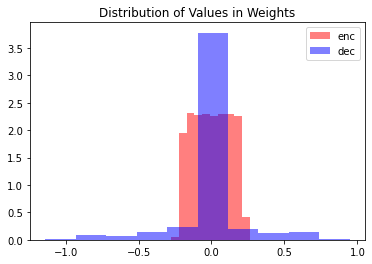

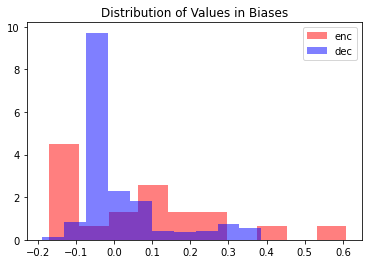

In [14]:
plt.hist(weights[0].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[2].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Weights")
plt.legend()
plt.show()

plt.hist(weights[1].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[3].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Biases")
plt.legend()
plt.show()

## EVALUATE PERFORMANCE

In [15]:
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

model.load_state_dict(torch.load(save_name))

<All keys matched successfully>

In [16]:
def print_results(model, df_large, U_large, scale, params):
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_large, df_large, params, reset_enc=True, reset_dec=True)
        
        x_rom = model.decoder(x_map)
        x_rom = model.GFN.decoder(x_rom, df_large, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False)

        error_abs_list = list()
        norm_z_list = list()
        latents_error = list()
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
        for snap in range(U_large.shape[0]):
            error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
            norm_z = np.linalg.norm(Z[:, snap], 2)
            error_abs_list.append(error_abs)
            norm_z_list.append(norm_z)
            lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
            latents_error.append(lat_err)

        latents_error = np.array(latents_error)
        print("\nMaximum relative error for latent  = ", max(latents_error))
        print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
        print("Minimum relative error for latent = ", min(latents_error))

        error = np.array(error_abs_list)
        norm = np.array(norm_z_list)
        rel_error = error/norm
        print("\nMaximum absolute error for field "+" = ", max(error))
        print("Mean absolute error for field "+" = ", sum(error)/len(error))
        print("Minimum absolute error for field "+" = ", min(error))
        print("\nMaximum relative error for field "+" = ", max(rel_error))
        print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
        print("Minimum relative error for field "+" = ", min(rel_error))

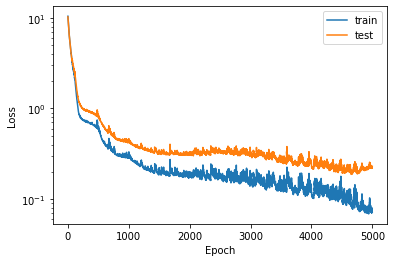

In [17]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
for i in range(len(test_mesh_names)):
    print('-'*40)
    print(f'TEST MESH: {test_mesh_names[i]}')
    scale, U = get_scaled_data(test_solution_names[i])
    U = U.to('cpu')
    df = pd.read_csv(test_mesh_names[i], header=None).values

    model.eval()
    model.to('cpu')
    print_results(model, df, U, scale, params.to('cpu'))
    print()

----------------------------------------
TEST MESH: reference_mesh_large.csv
reconstruction error tensor(9.1108e-27)

Maximum relative error for latent  =  1.2191234204112704
Mean relative error for latent =  0.046460418609668326
Minimum relative error for latent =  0.005627982656739822

Maximum absolute error for field  =  21.147156796684197
Mean absolute error for field  =  6.875315160349985
Minimum absolute error for field  =  2.4845238387830797

Maximum relative error for field  =  0.28387804512190334
Mean relative error for field  =  0.09142023731070359
Minimum relative error for field  =  0.03775340465684283

----------------------------------------
TEST MESH: reference_mesh.csv
reconstruction error tensor(4.0544e-27)

Maximum relative error for latent  =  1.2194089742421115
Mean relative error for latent =  0.19329869026669524
Minimum relative error for latent =  0.010225123524576803

Maximum absolute error for field  =  14.152682605984197
Mean absolute error for field  =  4.608